<a href="https://colab.research.google.com/github/ndrep/bioinformatics/blob/main/Bioinformatic_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount drive

from google.colab import drive

drive.mount("/drive/")

#Installing requirements

!pip install -q "cache_decorator[all]"==2.0.8 humanize scikit-learn
!pip install -q barplots plot_keras_history epigenomic_dataset>=1.1.7
!pip install -q ucsc_genomes_downloader>=1.1.22 keras_bed_sequence>=1.1.5
!pip install -q keras_mixed_sequence ray seaborn minepy boruta prince cmake
!pip install -q multicoretsne silence_tensorflow>=1.1.1
!pip install tsnecuda==3.0.0+cu110 -f https://tsnecuda.isx.ai/tsnecuda_stable.html --no-dependencies
!pip install -q faiss tbb
!pip install extra_keras_metrics
!pip install -U keras-tuner

#Import packages

In [2]:
from typing import Dict, List, Tuple, Optional
from cache_decorator import Cache
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from matplotlib.colors import ListedColormap, LogNorm
from multiprocessing import cpu_count, Pool
import matplotlib.pyplot as plt
from epigenomic_dataset.utils import get_cell_lines
from typing import Tuple
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, ReLU, Concatenate, Layer
from tensorflow.keras.layers import Conv1D, MaxPool1D, GlobalAveragePooling1D, GlobalMaxPool1D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from extra_keras_metrics import get_complete_binary_metrics
from tsnecuda import TSNE
from keras_mixed_sequence import MixedSequence, VectorSequence
from keras_bed_sequence import BedSequence
from keras_tuner import BayesianOptimization, Hyperband
import keras_tuner as kt
import tensorflow.keras
import tensorflow as tf
import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras.layers.pooling import AveragePooling1D
import warnings
warnings.filterwarnings('ignore')

# Import Epigenomic Data

In [3]:
#modificare in base alla propria cell_line
#cell_line='MCF-7'
#cell_line='K562'
cell_line='A549'

In [4]:
from epigenomic_dataset import active_promoters_vs_inactive_promoters, active_enhancers_vs_inactive_enhancers

X_AP_vs_IP, y_AP_vs_IP= active_promoters_vs_inactive_promoters(cell_line=cell_line, binarize=True)
X_AE_vs_IE, y_AE_vs_IE=active_enhancers_vs_inactive_enhancers(cell_line=cell_line, binarize=True, min_active_tpm_value=0, max_inactive_tpm_value=0)

samples = {
    'promoter':X_AP_vs_IP,
    'enhancer':X_AE_vs_IE
}

labels = {
    'promoter':y_AP_vs_IP, 
    'enhancer':y_AE_vs_IE
}

In [5]:
samples['promoter']

chrom                              PBX1  HOXB5  CTCF  NR5A2  POLR2AphosphoS2  \
chrom chromStart chromEnd  strand                                              
chr1  628964     629220    +       0.69   0.22  0.20   0.67             0.00   
      629013     629269    +       0.59   0.11  0.14   0.60             0.00   
      629642     629898    +       0.00   0.07  0.43   0.10             0.00   
      629847     630103    +       0.26   1.40  0.96   0.20             0.14   
      629905     630161    +       0.27   1.62  0.79   0.21             0.24   
...                                 ...    ...   ...    ...              ...   
chrX  154441877  154442133 +       0.04   0.72  0.38   0.70             0.60   
      154584927  154585183 +       0.00   0.00  0.00   0.00             0.00   
chrY  1452882    1453138   -       0.00   0.00  0.00   0.00             0.00   
      2500959    2501215   -       0.00   0.00  0.00   0.00             0.00   
      14055973   14056229  +       0.00   0.00  0.00   0.00             0.00   

chrom                              FOSL2  CBX8  REST  ATAC-seq   JUN  ...  \
chrom chromStart chromEnd  strand                                     ...   
chr1  628964     629220    +        0.49  0.29  0.55      0.77  0.00  ...   
      629013     629269    +        0.54  0.24  0.57      1.03  0.00  ...   
      629642     629898    +        0.00  0.01  0.11      5.57  0.00  ...   
      629847     630103    +        0.11  0.28  0.82      4.02  0.24  ...   
      629905     630161    +        0.34  0.37  0.82      2.76  0.27  ...   
...                                  ...   ...   ...       ...   ...  ...   
chrX  154441877  154442133 +        0.50  0.42  0.80      0.58  0.58  ...   
      154584927  154585183 +        0.00  0.00  0.00      0.90  0.00  ...   
chrY  1452882    1453138   -        0.00  0.00  0.00      0.00  0.00  ...   
      2500959    2501215   -        0.00  0.00  0.00      0.00  0.00  ...   
      14055973   14056229  +        0.00  0.00  0.00      0.06  0.00  ...   

chrom                              HOXB13  DNase-seq  CEBPB  RNF2   MYC  RFX5  \
chrom chromStart chromEnd  strand                                               
chr1  628964     629220    +         0.43       0.00   0.27  0.00  0.00  0.18   
      629013     629269    +         0.38       0.00   0.19  0.00  0.00  0.18   
      629642     629898    +         0.03       0.00   0.00  0.20  0.00  0.49   
      629847     630103    +         0.23       0.00   0.00  0.75  0.00  0.47   
      629905     630161    +         0.37       0.00   0.00  0.64  0.00  0.46   
...                                   ...        ...    ...   ...   ...   ...   
chrX  154441877  154442133 +         0.62       0.05   0.12  1.12  1.34  1.19   
      154584927  154585183 +         0.00       0.00   0.00  0.00  0.00  0.00   
chrY  1452882    1453138   -         0.00       0.00   0.00  0.00  0.00  0.00   
      2500959    2501215   -         0.00       0.00   0.00  0.00  0.00  0.00   
      14055973   14056229  +         0.00       0.00   0.00  0.00  0.00  0.00   

chrom                              CHD2  HOXA7  SIN3A  CHD4  
chrom chromStart chromEnd  strand                            
chr1  628964     629220    +       0.24   0.68   0.20  0.02  
      629013     629269    +       0.24   0.52   0.24  0.07  
      629642     629898    +       0.00   0.08   0.06  0.00  
      629847     630103    +       0.22   0.35   0.50  0.00  
      629905     630161    +       0.24   0.28   0.64  0.04  
...                                 ...    ...    ...   ...  
chrX  154441877  154442133 +       0.95   0.33   0.84  0.48  
      154584927  154585183 +       0.00   0.00   0.00  0.00  
chrY  1452882    1453138   -       0.00   0.00   0.00  0.00  
      2500959    2501215   -       0.00   0.00   0.00  0.00  
      14055973   14056229  +       0.00   0.00   0.00  0.00  

[99881 rows x 48 columns]

# Data Cleaning

Evaluation of ratio between samples and features.

In [6]:
samples['promoter'].shape[0] / samples['promoter'].shape[1]

2080.8541666666665

In [7]:
samples['enhancer'].shape[0] / samples['enhancer'].shape[1]

1318.4375

### Nan Imputation

X dataset have 182 nan values and it could be imputed with KNNImputer

In [8]:
samples['promoter'].isna().sum().sum()

372

In [9]:
labels['promoter'].isna().sum().sum()

0

In [10]:
samples['enhancer'].isna().sum().sum()

32

In [11]:
labels['enhancer'].isna().sum().sum()

0

In [12]:
from sklearn.impute import KNNImputer

def knn_imputation(df:pd.DataFrame, neighbours:int=5, weights:str='uniform')->pd.DataFrame:
    """Return provided dataframe with NaN imputed using knn.
    
    Parameters
    --------------------
    df:pd.DataFrame,
        The dataframe to impute.
    neighbours:int=5,
        The number of neighbours to consider.
    weights:str='uniform',
        Weight function used in prediction.
        
    Returns
    --------------------
    The dataframe with the NaN values imputed.
    """
    return pd.DataFrame(
        KNNImputer(n_neighbors=neighbours, weights=weights).fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [13]:
for region in samples.items():
  samples[region[0]] = knn_imputation(samples[region[0]])

In [14]:
for region in samples.items():
  print('Nan values in {} is {}'.format(region[0], samples[region[0]].isna().sum().sum()))

Nan values in promoter is 0
Nan values in enhancer is 0


### Drop Constant features

In [15]:
def drop_constant_features(df:pd.DataFrame)->pd.DataFrame:
    """Return DataFrame without constant features."""
    return df.loc[:, (df != df.iloc[0]).any()]

In [16]:
dropped_promoter = drop_constant_features(samples['promoter'])
dropped_enhancer = drop_constant_features(samples['enhancer'])

Check if some features hes been drop

In [17]:
dropped_promoter.shape != samples['promoter'].shape

False

In [18]:
dropped_enhancer.shape != samples['enhancer'].shape

False

In [19]:
samples['promoter'] = dropped_promoter
samples['enhancer'] = dropped_enhancer

### Data Scaling

In [20]:
from sklearn.preprocessing import RobustScaler

def robust_zscoring(df:pd.DataFrame)->pd.DataFrame:
    """Return given dataframe scaled using robust z-scoring."""
    return pd.DataFrame(
        RobustScaler().fit_transform(df.values),
        columns=df.columns,
        index=df.index
    )

In [21]:
samples['promoter'] = robust_zscoring(samples['promoter'])
samples['enhancer'] = robust_zscoring(samples['enhancer'])

### Class Balance

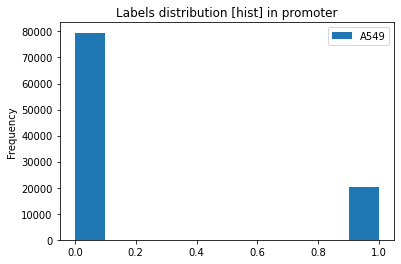

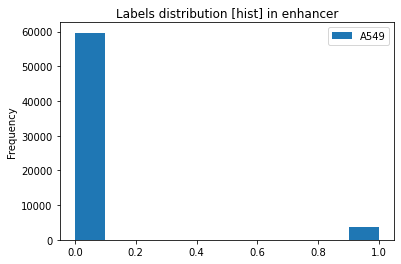

In [22]:
for (region, y) in labels.items():
  y.astype(int).plot.hist(title=f"Labels distribution [hist] in {region}")



In [23]:
for (region, y) in labels.items():
  print("active {} are {}% respect to total class".format(region, (y['A549'][y['A549']==True].count()*100) / y['A549'][y['A549']==False].count()))

active promoter are 25.63015697323405% respect to total class
active enhancer are 6.036996079219866% respect to total class


The classes, overall enhancer class, are very unbalance, but we don't will balance the classes like write in [Bayesian optimization improves tissue-specific prediction of active regulatory regions with deep neural networks](https://gvalentinib.ariel.ctu.unimi.it/v5/frm3/Download.aspx?toolName=contenuti&attachmentid=1037727) paper.

# Features Correlation & Features Selection

In [24]:
p_value_threshold = 0.01
correlation_threshold = 0.05

In [25]:
not_correlated_features = {'promoter':set(), 'enhancer':set()}

### Linear correlation with Pearson index


In [26]:
from scipy.stats import pearsonr

for (X,y) in zip(samples.items(), labels.items()):
  for feature in tqdm(X[1].columns, desc=f"Running Pearson test", dynamic_ncols=True, leave=False):
    correlation, p_value = pearsonr(X[1][feature].values.flatten(), y[1].values.flatten())
    if p_value > p_value_threshold:
      print(f"In {X[0]} the feature {feature} does not correlate in a statistically significant manner with the output. p-value:{p_value} -- correlation:{correlation}")
      not_correlated_features[X[0]].add(feature)

Running Pearson test:   0%|                                                                                   …

In promoter the feature EHMT2 does not correlate in a statistically significant manner with the output. p-value:0.6607639996707804 -- correlation:-0.00138863591560634
In promoter the feature FOSB does not correlate in a statistically significant manner with the output. p-value:0.9177470343200469 -- correlation:0.000326773556940994
In promoter the feature RNF2 does not correlate in a statistically significant manner with the output. p-value:0.9661644733045671 -- correlation:-0.0001342230492837825


Running Pearson test:   0%|                                                                                   …

In enhancer the feature ZC3H11A does not correlate in a statistically significant manner with the output. p-value:0.039427698262771455 -- correlation:0.008187547698984086
In enhancer the feature CBX2 does not correlate in a statistically significant manner with the output. p-value:0.33286027104303706 -- correlation:-0.0038494378820642322


### Linear correlation with Spearman index

In [27]:
from scipy.stats import spearmanr

for (X,y) in zip(samples.items(), labels.items()):
  for feature in tqdm(X[1].columns, desc=f"Running Pearson test", dynamic_ncols=True, leave=False):
    correlation, p_value = spearmanr(X[1][feature].values.flatten(), y[1].values.flatten())
    if p_value > p_value_threshold:
      print(f"In {X[0]} the feature {feature} does not correlate in a statistically significant manner with the output. p-value:{p_value} -- correlation:{correlation}")
      not_correlated_features[X[0]].add(feature)

Running Pearson test:   0%|                                                                                   …

In promoter the feature ZFP36 does not correlate in a statistically significant manner with the output. p-value:0.1043890666226243 -- correlation:0.005138431133429463


Running Pearson test:   0%|                                                                                   …

In enhancer the feature CBX2 does not correlate in a statistically significant manner with the output. p-value:0.7640592944823815 -- correlation:-0.0011931716306596745
In enhancer the feature KDM5A does not correlate in a statistically significant manner with the output. p-value:0.3410897699898755 -- correlation:-0.003784426428309876


In [28]:
not_correlated_features

{'promoter': {'EHMT2', 'FOSB', 'RNF2', 'ZFP36'},
 'enhancer': {'CBX2', 'KDM5A', 'ZC3H11A'}}

### Not linear correlation with MIC

from minepy import MINE
import os
import json

if os.path.exists('/drive/MyDrive/bioinformatics/not_linear_correlation_json.json'):
  with open('/drive/MyDrive/bioinformatics/not_linear_correlation_json.json', 'r') as fp:
      not_linear_correlation = json.load(fp)
else:
  not_linear_correlation = {'promoter':set(), 'enhancer':set()}
  for (X,y) in zip(samples.items(), labels.items()):
    for items in not_correlated_features.items():
      for feature in tqdm(items[1], desc=f"Running MINE test", dynamic_ncols=True, leave=False):
          mine = MINE()
          mine.compute_score(X[1][feature].ravel(), y[1].values.ravel())
          score = mine.mic()
          if score < correlation_threshold:
              print(f"In {X[0]} the feature {feature} does not correlate in a statistically significant manner with the output.")
              not_linear_correlation[items[0]].add(feature)
  
  for region in not_linear_correlation.items():
    not_linear_correlation[region[0]] = list(region[1])

  json_object = json.dumps(not_linear_correlation, indent = 4)
  with open('/drive/MyDrive/not_linear_correlation_json.json', 'w') as writefile:
    writefile.write(json_object)

In [29]:
from minepy import MINE

not_linear_correlation = {'promoter':set(), 'enhancer':set()}
for (X,y) in zip(samples.items(), labels.items()):
    for items in not_correlated_features.items():
        for feature in tqdm(items[1], desc=f"Running MINE test", dynamic_ncols=True, leave=False):
            mine = MINE()
            mine.compute_score(X[1][feature].ravel(), y[1].values.ravel())
            score = mine.mic()
            if score < correlation_threshold:
                print(f"In {X[0]} the feature {feature} does not correlate in a statistically significant manner with the output.")
                not_linear_correlation[items[0]].add(feature)
                
for region in not_linear_correlation.items():
    not_linear_correlation[region[0]] = list(region[1])

Running MINE test:   0%|                                                                                      …

In promoter the feature RNF2 does not correlate in a statistically significant manner with the output.
In promoter the feature EHMT2 does not correlate in a statistically significant manner with the output.
In promoter the feature FOSB does not correlate in a statistically significant manner with the output.
In promoter the feature ZFP36 does not correlate in a statistically significant manner with the output.


Running MINE test:   0%|                                                                                      …

In promoter the feature CBX2 does not correlate in a statistically significant manner with the output.
In promoter the feature ZC3H11A does not correlate in a statistically significant manner with the output.


Running MINE test:   0%|                                                                                      …

In enhancer the feature RNF2 does not correlate in a statistically significant manner with the output.
In enhancer the feature EHMT2 does not correlate in a statistically significant manner with the output.
In enhancer the feature FOSB does not correlate in a statistically significant manner with the output.
In enhancer the feature ZFP36 does not correlate in a statistically significant manner with the output.


Running MINE test:   0%|                                                                                      …

In enhancer the feature CBX2 does not correlate in a statistically significant manner with the output.
In enhancer the feature KDM5A does not correlate in a statistically significant manner with the output.
In enhancer the feature ZC3H11A does not correlate in a statistically significant manner with the output.


### Drop features not correlated with output

In [30]:
for region in samples.items():
  print(region[1].shape)

(99881, 48)
(63285, 48)


In [31]:
for region in samples.items():
  region[1].drop(list(not_linear_correlation[region[0]]), axis=1, inplace=True)

In [32]:
for region in samples.items():
  print(region[1].shape)

(99881, 44)
(63285, 45)


### Correlation with features

In [33]:
from scipy.stats import spearmanr

@Cache(
    cache_path="spearmanr/{_hash}.json",
    args_to_ignore=["X"]
)
def compute_spearmanr(
    X:pd.DataFrame,
    feature_left: str,
    feature_right: str,
    cell_line: str,
    region: str
) -> Dict:
    """Returns Spearman correlation.
    
    Implementative details
    ------------------------------
    We may need to recompute this value across
    multiple re-runs of the jupyter notebook,
    so since it takes a bit of time to do so we cache it.
    
    Parameters
    ----------------------
    X:pd.DataFrame,
        The epigenomic data.
    feature_left: str,
        The left features to compute pearson for.
    feature_right: str,
        The right features to compute pearson for.
    cell_line: str,
        The cell line.
    region: str,
        The cis-regulatory region of interest.
    """
    correlation, p_value = spearmanr(
        X[feature_left].values.flatten(),
        X[feature_right].values.flatten(),
    )
    return dict(
        correlation=correlation,
        p_value=p_value
    )

highly_correlated_future = {'promoter':[], 'enhancer':[]}

for X in tqdm(samples.items(), desc=f"Running Spearman test", dynamic_ncols=True, leave=False):
  for feature_left in tqdm(X[1].columns, dynamic_ncols=True, leave=False):
      for feature_right in X[1].columns:
          if feature_left >= feature_right:
              continue
          pearson_result = compute_spearmanr(
              X[1],
              feature_left,
              feature_right,
              cell_line=cell_line,
              region="promoters"
          )
          if pearson_result["p_value"] < p_value_threshold and np.abs(pearson_result["correlation"]) > 0.99:
              correlation = pearson_result["correlation"]
              print(f"The feature {feature_left} is highly correlated with {feature_right} ({correlation}).")
              highly_correlated_future.append(feature_left)

              

Running Spearman test:   0%|                                                                                  …

  0%|                                                                                                         …

  0%|                                                                                                         …

In [34]:
for region in samples.items():
  print(region[1].shape)

(99881, 44)
(63285, 45)


In [35]:
for region in samples.items():
  region[1].drop(highly_correlated_future[region[0]], axis=1, inplace=True)

In [36]:
for region in samples.items():
  print(region[1].shape)

(99881, 44)
(63285, 45)


### Features selection with boruta

In [37]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from boruta import BorutaPy
from multiprocessing import cpu_count

def execute_boruta_feature_selection(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    holdout_number: int,
    task_name: str,
    max_iter: int = 100,
    regression: bool = False,
):
    """Returns tuple with list of kept features and list of discared features.
    
    Parameters
    --------------------------
    X_train: pd.DataFrame,
        The data reserved for the input of the training of the Boruta model.
    y_train: np.ndarray,
        The data reserved for the output of the training of the Boruta model.
    holdout_number: int,
        The current holdout number.
    regression: bool,
        Whether the task is a binary classification one (False) or a regression one (True).
    task_name: str,
        The name of the task.
    max_iter: int = 100,
        Number of iterations to run Boruta for.
    """
    # According to the requested task we build either a random forest regressor
    # or a random forest classifier.
    if regression:
        model = RandomForestRegressor(n_jobs=cpu_count(), max_depth=5)
    else:
        model = RandomForestClassifier(n_jobs=cpu_count(), class_weight='balanced_subsample', max_depth=5)
    
    # Create the Boruta model
    boruta_selector = BorutaPy(
        # Defining the model that Boruta should use.
        model,
        # We leave the number of estimators to be decided by Boruta
        n_estimators='auto',
        verbose=False,
        alpha=0.05, # p_value
        # In practice one would run at least 100-200 times,
        # until all tentative features are exausted.
        max_iter=max_iter, 
        random_state=42,
    )
    # Fit the Boruta model
    boruta_selector.fit(X_train.values, y_train)
    
    # Get the kept features and discarded features
    kept_features = list(X_train.columns[boruta_selector.support_])
    discarded_features = list(X_train.columns[~boruta_selector.support_])
    
    # Filter out the unused featured.
    return kept_features, discarded_features

# Import Sequence Data

In [38]:
from ucsc_genomes_downloader import Genome

#%cp -r /genomes /content/

genome = Genome("hg38")

Loading chromosomes for genome hg38:   0%|                                                                    …

In [39]:
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

In [40]:
sequence = {'promoter':pd.DataFrame(
                        np.array(BedSequence(
                            genome,
                            bed=to_bed(labels['promoter']),
                            batch_size=1
                        )).reshape(-1, 4*256),
                        index=labels['promoter'].index
                    )
            , 
            'enhancer': pd.DataFrame(
                        np.array(BedSequence(
                            genome,
                            bed=to_bed(labels['enhancer']),
                            batch_size=1
                        )).reshape(-1, 4*256),
                        index=labels['enhancer'].index
                    )
          }

In [41]:
sequence

{'promoter':                                    0     1     2     3     4     5     6     \
 chrom chromStart chromEnd  strand                                             
 chr1  628964     629220    +        0.0   0.0   0.0   1.0   0.0   0.0   1.0   
       629013     629269    +        1.0   0.0   0.0   0.0   0.0   1.0   0.0   
       629642     629898    +        0.0   0.0   1.0   0.0   0.0   0.0   0.0   
       629847     630103    +        0.0   0.0   1.0   0.0   0.0   0.0   0.0   
       629905     630161    +        0.0   1.0   0.0   0.0   1.0   0.0   0.0   
 ...                                 ...   ...   ...   ...   ...   ...   ...   
 chrX  154441877  154442133 +        0.0   0.0   1.0   0.0   0.0   0.0   0.0   
       154584927  154585183 +        0.0   1.0   0.0   0.0   1.0   0.0   0.0   
 chrY  1452882    1453138   -        0.0   0.0   0.0   1.0   0.0   1.0   0.0   
       2500959    2501215   -        0.0   1.0   0.0   0.0   0.0   0.0   1.0   
       14055973   14056229  

# Data visualization with t-SNE or PCA 

In [42]:
tasks = {
    "x":[
        *[
            val.values
            for val in samples.values()
        ]
    ],
    "y":[
        *[
            val.values.ravel()
            for val in labels.values()
        ]
    ],
    "titles":[
        "Epigenomes promoters",
        "Epigenomes enhancers"
    ]
}

tasks


xs = tasks["x"]
ys = tasks["y"]
titles = tasks["titles"]

assert len(xs) == len(ys) == len(titles)

for x, y in zip(xs, ys):
    assert x.shape[0] == y.shape[0]

In [43]:
tasks_seq = {
    "x":[
        *[
            val.values
            for val in sequence.values()
        ]
    ],
    "y":[
        *[
            val.values.ravel()
            for val in labels.values()
        ]
    ],
    "titles":[
        "Sequence promoters",
        "Sequence enhancers"
    ]
}

tasks_seq


xss = tasks_seq["x"]
yss = tasks_seq["y"]
titless = tasks_seq["titles"]

assert len(xss) == len(yss) == len(titless)

for x, y in zip(xss, yss):
    assert x.shape[0] == y.shape[0]

### PCA decomposition

In [44]:
from sklearn.decomposition import PCA

def pca(x:np.ndarray)->np.ndarray:
    return PCA(n_components=2, random_state=42).fit_transform(x)

Computing PCAs:   0%|          | 0/2 [00:00<?, ?it/s]

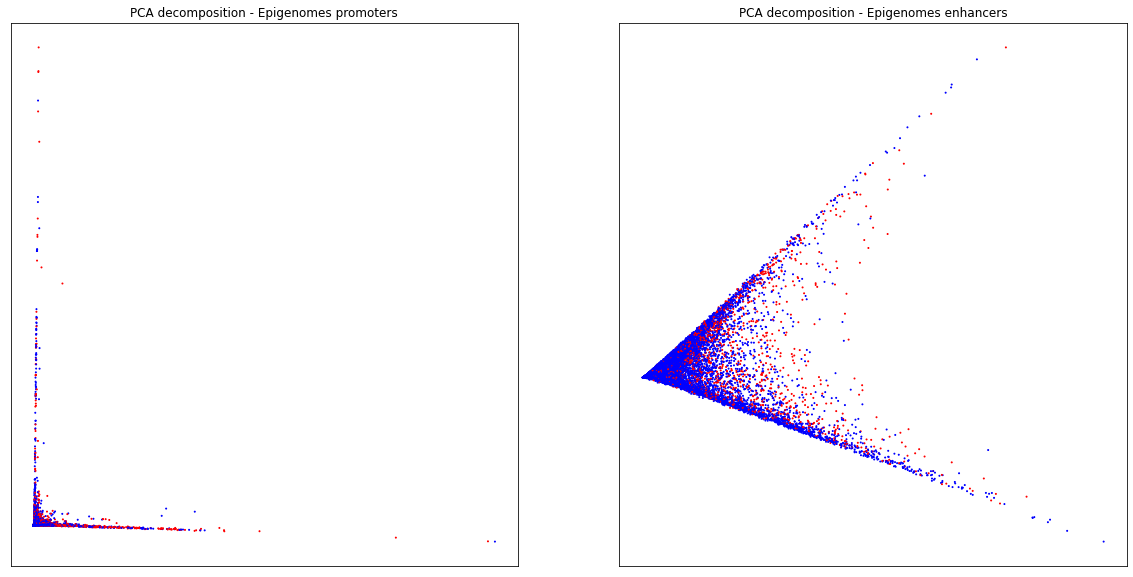

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for x, y, title, axis in tqdm(zip(xs, ys, titles, axes.flatten()), desc="Computing PCAs", total=len(xs)):
    axis.scatter(*pca(x).T, s=1, c=['#ff0000' if i else '#0000ff' for i in y])
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title(f"PCA decomposition - {title}")
plt.show()

Computing PCAs:   0%|          | 0/2 [00:00<?, ?it/s]

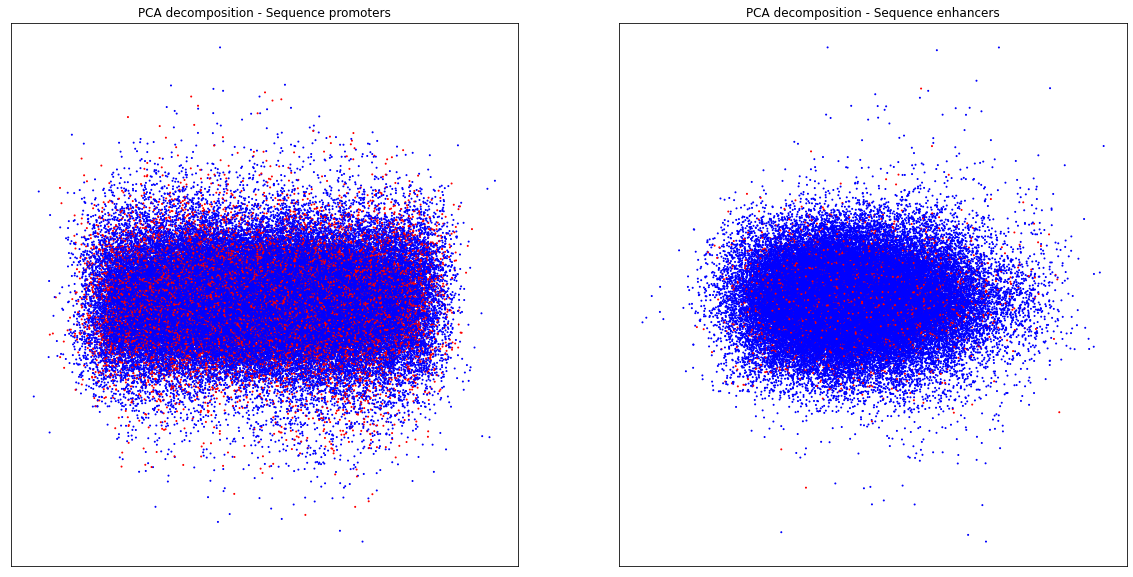

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for x, y, title, axis in tqdm(zip(xss, yss, titless, axes.flatten()), desc="Computing PCAs", total=len(xss)):
    axis.scatter(*pca(x).T, s=1, c=['#ff0000' if i else '#0000ff' for i in y])
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title(f"PCA decomposition - {title}")
plt.show()

### t-SNE decomposition

In [47]:
import gc
import tsnecuda
from tsnecuda import TSNE
import multiprocessing
from multiprocessing import Process, Queue

def tsne(X:np.ndarray)->np.ndarray:
    return TSNE(
            # Better performance may be achieved with cosine distance,
            # but currently TSNECUDA does not support other metrics.
            # Expecially for the sequence data, cosine distances may be foundamental
            # to get a semantically significant decomposition.
            perplexity= 30,
            n_iter = 1000,
            verbose=True,
        ).fit_transform(X)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for x, y, title, axis in tqdm(zip(xs, ys, titles, axes.flatten()), desc="Computing t-SNE", total=len(xs)):
    axis.scatter(*tsne(x).T, s=1, c=['#ff0000' if i else '#0000ff' for i in y])
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title(f"t-SNE decomposition - {title}")
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

for x, y, title, axis in tqdm(zip(xss, yss, titless, axes.flatten()), desc="Computing t-SNE", total=len(xss)):
    axis.scatter(*tsne(x).T, s=1, c=['#ff0000' if i else '#0000ff' for i in y])
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title(f"t-SNE decomposition - {title}")
plt.show()

# Classification Models

### FFNN model

#### Hypermodel

In [48]:
class FFNNHyperModel(kt.HyperModel):
  
  def __init__(self, input_shape):
    self.input_shape = input_shape    

  def build(self, hp):
    
    hp1 = hp.Choice('hp1', [128, 64, 32, 16, 8, 4, 2])
    hp2 = hp.Choice('hp2', [64, 32, 16, 8, 4, 2])
    hp3 = hp.Choice('hp3', [32, 16, 8, 4, 2])

    input_epigenomic_data = Input(shape=(self.input_shape,), name="epigenomic_data")
    hidden = Dense(hp1, activation="relu", name="dense_ffnn")(input_epigenomic_data)
    hidden = PReLU(name="prelu_ffnn")(hidden)
    hidden = BatchNormalization(name="norm_ffnn")(hidden)
    hidden = Dropout(rate=0.2, name="dropout_ffnn")(hidden)

    hidden = Dense(hp2, activation="relu", name="dense_1_ffnn")(hidden)
    hidden = PReLU(name="prelu_2_ffnn")(hidden)
    hidden = BatchNormalization(name="norm_2_ffnn")(hidden)
    hidden = Dropout(rate=0.2, name="droupout_1_ffnn")(hidden)

    hidden = Dense(hp3, activation="relu", name="dense_2_ffnn")(hidden)
    hidden = PReLU(name="prelu_3_ffnn")(hidden)
    hidden = BatchNormalization(name="norm_3_ffnn")(hidden)
    hidden = Dropout(rate=0.2, name="last_hidden_ffnn")(hidden)
    
    last_hidden_ffnn = hidden
    output_ffnn = Dense(1, activation="sigmoid", name="output_ffnn")(last_hidden_ffnn)

    ffnn = Model(
        inputs=input_epigenomic_data,
        outputs=output_ffnn,
        name="BinaryClassificationFFNN"
    )

    ffnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )
    
    return ffnn


#### Baesyan Optimization Classification function

In [49]:
def baesyan_optimization_FFNN_classification(
    train_sequence: MixedSequence,
    test_sequence: MixedSequence,
    input_shape: int
)->Tuple[Model, Layer, Layer]:
    
    tuner = BayesianOptimization(
      FFNNHyperModel(input_shape),
      objective='val_accuracy',
      max_trials=2,
      overwrite=True,
      project_name="FFNN_BO"
    )

    tuner.search(
      train_sequence,
      validation_data=test_sequence,
      epochs=300,
      verbose=False,
      callbacks=[
          EarlyStopping(
              "loss",
              min_delta=0.001,
              patience=20,
              mode="min"
          )
      ]
    )
    
    model = tuner.get_best_models()[0]
        
    return model, model.get_layer("epigenomic_data").output, model.get_layer("last_hidden_ffnn").output

#### Fixed Classification Model

In [50]:
def build_fixed_model_FFNN_classification(input_shape: int):

  input_epigenomic_data = Input(shape=(input_shape,), name="epigenomic_data")
  hidden = Dense(64, activation="relu")(input_epigenomic_data)
  hidden = PReLU()(hidden)
  hidden = BatchNormalization()(hidden)
  hidden = Dropout(rate=0.2)(hidden)

  hidden = Dense(32, activation="relu")(hidden)
  hidden = PReLU()(hidden)
  hidden = BatchNormalization()(hidden)
  hidden = Dropout(rate=0.2)(hidden)

  hidden = Dense(16, activation="relu")(hidden)
  hidden = PReLU()(hidden)
  hidden = BatchNormalization()(hidden)
  hidden = Dropout(rate=0.2)(hidden)

  last_hidden_ffnn = hidden
  output_ffnn = Dense(1, activation="sigmoid")(last_hidden_ffnn)

  ffnn = Model(
      inputs=input_epigenomic_data,
      outputs=output_ffnn,
      name="BinaryClassificationFFNN"
  )
  
  ffnn.compile(
      optimizer="nadam",
      loss="binary_crossentropy",
      metrics=get_complete_binary_metrics()
  )

  return ffnn, input_epigenomic_data, last_hidden_ffnn


#### Get sequence

In [51]:
def get_ffnn_sequence(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a FFNN model on epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a FFNN.
    """
    return MixedSequence(
        x={
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

### CNN model

Come strutturare una CNN?

- Convilution (Appliazione dei filtri per generale e feature maps
- Non linearity (ReLU)
- Pooling (serve per diminuire la dimensionalità del layer). La tecnica consiste nel prendere una vinestra (2x2) e spostarla su tutto il layer e di ogni finiestra prendo solo il valore massimo. 

In [ ]:
![Screenshot 2021-12-23 at 15.04.31.png](data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAB3wAAAKoCAYAAACcFY4tAAABQmlDQ1BJQ0MgUHJvZmlsZQAAKJFjYGASSCwoyGFhYGDIzSspCnJ3UoiIjFJgf8rAwyDOwAckFRKTiwscAwJ8gEoYYDQq+HaNgRFEX9YFmaXfutnwiGL/jF0+5bXBfLc+Y6pHAVwpqcXJQPoPECclFxSVMDAwJgDZyuUlBSB2C5AtUgR0FJA9A8ROh7DXgNhJEPYBsJqQIGcg+wqQLZCckZgCZD8BsnWSkMTTkdhQe0GAI9TIwtXU3ICAU0kHJakVJSDaOb+gsigzPaNEwREYQqkKnnnJejoKRgZGhgwMoPCGqP4sBg5HRrFTCLHsRwwMltYMDEyfEWIJoQwMW2MYGHi1EWJa8xkYBDMZGA7zFyQWJcIdwPiNpTjN2AjC5iliYGD98f//Z1kGBvZdDAx/i/7//z33//+/SxgYmG8yMBwoBADEY11Vs3D0XwAAAIplWElmTU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAOShgAHAAAAEgAAAHigAgAEAAAAAQAAB3ygAwAEAAAAAQAAAqgAAAAAQVNDSUkAAABTY3JlZW5zaG90J2RjHQAAAAlwSFlzAAAWJQAAFiUBSVIk8AAAAddpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDYuMC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+NjgwPC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjE5MTY8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4Kin4JOwAAABxpRE9UAAAAAgAAAAAAAAFUAAAAKAAAAVQAAAFUAAEFd5knYbUAAEAASURBVHgB7N0F3BRV////oygGitgYWNgKGIiKARZ2K3YXGAjeFqjYGLeBYndg622ALXa3YisiItiFggrq/M/7/L7n/M/MtbvXXrvLde1e1+s8HrCzk2eeMzvXzHxOzJDYZEgIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAjUnMAMB35o7ZmQYAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQcAIEfDkREEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIEfDkHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRoVIOBboweObCOAAAIIIIAAAggggAACCDQPgUmTJpmvvvrKzD777GaxxRYzM844Y9ixr7/+2iy00ELhOwMIIIAAAggggAACCCCAAAIIZAUI+GZF+I4AAggggAACCCCAAAIIVJHA6quvbqZOnZozRwoMLr744ma55ZYznTp1MrvvvruZaaaZcs7bXEbedddd5oILLjB77LGHOfzww2t2t55//nlz8803m/vuu8989913YT9at25tOnbsaJZddlkzzzzzmJtuusl88cUXZtFFFzWbbbaZmTBhQphXA3fffbc7/qmR9suHH35oevfunR1t1l57bXPVVVdVdF11NsIIBBBAAAEEEEAAAQQQQACBRhUg4Nuo3GwMAQQQQAABBBBAAAEEEGiYwLRp08wLL7xgNtlkE/P333+7hRdYYAFz3HHHuZqgL774ogv6JUli1lprLXPbbbeZJZZYomEbqaG5l1lmGfPZZ5+52rAKfrZr166Gcm/MmDFjzIABA8yIESNcvrt06eKCr926dXMB3tGjR5uzzjrLqGav0lxzzWV+/vlnM8MMM5iffvrJ3HPPPaZv377mn3/+cdP79etnLrroIjec/e+XX34xRx55pAsaa9o555xj+vTpY9q2bVvRdWW3y3cEEEAAAQQQQAABBBBAAIHGFSDg27jebA0BBBBAAAEEEEAAAQQQKElATf2OHz/eLXvhhRea/v37h/VceumlobZr165dzWuvvRamNbcBBbVfeeUVM++887rarrPMMkvN7OKjjz5qdt55Z/Pbb7+ZmWee2QwePNgMHDjQtGrVKrUPCvBqPz/55BOz3nrrmWeffTY1fc899zS33HKLG6eAsALfbdq0Sc3jv9x5551ml112MZtvvrl56KGH/OjwWcl1hZUygAACCCCAAAIIIIAAAggg0KgCBHwblZuNIYAAAggggAACCCCAAAINF/j2229N+/btw4IfffRRqhlf1fxV/6+qDayaoKoduuCCC4b5m9OA+rq94447zFZbbZUyqPZ9vPfee10TyzpWs802mxk1apRrXjlfvh955BEXpD3iiCPMxRdfnJpttdVWM2+99VYYd+WVV5qDDz44fI8HBg0a5GoMqynsnXbaKZ7khiu5rjorZwQCCCCAAAIIIIAAAggggECjCBDwbRRmNoIAAggggAACCCCAAAIIlC4wfPhws9dee7kVqLnmsWPHplam5n3nnHNO88cff7jx999/v9lmm21S8/Cl6QTUR++KK65ofvzxR5eJG264weyzzz4FM6Rjquaqhw4dag444IAwr4L5iyyyiFGN73HjxrnxnTt3Nu+8806YJx5Yc801zdtvv21++OEHd47E0yq5rni9DCOAAAIIIIAAAggggAACCDSuAAHfxvVmawgggAACCCCAAAIIIIBAgwUU7FXQV+mQQw4xV1xxRWodqu2pmpo+vfnmm2bVVVf1X/lsYgHVrFXfu0oaVm3bYpICveqDVwFdn66//nqz//77m4cfftjst99+5ptvvnGTnnvuObPuuuv62dynmoaeb775zEYbbWQee+yx1DR9qeS66qycEQgggAACCCCAAAIIIIAAAo0mQMC30ajZEAIIIIAAAggggAACCCDQcIEkSVxzzqolqqSmgbfbbruwon///dfsscce5vbbb3fjVllllVRzv2FGO/DZZ5+Zyy+/3LzxxhtmypQpZtddd3XrVo1T9Yl72223mY8//ti8/PLL5t133zXvvfeeURPE6nt2pplmCqtSwPL88883u+22mwtIhgnRwNSpU819991nVNt4zJgxrhlj1Wrdd999o7n+36CaaNa2v/zyS7PAAguY7t27G+2vardqu6rRrHUob6NHj3Z5GzFihMtznZXZEcXsp5ZTU9mqGauAuUyWXHJJc84557hVKsCufCloqsCrgqulJN+HrpadccYZXf5V27fU1Lt3bzNy5EiXryFDhpjTTjvNrUrH4tZbb02tVkFmBZizfT77mSq5Lr9OPhFAAAEEEEAAAQQQQAABBBpfgIBv45uzRQQQQAABBBBAAAEEEECgaAHV1l199dXd/DPPPLNrFljNNyspCHrSSSe5YKm+K9j7v//9zwUu9T1OCp7+5z//MSussII57LDDzPzzz2+OPvro0Cxw3759zWWXXWbOO+88FwRVDVLfBPHNN99s9txzz7C6zTff3KiPWQVjP//8c9OhQ4cwTQPvv/++2Xnnnd20gQMHGjVD7QO9CiKvtNJKYf6zzz7baJ7lllvOKICpbSpfkyZNMgp2K/Xv39888cQTbr36rsCstpsrFbufzzzzjAtYq1ljn7T/Cu7uvffeLtjrx6tfZAWHZdaQpGD8oosu6vpU1nLbb7+9Oz4NWUc8r5p5Vo1dNdMs/wkTJjhbBeV1bowfPz7Vd7OOqWqDZ/t81jorua44jwwjgAACCCCAAAIIIIAAAgg0gYB9gCYhgAACCCCAAAIIIIAAAghUqYANgirqGf7ZwGti++dNbC3RMG799ddPbGAvmTZtWp29sIG9pF+/fm5eGzhOfv311zCPDbaGddjaoGG8BmwN38QGEd30jTfeODXtxRdfTGxNXDfNBl5T02688cZk9tlnT9q2bZu89NJLbtrkyZOTVq1auflt7dTU/LZmsRt/1llnhfHXXnutGxdG2AFbs9eNk4Vt1jqe5IZL3U9bOzqs1wZME/nK9vXXX0+OOOKIMO3TTz+ts836Rjz77LNheeX7pptuqm+RgtNts81ufTYoH+azNXjDNk4//fQwXgMdO3ZMllpqqdQ4/6WS6/Lr5BMBBBBAAAEEEEAAAQQQQKBpBFRimoQAAggggAACCCCAAAIIIFClAj169AgBvbXXXjvZYYcdkp49eyZzzz13GN+rV6/ENmOccw8OPPBAN58Cfz/88ENqHtsss5tmmxpObNPFqWn6sssuu4Tptonl1HTbhHSyyCKLpMYpoOmD07amcZh25ZVXhvX89NNPYbytxRvm33HHHcN429y0CzaHEXbANrEc5s0GpzVfqfvpfRUMt80jJ7YGdOLz2KdPH7fN1q1bJ7YWbZydooaPP/74kGdbSzjJGha1kmimQYMGufXZZqjD2Keeeipsw9YmDvlUIF7HwtbmDvPGA5VcV7xehhFAAAEEEEAAAQQQQAABBBpfgIBv45uzRQQQQAABBBBAAAEEEECgKAEFRH0tWwXv4kCfgqLbbrttCPappqztAze13ieffDJMz9as1Yw+SNqtW7fUcv6LbTY4LG/7+fWj3ecpp5yS7L777mGctj3XXHO5+RUo9umVV15JZpttNjdeAdVsWnzxxcM2bDPSYfItt9wShjVg+/9186mmcDY4Xep+/vbbb8HXNlOdzDPPPElcY7lLly5um6pBXUryAXMdu4UXXriUVaSWWXXVVZMFF1wwsU1Fp8bbJrKDoQ+0X3XVVW5cruOuhSu5rlRm+IIAAggggAACCCCAAAIIINDoAvTha5+8SQgggAACCCCAAAIIIIBANQrcf//9ZrvttnNZs00om2+++caoP1mf1A+rrblrbLDVjVLfs7ZJZTc8depUYwOWrv/W7t27mxdeeMEv5j61rK2h6/qmtTVRjW1SOTVdX/766y9jg6DGBpfNrrvuGvoK9tu1QWCzwQYbuL52N9lkEzNq1Chjawsb9dNrmxM25557rrFBXjdd/fRqOJsuuugi10evxi+00ELm7bffNtrXbFJeJ06caGwtZ2OblA6Ty9lPGww1W2+9dViXrUVsbBPP7rutDe3yYZ/SzZlnnmlsjdgwn22q2ejY5EraT/Wzq2QDxcY2neyG1Q+zbSbaDZfyn469DRobG2Q3ymec1Pew+mVW2mijjVx/x7179zYjRoxwfSLbJrbj2d15VKl1pVbMFwQQQAABBBBAAAEEEEAAgaYRaPQQMxtEAAEEEEAAAQQQQAABBBAoSqBv376h5qb6ls2VbJA3zLPMMsuEWWwgNYxX88vZFNfeffTRR7OTw/etttrKrUfNBfukfnpXW201/zV5/vnnw7ZmmmmmRE0h26Cnq9mrWq42iBvmzQ7YoHLSuXPnsPxuu+2WnSWxAeQw/eSTT05NL2c/Dz/88LBe7Wec7rjjjjBN/fnGaf/99w/T7JN8GFZt7D///DPMaoPhYZoNuofxpQxcf/31bl3ZmtZal2qCzznnnGFb77//fqIa35tuumnOTVVyXTk3wEgEEEAAAQQQQAABBBBAAIFGFaCGb9PE2dkqAggggAACCCCAAAIIIFCvgGrJ2iaG3Xy2f1yz11571VnmyCOPNBdffLEb36FDh1Dbd6211jK2OWVjm1N2tTz1GSfV+n3ppZeMDVIa20SyadOmTTw5DA8bNsz069fPfZ8wYYKZf/75zfLLL280fosttnDjBwwYYIYOHeqGVQN3vfXWM127djU24Gjatm0b1pVvQDWCVQNWtXWVbBPNruawn1/r1jaUVFNZefepnP1cbrnlzCeffGJsM9GuJvTSSy/tV2sOOuggc80117j9/fbbb1M1q7Xv/riEBeyAaiarhq9PNjBsbHDVfVXtZdVQLjXZwLm58847jY6Baudmkw1em0svvdSN1jHQsZWbzo9squS6suvmOwIIIIAAAggggAACCCCAQOMLEPBtfHO2iAACCCCAAAIIIIAAAgjUK/DZZ58ZW2M3zPf111+b9u3bh+9+QE0qP/300+6rmvG1NVONrWVq1IyvLU7sgq62Nq+f3X3afl7Njjvu6IYVMFVwMF9SE8u2v1c3Wev54IMPzD333GNsrd6wiAK/tv9d912B0CWXXDJMyzWg5pLVLPIOO+wQJp966qnG9gvsvtuazUbNFPtka9+aBx980Ng+go2WtbWI3aRy9nPcuHFmiSWWcOvxbn57+tQ+fPHFF64JZdufcDyp6OG4qWU1xf3dd9+F5p4LrcTW0HXNadta1G42BcIVTLa1rF1z2bmW1XGxffmmJn388cdm2WWXTY2r5LpSK+YLAggggAACCCCAAAIIIIBA0wk0an1iNoYAAggggAACCCCAAAIIIFCUgK1FGproVZPHuZKaUra1U8N81113nZvt008/DeMOOOCA1KI20JnYWrph+tFHH+2m33vvvckff/yRmldf/v7772SOOeZw8x977LGJ7dM3ee2111LzbbjhhmF9H374YWqa/3LfffclNtjovj7++OOJDbb6Se5TTSHbILVbj+37NkzT9m0tYTfe9mfsxt99992JDcYm5eznVVddFfJs+/IN29PAmDFjwjQ1oaw8nHDCCanmmlML5Pny66+/pppa9tZ5Znejbe3mxAa2k0suuSTM5pvftrV1w7hcA3ET0rZ2eK5ZkkquK+cGGIkAAggggAACCCCAAAIIINDoAirxTUIAAQQQQAABBBBAAAEEEKgygY033jgEHXP136t+cRU0tcWH3b94HtsEcWJrlLrxK6+8ctiz8ePHJ6usskrSv3//sJyt7ZsMGTLE9aM7efLkMG880KNHjzC/+hXOJlszN0w/7rjjUpN/+umnZNddd020jt9++81Nu/rqq9382b59bZPKbvzBBx8c1qH+aP0+Kgj63HPPJepP2NZ4TsrZz5122smtd+65506mTZsWtqcBBXn9NhUg1z7rePzzzz+p+Yr5cuGFF4Z1zTrrrEm+/pKVhzPPPDNp3bp1csYZZ6RWrX6NlZ+bb745NT77RYFwn2/1T5wrVXJdudbPOAQQQAABBBBAAAEEEEAAgcYXoEln+zRMQgABBBBAAAEEEEAAAQSqSUDNI6sZ43///ddlS/3mnn/++a7vVjWZrOaQb731VjfdBgiNrcXr+mvVsE9rrrmmefXVV91XG6x0TfuqD1g1o7zffvsZ9fOq1KlTJ9fH78svv2zUB3CudNRRRxkbuHTNCn/00UfGBklTs7355ptG27M1YV1/uJtssonr31dNCt91113GBnxd/n1TzCeeeKKxwU1jawYbW7vW9TOsJqLV96/mUT+93bp1c9t46qmn3Hz6suWWW7pp2g9tQ6mU/VQfuDJV38W77767yTbZPHjwYHP66ae79ffq1cuoeW1ZzjvvvG5cQ/+L+9dV0859+vQxWq/6Qra1gN3xtLWzXf/LF1xwgTnkkEPCJtSfsea1wWYzaNAgY4PBqf6Ew4x2QP5qivqrr75yTWD7Ppb9PJVcl18nnwgggAACCCCAAAIIIIAAAlUg0PgxZraIAAIIIIAAAggggAACCCCQT8AGYkMtTfvIWGd45plnTmzfvslmm22WqDatau3mSmq6V836+nWoueTTTjstsUHkxAaNw3jbx6trGjnXOvy4c845x82vmq/50qhRoxLVlvXb06dqF9922211Ftljjz0S2yeta8LZBiiT7t27uxrJNhCb2P6BU/OrhrBqvWp97dq1S1QjOU6l7Oe7774b8mn7PI5X54bV/LTfDxsQT1TLt9yk/VpxxRVDzWu/fn3aIHei5qqzzWGr1nY8n4bV3PN7772XNzs6xqpJPGXKlNQ8lVxXasV8QQABBBBAAAEEEEAAAQQQaHIBavjaJ2YSAggggAACCCCAAAIIINAcBVTj0wZiXQ1a1eSNa+aqpu4PP/zgatLGNYNzOXTt2tUstdRSRjVrCyXbJLSxwVRjm242Ntjs/uWa3/YB7KbZAK6x/fAa22euq1283HLLmVx5mThxorFBTrPGGmuk9sGvu1L76denT9XqnTRpkunSpYurtRxPK2f4l19+Mdr/N954w8wyyyxuv9ddd13Tvn37clYbltUxVU3e3r17h3GlDlRyXaXmgeUQQAABBBBAAAEEEEAAAQTqFyDgW78RcyCAAAIIIIAAAggggAACLVZg6NCh5rLLLnMByjnnnLPFOrDjCCCAAAIIIIAAAggggAACCFSrAAHfaj0y5AsBBBBAAAEEEEAAAQQQaGKB5557zvUlrM/OnTs3cW7YPAIIIIAAAggggAACCCCAAAII5BIg4JtLhXEIIIAAAggggAACCCCAQAsUuPbaa82VV15p9tprL7PEEkuYvn37mmuuucbY/oJboAa7jAACCCCAAAIIIIAAAggggEBtCBDwrY3jRC4RQAABBBBAAAEEEEAAgekusOaaa5pXX33VbadNmzZmxIgRZoMNNpju22UDCCCAAAIIIIAAAggggAACCCBQugAB39LtWBIBBBBAAAEEEEAAAQQQaFYCjz76qDnllFPM6quvbgYMGGA6duzYrPaPnUEAAQQQQAABBBBAAAEEEECgOQoQ8G2OR5V9QgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBFiFAwLdFHGZ2EgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEmqMAAd/meFTZJwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQaBECBHxbxGFmJxFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoDkKEPBtjkeVfUIAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgRYhQMC3RRxmdhIBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBJqjAAHf5nhU2ScEWrjA1KlTzUUXXWSmTZtWr8SRRx5p2rRpU+98zIAAAs1L4M477zSfffZZWTvVqVMns/XWW5e1DhZGAAEEmqvA119/ba6//vp6d2+ZZZYxO++8s5svSRJz8cUXm8mTJ9dZ7rjjjjOtWrWqM76hI8aPH2/OPPNM8/jjj5uNNtrIDB061Mw+++wNXQ3zI9DkAtdee6359ttv682Hf94ZMmRIwXnXWWcd06NHj4Lz1OLEO+64w4wZM6ZO1gcNGlRnXHMa8fvvv5uuXbua/v37mz59+jT5rtXitbcW89zkB7oZZqDQ+6WtttrKdO7cOedeDxs2zPz22291pnXv3t307NmzznhGIIAAAgggUAkBAr6VUGQdCCBQVQI//fST6devn3n66afNhAkTcuZtjTXWMCuvvLILDM8555w552EkAgg0X4HNN9/cPPLII6kdbNu2rfnnn3/qBBpat25tZp555jrj99hjDzN8+PDUOviCAAIIIPD/BMaNG2eOOuoo8+ijj9a5fmoOBVl79erl/vXt29ct9Pfff5t9993XvPDCC+aLL75w4zTfpptualRQZ6aZZnLjyvlv7733NjfffHNYxbHHHmvOOeec8D0e+OCDD8zSSy9t9HeAhEC1CZx66qnmoYceMq+++mrOrC266KIugHv55ZcbPe8ccsgh5pNPPjHPP/+80W/NJ93/KDB4xBFHmO22286PbjafKuBxxhlnmD///DO1Typg0pzTVVdd5Y65rmE67jPMMEOj7G6+62ZDrr2NktFoI7WY5yj7DE5nAb1fWnfddc2HH35YZ0u6zr7++utmwQUXrDNN76RGjhxpxo4dG6atssoq5sQTTzQ77rhjGFfuQL7zt9z1sjwCCCCAQI0K2JtcEgIIINAsBeyNeWKDNHqST/07+uijm+X+slMIIFC8wMYbb+yuC/blV2IDt8nHH3/sFrYvT1PXC10/bOlsN+2dd95JttlmmzB9t912K36DzIkAAgi0UAFdO7P3Yvr+2GOP5RWxtWmSLbfc0i33/vvv552vlAnzzDNPKj+bbbZZztVcffXVbr5PP/0053RGIlAtAv63Ev/OllpqqeSPP/7ImUVbk9ed27PNNlsyePDg5Ndff805X3MaefbZZ6d+97Jq7mnVVVcN+2wLBjTK7ha6bhZ77W2UjEYbqcU8R9lnsJEEbOtxyfbbbx9+U/H1VtfUv/76K2dO4vuZgw46KOc85YwsdP6Ws16WRQABBBCoXYHmf5dbu8eGnCOAQAUENthggzo35Q8//HAF1swqEECglgX8tWHAgAGp3SgU8PUz7rrrru660rt3bz+KTwQQQACBAgJzzz136n5MhW30ErRQuv32290yheYpZZpt4SGVlyuuuKLOahSkVjBML3QJ+NbhYUSVCegcjoMPGrY15XPm8tJLL3Xztm/fPrE1g3PO0xxHqoBJ1qg57qffJx3beH913Zveqb7rZjHX3umdx+z6azHP2X3ge+MJqBDN8ssvn/pt+d/ZgQcemDcjtll5t8ytt96ad55SJtR3/payTpZBAAEEEKh9AZp0tn+dSQgg0HwF1CzZ/fffn9pBNWOmPqpICCDQcgXWX399Y1/iuyZDZ5lllgBx2mmnmZNPPjl814D6Xzr88MPDuF9++cUstNBCRn023XXXXWE8AwgggAACuQU6dOhgvvrqqzBxjjnmyNmvXZjBDowaNcrY1hhUQDkeXfbwd999Z4455hjXj7v6DlbflrPOOmtYr/pEXXPNNY2apFbS3wo1iUpCoFoFbrvtNrP77runsqfmmdUfdpzU56+tYWZWXHFF1xT0YostFk9u1sNPPPGE2WSTTVL7WOlrS2rlTfzlgAMOMNddd13IhZpzVrPO0+taVsx1s75rb8hsIw3UYp4biYbNFBDI1S2Qn/2SSy4xhx12mP8aPv39zP/+9z9jawmH8eUMFHP+lrN+lkUAAQQQqF0BAr61e+zIOQIIFCFAwLcIJGZBoAUKdO/e3XTs2DHVj6MYign4aj4FIdTnnR7cSQgggAAChQWyAV/1Jzpp0qSCCz311FNmww03rHjAt9BGJ06c6K7vcT99BHwLiTGtGgSKCfgq+GdroJkuXboYBT/nnXfeash6o+WhJQV8bRPdZuGFFzZTpkxJ+fbv399ceOGFqXGV+FKL181azHMljhXrKF/AB3zbtGljJk+enFrhTDPNZB5//HHTs2fP1Hh/P1OpgC/nb4qXLwgggAACGQECvhkQviKAQPMSqGTAV6WibXM8rkbg119/beaaay6zyCKLmF69ermXgzPOOGPA+/77780DDzwQvmcHtt12W1ez5cknn0xNUn7jFzAfffSReynz2muvmd9//92sssoqZtNNNzXdunULy33++edGDxHZZPukMwsssIB55JFHzH333WdsvzJmn332SZVuf/bZZ82IESOMtmObLjRdu3Z1tZ9tM4rGNgVnVl999exq+Y5AsxBQrV3bt5lZd911U/tTbMBXL1fVWsBqq62WWt5/yfcb32KLLVytGj+f/7TNg5nOnTube++91/2eVQtCLRHYfoLNkksu6Wer81nMNaLOQoxAAAEEGlmgEgFf2wR0nUI62g1dP3W9fOWVV4xtttXYpkzNfPPNZ1TDMb5G57s3072O7q++/PJLF2AeM2ZMSmfIkCHufkoBFL3o9Yl7KC/BZ1ML1Bfwvf76641qfOo+Q88eti/VorKs39yDDz5o9BwyevRoo9+xfi+6N5l99tnDOu655x6j1k/itOCCC7qWUMaOHWvuvvtu89xzz7lgs+1Kw93rxPNquNjfcbxcsfnTMi0p4Ktahrr+ZZOeXSdMmGAUqCom/f33387tjTfeMG+99ZZp1aqVWXbZZV1t8hVWWMGtopjrpp4vcz0X+2vvyy+/bGxf7TmzpHNOz9oKomlbPrVr187suOOO/qurvVzsc3ol8hw2/H8DCvw9+uij7reiQkKLLrqoWXvttY1aFFKrQD6V+3fMr4fPphPQfcBnn31mbL/gRq2EZFsK0P2HrplLLLFEyGQxAV9dY59++mnz+uuvm3/++cfdl+gc0r/4PVMx5298r6JMNOR58bfffjPXXHONefvtt80PP/zg9sN2hWT+/fdfo2vBOeecE/aLAQQQQACBKhWo/Vap2QMEEEAgv4ANurj+UuwlOHzaIE3+BXJMsQ+7yX777Zeovzn7gJyo3071/2kfesM6bdNoyfjx48PS9mVhYh+Ew3S/fXuzntjmxBL78iN58cUXExu4DfPYF4nJu+++G9Zx0UUXJa1bt3bTe/TokdiHWjesddgmZxP7IODmtS9QEvtgEdbjt2VL8ie2FmJqvC11GrbRt29fN037ZYNeiQ02JzPPPHOY3waCQ14YQKClCBTTh68sSv2N24BEouuF/536T12rNtpoozrjdZ0ZPnx4Tv5irxE5F2YkAggg0IgC9uV36vpma/jWu3UbmHLL+Bltwbec91a6PzrrrLNS69e1Vfc05513nl88sS9oE1tQr858ttabm+fQQw+tM81fo/VpCwmFdXEPFSgYqAIB9QsZn6satgE/lzMb7E307GCDD4kt9FB0br/44ovwnGIDhYkNGCe2AJrbju5jbIAurEvPRtntq59LG+RLbHPpqWk77LBDWb9jv9GG5E/L2IBhKh/Kb3NNK620UmJbskls1yN19vnyyy8vardtQedw/G0BgWSXXXZJbFP8bn26N9X9slIx1836rr02uJTYVnPq5FXPt/48PuOMM5L474gNaLntl/KcXok8u43/33/qL3mZZZZx+beFrd1vRee/zjGd/7ZWdWKDZW7ucv+OxdtluGkEbKH6xDaN7jZ+yimn1Dlvddxt4ZpEx9onfz9ja/j6UeHTFspPjj76aPeuScvqXZEtVJPovY2+2wJt7v7FL1DM+evn1WdDnhfffPPNcJ80//zzu9/9csstF/bRFtKIV80wAggggECVCjTfu9wqBSdbCCDQuAKVCPiedNJJ4Sb34IMPDjuglxi6Cff/bPOwIQirmWxThXUCsf7hIKzEDijQO/fccyc//vhjGH3mmWeG9eom25YGdtP0sO23d/XVV4f5tS0fHPbT4+CtH6dP259XcuONN4b12L5Jw3reeeedRA+qmo+Ab2BhoAUJFBvwFUk5v3EVGol/lxrWiy29iLMlxt3LWT9dL2offvjh1FFo6DUitTBfEEAAgUYWiF/U69pWSsDXZ3m99darc/1UAEKBJFv7LDVN43/66Se/aDJt2rTE1rZKzeMDvprPtoiSmqa86n7P1nRJPv74Y7ce7qECJwNVIpAv4OuDvTqPFVCzTZUXleOff/45PA9o2ZtuusktpyCv7kk0TsFfBSp8GjhwYJ3fjq0FXGecgodK5fyOS8lfSwn4qiCwjo/tr9ndO2o4/qdgcH3J1jBM/LHT8X7ppZfcInqGjNelQozFXjcLXXu18jvvvDO1bm1HwbQ4PfTQQ26eXXfdNYwu5Tm9UnlWJmzN8VSB6WeeecblzTa5mwpi6749TuWc//F6GG58gTjgq0D+TjvtVOfc1fmr8T7Qny/gq+lxgV/bjUXYoWOOOSasV/dQts9eN63Y81czN+R5UddzH9zVeySdw0r67arghfaJgK8j4T8EEECg6gUI+Fb9ISKDCCBQjkAlAr6dOnUKN9sq6fjnn3+6LOlTNX7jB189IMfJNg+bmq55bZNYYRbbrJYrzTl48OAw7ptvvgklqDW/bfosTLvhhhvC+lRL5Y8//gjT4nz6POkFTbYUqEoh60HFz6NaKnFSoFfTCPjGKgy3FIGGBHxlUspvXMv95z//Cb9B/d70YB3XljnooINS021zXlrMpVKvEX55PhFAAIHGFqhkwFcF1fw9jD5V4E3BHCXdm80yyyyp6QokxMl2jZGa7gO+mke1BuN1a9g2zxkvzj1USoMv1SCQK+Dbvn37EJz157QKRNiml+vNchxoUMBPAVafVFPYr08BQJ9ss85hvJ+uoJYKrKlwqx9nu7Zwi5TzOy4lfy0l4Lvnnnu650jVLlQwSQWSvb3/VPApX1KNWdsUflhGrUD5dMstt4TxWpdtOtpNKua6qRkLXXuV12zrWCuvvLLftPtUSw5qmSq+JsfPvw15Tq9EnvUcrsLc3lXP5nGK30Pod2Sb+Q2Tyzn/w0oYaBKBOOCrDNjmvBPbLUQ4D/z5oE89JyrlC/iqAH88f1ygX++M4mlbb721W5f+K+b8bejzom1aPWxPtYu/+uqrsD21LLfGGmsQ8A0iDCCAAALVLUDAt7qPD7lDAIEyBeIHLX/D3NAmndUkj19WD2vxzW+2aVaVpI+Tau36EtJ+HYcddliY5fzzz3cPrrYf3jDuhBNOCNvTMv5hWjPY/nhT01544YWwXPZBQ81F+6SmfNTkoS+hH7+s0YvSoUOHutKbml8P3GreOV63Xw+fCDR3gYYGfEv5jcswflmp33lcolvT77///tRvXfP4Jt9LvUZovSQEEECgKQQqGfDt169f6vroA0h+v/RS0t9z6VPX2zhp/nh6QwO+3EPFmgxXg0CugG98jsfDOv99tzC58m77b0wVmlDrI3Faa621wu9HTY/6lKt2vGpkKql2/L777pvot+ufeUr9HZeav5YQ8LX9bbpjp+a3ffrvf/8bjpc/D7bffns/uc6nmlf28+nzxBNPDPPYvkNT09Tss1IxwSfNV+jaq+nZbWv7CkL5pNqH8Tmn8aU+p1cizxdccEHKI/u3SAW6Y8u9997b74r7LcTTssvW93csrIiBRhfIBnyVgXHjxqVaRfDHVgUUdG3MFfBV4Qq1eODn1acK5vukGre+WWdN07rUPLpSMedvQ58X44oF2p6u9bbvX58d92waX1vCBAYQQAABBKpOgIBv1R0SMoQAApUUqETA94477kjUd1W7du0S3Tj7pOZ04pd+ujHOBnw17yGHHJK6kdd6fM1claDuYfvnjZNKb2pd/l+fPn0S9feif3GzPJoelwLNBnyPP/74eLWpYd8fsN+GPrUvCi775qNTC/AFgRYi0NCAr1ga+hvXMtmAb/YF1tixY8M1wP9O77rrLi2alHqNcAvzHwIIINAEAtMz4Kt+KuMUt2Ki66daVIhToaBDMS9RuYeKNRmuBoFcAV81vRl3BePvJfSp5pfzpTfeeCN1/6HnFv8cos84wBbXaMwGfNWcumq+5UvZgG+xv+NS89cSAr7qs1zH1zfBLHsVTMz2o6xjowBVrrTPPvukjn9ci1vzq5aqgsjvvfdeWLyY66ZmLnTt1XQ9H6uAQXyuHnjggZqUqKlkjb/77rvdd/9fqc/plchztu9qFWqI07Bhw1L7ovcJPpV6/vvl+Ww6gVwBX+VGzalnu9jSOasuLPy5oGuoTx988EHq/NC8Oi/jNO+886bmUX/QSsWcvw19Xhw9enRqW8qPrhVqQl3TSAgggAACtSNAwLd2jhU5RQCBEgQqEfDVZlUCU//UpNlVV13l+lqJS1zqhlj/cgV8VSvPT/efw4cPd/1o5Vom2/+cXybXZ1zqOhvw1cN4vnTbbbfVyZNfv7Yfl6bOtw7GI9AcBUoJ+Db0Ny63+gK+KlDif5P+89xzz3XkpV4jmuPxYp8QQKA2BEoJ+KpvRF3/sqncF+WFgg7FvETlHip7RPje1AK5Ar7qc1E1xOIauf5+Qp/Zps79PuRaV7xcPKxnIV+INRvwVbc3hVKpv+NS89fcA75qoUn3h6oF659b/edee+1V554yX8HguDlnHWsfYCp0LIu5bmr5Qtdev/5jjz02ldc55pgjUfPUaqpazZSrP9Fs8vvZkOf0SuTZ93fqfxPZbpLUj7Kf5j91f69U6vmf3Xe+N75AvoCvcpKrlro/9vqMA7657iV8P71+rzp06JA6h3TeKBVz/pbyvJg9p33eFfg98sgjc/7+fF75RAABBBCoHoG6T9DVkzdyggACCJQtUGrAVw+3Cvz4NHHiRFeLb7bZZnM33br5Vm3YbDM8uQK+Wkf37t1TN+s9e/ZMTjrpJNfHkpomi5NK//qba32q9qD628r1L37obUjAV9tTM89qojrelh/WS5p33nknzhbDCLQIgVICvoJpyG9c89cX8J0yZUqd36b6LlMq9RrhFuY/BBBAoAkEFltssdQ1Tf3s1pd8YCc7X7kvygsFHYp5iar8cA+VPSp8b0oB/1vx9/H6VMBXacKECclCCy2U+v1per57fT0DxevRsLqzyfUcEj/DNFbAt9T8NfeA76hRo+oct+xxjL+rJq0P1sfnbvYe8+ijj44n5xwu9rpZ6NrrV6wma9V0bZxXFWJWLeW4pS0/vz5LeU6vRJ5V+z3O54ABA+JsJSrgHU/XcL4mzYut4Z7aAF+aRKBQwFcZUmA0e9z99zjgqy61/Hj/+euvv6b2Ke4jWvP4ZsGLOX+zv+Vi3inpWp99p+Tzpk8VHiEhgAACCFS/AAHf6j9G5BABBMoQKCXgq5cXc889d3L44Ye7LavPX333N7tdu3Z1NX01sWPHjmG8pucL+KrvXL+8/1SpeDWblU0rrbRSat6dd945O0vO79mb80I1fP0KHnvssVTTbD5v+ix2u35dfCLQHARKDfg25Dcup/oCvirhHf8eNexr45R6jWgOx4d9QACB2hTIXrd0TVNtrEJJrRpovmyqhoCv8sQ9VPbI8L2pBAoFfJWnF154IWdTo0suuWSifl/jpO4jsvcf77//fjxLzuHGCviWmr/mHvDVc9vMM8/sCqOoUHL2X66ae7meW5dZZpnU8VezsPWlYoJPWkcxAV/N16tXr1QedD6qkLK2k02lPqdXIs9x8+bKo3934POYre2poLVqIyuV+3fMb4PPxheoL+CrY6yuerLXUX2PA74azs6TvR5nW0dR915KxZy/2fuuYt/t6F2YzuVsU/A+r3Fz7o2vzxYRQAABBIoRqPsEXcxSzIMAAgjUiEApAV+VHtYNrZpuVrNL2b5T9NLEp2IDvipBnV2PtvH000/7VYVPlfD1N9T6VKl8/3AYZsox0JCAr/pDUjO0SmoC7N57701WXnnl1Hb1wE9CoKUJlBrwbchvXKb1BXz1MB1fBzSsfuuUSr1GuIX5DwEEEGgCgY022qjONa2+l4aqSaK+77Kp3BflhYIOxbxE5R4qe0T43tQC9QV8lb8rr7yyzm9Q9xb6bcbPGa+//nqd+S677LJ6d7GxAr6l5q85B3y//vprF+zdfvvt8x6nK664os5x1bNjNimYFd9/Koj8zTffZGdLfS/muqkFCl174xXec889qTwoP1o2m8p5Tq9EnhVAi62yffiqJYh4uprL9qncv2N+PXw2vkB9AV/lSOdmtvCEzoU44KuCNPH5oWGdl3GKKx1o+gMPPOAmF3P+NvR58cEHH6zTwp1qK2e7MbvlllviLDKMAAIIIFCFAgR8q/CgkCUEEKicQEMDviNHjgzNHL/yyitJrlp7amrKp8UXXzx1o56rpLSf96ijjkrNq1L1CrZm07Bhw1Lz6eZeTULFaerUqYkeKk855ZQwOhvw9f19hhmiATXj5pt686PVz1f8QlallkkItDQBNbWeffgupv8yORX7G9e82YBvjx49NDokvVyN86ES3vqNKpV6jQgrZwABBBBoZIEzzjgjdU3T9W3w4MF5c6FmBVu3bu1qyWRnKvdFeaGgQ66XqL6LC90j6gUt91DZI8L3phYoJuCrPB588MF1fof6Lfbv3z/sgu41sk1Ad+rUqU7zv6pZ2a1bt2TcuHFu2WzAd/bZZw/rzDVQ6u+41Pw154CvrqU6jirAmy9NmjQp0TGJ7y01rKag45StlZo9P/y8CjL7QtDFXDe1XKFrr1+vPtVl0cILL5zK6/333x/P4obLeU6vRJ71NyH2VCAwTtn+iOO/eaWe//H6GW4agU033TRZZJFF6t34hx9+WKcbnjjgqxWsscYaqXPo5ZdfDutVTdu4+y0Ff3/88Uc3vZjzt6HPi2odTsHdbD/CTzzxRCqP2X0IGWYAAQQQQKBqBAj4Vs2hICMIIDA9BBREiR/ENJyrVKIeLC+++GLXp67m0c3177//nlx++eV1ltdLET3k9u3bt860s88+O28ThR9//HGqT6I4WBvv++TJkxP1qxTnW03q3HDDDe4GXC9Y9ECpG/JnnnkmLLrEEkuklsnXz5EW0MtKPfR/9NFHYXkN3HzzzWEdvo+Y1Ax8QaCZCxx00EHhN+B/g8cff3xRe13sb1wrywZ81V+ZHqiVVFu4S5cuqXxceumlbpr+K/UaEVbAAAIIINDIAt9//32dlk7mn3/+ZMyYMXVyor5Ct9xyS3fPlA1GaGYVePPXZ33qXi9O66yzTmq6+q2L07rrrpuarhq7Pullarb/SBUEevjhhxP1O6wAA/dQXovPahHQPUL8m9Dw+uuvXyd7CpYqSJudV99vvPHGML9vTj2eT88eb7/9djJ+/PhEtUX1HKFx//zzj1tOzynx/PodqYBqvlTO77iU/N1+++2p/CmvPniSL4+1MF77oFakVBPXFwzMl+9cTSXrehmnKVOmuGBWfCw1PHDgQNf8tworKyilQs/bbLONW7SY66ZmLHTtjfOg4bgApgo9xrXQ/bzlPKdXIs8699XVk7eaZ555UoW5e/bsGaapoLdsfSrn/Pfr4LNpBFQoXr+3Yq4fqjUbB22zwVIVZPDnjz5VK9wntQQXT9N116dizt+GPi8q4KvtHXDAAX4z4TNu1c73Qx0mMoAAAgggUHUCBHyr7pCQIQQQKFdAD6KffPJJolp58Q22v2FWIEXN4Si4olLMgwYNSrL9GvnmjHM1tePXoxd+2RLw2l6HDh3y7oKvQauXIIVullViWC8W/bayn9qOmmZT0sN99iWL5teNuZo9y/Xwr7xrHj18Pvroo64ktYJVejmk8apVU0x/XXl3lAkI1JCAXiKp5r5q6Kv50OzvbYEFFkjUZ5xKU/sXm/l2r9jfeDbgq22qYIdenqkmTZwH/S7//PPP1CYbco3pkpObAABAAElEQVRILcgXBBBAoIkEsn0t6jrXrl27ZMiQIclDDz3k7s1UcE73JpqmVhOy6dlnn02yfdrp2ukLzDz11FN1+irVPZ3uaXT91vTZZpstdY1dbLHFEl+LV9tbddVVU9P99ViBZd1jcg+VPSp8byqB7777zv1u4pfx/nzVs4L6cfUtE6lwqwpenHXWWTnPb/2O7rzzTheUUmAqXx+Ufv26V1GzpUp6hoiDW36ek08+OVEes6mc37HW1dD8qRbyBhtsUGe/VeMyDsJl81nt31WD0N93ylyBcH+ti/OuQjSqjbviiivWMdByJ554YqLahD6pC5FctYH1/OrvkxXo/PXXX/0iBa+bus8u5tobVmYHvvzyy6RVq1Yuv/kKSZf7nF7oWl9sntUahWp7+nP+ggsucLuhGuX+PYQC8nEh7XLP/9iJ4cYR0Pmgbij03sgfa11TdF7Hv51cufGBVC2XDfhqfp3ffp0qwK9+fFVYJv5t77LLLnWeQQudv74VuYY8L8b5VB++qumrQsjxe6Y999wz1y4yDgEEEECgygQI+FbZASE7CCBQvsDYsWPDTbO/eW7o54477hgykuvFiEoof/rpp0m2KSc1P6WmoPMlBY2UF70UqS+pVku2mWYtqxeTcZNdGi60f7kekvWyUqVT/UtV/0Ct9WgftF8kBFqKgF7CFPoNxdNUiKJQKvY3ng34brjhhslxxx2Xyodq8e+33345C20oD8VeIwrll2kIIIBAYwpMmDAh0YvEQoXadH+S6z5EwaX4ehwPKxChdcf3M/H0ueaay9VOjMfFw3HzjAqMqPBePF0vXn/++WdHxT1UY54xbKuQQL7auvG5q2Gdu1dffXXqnM7O47/7gJUKmqk1oznmmCO1nIJYu+22WyrYt/zyy6fm8evSp2rCKdjsU7m/Y7+ehuRvu+22y5s/udRq0jNhbO2HR48endqluBaqnyf7qYBSnBTc8gWB43lV2FmFcRQIilOh66ZqhsfriIfja2+8Pg1vvfXW7pquoGq+VM5zeqXyrIIUahlL57r2TQWZ9KnfimrB62+TT5U6//36+GwcgULnsGq/15f22msvd07kCvhqWb3P8e9ldB75AheqNX7ttdfmXH2h8zdeoNjnRQV8Vehfz6T61Dkc31NpH1R4hIQAAgggUP0CMyiL9kJOQgABBBAoIGBLOBpbGtfYWiHGPjSb9u3bh7lt02Zumn05aGw/LG6eMDEzYEvAG/tSxNhm04x9MMxMzf3VPmAY+9DtJtrms8zaa69tbCAo98xFjrV9fRn7AGrsQ4SxJf+NfTFgbN9OZtlllzU2yFxwH4rcBLMh0CIFiv2N2369jH2wDka2Jo157LHHjG0u3rz22mvGBhTMWmut5T7DTHkGpsc1Is+mGI0AAghURMDWDDNvvfWW0fVL91j2Bbm7B9F9iK2FZmwAtyLbKXUltsaOsQV8jPK59NJLm5VXXjmsinuoQMFACxCwXdwYGzAwtglRY7uccc8JNtBYNXte7fmrGqgSM2JraLtrta11aNZcc013Pcy3qkLXzXzLFBr/wQcfGNv9kNlhhx0Kzeb+hpT6nF7JPNtWtdwzta15bGxNTbPaaqsZWyO6YN6Z2DIEdG7ouc9WKjArrLBC3p22hQOMrWFvbIEKd/7o/qPQ/VBDzt/6nhf1TkvvhWzNZWNbPnDPo7Z1BNO2bVt33dc5TUIAAQQQqA0BAr61cZzIJQII1KCAbpiHDx/uXo4ceuihxpbyNaeffro577zzXFDHltyswb0iywgg4AXK+Y3nC/j6dfOJAAIIIIAAAggggAACCCCAAAIIIIAAAggUK0DAt1gp5kMAAQQaIGD7eTGq8fvNN9+4pWxTPGannXYySy21lLHNoJlhw4Y1YG3MigAC1SZQ7m88G/C1zbwb2w9Ute0m+UEAAQQQQAABBBBAAAEEEEAAAQQQQACBGhAg4FsDB4ksIoBA7QmoiWTbB13IeI8ePYztA8s1iabmqWwfLWEaAwggUHsC5f7G9913X9e0u99zXRM+//xz/5VPBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgaAECvkVTMSMCCCBQvIBq/ymA89VXX6UWGjJkiBk4cGBqHF8QQKD2BEr9jasPp7vuussMGDDAqD+0OB1zzDFmr732Mp06dYpHM4wAAggggAACCCCAAAIIIIAAAggggAACCBQUIOBbkIeJCCCAQOkCqq131VVXmeeff97149u7d2+z++67l75ClkQAgaoSKOU3PnHiRLPVVlvl3Y+FF17YjBw5Mu90JiCAAAIIIIAAAggggAACCCCAAAIIIIAAAlkBAr5ZEb4jgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACNSJAwLdGDhTZRAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBLICBHyzInxHAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEakSAgG+NHCiyiQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCGQFCPhmRfiOAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII1IgAAd8aOVBkEwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEMgKEPDNivAdAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQqBEBAr41cqDIJgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIJAVIOCbFeE7AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggUCMCBHxr5ECRTQSaq0C/fv3MY4891lx3j/1CAAEEEEAAAQQQQAABBBBAAAEEEEAAgRYgsM8++5iBAwe2gD1lFxFAoBoFCPhW41EhTwi0IIH99tvPjBw5sgXtMbuKAAIIIIAAAggggAACCCCAAAIIIIAAAs1N4JBDDjFnnHFGc9st9gcBBGpEgIBvjRwosokAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghkBQj4ZkX4jgACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCNSIAAHfGjlQZBMBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDIChDwzYrwHQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEKgRAQK+NXKgyCYCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQFSDgmxXhOwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIFAjAgR8a+RAkU0EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgK0DANyvCdwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKBGBAj41siBIpsIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAVoCAb1aE7wgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECNCBDwrZEDRTYRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBrAAB36wI3xFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIEaESDgWyMHimwigAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACWQECvlkRviOAAALTUWDSpEnm1VdfNe+//76ZZ555zHrrrWeWWGKJ6bhFVi2BadOmmY8++si8/fbb5rvvvjPLLLOMWXHFFc1SSy1lZpxxRof08MMPm7Zt25p11lmnRaDJ5NlnnzUjR440u+66q1lzzTUbZb9fe+01c+2115q1117b7LPPPo2yzUpvZPz48c5t3Lhx5uyzz6706iuyvn/++cf8/PPPBdc1yyyzmDnnnLPgPNU2ccyYMeaee+4xc801lznkkEMqlr2pU6caXZ/jpGuDrtOF0g8//JBzcuvWrd31JOdERiKAQEUF9PvVvdUrr7xiPv/8czPDDDOYSy65pKhtPPLII+bNN980ffr0qff3XtQKmQkBBMyvv/7q7r2zFD/++KMZOHCgufXWW82ss86ancz3KhfQfZKut/lSq1at3P2Zf7bKN18p43Pdp2XXM99882VHpb7r2UfnZqE077zzur8hfp5Cy9TifbTfLz4RQAABBBBAoPkKEPBtvseWPUMAgSoTUJDruOOOM3rZEafVVlvNPPjgg6Z9+/bxaIYrIPDxxx+bo446yjzxxBM5X1DoZdMKK6xgll56aXcMBgwYYM4444wKbLl6V3HvvfeaK6+80jz//PNm8uTJLqMKoO2www6NkumVVlrJfPDBB2ammWYyn376ac0UeNBLLv1+n3rqKaPzSqlTp07m3XffbRS3hm5EtptvvrlRUPrvv//Ou7iOw/zzz2+6d+9utt56a7P33nunXnTlXbCRJ5x22mnm9ttvNx9++KHb8v777+8KDlQqGwoWbbLJJqmgr4JG+m1sv/32OTfzxhtvmG233dZMmDAhNV3Xlf32289cdtllqfF8QQCBygr88ccf5tJLLzXnnHOOUeELXZP1e91xxx1N586d692YCoKtvvrqZsqUKe66vuyyy9a7DDMggEBhAQXUFltssdTf03iJDTfc0IwaNSoexXCNCBxxxBHmmmuuMX/++WfeHCvoq8CrCnbqPnTfffc1KgRXbtI5s8cee5hvv/22zqq0/iWXXNIV7q0zMRqhQkE77bSTu29LkiSaYlwB4MUXX9wVAGrXrl2YpoKqW2yxhfsbE0baAd0/9+/f3/z3v/+NRzOMAAIIIIAAAgg0uQAB3yY/BGQAAQRagsCQIUPMCSecYGaeeWaz/vrru5pfjz32WAi4Lbfcci4INj1KRLcE3+w+KpCpwO0FF1zgAr2zzz676devnwtqrbHGGub33393D/RDhw41L730UlhcAV8t05zTyy+/7F6I6AW5XnYrNWbAd+ONN3Yv+vRC6IsvvjCLLrpoTXDrnFJtaL0suvDCC12eqzng61G/+eYbo5erPlCqmgsK+CuYqZrK7733nrnllluMAidKejl3ww03mAUWWMCvoio+H330UXP11Ve7c1UZqnTAV+vUyz/ZHHrooW5Y41QDWsdcBUPyJRXY2WqrrdxkBY3/97//mTnmmCPf7IxHAIEKCAwfPtwce+yx5uuvv3bBpRtvvNH07Nmz6DWr1tZaa63l7gW0kAryEPAtmo8ZEcgrcO6557oCcvlmuO+++1xhqXzTGV/dArof3n333c0DDzwQMnr88ce7AjdqRUmtWN12223hGVctKl1//fWmW7duYf5yBlT4b7fddgur0Hofeugho/vbYpMK7Kmgo6+trBafnn76adOhQ4e8q7j77rvNzjvv7KarZSTdk3Kvl5eLCQgggAACCCDQhAIEfJsQn00jgEDLEBg9erTp0qWLe/mhB2I1Raqkmnd6Oamgl5JKEHft2tUN81/pAgraKPiih38llfhWrVYdg2z6999/zfnnn++OjZZTE7FXXHFFdrZm+V0B8ZNOOsntW6UDvmo6WwHG+IWMR1RzmzfddJPZYIMNTI8ePfzomvlUbVkFAVW7oRYCvoJVYRMVOlFSM/JqyjtO33//vdlyyy3dNUjjVQtbgeBKpULnQ0O2oXNKLw6VpkfA1+dFTY3rHPVJBXJUA1hNvudLenGowiOqOd9SmoXPZ8F4BKa3gGr1qqaZ/m7r78zll18e7q2K3baalY2b5CfgW6wc8yGQX0ABNN13qzuEXXbZpc6Mbdq0MUceeWToTqXODIyoCYE4+KlCtSpIq4KEPqlLERUgVIE5pQUXXNB88sknBe+j/LLFfKoGsW8x6+KLL3Z/D4pZLp7H37dpnGrq+sKc8TzZYRUS0j6pFR21DkVCAAEEEEAAAQSqUsA+KJMQQAABBKajgG3aMznssMNybsHWUFF7Uu6ffYGZcx5GNkzANq0VTG1TtYlt5rHeFQwaNMgts+eee9Y7b3OZwTbJFpxswLdiu2Wb8ktsLanEFm6o2DqrbUW2VrKzswHfastazvzYoEY41raFgZzz2IIniW1hIMxnX2blnK+hIyt5PtiafCF/NuDb0KwUPf/hhx8etuOvz9tss01iC4jkXYet7eGWmThxYt55mIAAAuULDBs2LPw+N9poo8T2V97glT7zzDPuemcL2YV12YBvg9fDAgggkBa47rrr3G/KtnyRnsC3ZiVg+z4P105bCDLnvtmCzWEe3UvZwGzO+UoZaWvkhnXbAnqlrCLZdNNNwzoGDx5c1DpsASO3zF9//VXU/MyEAAIIIIAAAgg0hYBKRpMQQAABBKajwHnnnZfY5q9ybsGWEg4Pm7aJs5zzMLJ4AVtLOrHNZgdTBX+LSbbWZrLIIoskth/bYmZvFvNMj4CvAmLbbbed8yfg2/DTxNYuT3r37p3ccccdDV+4wBK2+e7wm8gX8NXitiZrmK8SL+YqfT40dsDXthQQPPSy8pRTTsmr7IPEtpnYvPMwAQEEyhNQEMkXwmjfvn1im6xv8Ap/+eWXxPYvmuj3bZvkDOsj4NtgShZAICWgv/m2FY7E1uJNbPO4yW+//ZaazpfmI2C72QjXznwBX+2t7RM3zHfwwQdXDMDWrg3rvfnmm0ta72abbRbWcfLJJxe1joMOOiixffcWNS8zIYAAAggggAACTSVAwLep5NkuAgggYAX8y0Y9EPNipPxTwva9GR7ebfNheQPtubakAKUe/vOlb7/9NtELDtv3cmL7qMo3WxivGpN64eXThAkTEtWkffHFF5O4ZLiOu2ohZ//ZZvH8oomG4+mTJk0K0/yA5nnnnXcSFRx48803EwWxC6VcAV/bj2tqO9qmr9WoPMd50PCUKVPCJlTLyvaBHPxtk31hftv8cZhPA5pXNrYp4dT4+EtD90fLFmseb8cPa1kd21tvvTV56qmnnLmflv2cXjV8DzzwQOfXp0+f7CbL+l5swHf55ZcPx8/2wZd3m8VYNeR80IZ07qkAjILdtvnkxDYPWGf7+QK+ys9dd93lfltaT7nJB28VGIqD4La5wmTEiBE5V2/7CHd2/veScyY7sqHXEQW0nnvuObc6mT755JPuOhSvX9vUPGPHjg2jP/vsM2dim1AP4/yAflu6Dtm+hhPbj7MfzScCVS9gm9MM1yjVJCwl2b4nE7X+od9W/HeQgG8pmiyDwP8vYPt0Db9PFcxo1apVYrvucL8z/f0iNR+BYgO+Cy20UDgn9thjj4IA/r5f94GjRo1Kss8O8cJNFfC1Xf+4gsVxXhhGAAEEEEAAAQSqTYCAb7UdEfKDAAItRkCBPgV655133sT2/dhi9nt67ugKK6wQXizopW5DkgKYto/QOos8/vjjiX+xsPDCC7uS3XqR1bFjx0S1t+OXWAqyqFax7RcqUXBok002SdSk2YYbbhjypWXVFPCXX37ptqXA2qyzzpqarqbKFLz16bLLLktsH1lhHgVTfdJ5pBLns8wySzLHHHO480nbUA0L239Wku8ldvyi2zfpPHLkyMT2uxa2o/WoSV4lNYGpmhsa5//ZfoB9NhI1h+3HZz9VsEHprbfeSo4++mhXm1rz+EBWWIkdaOj+lGIeb0/Bcb2QVH50/ugYa7hdu3YuQB/P64ebY8D3/fffdy9n/bF7+eWX/e6Gz4ZYFXM+aMUK7B5zzDFJ69at3TmsQIzyoPP91FNPTRWOyAZ8bd/A4bfp873MMsskH330UchzKQM+4KtldU2wffeGc9v2wZ7YfujqrLa+gG9DriMqSGH7x3O15VWTZOutt07UeoFaIfD7qeuM1qlrQYcOHdz4G2+8MbH9Mycrr7xymE/z6/qjAiAKhquGTXwtUTPetv/TOvvDCASqTUAFcfz5r793Knj1xBNPuPNXXWLob1R9BS5uueUWt47777/f7V78dzDf38pqcyA/CFSrQPZe1/9e9bn22msnus8gNQ+BYgK+uleKz4GLLroo587rOUrXcN13x/PPNttsyVlnnZVzGf9cpvkbs4YvAd+ch4ORCCCAAAIIIFBlAgR8q+yAkB0EEGgZAqp1tcYaa7gHW724r+8lZctQKW8v42CQXgCcdNJJ5a3QLq0+nRS4VXDXv6hSrb+4JrH69vRB3zPPPDNZaaWVwgsLBfNV01gB3B133DFRs2f+ZYb6/PTp4YcfDuM1PVczlVdeeaWb58QTT/SLJTqPllxyyTDe1+p94YUXXA0mrUsvTBQEyqb4RbcP+GoeNUmrPPt8+oCvX/6CCy4I0+KArwLYKpXvl1MQWsEy/ZOZznMfzPPzZAO+pexPqebaH/VT618wXXjhhW4XZeiDd6qdkqsv2+YW8NVxiGuyxuemP+4NtarvfNB6f/rpJxewlbP8fW0OvVDz58gRRxzhs5DEv3HVRtaxU5BefarFQVn1y1ZOigO+Wo+CQ7oO+Dyp4IMKJsTJnzO5ruUNvY4oYBs3Tb/qqqsm8803X+r6oYD6tttumyqg0blzZxe0V0ET9RuvZXyeVfte/ZXqeqHfpr6rgIimK6gsWxIC1SyQbWLdF87x57g+dX4r8JsrqfCVCmyoJQWf4r+DBHy9Cp8IlCage1n9vVPXHksssUT4++N/o7ofzVWwsrStsVRTCtQX8P3xxx9d4VZ/7HX/rxZOcqW9997bFfpT0FeFb/UssOWWW4bz57jjjquzGAHfOiSMQAABBBBAAAEEggAB30DBAAIIIDD9BRQ0VI0s1b70D8H63GKLLRrU/PD0z2ntbeHee+9Nmd5www1l7YRqXfsgz+uvv55al4I6O++8c9jeaaedFqYrEBQfWwWvfBPOCnzGQZa4v0/VxvXL3XnnnWF9fkBBKC37888/+1GuBq+W0YvwbFJtTB80WmCBBdxLlHie+EV3HPDVPNtvv33ISzbgq+Cxz2cc8NVyqpXsp+Xrw1f9JPt5sgFfb9DQ/SnVXMFin5f4GKsmsh+vQHU21XLAV9ce1RjVv549e7pWBvy+6gWt9tcXHIj3uxSr+s4HBSy17Wzz0Qq8+DypOUCf4oCvpg8aNCgUltHvIi5QoJeGpaZswFfrUW1jnyd9qgBHnPIFfEu9jqjJ5Xh7AwcOdMfl2muvdYFef77qOufn03mp5XySgYLpfvrGG2+c+jujWjF+Wr6aN35dfCLQ1ALqs9efr/qbpmuVmv286aabEp3bfpqCSs8//3wquyqUpf7LVXgrLqwR/x0k4Jsi4wsCZQuo6w7/d97/PldbbbWCXWaUvVFW0CgCccBX11x10aIWd9TySN++fZO55547XJPVZ3q+lqx8qwsnnHBCKt9an9ar80YtwPhWkfxMBHy9BJ8IIIAAAggggEBdAQK+dU0YgwACCEw3Ab20V43QLl26JGpK078A0WeuEszTLSPNcMV66Rt7qn/KcpKvgd2tW7ecqxk9enTYnppBjvuz1cto5UU19bJJtQ99PlWK3Se9GPPj9fI6Tqr5qG0oeOzTgw8+GOZ/6KGH/OjUp4JSfp1nn312alr8ojsb8FUNT79cNuCr2sN+WikB31NOOSUsHwd8y92fUsyvuuoqlxcFxr/66qvgo6Zv/T6qCepsquWAr16crbnmmu4aFDcRrP3VCzqdY7lqYZRiVSjgq+bDtU3VQo1/O976gAMOcNfIfDV8e/fu7WcNn3FBBRV4KDXlCviqkIdqLfnzQp9DhgwJm8gX8C31OhKfg2ohwLciEDb4fwNxAYzTTz89OznVvHO25QC9QPX7079//zrLMgKBahGYPHlyOFdViCHu8kB5VCEV1fT35/O6666byrqaBdVy2aBD/HeQgG+KjC8IVExAvzPde/jf5/Dhwyu2blbUNAJxwNcf1+ynaulefPHFqYJm2dzq/kbL6XlAzfTH//z9k6Zff/31qUUJ+KY4+IIAAggggAACCKQECPimOPiCAAIINJ6AaqDEARe9DCmnVlrj5bw6t/Tkk0+Gl0l6OZCtNdiQXKtfUV+7V02N5UsKBvsXHGrKziff1OQqq6ziR4VP9Vfql8m+tNb8mqZtjxkzJixz++23u/FvvPFGGBevJw4chxnsgALBflsK8sUpftHdmAFfvXj3eYoDvuXuTynmChLIKH7RP2nSpOSSSy4JeezTp0/M5obLDfjeeuutiWpUZv+p5ots1llnnTrTNK/Og1LSOeecE/ZHtdziNHHixETB3Li5cTVFng2YlmJVKODrA6S9evWKs5MaVpAnTnEN3/333z+e5IYVgPXnlvr2LDXlCvhqXTo34n6sVWjnkUcecZvx+xM36VzOdUQBXr8vuWq8+30rVABD88RBsOzfl7hmvOYjIVCtAh988EH4PSy++OI5szl+/HjXPLn/3fi+vPV3U4V6cnXzEP8djP8O5NwAIxFAoGSB888/P/yGdb9Hqm2BOOCrmrj33XdfEhcWVVcRei4rlOJCZ/66ne8zLvyndRLwLSTLNAQQQAABBBBo6QIEfFv6GcD+I4BAkwqoJLMP8ukh96mnnmrS/NTyxlV7LX5REPfT19D9evXVV8O6Cq1HfWH6bV522WVhM4WCj2rq2C+TDfheffXVYVrcJLJqBa+++uph/RpQM+B+PXHt1HimCRMmhHlUAzZO8Yvuagj4lrs/pZp7E/Urp+CuAp8KuHrb6RHwVQ1/v/6GfGbPAZ/3+j4LBXz9sgqOxH3uqY9c36eun8d/FmtVKODr+7reb7/9/Grr/awv4Bv3Lz09Ar7K4CeffBL6fdaxU61oFc7IFfAt5zoSB3zV/Ha+VF/AVwVW/DmWDfiqZrWfttNOO+XbBOMRaHIBNRXqz1X1aZ0vqQCJn2/EiBGuZpmuZaopFneh4JeP/w4S8PUqfCJQeQF1beLv03S/R6ptgTjgq/tmJd1TxPe3KjyYr0Cq5vfNOavwnO4rdR+a758KJ8apqQK+Bx98sCtAFOeFYQSmp4C6rNK7iFz/zjvvvOm5adaNAAIIIFDDAgR8a/jgkXUEEGgeAnop6V9Q6uUjqXSBuM+o9dZbr+QV3X333eGYbLbZZnnXE/frqdoLPvmXWrlq+BYK+KpGY7t27dy2F1xwQdfPmUrA62WIamHGSc1F+/Pm5ZdfjieFYQWNVMpe8/kXMn5i/KK7GgK+5e5PqeYKlqt5YNWq1rFWP9txc7rTI+CrmgoKKmf/+f7K1Fdldpq+q5njUlIxAV+tN25uW+eMmhmPU0OtCgV8fY3iQr+veNsaroaAr/Kh5sfjJvk7d+7sjo3M4hq+5VxHCPhKmoTA/xNQCwO+T/oOHTrkZdH12v9dvPzyyxN17aDvuraqQEv23xxzzBHmV4srfnquZubzbpQJCCBQlIAKL+n3qEKMpNoWyBXw1R6pcM5cc80VrqudOnVK9Zse73Vc61sFoBuSKhHwVUE3//ei2G6V1BqKAtkkBBpLQF2u+PM0+7nhhhs2VjbYDgIIIIBAjQkQ8K2xA0Z2EUCg+Qmoj1R/A19qk63NT6W0PYr7x23btm2iJlVLSXGtOdVEzJf++9//hmNXbJPOhQK+2s6AAQPCOhUwUr+ceimt5lfjtMkmm4T57rrrrnhSarhNmzZuvmpv0rnc/Skl4KsaBQqs6/cXN/c5vQO+qQMUfVHpbeUlV5A5mq3Bg8UGfNXCgL8W6XPo0KFhW6VYFQr4+maxF1tssVSQNGwwx0C1BHyVtbj56NgsDviWcx0h4JvjBGBUixZQTV391tT9Rb508sknh2uYmhiNC13Ev9P6hrPNyefbHuMRQKB4gX333df9Po866qjiF2LOqhTIF/BVZu+///7QLY6utTvssEPO+7zrrrsuXK9VOKchqZSA79ixY1M1jo899tiw/UKtOcX5UiHF5ZZbLh7FMALTVUDvFwYPHpzz3w033DBdt83KEUAAAQRqV4CAb+0eO3KOAALNROD77793D5yqYahmiUmlC7zyyiuplwxq4rUhSbWIlFTS3Nfg03EZN25cztXopZV/cRw3q1xK8NFv4NNPPw37oCDoUkstlagJsWzy/Yxq+/lqfqrPUZ+/7MuMaqvhW+7+lGK+7rrrOh/VGIsDdS014Otrw/lzRk2M+1SKVaGAr2rg++0UKrCglxy+7+rGCvgeeuihLm8KuhZKce0Qvy/xeVTOdYSAbyF5prVEAQUN/O9MffrmSnGBKTXR/O233yaPP/543n+q1eXXef3117v51LJB/DvOtR3GIYBAwwX8330F+ki1LVAo4Ks9iwu36hqrFmSySddaf/3dcssts5PD959++skFWXUP6FNDA766pqs7gNNOO82vIrnyyivD9tdff/0wPt+A1qGWIDbeeON8szAeAQQQQAABBBCoCgECvlVxGMgEAgi0ZIEHHnjAPXCuvfbaLZmhYvu+1157hQd4NRv73nvvFbVuNZms2p6+VnDcp6xq8+VKPgiWfVFQSvAxXn9cU1kvQ15//fV4shuO+wdV82kKUmaT+jH1L1NGjRqVmlwo4Bv3+/nmm2+mlotrTGVf4Lz77rthe/vss09qOf8lrhn57LPP+tFJufvTUPNffvklBPWzpfUVqPNuuYLtvnaqmqqrZJpeNXzPOuussD/ZczXOvwoO+P3Wpy/oUKpVofNBgVy/LRVq+OKLL+KsuGH9JtW8tQouKNUX8I2bB1SQp9Tkz3/td6Gka4XOAb8f+swGikq9jhDwLSTPtJYocOedd4bf2gknnJCTYJtttnHzzD///IkvwJVzxv8befPNN4d10odvISmmIVCegLonmXXWWd19drY/+fLWzNJNIfDQQw+Fa6daIcomXX832GCDMI8Kz2Zr8epe2zfVr/sntUaTTXq2Ua3a7bbbLjVJ943+3kvX8fqSmvjX/HEXOCqUqHxpvAr55roPjder7jw07xVXXBGPZhgBBBBAAAEEEKg6AQK+VXdIyBACCDQ3AQXdFNx48cUX6+zaX3/9lajvUj0sq+9QUvkCEyZMSOKS3wsttFBSqKls1QDyzcwNGzYsZOCll14KLyIWX3zx5McffwzTNPDWW2+5B3/1kTt69OjUNPXvpJcCuQKCcU1WNfmaK/lCAFrHaqutlmsWN26rrbZy29F85513Xp35tt12Wzd9l112qTPt0ksvDctmfeJS73vssUfy559/uuV1DquPQ21P/7T9OE2cODFM69Kli5s0bdq0RC9a9KmkF/V+edUQiFM5+9NQczWl3qpVq5AXNWesNH78+OSggw4K432tA9XE90nBBO2DmhitZJpeAd+42Tp/XOJ8K0gZB+K1b3GN8FKtCp0Pcp5lllmCs0z1+1PgX4GdPffc001TrTuf1ByfP3dyndNq/txPHzlypF+swZ/qL1nrUV7qS2PGjEnmmWeesN1swLfU64h+c35fCvXRFTfDHddc8fneddddw3p8AN9Pi7sTUN+KJASqWWDq1KmJuljQ70IFfBQsiJOCSP6aErdOEM+THSbgmxXhOwKlCSgYpns49Tepv+9xUgGmnXfe2f1277nnnngSwzUqMHz48HBvoWuynmezSc9XvjCm5tGzroKscfL3vZquoOt//vOfRIVBdc+tpmzXWGONZPbZZ6/zjNyuXbuw/UKtOak7nCOPPNLd7+teLdtyi3/+0/Z1T589d31eFaxWgQU9A/38889+NJ8IIIAAAggggEBVChDwrcrDQqYQQKA5Caj5Jz1I6p9qeymIoBLLCp7pQVa1SssJTjQnq0rtiwIZ/uWSt1dtXAW11LfUiBEjEvX1p+OhWsBzzz13kqsfHNUw9EHB7t27J+rHVOm1115LVMtTL5ezL5YV/PUlxrXs559/HnZLNRT9C2vlS8HPbIBIM+uFhA+sFipJrpcOvoahXpQoUKu+B/WC4+ijj3bnnPKtly5x0osZBXi8jZqwjZNKuft90DwKxq2wwgpuXLYZWzl89NFHbnHlO365s/rqqyddu3ZNFDRVaX+d96rJ7rerPMap1P0p1Vz9Gvu8aH87duzovmu8ak1rmlzVz+z222/vsqogvbfRy5/6agTE+1ffsH/xVck+fD/77LNkySWXDPupfTriiCNccFW/h8MOO8ztn3fQ/qqWfLbGeClW9Z0Pt9xyS7D0248/s+dlXCtdxyR+6aZz2jcXqXXopXNDkwJKN954Y8hTr1696gSVcq1TBRf8dSLX77mU60hck179kSuwnCudeuqp4dj27NkzNcuUKVOSZZddNkzPXkviGjqqSa3rJgmBahZQixO+33X9bVEBLyWd66oFpt++WsjIvtTPt08EfPPJMB6BhgnEBfbatGnjamsqaKdCT7rXVrBPBQ1JtS+gwjY9evQI9xa67qrAme6hsun5558PhWc1n563dO/hW2BQQTTdz2larn+qAaz5fdJyKhwYz6vnDhWsVuD3oosuSs4999xE94/6m7DAAguEefVcmE16LovvkfVMo+56dH+qQgwqSKhzW/fGKjCpgowkBBBAAAEEEECg2gUI+Fb7ESJ/CCBQ8wIKLMYPpn54vvnmS/Sy3jchXPM7WoU7oJoEClDq5ZN3jz/1kkGlybMB0XhXFOBTs2QqYa5l9dm6detEAeS33347ntUFkRUEjLeh4KC28eSTTyaqDRxP+//YOxN4rab1jz+ubmnSINwkQ0SFUhQV4oZbiYgSRSoyJFNcQ0KKzA3SIJnKPJQkXDOJCIlM4WoUkSlSYv/Xb/3/z/qvd5/9zsN5zzm/9fmcs/e717i/e7/73Wv91vMs7Ddv3jymDP1wzTXXBJjBnuz+gDCHdQjVvRnahnowADJs2DBnWavljhs3LsYiUduDQQ7f8gIiFqyjNR7C+IQJE+w60zgGARj3L9ZX9UWue++914lfEMFgZYw2XnTRRXagR8vTLa6B72463fPB9ytT5hDwYb2tbYHIi/Jgjeyv7disWTNrXYBzxqCPpscWoj/uj1wEiK8oMxeCLwRC3wLCb7O/r4I2zuHMM8+M6wI9HVa+CB7vflBemIABl9p+mzBAhwkY/n2F9qnQrmlxT44ZM8auu6kW3hqHbdhVt9YZtYUnBt+1oF9OvDWy/XIwwIg8fpv9+FSfIxCqGjduHMMD5aJt8Aahlua4vrBG8duJfXyfMEiJgU8MrIbjMeEEzzusQRe+l3H/Y3CTgQSKmQAG6DEZQ58HmNSA32X8DmASS6piL86Rgm8xX2m2rSwRwHscfpPDvzlVq1a174Fw6cxQ9glgmZPwNdbP6HuMHz++xEmOHj26RB5MeNawevVqOykA/RctC1u89/lL2uA9LZzGT59sH5MGowL6HRCMca9GlYEJuJgIyUlxUfR4jARIgARIgARIoBgJbIZGmRcbBhIgARIggTwSMFZ2YqwQxawJKUaYEyMciRE18lgji/YJmM68GCsDMYMKYmagixEypWHDhvY6mEFjP2ncfTOrXMyapIKtmeUtRuiLmzYXEWbdUlufEZZTLs4IOWJcg4sZABcj4KacL15CM7ghxv2aGMFcjCWxmIEWe/5G/LOf4+UzM+DFrIcoLVu2FCM6xkuW9HiuzyeqQtwPuK64D9BeI4K5ZDhP41pXjCgvRrx2xyvqTqaskt0PRiQVYwkvxtJDjGApxiW7vR5ljbNxPyidO3dO2OxCP0cSNoaRJFCGCeB9ykw4EjxfzGQI+2cmRpThM2LTSaBsEzDeZcSskSpmUoYYzxT2O4k+j/9eVbbPkK3PJwHjoUiMwCt4jqOfbCat5bO6EmWbyUJiJiYI+uzGe4QYoVf23nvvrPoxJSrhARIgARIgARIgARIoAAEKvgWAzCpIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIIB8EKPjmgyrLJAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIIECEKDgWwDIrIIESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAE8kGAgm8+qLJMEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEigAAQq+BYDMKkiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEggHwQo+OaDKsskARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIggQIQoOBbAMisggRIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgATyQYCCbz6oskwSIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESKAABCr4FgMwqSIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESCAfBCj45oMqyyQBEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiCBAhCg4FsAyKyCBEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABPJBgIJvPqiyTBIgARJIgcDChQtlxYoV0rVr1xRSMwkJZEfgxx9/lE2bNpUopHbt2lKpUqUSx+Md2LBhg/zyyy8loqtUqSI1a9Yscby0D/z888+ycePGuM2oWrWqVK9ePW58aUX88ccf8uqrr8rs2bOlV69est9++7mmIO7GG2+U1atXy8UXXywNGjRwcWVxJ9GzMNn1w71bq1Yt2WyzzcriqbPNJEACJEACJEACJEACJEACZYAA+pTz58+X999/X7bYYgtp3bq17LHHHrYvjX7ZzJkz5Ywzzog5k7LYbwuCQJYsWSILFiyQVatWyc477ywdOnSQevXqxZwbP5AACZAACRQnAQq+xXld2CoSIIFyTGDRokUyfPhwmTFjhvTu3VumTZtWjs+Wp1YsBE466SSZNWuWQEDzw+jRo+W8887zDyXcHzhwoEyZMiUmTY0aNWwZI0aMiDleDB9OP/10ueeeewRCdbxQrVo12WmnneTQQw+14mrbtm3jJc37cTwXJk+eLHPnzpVff/3V1vfYY49J9+7dXd2PPPKI9OzZ034eMGCA3HHHHS6uLO2k8izEoMn06dMdi6jz+9vf/mZF37322kv+9a9/SadOnaRly5YUgaNg8RgJkAAJkAAJkAAJkAAJkEBaBF5++WUr5n766acx+TB5GH1H9Ns+++wzWbt2bUx8Weu3LVu2TE4++WR55ZVXYs4D/eXLLrtMhg4dGnOcH0iABEiABIqPAAXf4rsmbBEJkEA5JbB48WK56qqrBOINZk0i9OnTh4JvOb3exXhasPBFRw3WoRp22GEH+eKLL1Ky8v3++++lYcOGsn79es0uEBwnTJgglStXdseKbQcWyccee6w899xztmmwBr3tttvsOWPWMo6//vrrLu60006zjLbccsuCn8qbb74pn3zyiVx//fV2iwaEBd/XXntNDjroINs2CNqTJk0qeDuzqTDdZyFm0+M87777blftoEGD7ODKmjVrrKeEDz74wF5HfbY2atRIpk6dKgcffLDLwx0SIAESIAESIAESIAESIAESSIfAu+++K+3atbMTiDt27CijRo2S7bffXuClaNy4cfLMM8+44n777TeBCKyhLPXbPv74Y3ue8AwWL+DcL7nkknjRPE4CJEACJFAEBCj4FsFFYBNIgATKP4G//vrLWuR16dJFPvzwQ4FVJQIF3/J/7YvtDCHu7rrrrjHNuu++++TEE0+MORb14dprry0xq/eNN96Q/fffPyp5UR278847rTiNRm233XaycuXKmPahM47v57p16+zxI4880lpExyQq4IeRI0fKsGHDbI1hwRcHYbWMGeSnnHKK1KlTp4Aty66qTJ+Fzz//vBx22GGu8t9//13gRtwPmFV/yy23yO23324n1UDYP/fcc+2gDNyuMZAACZAACZAACZAACZAACZBAOgQOPPBA630JIi8sfGHtqgGTTTGZGsvsIHz++eeyyy67aLTdloV+259//mn79NqfUm9S6OtfcMEFggm7GiAMN2nSRD9ySwIkQAIkUGQEKPgW2QVhc0iABMo/AVjvNW3a1J4oBd/yf72L7Qy/++472XrrrWOatffee8t7770Xcyz8AesPwe0xrHx998hlpcPnu9NCZ3358uXhU5S77rpL+vfv747PmzfPWpG6AwXcgXXqqaeeamuMEnwL2JS8VZXOsxCWz76rbbXkjWocJjD069dPcM8inH/++VYIjkrLYyRAAiRAAiRAAiRAAiRAAiQQRQCeourWrSvwlHXEEUfI7Nmzo5LZicWYYAxXyOqJKTJhkR586qmnBBOen3zySXuefjNhtdy8eXPrFQzH4SnrrLPO8pNwnwRIgARIoIgIUPAtoovBppAACVQMAl999ZXsvPPO9mQp+FaMa15MZwnBtl69etKsWTP56KOPXNPg1hhr2MYL999/v11zGjN8YUWpAaLd7rvvrh+Ldvvoo49Kjx49bPviCb5hMRwuugYPHlwq51QRBN90noXz58+PsSRPJPjiguEeHTJkiL12WOMXgnHr1q1L5VqyUhIgARIgARIgARIgARIggbJHABa7jRs3tg2vX7++LFmyRKpXr17iRFavXm3dPE+fPl169epVIr7YD2BJI/SFZ8yYEdnUadOm2bV9Edm7d2/BeTKQAAmQAAkUJwEKvsV5XdgqEiCBckwgHZGjHGPgqZUSARV8L7/8coGI++WXX9qWHH744fLss8/GbVWbNm2sO/JFixa5Ti8SJxJ8ly5dKnALhc4jOsjt27eXv//97zF1oD1RoVatWoIZ1XABrAEuejHDOpOQiuCLcuH6Vy2Y4cL60ksvjakOVqOwav7vf/8rWP8Ys50333zzmDRRH9LNl4rg+80331i3YlGzyFHfSy+9JPvss49stdVW1tr17bfflm+//Vb23XdfOyAR1U49Bu5wWQb3Xdtuu620aNFCcr2mcTrPwnQFX7QfAi/W3ELAdXr//ff19LglARIgARIgARIgARIgARIggYQEfv31V6lRo4ZLA7Hz7rvvlkqVKrljugOhF31q32OUxkX12zCBFUv0pBLQB0Zf2A/av0R/HBO60dcOL3njp0+0f/PNN9vlc9BnigpYlmyvvfayUQMHDpTJkydHJeMxEiABEiCBYiBgfmAYSIAESIAECkjACEWBef7bP2PhW8CaWRUJBIERX+29d+WVVwbjx4939yLuyYULF0Yiev311226008/Pfjhhx9i8pgOZok8RmQLOnToYNMZ9+WBWTPX7teuXTsw7olj0hvXUYGxwIwpE3mMUBwcd9xxgenY2jikQZmZBuPS2dVhLHwji1m2bJlLAx5z58516Yz4HJiZz4HpRAem0x8YEdWmNTO8g86dOwdGHHVp/Z1M891xxx2uLT6zn3/+OTDrQAVmMCEwQnPQsWNHV50RqoNZs2YFxhW0ax+unXG7FdSsWdOVB5Y33XSTyxfeefXVVwMzk92mN4MHdovr0KpVq8BYPAdjx44Nbr311sAIyOGsaX1O51loLHRd+3FtUgk4b33WYrtq1apUsjENCZAACZAACZAACZAACZAACVgC7dq1i+lTGK9YwcqVK5PSSdRvQ2ZjFRxTrt9v8ffR50MfXINZb9f279C39tNVrVo1GDVqlCbL6fatt95ydY0ePTqnZbMwEiABEiCB3BJIbcQst3WyNBIgARKo0ATSETkqNCiefF4I+IKvmbHshEF0Fs2M5cg6jStkK7xC3E0m+Bo3V4F2PrUzaNY8Cs455xzbSUSHFWn8YCyLrXipHVaIewjr16+3ZW2zzTZZi4upCL4XXnih68gaa9Zg48aNth3GCjowbthtnLGMDnA+CBBTzXrI9jg62BBK/ZBpPpQRJfhCPN51110DY4Xs2ukLvqgP4rMfb2ZiB8aqOujUqVNgLHtdPoi+xqW331y7DxHXzFgPKleuHLz44ov22PPPP2+Fbr0+ur3hhhtK5E/nQDrPwkwEXwzEaFuxxX3GQAIkQAIkQAIkQAIkQAIkQAKpEnjttdds38jvV2Ay7ZgxY1y/MFxWsn4b0htvWLav8u9//ztAPxt9F/wZL0gB+r9aH+L9cPLJJ9v2YHIr+vboA5r1hV36iy++2E+ek/1JkybZ8tGX5yTanCBlISRAAiSQNwIUfPOGlgWTAAmQQDSBdESO6BJ4lAQyJ+ALvihl2LBhrnMIoQ8dTz/gMzp2Xbt2tYeTCb7XXHONK2/BggWuqPfee88dv/HGG91x3fHzHXXUUfYwRGJYlr788suaLONtIsEXs6+HDx/urIlhtWvcIbu6IKKiw60MXITZgTUzBFXEo2MOvhoyzYf8UYKvlmtcEzuWvuCr8b5wXadOnWDevHkaFXO9YeUdDrDixbmEy73oootcncY9doCZ5dmGdJ6FmQi+aB+EeB0sSWTVnO25MD8JkAAJkAAJkAAJkAAJkED5JACPS9WqVXP9Cu1foO+UyOtRon4bJkHDE1a4X3XVVVe5epo0aWInQSvV++67z8YNHTpUD9ntmjVrXL8HE3fhuSqXoW3btrZe4646l8WyLBIgARIggTwQoOCbB6gskgRIgAQSEUhH5EhUDuNIIBMCYcHXrCcUYxF6/vnnxxSrQp9aeyYTfG+//XbbGYQIumLFClcWrHW1YwxBMhxgNWvWm3VpBg0aZAXYIUOGhJNm9NkXfGEBe+yxx1qX0fvtt18Aa15tG6yTfUvdp556ysXNmTMnsm6Upfmvu+46mybTfFpBIsEXgwIQ4VFnWJhF/gkTJrj2QJz1wxtvvOHiMDvcDz/++KMTvcMzyc3azS5f1PXzy0l1P51nYaaCb8OGDV27MYGAgQRIgARIgARIgARIgARIgATSJYAlfFT41L4ftvCcdMUVVwR//fVXiSIT9du+/vprayXsZ0KfC4Ktlou+mx8aNWpk42B1/O2338b8tW7d2vV77rrrLj9bVvuoC+3B5Obvv/8+q7KYmQRIgARIIP8EKPjmnzFrIAESIIEYAumIHDEZ+YEEckAgLPiiSKzNq51WrE+rawStW7fOulRu2bKlqzmZ4AvhFsKov6YtLGj99YLPOOMMV56/gxnQai2L9uy5557B77//7ifJeN8XfFE2xOVmzZoF6Bh36dIl6NevX/Dwww8Hv/32W0wdKngjD9xlRQWcr/KDgIyQaT4tP5HgizRYSxh1Rgm+KrojfubMmVqk3cKNt7b1mGOOiYnzRd1TTjklJg4DGOoqumfPnjFxmX5I51mYqeDri/kjRozItKnMRwIkQAIkQAIkQAIkQAIkUMEJoE90zz33BPXq1XN9Ku1bDRw4MJJOon6bnwH9aH8JnvAkW1jtal3JtoMHD/aLznj/jz/+CLBEEEToXHjdyrghzEgCJEACJJAygc2Q0vxQMJAACZAACRSIgFmTRcx6oLa2Pn36yLRp0wpUM6shAREzK1dMB1WMO18x7qIsks8++0yaNm0qpgNrP48aNUouueQSMesCydlnn23vUdyrCMYKVIybYLuPf2a9Idl9993dZ38HcWPHjhXjekqaN28uZs1bG20EX5k4caKf1O2b2dFihDn7uVevXvLAAw+4uGx2jKWrmLWIbRHbb7+9LF++PKXizHpIYgRdm9ZYLEuDBg1K5DPrGLnjZuazGKtpyTSfFj516lQ59dRT7UfjQky6d++uUXZrxFfZsGGDGMFXzBq7MXFTpkwRM+BgjxnBV7p16+bikQd5EYzgK48//riLM4MM9t746aefxMweF+NmTMyMdRtvZqeLsX4WMwkg5t5xmTPYSedZOH/+fNl///1dLam8vhpxW8wEBpfnlVdekYMOOsh95g4JkED5IoDnnfGuEHlSxiWiGI8RkXE8SAIkkBsCRhiw7436Phku1XgPkcaNBQQOMwAAQABJREFUG4cP8zMJJCTA+yohHkaWEgEziVqMZyyZPn16TAsefPBBOf7442OOJeq3+Qmvv/562wfHMfSvFy5c6PptOHb//fdL7969bf9s8eLFYpY+wuHIYCa9Sv369SPj0jloJjGLWRZH7r33XjnppJPSycq0JEACJEACpUUgZWmYCUmABEiABHJCIB2rtpxUyEJIwCMQZeGL6KOPPtrNGDadQ7tW0G677RYYgTPYuHGjKyGZhS8SwpUzrECx/m6nTp0C0yG15Zl3HVtHPAtf5H3nnXdcO5D+2WefxeGsg2/hawTflMuDlbG2G1amUQGuurD+MdLVrFnTJsk0n5afLwtfWEzr+YQtfFE3rpvGm469NsfO6MZxzFDH9cxFSOdZmImF74wZM9y5YC3fXFmL5+LcWQYJkEDuCZx33nnuO6/PMd3+85//zH2FLJEESCCGAJaG0O9c1NZfMiMmIz+QQAICvK8SwGFUqRO4/PLLY557Uf2rVCx8zURp500JLqLnzZtX4txuvvlmVxfcOec7wC00nuW33HJLvqti+SRAAiRAAjkkQAtf8+vFQAIkQAKFJJCOVVsh28W6KgaBKAtfnLnpVEr79u0dBFh/GsFMzJq0cvHFF7vjySx8YdV78MEHWyvXYcOGydVXX23zGrFNjOhm9+NZ+GIGf5s2beSjjz4SIzLbtDvuuKN8+OGHMZaarjFp7GRq4Xv44YfLc889Z2syorEcd9xxkbXCkhQWpcalsxhxUjLNp4WXhoUv6l6zZo21Tn777bfFuNe2194MUliLbFx7WA+feOKJ2systuk8CzOx8MXseuOm27YR18NMHsiqvcxMAiRQ3ASeeeYZMWvdRTYSXgv69u0bGceDJEACuSEALyLXXntt3ML69+8veK9jIIF0CPC+SocW0+aaALwSoF+WyEsQnm1GHLVVw7IW/W0zGdg1JZmFL7wiHHjggbY/jkwXXHCBGHHX5dcd1IG6EOClCf31fIWnn37aeomC9y0jauerGpZLAiRAAiSQDwI5FI9ZFAmQAAmQQAoE0rFqS6E4JiGBtAhgNrB5nwhM561Evnbt2tk4xOOvevXqwdq1a2PSJbPwPeCAA2zehg0bBljjSMP69etd2fEsfC+99FJrFQwLkCOPPNKlN26ltZiMt5la+KJu5TFgwIDI+rFGsaYxbphtmkzzaQWlZeGL+o3Abs8Ha0gdcsghgRFLAyP6B0uXLtXm5WSbzrMwXQtfI9LbewnXpVq1aoGZRJCTNrMQEiABEiABEiABEiABEiCBikGgRYsWQYcOHRKerJlw5vqC8PqEfq8fkln4jh492uWHh63ffvvNzx58/fXX1oMW1tDVPqdZPigmjf8B/XfjEtrm84+num+WwQngHQn9v3hh7ty59J4UDw6PkwAJkEApE5BSrp/VkwAJkECFI5COyFHh4PCE807gyy+/tB1FuL4MB98FLjqTUUKrsQB1HU2k8YU0uFyDCyocRyfTDyo0I86sL+tH2X2zvm+w+eabByoGwy10rVq1bFlwDf3aa6+VyJPOAbOekmv3dtttl3LWt956y+VDe8IdeBRk1tB1aV544QVbdqb5tGHJBN/KlSvbOqPclN5+++2uPWZNSy3SbpO5dP7ggw8Cs8ZzMHTo0Jh8+fiQzrMQbs1w7+hfovYsWLAggFtyTQseDCRAAiRAAiRAAiRAAiRAAiSQDgHj3cn2KR544IG42SCQar+jVatWJdIl6rd9/vnndnIq8qMfDSE1HC677LLAeE8I0J82HphcXWbN33BS21fFkkpYrimTYLw8BcZKOXIcQMvDRNxtttkmsl+sabglARIgARIoPQIUfEuPPWsmARKooAT8NUpPOOGECkqBp11aBGD5iA5lly5dSjQBa9FiVrF2ONEBDYePP/7YdTKRzu+U/vTTT1a0xXH8vfTSSzb78uXLg9NOO83l0xnJEI8Rfvnll2CXXXax6wWjDA2TJ092eYw7rcCP0zSpbidNmuTKwoxl3/o4WRldu3Z1eW+66aYSybt162bjjQvhmLhM86GQ2267zdUJsdoPxvW1i2vbtq0fZfdvvfVWF//YY4/FxOsazrg+hx12WEzcpk2b7HVAnHHFba8tRFlcpyihOyZzBh/SeRbOmTPHnRPaB6vqcFi5cmUwcuRIt/4V0g0ePDicjJ9JgARIgARIgARIgARIgARIICmBSy65xPZB0H80y0ZEpu/Xr5/rp2CdXT8k6rehP2qWQnJ5oyZko3/etGnT4O6777bFwpsU+jj4g0A8ZMiQAN6x0F8zbpiD1q1bWwF58eLFfjNS2keerbbaypY9YsQI269C30r/0D9Ef7dmzZrsY6VElIlIgARIoHQIUPAtHe6slQRIoAITuPDCC91LOqwgzbqfFZgGT72QBOCSV10uw92UWfsnQCfSDyqymjWB/MN2f926dYHfoUVHs0ePHjFCrFnD1t3fsMyFkIt0OK4Wu+ic7rDDDgHqMOtyBZiFjDTjx4+PqROdYHxHEIe/Qw89NKPvC9xgQRjVcrC95ZZbSpx7TOXeB7ix3muvvWx+tB2M8L2FUK3fZ7jD/uabb7xcQZBpPjDxXVqfddZZMeU+8cQT7lzQ4V61apWLB7OePXu6eAwK6DVGnC8kY/a2iu4oAII6zs/n5O/jnsGsdcwyRxuzDcoOdSR6FoKjzwPpcd+NHTs2GD58eDBo0KCgY8eOMW2H+7Unn3wy2yYyPwmQAAmQAAmQAAmQAAmQQAUl4HtdgnUt3BzDwxX6QpgcDe9U2l/ChGr0t/yQqN82ceJEl7dGjRoBLGcXLVpk/+D96qGHHrITdFE+Jm0joD+PfrTWGd6ijZgom2744osvAnjBCpcX7zOWAGIgARIgARIoTgIUfIvzurBVJEAC5ZBA7969rQVj+KUZL/cQUeCylIEE8kUAa7GG7z18xmzlJUuWuGphyQkXTWEXyhAd44mBEHbPPfdcWwYsgHfccUdXF0TeK6+8MsDsZnSQtQ3NmjWz97yKwDjeoEGDAFafGvr06RNjMYw06a7H2rdvX1en1q1buNeCYJhKABe0v1GjRrY85IUAio7xsGHD7PlFlZNuvnHjxgV169Yt0ebtt98+mDBhQtCkSRO3Nq2eB65h9+7dg9WrV8ew13iUt2zZsgDun/WYbnEOGEzQ4LuD1jRRW1g1ZxrSeRaecsopJc7Xb49OHsBkgDPPPNMK+XyWZnplmI8ESIAESIAESIAESIAESEAJ6Lq5EHY7d+4cbL311iX6U5iACy9QGzdu1GwBBNRE/TYkTCTc+v0d7PsWu+jzQVxWV9GaFv19LG2TScDkWS0n2bZ9+/aZVME8JEACJEACBSKwGeoxD3MGEiABEiABEiABEsgJAdPZFTM7WYwQLC1bthQjyrlyjSAsZh1Zad68uZg1e93xsrRjLHnFdLrFuL8WI8Sm3PRM86VcQZYJjSgvRtiX2bNni5mNLmbmupgBBTHWzPbPWHjbz4g3gxiC8zGDHlnWyuwkQAIkQAIkQAIkQAIkQAIkUHwEzDIy8p///EfMWr6ucStWrJB3331X0Dcyk5jFuFyWKlWquPhC7aCPZgReMVa9tg116tQpVNWshwRIgARIoIgJUPAt4ovDppEACZAACZAACZBAoQicfPLJMm3aNDHrP4lxsx23WuPKWow7aJk/f760adMmbjpGkAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJFIYABd/CcGYtJEACJEACJEACJFC0BIwbZDHuuWz7YLlr3HrHbevMmTNlwIABsnLlStliiy3ipmMECZAACZAACZAACZAACZAACZAACZAACZAACZBAYQhQ8C0MZ9ZCAiRAAiRAAiRAAkVLYM6cOXLEEUfY9h1wwAEyZswY2WeffWLa++mnn8r06dPlhhtukClTpggsghlIgARIgARIgARIgARIgARIgARIgARIgARIgARKnwAF39K/BmwBCZAACZAACZAACZQqgSAIpFWrVrJw4ULXjnr16kn9+vVl06ZNdr3etWvXSuPGja3ge/TRR7t03CEBEiABEiABEiABEiABEiABEiABEiABEiABEihdAhR8S5c/aycBEiABEiABEiCBoiCwfv16GT16tEydOlW++uor+euvv2y7tt12W2nWrJn06tVL+vfvL5UqVSqK9rIRJEACJEACJEACJEACJEACJEACJEACJEACJEAC/0uAgi/vBBIgARIgARIgARIggRgCGzZskKVLlwqsfOvWrRsTxw8kQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQALFRYCCb3FdD7aGBEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABFImQME3ZVRMSAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQALFRYCCb3FdD7aGBEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABFImQME3ZVRMSAIkQAIkQAIkQAIkQAIkQALFQeCjjz6SefPmyfLly2Xjxo1y9dVXy9///vfiaBxbUXQENm3aJJdddpnUqFFDdtttN2nWrJk0b9686NrJBmVHgM+F/+f33HPPyTPPPCONGjWy9/y+++4rderU+f8E3CMBEiABEiABEiABEiCBckaAgm85u6A8HRIgARIgARIgARIgARIggfJL4MMPP5SBAwfKG2+8IZUqVZKWLVvKAQccINdffz0F3/J72bM+sz///NMKvm+99Za8+eab8vvvv0urVq3k5ptvloMPPjjr8llA6RLgc6Ek/1deeUUmTZokuOe//PJLqVatmpx66qn2WbnFFluUzMAjJEACJEACJEACJEACJFDGCVDwLeMXkM0nARIouwQWLlwoK1askK5du5bdkygjLf/jjz/kk08+ETD/9ttvpXHjxtayBTP+//a3v9mzePrpp2XLLbeU9u3bl5Gzyq6ZYPLqq6/K7NmzpVevXrLffvtlV2CKud9++22ZOnWqtG3bVvr27ZtiruJKBms6cFu6dKlcd911xdW4/2sNBvZ/+OGHhG2rUqWK1KxZM2GaYov84osv5LHHHpNatWrJ6aefnrPmwTry559/jikPz4a6devGHAt/+O6778KH7OfKlSvb50lkJA+SQBYEPv74Y2nXrp38+OOP9vfq4Ycflu222y5hibi3IXgsXrzY3tMHHnig7LTTTgnzIDIIAlmyZIksWLBAVq1aJTvvvLN06NBB6tWrlzRvPhJ8//338uKLL8o777wjELeOP/54Oemkk5JWBSH8/vvvt+luuOEG+de//pU0T7YJIKZOnz5devToYZ9XicrLhvOvv/5qrw/ecbCP64prtNVWWyWqUlauXCn9+vUTWEDieYX3gUK9ByRsGCMzIpDJcwHvgT/99FOJ+vD+gHec3377TQYPHlwiPtcHIMreeuut0qJFCxk2bFjC4vEcGjt2rH2e4Tu25557yplnnmknLiTKiO8YngH9+/e33hC6desmM2fOTJSFcREE8FuC96V4YfPNN7fPO+1bxUuXyfGo97RwOcl+m+Ld8345eHZuttlm7lCiPGXxPdqdGHdIgARIgARIgATKLwHz8stAAiRAAiRQQALvv/9+0L1798B0JoM+ffoUsOaKV5UZAA26dOkSmMHMwPySl/gzs/sDYxkVmAHZwMz6D4YOHVruIT3++OOBGewOqlev7ngYAa1g521cSNp6jVVa8N///rdg9WZbkRkUDc4444xg9913d9z22muvbIvNW/7PPvss2GWXXQJwjrr39Rji69evHxx77LHB3XffHfz11195a1M2BQ8fPjxo2rSpOxczaJtNcSXyzp8/PzATPlz54INnNL4v8YIRwYIGDRrE5EE+PFfMAHS8bDxOAlkRuOiii+w9Z9zyBmbySdKy7rjjjsAMYJe4T41lZ/D111/HzW8mtARGOCyRD7+VI0eOjJsvHxGvv/56cOihhwZGRLDtwffOCFGBEbmSVvfss8+6fPh+Pvjgg0nzZJPAiFDBuHHjAiPC27Z+/vnnCYvLhvPEiRODbbfd1v6eGwvdwEykCoxLb/s+M2LEiIT1IvKXX34JjHtb284BAwYkTc8ExUsg3ecCzuTKK68s8f3WdwNszSSAvJ3w+vXrAzP5LzAir2vDySefnLA+Y5Xu3l179+4dnH322TYvngtGzE2YVyOvueYaV18qz0/Nx+3/EgBzvOP490l434i+9rl09NFHB5MnTw42bNiQE3zPP/+8LTdcHz6jn4f382QB99D2229v3+/C5eA+MpOaAjNZMqYYM1kqMEJyiXPG+/OFF14Yk5YfSIAESIAESIAESKAYCGDmNgMJkAAJkEABCBhrlOC4446L6WRS8M0P+HXr1gWXXHKJE3oxQI3Ps2bNsgPcxmIpeOihh+zgqN/hP//88/PToCIq1bgADe66666gSZMmbvCikIJvx44dbb0YECpLg224pyAU4B7Re6aYBV+95SDo+EIphJ9HH300wDUfM2ZMYFwbBlWrVnXn1Llz5+Cbb77R7EWzNWvwWVFa2eda8MWJQuyGgAKhV+sxFtCBWQ8xIQdjCeXSH3bYYVZESZiBkSSQBYEjjjjC3m+tW7dOWoqKGxAB8ew95phjnGCCexwD5Maar0Q5uOdr167t7mv9PvjbUaNGlciX6wPGoiu48cYbXTu22WYb++xKdWIKfmPCA/X5Enwhatx2220lJoEkEnyz4YznN67H3nvvHRhvMQ79okWLgn/84x82zlg2u+PxdvDMQjkQ1BnKLoF0ngs4S2MNXuK74X+/cV/lI+BexeTK8PcSdScSfDGBUyeu7LrrroGxurTNO+SQQ+z9C/EN7zbJAiaP6HnOnTs3WXLGRxDA+/BRRx3lOIIn+lj33XdfMHr0aPte6U8qxURPTKrLVXjggQdi6m7Tpk1gvK2kVTwm7PmTgY3Hp2DZsmUJy3jkkUdcvcYzEt/1EtJiJAmQAAmQAAmQQGkSoOBbmvRZNwmQQIUhgAFVWNBhNrsvGFHwzf0tgIFgWPXqgA5maxtXzpEV4boY945O4DEuYiPTlceDsP5RRrkWfN9777241hbGJa+1Knn55ZfLJFYMMqp1Q1kQfAH5sssuc9fauHItwd24OQ8gHun9sMcee5RIk82BRPdDOuVCHNE25kPw1bZg0FnrwRaiGCy8EwVY1iEtB5ATUWJcLgiosAPr20QBwh8mL2Ag3rh/dkm/+uqrwLj9dfe4cbPv4rCzadOmYN9997UW77AONi487R8sZfFs8L8bqVjYxhSexgfjTjbABBStD4J1OpNR8Kw2rq9dfi0nX4Kvcd8cXHDBBVaQhgWZ1hdP8M2Gs3Ft7bw3vPbaayWo4rqhflj/Jgup3k/JymF86RJI9zqOHz/e3iOwlMf7oP8HC/5cCnRK5oUXXrAW6M2bN7eWlPod0W08wRcC44477ui+U5iopgHv8JofkzvD1pmaTrd43mn6l156SQ9zmyYBX/wE9/AknLVr1wbGRbxjjWdRsveodJqg4j+uJTwqZBL0vQ1lnHfeeSkVoeeEicMMJEACJEACJEACJFCsBCj4FuuVYbtIgATKLQEMkOpgAwXf3F9m3xpo6623TmnWtwpiFel66IAw7sVcCr4Y0Nltt92syJD7q1scJepgflkRfM06w+6Zc9BBB0VChAik7lJxT+RqMCuX9wOslfXZmU/BV91Eal3YwpolPKDpg4S1B9KZ9QX9w9wngZwTSFXYMeuzBoMGDYqsH+Kk3t+wSvUDLNYhFGMbDrAKhKv4eHnD6TP9DJEZgrbWg4lbvmidSrlDhgxx+bUcbPMl+PptMmsLu7rjCb7ZcPa9CvjWvdoGs8Zx0vo1bar3k6bntjgJpHMdMdkA36lUvATk8mxxr3766ae2yDVr1rh7VL+f8QRfCHqaBttbbrnFNWvOnDkxcTfddJOLi9qh4BtFJf1j8Lqi1wSeUKIC3NVrGmwzFWajyoZFrpZ97733RiVJegzL22gZV1xxRdL0SHDCCSfYPLlyU51SpUxEAiRAAiRAAiRAAmkSoOCbJjAmJwESIIFsCWDdUu1gViSBMVtuqeTHQA5cVypfiL+pBAx+YU1ArK1cUUI+BF8IYlizC/xhVVZeQ74E30mTJgU9e/a07sZzyQ5uPfU7EU/wRX3++sS5GJjL9f1QaMG3a9eujhv4XXXVVXEvi4rE6mYybkJGkECWBFIVdiB8QKCNCrDe02fCzJkzY5LAeg7P8XgBg+uaF+to5jrguQFPBFoHtulaG+KckA+/Q3452MdyDvkOffv2dfXGE3yz4QxvMXpeUWIH1mPX+NWrVyc83VTvp4SFMLLUCaRzHTHpAfcH7sFcTe7KBIBvpYn2xBN8fUtMpMP7q4Z58+a5ex1xEAKj3NRregq+SiK7LTw+gDf+4gm+qMG3zB44cGB2lXq54dZb6582bZoXk/pup06dXBlXmvWsUwmnnXaa9a6QSlqmIQESIAESIAESIIHSIkDBt7TIs14SIIEKS4CCb/4u/VlnneU673AfFm+wO6oFGBhG5z9egCtJDHD85z//CeACN1mAxaTvtnjlypXWkhaDU/7M8F9++cVaIWP9Kf8PaxdqwL4fB+uncECa999/P8BA97vvvmvdcobT+J+jBN/169fH1IM61aoRbfbbgH243NSAATbfXfm5557r0v/++++azG6RFmxg4REvpHs+KCdV5lF1Ii+u7f333x/AzZ/PP5w+X4IvBl8xgHXGGWeEq8zqc6qCr7+uM9wkxgupsErnfkA9uPcg6kCMeeuttwK4cAyHeIIv2gP3gvhuoZxsg4q3sCj0RXBYPT755JORxZ9zzjn22un3JTKROZjucwRijbpsBdMXX3zRPof88lEn0uC3RQNEJjD58ssv9ZDb4t4Gq8cff7xMraPtTqCC76Qj7MRDNWXKFHu/YjAev0F+gFCM35J44YMPPnC/s7kcwNf6cF/qQL5uNS6VLdZhrFu3rnXnjN9KLUO3xSL4ZsMZv596PpisFl57Ems1I75Vq1ZJkeXifkpaCRPknUA613GfffZx9w/uk/r169v3jkKLv7h39T7GNkrwhZcQ3/sI0uE9TQOeVX4Z2Mf6rPECBd94ZNI7nqrgi3tLr0+yCUL63o9nNNx/h/sOfgtLS/DF0j+YWMxAAiRAAiRAAiRAAsVMgIJvMV8dto0ESKBcEqDgm7/L2rRpUzewcOKJJ6ZVEQTMqPUIn3vuuUAHFrbbbju3bh7cWmLAFiKMBogssCrGuoEQhw477LAALs3++c9/unZh4AOugHWAFsKargmrgyKwUPAH3CdMmBBgjSyNh5iqAYP1mHFepUqVoEaNGoFaTFSvXt2uf6ju8zS9bqMEX7iJxEC51oOtrrn1yiuvBM2aNYuJwzpvGmCt7ufz9yEuIGAt1wsvvNBaUyNehSwtA9t0zycT5n59EMfVdSjuH1xjtK127dpxXV2XR8F38eLFweabb+6u4ZtvvuljsvvpsErlfkChEHYvuuiioHLlyvYehht28Mf9Pnz48JjJEWHBF2tz63dT77fGjRsHn3zySYm2p3NABV/kwTNhyy23dFxq1aoVfPbZZyWKSyb4pvMcwUSKRx991FpZVqpUKTjyyCMDDFL7g+N4zqBMPAsaNmxo23fPPfcEr776arDnnnu69oILnj/wYgAxHAKd/yzBQPrEiRNLnA8PFC+BdISdqLPAMxZCL34r3njjjagkCY9hQoZ+30aPHp0wbbqRmLyA30ctH1tMusBkkNdffz2Icl/s14H7/IADDrAWZ5jsgElfflnYLxbB12931H4izuCEdVD13PA+gjXOES6//HJ7HL/leGYnC9neT8nKZ3xhCKR6HfEbofdNeFu1atUAE8QK5anC/01DW6IE3yhB11+GBL/34fPAZKd4gYJvPDLpHU9F8MW7kn9txo4dG1kJ+lFYWgDv3X563I+jRo2KzOO/+xXSwpeCb+Tl4EESIAESIAESIIEiI0DBt8guCJtDAiRQ/glQ8M3PNfbFIAwYDBs2LOuKsKYThFsMpkIQQ4DVn29JjLU9VfS95pprgj322MMNWGBAHZbGEHCPPfZYOwitgxlY81PD008/7fIgPsoF4+TJk20aDOZqwIA21mFDHhzHYDcCBsZVOMOACQb4wiFK8EUaDPShzdpOFXw1P9ZO0zhf8IWAjYF0jYMIDbEMf2AGgUrbpGnCgm8m55Mpc5wPrFl0gEmFCzBU8Q4CaJTFS3kTfHEdfEtW/97U654uq2T3A8pdu3atFWzBGfzVmgMDanqPDB48WJsQ+N9xWCPj2kGkx5pqviiLddmyCb7gi3KeeOIJ+xzQNmHiQ9gqUu+ZKAvfdJ8jEGx91/QtW7YM6tWrF/P8gKDerVu3mAkaEIDAEhNNsHYr8mibYX2/77772ucFvpv4jAkiiIeoDLYMZYNAqsJO1NngGYt1O3Hd8UyOul+j8vnH4Hoe+XGv5XrNanXFrPdt1LZNmzZ2soPfJt2/+uqrbdvg0hihLAu+yTjjmawTvMAJEznw3cc+rrG+syibeFt1XY+JTwxll0CqzwU868ePHx/gdxaTE/GOGP6eYf3vQoRUBN9Zs2aVaF8ywReTMeMFWP/q+cKbC0NmBJIJvt9//33M5B28/8PDSVSA0I9JfxB9MfkWv1N6P+NaXXzxxSWyUfAtgYQHSIAESIAESIAESMARoODrUHCHBEiABApDgIJvfjjPmDHDDeJggEAHfDOtDZZPEHtRVtg9HAbJe/To4erDILMGCEE6mIQtBtXUhTOET19k8a0oOnfu7PI9/PDDWpzbQoRC3h9++MEd0zwYsA0HWPaoaLTNNtvYQRQ/TTzBF2nUHSTaHxZ8fesQX/BFPt8SI94avlgnWfmEBd9MzydT5hCLtS3+NYYlsh6HKBIOZVnwheU3LEbxd/DBB1tLPz3XnXbayYpAOnHAP+9MWCW7HyBYou6w+2hYpWub4A5Qgy/4Iv6yyy5zghW+F/6EAgwaZhrCgi/KgbWxtglbTODwQzzBN9PnSHhdwksvvdRO6MDaneCm96u/VifuS+TTAAYQ5bTdhx56aIybe1jFaFw8yxsti9viIQDBE9etY8eOKTcK4h+swfH912uObZcuXWLuiVQK1PU0+/fvn0rytNIMHTo0pn1oI8QnfVZo2zFJAb/5fsBzG795xx13nDtclgXfVDgvWrTIuuNVLthC+E20XIKD8387+i7TokWLcBQ/lyECmTwXcHoQ5q677rrgH//4R8x3D14m8h1SEXwhTvv3N/aTCb74DY8X8CzU8sLPkHh5eLwkAV/wxaQBPHPgcQeeR84888ygTp06jvMOO+wQ15vEfffdZ9Ph2e8HlKeTESAGq1ckTUPBV0lwSwIkQAIkQAIkQAIlCVDwLcmER0iABEggrwQo+OYH77333usGFzCYg3UAswlqBYVBtKjgr2MI14n+erYQWNEGWOqFA6wPdbAJs9g1+GvyQZjxAywfUQfEYw1PPfWUK2fOnDl6OGYLUUrrwoCeHxIJvrDw1HxhwRfWwxqXieB71VVXufy+4Jvt+WTC/Pbbb7dtgUjguwqF61s9R7igDoeyLPhi4Gy//fYLMLgfHmzFAB3usSgrjExYJRJ84T4cjGGF6n93lPWAAQPsun3xLHx79uypSd3Wn6iQiitTlzG0EyX4YpLH0Ucf7e4LtP3aa691OeMJvpk+R/x7EB4C1IuAq/D/dvwJGCNGjAhHx7h3DnsOwACq3ufnnXdeibw8UHwE4I5URfx4k2qiWo0JA/BGge99eD3MKOupqDJwDM9s3DN43kIoynXA91rvSd3i+YDvX3hpBHii0DW7MakKrqDhkt9vV1kVfNPhrN4/lBe2eGZ8+OGHKV2em2++2TLHBDd/wkhKmZmoKAhk+lzwG4/fB1j86n0EQS3fIfwOEuXSGRPCtE26TSb4nnTSSXGbjomWunRJp06d4qZjRGICvuCr1yW8hZXuuHHjEk4qwrMK+fDM+/bbb2P+9P0J8XfddVdMgyj4xuDgBxIgARIgARIgARKIIUDBNwYHP5AACZBA/glQ8M0P4xdffDFmUChsNZhOrVhXVK17owagtCy1qMBgBNwya9B1YPfee2895LZYr1QHRSCI+QHpEYe6v/jiCxf14IMP2uPvvPOOO+aX4wvHLoHZgRCsdUHk80NpCb5Yj0vb5Au+2Z5PJsxhyQpG/jrHP//8s3V3qG0844wzfGx2P1vB9/777w9gURn+a9WqlWXTvn37EnFIi/sgk4A1+fR8DjrooJgi4JIVYm7NmjVdGrgJDQummbBKJPiqQHr44YfHtMf/ALHGD76Fb5R1IQRYPc/nn3/ez5rWfpTgiwJwb/jrWEM4e+aZZ2zZej6+i9xsniMQePVcoiz49YQSTcBAGri71nLCVs++ZTzSMRQvAUz6gTW3WrFD3IRL9EzC3LlzYyZ7YBJI+N6IKhdCCepFekxQykeA+3K9X7GFRbIG/zdL0+BZigBrf/xuwrrMD2VR8E2HM34XMAEAk8uOP/74GHaYTIMlFZIFMFKhD27y77zzTrsMQ7J8jC99Arl8LuBs8JsArxr4fuH7hN+wfIZUBF98x/X7rttkgi8muCQKyK8TZ/D7iskR/m93oryM+18CvuALS1y44/cni8ILA/pliYI/6UyvbbytP/kPZVLwTUSWcSRAAiRAAiRAAhWdAAXfin4H8PxJgAQKToCCb36QwzrBHyg49dRTM67orbfecmUlKgdrYWqdEyZMcPUlEh9hlaV5woLvlClTXJxvvQWr4H322ceVjx244tRyfOtUP9HKlStdGlhk+cEfPPcHz5DGH7TJtYVvPME32/PJlLkywcA4xF0InxBclW0+BF9Y2Wn56WzD94C2Pdk2keCreT/55JMALp21PVgjV9fU1TS6TZVVIsFX17pOZ63AZIKvv750PgRfnP9nn33m1n0GK1hFY3JGlOCbzXPEF3zhfjteSCb4YsKKXtOwqAfLSY3z3eDGq4vHC08A30GIoOqeH9cLIp8uE5Bpi2BJpROMUGYqa1nC2wHSwptGvoI/oQJ1wYpXg+9VA3H4GzZsmPVIAPEGVnsXXHBBzJ9O3tD02MLqDOnyKWb17dvXfbfg5jSdkCpnWM7hfBo2bOg8VECs3WKLLVzdeKarFXSiNuBZoJa+KBNiH36nwpNuEpXBuMIRyNdzAWfgu1DGb1g+QyqCLyao+N9f7PvvrHh3Ccdj/etkYeHChTHPQEx2mDhxYrJsjP8/Ar7gi/dmBDxH/PdbTB6MNyEV6dWdMybP4b0S1zLeX3i9+NISfAcOHGh/j9F+BhIoBAG4nsdYRNRfovXKC9E21kECJEACJFC8BCj4Fu+1YctIgATKKQEKvvm7sP6aUQceeGDGFWHtMh1ASuTyzV/XE4OlGjIVHzG4ikEn1I2B7o0bN9p1qzAYAitMP8CiR9v45ptv+lFuH6IRZtkjnQ7IaGSxCb7Znk+mzCGWw40oBrhxrbG+m+9ONx+CLywVICqH/3S9MqylF47DZ7g5ziSkIviiXN/dNu6ZsBVfuqwSCb5qUZzo+xU+12IQfNEmuB/33eI2b97cXhsw862EsnmOUPANX/2K+/mJJ54IMAFot912s89yPOseeOCBrIE8+eST7jcEvweJAtxp4v7GpIp8Bn/iD+qDlaoGDPjjmP+HAVD/ncqPS7aPfPkKmQq+qXLGs1jXY4Zo4ge499X3CDCAMJwsYAkMtR6HgIz1NH1RLVl+xheeQL6eC/Ako98drEGfz5CK4BtlBfrII4+4Zvlr8mq7fY87LqG3g4mMugQE3v2w/Mltt91m16D1knE3AYEowRfJMcGlVq1a7h6CVwhYjkcFf5IJJiGlE3Ih+GKim94zqS5tAG8oELIZSKBQBLDkit6n4S2WumAgARIgARIggSgCFHyjqPAYCZAACeSRgD842adPnzzWVPGK9tfH3XLLLTO24PGt5mCJGC/ceOONrhPmDzBlKj6invPPP9+VCcEI63LWqFGjxIDJYYcd5tL5g1/htuqgcLG7dM72fDJhDosCCOvoQMNSTEO+BV+tJ7yFeIG2RInM4bTpfE5V8IWVnz+YMGbMGFdNJqwSCb7qFnuHHXaIEUldhRE7xSL4omm++2ifmS/4ZvMcoeAbcQNU8ENw9Tto0CD7HYVF6wsvvJAVEYgeeu8mchcPt/ewMI5aIzqrBkRkDlvkol4NcKmu7dXt1VdfXW4E33Q4+8+fr776ShG5Ld4JlFEy631YceoElt69e9Oq11EsGzu5fi7gftJ7J+zhJddEUhF8sZyErrmr7fK9DMyfP9+1F/EQcCESJwpw44y01apV47rViUAliIsn+CILJiPgOuj16t69e+R7HjwSaBpMOkknZCL4ov/tWxz/+9//dvXj/TuVgEmKu+++eypJmYYEckIA4wtXXHFF5B+W+mAgARIgARIggSgCFHyjqPAYCZAACeSRAAXf/MHFwI8/yJCuNRIGlhAw01wHQFHe0qVLIxsNt5A6WOG7Vc5EfNQKlixZ4s4BImijRo0CuBALB39gPJ7lpz9AHh7MKDYL32zPJxPmBxxwgL1+sGjyhbqKKvhiwE3vZ2zhYlxDJqwSCb6wwNe6Ek1YwCCHrl1dKMH3rLPOsm2D6Joo+NYhei7+fZTNc4SCbyLyFTcOv1F4XuF+g+v9bMKaNWtsOfiNw5IIUeGVV14J4HkgkfUTXK7Gc/8eVWaiY/7vkn6n4CYUAXXoMd3imQVxB5bAUX9hoUjzIW0yUShRO5PFpWvhmy5ntfiBB4+ogN8wiFk43/C67eH02lZYBf/www/haH4uAwRy+VzARBLcN5iMle+QiuCLNqibc/3++i6bsW63HscWLtsTBb8PduWVVyZKyrgEBBIJvsjmL1+D6wIPMuEALzJ67RJdN6xXD5EV74Aa0hV88W6G5REwSUjD5MmTXf3JnpPIgzJwzx566KFaBLckQAIkQAIkQAIkUJQEKPgW5WVho0iABMozAX+wgRa+ub/SJ510kuvAw23shx9+mFIlcJkMa09d1893LQlrmqigIlh4oCAT8dEv37dUxmDIggUL/Gi7768PCvdpGOANB6xjqoMpYWswf2A97LrRX/fz3XffjSnWd1MbHsBZtGiRqw+DyFHBt0x69dVXXZJszydd5j/++KMT9cOz9SHUKbcosV2tU+GqLpchXxa+/rrJ4XvVbz8mDuh5Y6sTHTJlleh+gJCrdWFSQ5SVGr6TcG+NiQsIyQRf3z0gBoEzDXr/47wTBTwrcA/oeWDrC77Im+lzhIJvIvIVO65z5872njv44IOzAjFr1ixbTtu2bSPLgWtgeMrAZJx4AcsJYH14//cHazBCTM4koBx85/3vFN6ZECBG+schRIfXdbQJvX9RbqAfeughL8X/7mbT5hKFmQMqoqK9ydbwzYQzrHqURTzhGuIG0px++ulRTXTH1Nox7AXEJeBOmSCQq+eCTniKsujHbx7W0k42GSpVYOEJGXCXGxW++OIL976Ge9r3yDJ9+nT3XUDcM888E1WEO4b3af3u+J55XALupEQAHgmUI7wQhQMmIRxyyCEuDSYWha148a7tr08PbzThgN8EWNUeffTRMVF4b9T6p02bFhMX9QHrMyO9vwQOJiXqJGFM8o16D/XLwnIeKMOfcODHc58ESIAESIAESIAEioUABd9iuRJsBwmQQIUh4K+PFW9wo8LAyMOJrly5MvBnftevXz9I5K7ym2++CU455RTbib/11ltdi7B2mQ5E7LjjjsH333/v4rDz3nvv2TywsMEAmB+wvhMGBaIEQd+SFS5fo4IOxKOMVq1aRSWxx3SgFuluuummEum6detm23H88ceXiMN6ZciHvzAff9Y7XDyq9da8efOCnXbayeVD/X7wB9dbtGhho+BuEAMt2CJgbUCtFxYCfsjmfNJlDleFcIuqbYE7Y4Tly5cHp512mjuuVge+gKFrHTZp0sTmydW/fAm+vts6vS5+myFS+kI8mPgW4ZmySnQ/gHOVKlUcZzDF9w/C/8MPPxxgMgzacZdZO1SDP1km6p7GALVez9mzZ2u2tLdYLxnloC3JAgai/UHrsOCb6XPEt2ZMtEaX74bbt1zRdsMKVJmogK9xvkvfI488Ug9zW+QE8EzCNe3QoUPClmLCDyZW4LkdDhs2bAiwbjoG6rEGZjjgmD5T8b0aOXJkzB/uNXwHMakKa5JrwHroaBsG0TMdFL/hhhvcPYuy1APARx99FHM86n7XdujWfwbp9yAs+OaizVqfbvF90vo+/fRTPVximylnPD+1/Cjr6++++y7uGr/hRuj9lGgyUDgPPxcfAb2OiZ4L+N7j/QYudsNrP+OMMMEP771479R3Nj1T/B7ieYH7DuvW++9EmiadLaw2VWzTexmeP+IF9Jc0nf975b9T7rvvviUmXYXLwwQLLefFF18MR/NzigTCQjvurXBA/0onY4I57h+IrH7Q917EQ3QdMmRIgMmguL8gyLdu3dp6Kwj/TvnrlCfy5oT1g88991z7vo93tfBkBe3/oX680+PZGhUgVm+xxRa2D0RPCFGEeIwESIAESIAESKCYCFDwLaarwbaQAAlUCAK+azJYFv76668V4rwLeZIQMnr06OEGddCRhzUuRC2sLfXkk08GcOUG6zsMWNepUyeIWgcHFoYqCrZr1y7AOqYIGDCClScEK9/tLeIg/uogFvL660XBQhFrAqM9+MNAVVggQhkYkFBhNdGgOQYd1MIQAyUQanE/YYBD7zO0G4MufsDAjD8gDYsOP2CWu54D2gkxrmnTpvZY2I0tOMA6CgHt9gd39tlnnwADcBiIxGx/zNSHNZmeP9roh0zPJ1PmsGjStuB8d9llF/sZx2E1jThwhWvDY445xjYVIr2yweBPMosA//yS7evAVy7X8IV12c477+zOE+cEgQbiKr4PWBMU56cccL6wkvct9tDuTFglux8w4KwstX5/G74vfat0tNkfdMM97buJhsvTdMPGjRuDe+65x7Xp8MMPt+7dk5WDiQv6nIj6PmfyHPEt6WFlCWE5KgwfPtxdu7DFJ1zh7rbbbi4+/CzxLXRgVYnnJkPxE0hF2MFZ+O5S8VsHwQbfawjAGESHR4uoiRG41/znuP+djNpXLxqw/sPzQ9PApXCUCJCMMJ4beAZqOR07drRZrrvuOnesgxG7dSJSovKSCb65arPfBkys8CeBTJ061Y92+5ly1gJ0bfbKlSsHEyZM0MMBxF5YxIFfeFKWS+TtpHo/eVm4W4QEUrmOvnUr7g+8F+O5gCVJ8DsFQQ4TjKLea/yJY8gbZQGcDAt+H/G7DWH5qKOOct9n/a5jO2bMGCu6hZ8d+L7jNxlpIErjfRzeP9TFPSawpCJC+4IvJkwxpE8Alrl4BvvXDRNw8A4VDnD5r5NnkR79Lbx7oE+AgOel/w7ql6nXGuk1IB/eX/10+L3C5CYIv2PHjg0waQjvj3gOwgOFpkW/MBzQL/PfkdGnwXI9eD+FRS/uczxH8duGCZP4TWEgARIgARIgARIggWInQMG32K8Q20cCJFBuCMBS0h+A1Q4oBlgwmz7KCqfcnHwpnQhcFUOgrF69uuvwK3dsMciA2eRhQdRvLgQ+uCXT9fCwxQArBsoWLlzoJ7UiMkRAvw4IWqgDlgSwBvbjsA9LiahwzTXXBJjBjgHpRAED+LDwUfdmaBvqwQAI3N6FrTTGjRsXMxit7cEgh+/aGSIWrKM1HsI4BpWx1iOOQQCG2ASLdV/kuvfee534BREMVsZo40UXXWQHerQ83eIa+O6m0z0fCPeZMseAIay3tS0QeVEemIGpHm/WrJm1gsM5+4IG4iH64/7IRYD4ijJzIfhCTPAtIPRcwlucD64BzuHMM8+M6wI9HVb+YHG8+0F5YQIGJr747cIAHSZg+PcV2hcWh3FPYnAY7pvVGtEvJ+yqW+uM2sIa0h+U9MuJt0a2X45aJfpt9uNTfY5A7GrcuHEMD7QFbfMHtHF9YY3itxP7uJYYpMTAJwZWw/GYcILnHdagC9/LuP8zGcT3z5P7+SeQirCDVuBZFr7++Iz1a/HsjvfbAoE1Kl/UMVjD+yEsAoStsvy0yfbhol0n4eDex+8Jfstxj6pYkKyMKMF3xowZMdly1Wasw4vfc/wGh1nhPPr16xdTbzactSD8JquggWfg3nvvbd9V8J5y+eWX28lfmjbeNtX7KV5+Hi8OAqleR00XvkfxLoRJVfEC3gn938go8SxeXj0eXm833Ab/MyzvwwGTmGCRid8qvHthMhTe/yDIxVuHPFwGBd8wkfQ+Y5kT/zr5++h7jB8/vkSBo0ePLpEHk4404NphUlL42Yn3Pn9JG7ynhdP49Sfbj3d/o98BwRjLBESVgQm4mAjJSXF6xbglARIgARIgARIodgKboYHmxYaBBEiABEiABMotAdOZF+NaVcyggpgZ6GKETDFWAWIEPDEiUkrnbQaYxaxJKtiaWd5iBptSypdpImO5YOszwnLKRRghR8wAuxirPjECbsr54iU0gxti3K+JGWQXY0ksZqDFnr8R/+znePnMILsYN5Zi1hAUIzrGS5b0eK7PJ6pC3A+4rrgP0F4jgrlkOE9jVSJmEF+M2OCOV9SdTFklux+MSCrGEl6MpYcYwVKMS/aUv5fFdC2M+0Ex6ygmbFKhnyMJG8PIMknAiBtiRH0xQqW8/PLLCc/BWPiL8YAgZj1qMZOC7G+eEQgT5skmEt9l43pdjAWW/TPeJsSIj9kUKcaC2P7hNwi/2f4zOquC/y9zPtqci3alWgaey0bEss9P/I6ZCSNiJruImRCTUhHp3E8pFchEpUIgneuIZ8KSJUsE75l4XzQTgcSIqEnbjeeIsQYW471FjBWkjBo1KmmefCTA7yje6fF8MZ4t0nrGGAFRjNhom2UsfG3+fLSRZaZPwHgoElwfM7HAPuvNpLX0C8kih5lwJ2ZNdMHvplkeSHbaaScxk2iy6sdk0RxmJQESIAESIAESIIGMCVDwzRgdM5IACZAACZAACZAACZAACZBA4QikI+wUrlX/XxMG7ffff387gcZY+P9/RBHvlcU25wpnsd9PuTrP8l5Ooa4jvtPG64WdhIGJBWUtUPAta1eM7SUBEiABEiABEiABEkiXAAXfdIkxPQmQAAmQAAmQAAmQAAmQAAmUAgEVdg466CAxboRLoQXxqzTrx4pxGWs9YDz++ONi3EfHT1wkMWWxzblEZ1ypCrwTpGIxnst6WVZuCRTiuXDnnXfKOeecIxMnThTj4ja3J1Cg0syaxbLffvvZ2mjhWyDorIYESIAESIAESIAESKCgBCj4FhQ3KyMBEiABEiABEiABEiABEiCBzAiYtWDFrHFt3fZ+8sknmRWSp1wjR46U5cuXi1nH0brlzFM1OS22LLY5lwBatWol7733nnVHP2fOnFwWzbIKSCDfz4UNGzaIWUtbpk2bZi34C3hqOa1q1qxZ0q1bN1vm/PnzpU2bNjktn4WRAAmQAAmQAAmQAAmQQGkToOBb2leA9ZMACZAACZAACZAACZAACZBACgRgXXfWWWfZlA8++KAcf/zxKeRiEhIoSeChhx6SXr162Qisu3z22WeXTMQjZYIAnwvJLxPWu8b6vYsWLRKsZb5q1SrZfPPNk2dkChIgARIgARIgARIgARIoQwQo+Jahi8WmkgAJkAAJkAAJkAAJkAAJVFwCmzZtkhNOOEEeffRRqVSpkpx66qlW9N17772ldu3aFRcMzzwlAuvWrZOPPvpIHnnkERk3bpxABIPoC6vxKlWqpFQGExUfAT4Xoq9JEASybNkyeeONN+SGG26w1ux4Ts6cOdO6MY/OxaMkQAIkQAIkQAIkQAIkUHYJUPAtu9eOLScBEiABEiABEiABEiABEqiABGbPni1Tp06VuXPnCtahhVi3du1aqVatWgWkwVNOhQDc8kLswnbbbbe1a5kOGDBAsP7rZpttlkoRTFPkBPhciL1Aw4cPl6uuuso+F3feeWfp0aOHnSTToEGD2IT8RAIkQAIkQAIkQAIkQALlhAAF33JyIXkaJEACJEACJEACJEACJEACFY/Ar7/+KrDwq1WrVsU7eZ5xWgR++uknqVq1qlSuXDmtfExc9gjwuSDyxx9/CDjQ+0HZu3/ZYhIgARIgARIgARIggcwIUPDNjBtzkQAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkECpE6DgW+qXgA0gARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIggcwIUPDNjBtzkQAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkECpE6DgW+qXgA0gARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIggcwIUPDNjBtzkQAJkEDWBBYuXCgrVqyQrl27Zl0WCyCBZAR+/PFH2bRpU4lktWvXlkqVKpU4Hu/Ahg0b5JdffikRXaVKFalZs2aJ46V94Oeff5aNGzfGbUbVqlWlevXqceNLK+KPP/6QV199VWbPni29evWS/fbbzzUFcTfeeKOsXr1aLr74YmnQoIGLK4s7iZ6Fya4f7t1atWrJZpttVhZPnW0mARIgARIgARIgARIgARIoAwTQp5w/f768//77ssUWW0jr1q1ljz32sH1p9MtmzpwpZ5xxRsyZlMV+WxAEsmTJElmwYIGsWrVKdt55Z+nQoYPUq1cv5tz4gQRIgARIoDgJUPAtzuvCVpEACZRjAosWLZLhw4fLjBkzpHfv3jJt2rRyfLY8tWIhcNJJJ8msWbMEApofRo8eLeedd55/KOH+wIEDZcqUKTFpatSoYcsYMWJEzPFi+HD66afLPffcIxCq44Vq1arJTjvtJIceeqgVV9u2bRsvad6P47kwefJkmTt3rvz666+2vscee0y6d+/u6n7kkUekZ8+e9vOAAQPkjjvucHFlaSeVZyEGTaZPn+5YRJ3f3/72Nyv67rXXXvKvf/1LOnXqJC1btqQIHAWLx0iABEiABEiABEiABEiABNIi8PLLL1sx99NPP43Jh8nD6Dui3/bZZ5/J2rVrY+LLWr9t2bJlcvLJJ8srr7wScx7oL1922WUydOjQmOP8QAIkQAIkUHwEKPgW3zVhi0iABMopgcWLF8tVV10lEG8waxKhT58+FHzL6fUuxtOChS86arAO1bDDDjvIF198kZKV7/fffy8NGzaU9evXa3aB4DhhwgSpXLmyO1ZsO7BIPvbYY+W5556zTYM16G233WbPGbOWcfz11193caeddppltOWWWxb8VN5880355JNP5Prrr7dbNCAs+L722mty0EEH2bZB0J40aVLB25lNhek+CzGbHud59913u2oHDRpkB1fWrFljPSV88MEH9jrqs7VRo0YydepUOfjgg10e7pAACZAACZAACZAACZAACZBAOgTeffddadeunZ1A3LFjRxk1apRsv/32Ai9F48aNk2eeecYV99tvvwlEYA1lqd/28ccf2/OEZ7B4Aed+ySWXxIvmcRIgARIggSIgQMG3CC4Cm0ACJFD+Cfz111/WIq9Lly7y4YcfCqwqESj4lv9rX2xnCHF31113jWnWfffdJyeeeGLMsagP1157bYlZvW+88Ybsv//+UcmL6tidd95pxWk0arvttpOVK1fGtA+dcXw/161bZ48feeSR1iI6JlEBP4wcOVKGDRtmawwLvjgIq2XMID/llFOkTp06BWxZdlVl+ix8/vnn5bDDDnOV//777wI34n7ArPpbbrlFbr/9djupBsL+ueeeawdl4HaNgQRIgARIgARIgARIgLSI14kAAEAASURBVARIgATSIXDggQda70sQeWHhC2tXDZhsisnUWGYH4fPPP5dddtlFo+22LPTb/vzzT9un1/6UepNCX/+CCy4QTNjVAGG4SZMm+pFbEiABEiCBIiNAwbfILgibQwIkUP4JwHqvadOm9kQp+Jb/611sZ/jdd9/J1ltvHdOsvffeW957772YY+EPWH8Ibo9h5eu7Ry4rHT7fnRY668uXLw+fotx1113Sv39/d3zevHnWitQdKOAOrFNPPfVUW2OU4FvApuStqnSehbB89l1tqyVvVOMwgaFfv36Cexbh/PPPt0JwVFoeIwESIAESIAESIAESIAESIIEoAvAUVbduXYGnrCOOOEJmz54dlcxOLMYEY7hCVk9MkQmL9OBTTz0lmPD85JNP2vP0mwmr5ebNm1uvYDgOT1lnnXWWn4T7JEACJEACRUSAgm8RXQw2hQRIoGIQ+Oqrr2TnnXe2J0vBt2Jc82I6Swi29erVk2bNmslHH33kmga3xljDNl64//777ZrTmOELK0oNEO123313/Vi020cffVR69Ohh2xdP8A2L4XDRNXjw4FI5p4og+KbzLJw/f36MJXkiwRcXDPfokCFD7LXDGr8QjFu3bl0q15KVkgAJkAAJkAAJkAAJkAAJlD0CsNht3LixbXj9+vVlyZIlUr169RInsnr1auvmefr06dKrV68S8cV+AEsaoS88Y8aMyKZOmzbNru2LyN69ewvOk4EESIAESKA4CVDwLc7rwlaRAAmUYwLpiBzlGANPrZQIqOB7+eWXC0TcL7/80rbk8MMPl2effTZuq9q0aWPdkS9atMh1epE4keC7dOlSgVsodB7RQW7fvr38/e9/j6kD7YkKtWrVEsyohgtgDXDRixnWmYRUBF+UC9e/asEMF9aXXnppTHWwGoVV83//+1/B+seY7bz55pvHpIn6kG6+VATfb775xroVi5pFjvpeeukl2WeffWSrrbay1q5vv/22fPvtt7LvvvvaAYmoduoxcIfLMrjv2nbbbaVFixaS6zWN03kWpiv4ov0QeLHmFgKu0/vvv6+nxy0JkAAJkAAJkAAJkAAJkAAJJCTw66+/So0aNVwaiJ133323VKpUyR3THQi96FP7HqM0LqrfhgmsWKInlYA+MPrCftD+JfrjmNCNvnZ4yRs/faL9m2++2S6fgz5TVMCyZHvttZeNGjhwoEyePDkqGY+RAAmQAAkUAwHzA8NAAiRAAiRQQAJGKArM89/+GQvfAtbMqkggCIz4au+9K6+8Mhg/fry7F3FPLly4MBLR66+/btOdfvrpwQ8//BCTx3QwS+QxIlvQoUMHm864Lw/Mmrl2v3bt2oFxTxyT3riOCowFZkyZyGOE4uC4444LTMfWxiENysw0GJfOrg5j4RtZzLJly1wa8Jg7d65LZ8TnwMx8DkwnOjCd/sCIqDatmeEddO7cOTDiqEvr72Sa74477nBt8Zn9/PPPgVkHKjCDCYERmoOOHTu66oxQHcyaNSswrqBd+3DtjNutoGbNmq48sLzppptcvvDOq6++GpiZ7Da9GTywW1yHVq1aBcbiORg7dmxw6623BkZADmdN63M6z0Jjoevaj2uTSsB567MW21WrVqWSjWlIgARIgARIgARIgARIgARIwBJo165dTJ/CeMUKVq5cmZROon4bMhur4Jhy/X6Lv48+H/rgGsx6u7Z/h761n65q1arBqFGjNFlOt2+99Zara/To0Tktm4WRAAmQAAnklkBqI2a5rZOlkQAJkECFJpCOyFGhQfHk80LAF3zNjGUnDKKzaGYsR9ZpXCFb4RXibjLB17i5CrTzqZ1Bs+ZRcM4559hOIjqsSOMHY1lsxUvtsELcQ1i/fr0ta5tttslaXExF8L3wwgtdR9ZYswYbN2607TBW0IFxw27jjGV0gPNBgJhq1kO2x9HBhlDqh0zzoYwowRfi8a677hoYK2TXTl/wRX0Qn/14MxM7MFbVQadOnQJj2evyQfQ1Lr395tp9iLhmxnpQuXLl4MUXX7THnn/+eSt06/XR7Q033FAifzoH0nkWZiL4YiBG24ot7jMGEiABEiABEiABEiABEiABEkiVwGuvvWb7Rn6/ApNpx4wZ4/qF4bKS9duQ3njDsn2Vf//73wH62ei74M94QQrQ/9X6EO+Hk08+2bYHk1vRt0cf0Kwv7NJffPHFfvKc7E+aNMmWj748J9HmBCkLIQESIIG8EaDgmze0LJgESIAEogmkI3JEl8CjJJA5AV/wRSnDhg1znUMIfeh4+gGf0bHr2rWrPZxM8L3mmmtceQsWLHBFvffee+74jTfe6I7rjp/vqKOOsochEsOy9OWXX9ZkGW8TCb6YfT18+HBnTQyrXeMO2dUFERUdbmXgIswOrJkhqCIeHXPw1ZBpPuSPEny1XOOa2LH0BV+N94XrOnXqBPPmzdOomOsNK+9wgBUvziVc7kUXXeTqNO6xA8wszzak8yzMRPBF+yDE62BJIqvmbM+F+UmABEiABEiABEiABEiABMonAXhcqlatmutXaP8CfadEXo8S9dswCRqesML9qquuusrV06RJEzsJWqned999Nm7o0KF6yG7XrFnj+j2YuAvPVbkMbdu2tfUad9W5LJZlkQAJkAAJ5IEABd88QGWRJEACJJCIQDoiR6JyGEcCmRAIC75mPaEYi9Dzzz8/plgV+tTaM5nge/vtt9vOIETQFStWuLJgrasdYwiS4QCrWbPerEszaNAgK8AOGTIknDSjz77gCwvYY4891rqM3m+//QJY82rbYJ3sW+o+9dRTLm7OnDmRdaMszX/dddfZNJnm0woSCb4YFIAIjzrDwizyT5gwwbUH4qwf3njjDReH2eF++PHHH53oHZ5JbtZudvmirp9fTqr76TwLMxV8GzZs6NqNCQQMJEACJEACJEACJEACJEACJJAuASzho8Kn9v2wheekK664Ivjrr79KFJmo3/b1119bK2E/E/pcEGy1XPTd/NCoUSMbB6vjb7/9NuavdevWrt9z1113+dmy2kddaA8mN3///fdZlcXMJEACJEAC+SdAwTf/jFkDCZAACcQQSEfkiMnIDySQAwJhwRdFYm1e7bRifVpdI2jdunXWpXLLli1dzckEXwi3EEb9NW1hQeuvF3zGGWe48vwdzIBWa1m0Z8899wx+//13P0nG+77gi7IhLjdr1ixAx7hLly5Bv379gocffjj47bffYupQwRt54C4rKuB8lR8EZIRM82n5iQRfpMFawqgzSvBV0R3xM2fO1CLtFm68ta3HHHNMTJwv6p5yyikxcRjAUFfRPXv2jInL9EM6z8JMBV9fzB8xYkSmTWU+EiABEiABEiABEiABEiCBCk4AfaJ77rknqFevnutTad9q4MCBkXQS9dv8DOhH+0vwhCfZwmpX60q2HTx4sF90xvt//PFHgCWCIELnwutWxg1hRhIgARIggZQJbIaU5oeCgQRIgARIoEAEzJosYtYDtbX16dNHpk2bVqCaWQ0JiJhZuWI6qGLc+YpxF2WRfPbZZ9K0aVMxHVj7edSoUXLJJZeIWRdIzj77bHuP4l5FMFagYtwE2338M+sNye677+4++zuIGzt2rBjXU9K8eXMxa97aaCP4ysSJE/2kbt/MjhYjzNnPvXr1kgceeMDFZbNjLF3FrEVsi9h+++1l+fLlKRVn1kMSI+jatMZiWRo0aFAin1nHyB03M5/FWE1Lpvm08KlTp8qpp55qPxoXYtK9e3eNslsjvsqGDRvECL5i1tiNiZsyZYqYAQd7zAi+0q1bNxePPMiLYARfefzxx12cGWSw98ZPP/0kZva4GDdjYmas23gzO12M9bOYSQAx947LnMFOOs/C+fPny/777+9qSeX11YjbYiYwuDyvvPKKHHTQQe4zd0iABMoXATzvjHeFyJMyLhHFeIyIjONBEiCB3BAwwoB9b9T3yXCpxnuING7cOHyYn0kgIQHeVwnxMLKUCJhJ1GI8Y8n06dNjWvDggw/K8ccfH3MsUb/NT3j99dfbPjiOoX+9cOFC12/Dsfvvv1969+5t+2eLFy8Ws/QRDkcGM+lV6tevHxmXzkEziVnMsjhy7733ykknnZROVqYlARIgARIoLQIpS8NMSAIkQAIkkBMC6Vi15aRCFkICHoEoC19EH3300W7GsOkc2rWCdtttt8AInMHGjRtdCcksfJEQrpxhBYr1dzt16hSYDqktz7zr2DriWfgi7zvvvOPagfTPPvssDmcdfAtfI/imXB6sjLXdsDKNCnDVhfWPka5mzZo2Sab5tPx8WfjCYlrPJ2zhi7px3TTedOy1OXZGN45jhjquZy5COs/CTCx8Z8yY4c4Fa/nmylo8F+fOMkiABHJP4LzzznPfeX2O6faf//xn7itkiSRAAjEEsDSEfueitv6SGTEZ+YEEEhDgfZUADqNKncDll18e89yL6l+lYuFrJko7b0pwET1v3rwS53bzzTe7uuDOOd8BbqHxLL/lllvyXRXLJwESIAESyCEBWviaXy8GEiABEigkgXSs2grZLtZVMQhEWfjizE2nUtq3b+8gwPrTCGZi1qSViy++2B1PZuELq96DDz7YWrkOGzZMrr76apvXiG1iRDe7H8/CFzP427RpIx999JEYkdmm3XHHHeXDDz+MsdR0jUljJ1ML38MPP1yee+45W5MRjeW4446LrBWWpLAoNS6dxYiTkmk+Lbw0LHxR95o1a6x18ttvvy3Gvba99maQwlpk49rDevjEE0/UZma1TedZmImFL2bXGzfdto24HmbyQFbtZWYSIIHiJvDMM8+IWesuspHwWtC3b9/IOB4kARLIDQF4Ebn22mvjFta/f3/Bex0DCaRDgPdVOrSYNtcE4JUA/bJEXoLwbDPiqK0alrXob5vJwK4pySx84RXhwAMPtP1xZLrgggvEiLsuv+6gDtSFAC9N6K/nKzz99NPWSxS8bxlRO1/VsFwSIAESIIF8EMiheMyiSIAESIAEUiCQjlVbCsUxCQmkRQCzgc37RGA6byXytWvXzsYhHn/Vq1cP1q5dG5MumYXvAQccYPM2bNgwwBpHGtavX+/Kjmfhe+mll1qrYFiAHHnkkS69cSutxWS8zdTCF3UrjwEDBkTWjzWKNY1xw2zTZJpPKygtC1/UbwR2ez5YQ+qQQw4JjFgaGNE/WLp0qTYvJ9t0noXpWvgakd7eS7gu1apVC8wkgpy0mYWQAAmQAAmQAAmQAAmQAAlUDAItWrQIOnTokPBkzYQz1xeE1yf0e/2QzMJ39OjRLj88bP32229+9uDrr7+2HrSwhq72Oc3yQTFp/A/ovxuX0DaffzzVfbMMTgDvSOj/xQtz586l96R4cHicBEiABEqZgJRy/ayeBEiABCocgXREjgoHhyecdwJffvml7SjC9WU4+C5w0ZmMElqNBajraCKNL6TB5RpcUOE4Opl+UKEZcWZ9WT/K7pv1fYPNN988UDEYbqFr1aply4Jr6Ndee61EnnQOmPWUXLu32267lLO+9dZbLh/aE+7AoyCzhq5L88ILL9iyM82nDUsm+FauXNnWGeWm9Pbbb3ftMWtaapF2m8yl8wcffBCYNZ6DoUOHxuTLx4d0noVwa4Z7R/8StWfBggUB3JJrWvBgIAESIAESIAESIAESIAESIIF0CBjvTrZP8cADD8TNBoFU+x2tWrUqkS5Rv+3zzz+3k1ORH/1oCKnhcNlllwXGe0KA/rTxwOTqMmv+hpPaviqWVMJyTZkE4+UpMFbKkeMAWh4m4m6zzTaR/WJNwy0JkAAJkEDpEaDgW3rsWTMJkEAFJeCvUXrCCSdUUAo87dIiAMtHdCi7dOlSoglYixazirXDiQ5oOHz88ceuk4l0fqf0p59+sqItjuPvpZdestmXL18enHbaaS6fzkiGeIzwyy+/BLvssotdLxhlaJg8ebLLY9xpBX6cpkl1O2nSJFcWZiz71sfJyujatavLe9NNN5VI3q1bNxtvXAjHxGWaD4Xcdtttrk6I1X4wrq9dXNu2bf0ou3/rrbe6+MceeywmXtdwxvU57LDDYuI2bdpkrwPijCtue20hyuI6RQndMZkz+JDOs3DOnDnunNA+WFWHw8qVK4ORI0e69a+QbvDgweFk/EwCJEACJEACJEACJEACJEACSQlccskltg+C/qNZNiIyfb9+/Vw/Bevs+iFRvw39UbMUkssbNSEb/fOmTZsGd999ty0W3qTQx8EfBOIhQ4YE8I6F/ppxwxy0bt3aCsiLFy/2m5HSPvJstdVWtuwRI0bYfhX6VvqH/iH6uzVr1mQfKyWiTEQCJEACpUOAgm/pcGetJEACFZjAhRde6F7SYQVp1v2swDR46oUkAJe86nIZ7qbM2j8BOpF+UJHVrAnkH7b769atC/wOLTqaPXr0iBFizRq27v6GZS6EXKTDcbXYRed0hx12CFCHWZcrwCxkpBk/fnxMnegE4zuCOPwdeuihGX1f4AYLwqiWg+0tt9xS4txjKvc+wI31XnvtZfOj7WCE7y2Eav0+wx32N9984+UKgkzzgYnv0vqss86KKfeJJ55w54IO96pVq1w8mPXs2dPFY1BArzHifCEZs7dVdEcBENRxfj4nfx/3DGatY5Y52phtUHaoI9GzEBx9HkiP+27s2LHB8OHDg0GDBgUdO3aMaTvcrz355JPZNpH5SYAESIAESIAESIAESIAEKigB3+sSrGvh5hgertAXwuRoeKfS/hImVKO/5YdE/baJEye6vDVq1AhgObto0SL7B+9XDz30kJ2gi/IxaRsB/Xn0o7XO8BZtxETZdMMXX3wRwAtWuLx4n7EEEAMJkAAJkEBxEqDgW5zXha0iARIohwR69+5tLRjDL814uYeIApelDCSQLwJYizV87+EzZisvWbLEVQtLTrhoCrtQhugYTwyEsHvuuefaMmABvOOOO7q6IPJeeeWVAWY3o4OsbWjWrJm951UExvEGDRoEsPrU0KdPnxiLYaRJdz3Wvn37ujq1bt3CvRYEw1QCuKD9jRo1suUhLwRQdIyHDRtmzy+qnHTzjRs3Lqhbt26JNm+//fbBhAkTgiZNmri1afU8cA27d+8erF69Ooa9xqO8ZcuWBXD/rMd0i3PAYIIG3x20ponawqo505DOs/CUU04pcb5+e3TyACYDnHnmmVbI57M00yvDfCRAAiRAAiRAAiRAAiRAAkpA182FsNu5c+dg6623LtGfwgRceIHauHGjZgsgoCbqtyFhIuHW7+9g37fYRZ8P4rK6ita06O9jaZtMAibPajnJtu3bt8+kCuYhARIgARIoEIHNUI95mDOQAAmQAAmQAAmQQE4ImM6umNnJYoRgadmypRhRzpVrBGEx68hK8+bNxazZ646XpR1jySum0y3G/bUYITblpmeaL+UKskxoRHkxwr7Mnj1bzGx0MTPXxQwoiLFmtn/Gwtt+RrwZxBCcjxn0yLJWZicBEiABEiABEiABEiABEiCB4iNglpGR//znP2LW8nWNW7Fihbz77ruCvpGZxCzG5bJUqVLFxRdqB300I/CKseq1bahTp06hqmY9JEACJEACRUyAgm8RXxw2jQRIgARIgARIgAQKReDkk0+WadOmiVn/SYyb7bjVGlfWYtxBy/z586VNmzZx0zGCBEiABEiABEiABEiABEiABEiABEiABEiABEigMAQo+BaGM2shARIgARIgARIggaIlYNwgi3HPZdsHy13j1jtuW2fOnCkDBgyQlStXyhZbbBE3HSNIgARIgARIgARIgARIgARIgARIgARIgARIgAQKQ4CCb2E4sxYSIAESIAESIAESKFoCc+bMkSOOOMK274ADDpAxY8bIPvvsE9PeTz/9VKZPny433HCDTJkyRWARzEACJEACJEACJEACJEACJEACJEACJEACJEACJFD6BCj4lv41YAtIgARIgARIgARIoFQJBEEgrVq1koULF7p21KtXT+rXry+bNm2y6/WuXbtWGjdubAXfo48+2qXjDgmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQQOkSoOBbuvxZOwmQAAmQAAmQAAkUBYH169fL6NGjZerUqfLVV1/JX3/9Zdu17bbbSrNmzaRXr17Sv39/qVSpUlG0l40gARIgARIgARIgARIgARIgARIgARIgARIgARL4XwIUfHknkAAJkAAJkAAJkAAJxBDYsGGDLF26VGDlW7du3Zg4fiABEiABEiABEiABEiABEiABEiABEiABEiABEiguAhR8i+t6sDUkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkkDIBCr4po2JCEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiguAhR8i+t6sDUkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkkDIBCr4po2JCEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiguAhR8i+t6sDUkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkkDIBCr4po2JCEiABEsgtgYULF8qKFSuka9euuS2YpZFABSbwww8/yJ9//vk/7J0JuFXjGsffSgOllJQhKaFIJXFTiYiQuYhug3IrJV0RGboacCuKDCmZUxLKKUKGEJc0Xpq7iCYpUmmUWPf9f/d+37P2PmuPZ59h7/3/nuecvfY3r9/a59vrrP/3vm9SBA488EApW7asabtu3TqZMWOGrFmzRoYPH55Uf2xEAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAgVBgIJvQVDmGCRAAiTgI7B48WIZMmSI5OTkSIcOHWTChAm+Uh6SAAnkhcBll10m7777ruzbty/hbnr16iWe58lHH30kq1atMu3r1asn+JtlIgESIAESIAESIAESIAESIAESIAESIAESIAESIIGiSoCCb1G9MpwXCZBAxhFYtmyZDB48WKZOnWpEJZxgx44dKfhm3JXmCRU2gV9++cVYzs+ZM8dMpUSJEjJ27Fg59NBD3dT2798vO3bskG+//VYmTpwosOjt3r27tGzZUubOnSujRo0ydSn4OmQ8IAESIAESIAESIAESIAESIAESIAESIAESIAESKKIEKPgW0QvDaZEACWQWgT///FPatWsnrVu3lqVLlzoxiYJvZl1nnk3RITB69Gjp06ePmVDNmjVl9erVEScH1+r169eXtm3bytNPPy0Qgw8++GDZu3evpFLwhRv3FStWSPv27QPnEqs8sBEzSYAESIAESIAESIAESIAESIAESIAESIAESIAEsp4ABd+s/wgQAAmQQEETWLlypZx44olmWAq+BU2f42ULAbhK79y5szndWrVqyTfffBP11Lt27Wos71944QVT7+ijjzYxtlMl+P76669y+umnS5s2bWTYsGG55hKrPFcDZpAACZAACZAACZAACZAACZAACZAACZAACZAACZDA/wlQ8OVHgQRIgAQKmMD3338vsDhEouBbwPA5XNYQeOmll8zfF044HsH3u+++M4LvscceaxilUvBFXGAIvdOmTZM777wzl+AbqzxrLhpPlARIgARIgARIgARIgARIgARIgARIgARIgARIICkCFHyTwsZGJEACJJA8AQq+ybNjSxKIl0C8gi+E3oULF8pVV10V0nU8gu+ePXsEsbnxN12sWDFjwVu9evWQfuDO/bbbbnNu3G+++Wa55557TJ1y5cpJyZIlo5aXLl06pL/ff//duIWGp4DKlStLs2bNJLyObYC6H330kTRq1MjEL8b7+fPny+bNm+W0006TatWq2ap8JQESIAESIAESIAESIAESIAESIAESIAESIAESSGMCFHzT+OJx6iRAAulJgIJvel43zjq9CMQr+I4YMUJmzpwps2bNCjnBaIIvRNwhQ4bI448/buL91q5dWxYtWiTIR5zuV155RSDmInXq1EkmTpwY0rd9g3jBs2fPjlrerVs3Ux19P/nkkzJgwADZtm2b7UIOPPBAGThwoLEcRua+ffvk3XfflTfeeENycnJky5Yt8tlnnwniA8O6eMeOHaZt8eLF5cEHH5R+/fq5vnhAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiSQngQo+KbndeOsSYAE0pgABd80vnicetoQiEfw/fHHH6VJkyYCN86JCL59+vSR0aNHGwvZFStWGHF37dq1UqdOHYHV73XXXSc2FvC6detkzpw5cs011xh23bt3l1tvvdUcH3HEEYLYvdHKK1SoYOqiz8mTJxtLYfSFdpjHW2+9ZcrvuOMOGT58uMBiuXfv3sayd+/evaYMcYhhEdyyZUv5+eefZcGCBSYfou/SpUtdTHGTyV8kQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAJpR4CCb9pdMk6YBEgg3QlQ8E33K8j5pwMBv+BbpkwZady4sZs2rGUhmEIE/e233+Tcc8+NW/CFBW2lSpVk165dcskll8ibb77p+r3iiitk+vTpRgC2lrQoXLx4sTRo0MDUC4rhG6t80qRJ0qFDB2Pde//997vxIN7ChTRE5lKlSsk333wjsExGuv3222XkyJHmuGLFikYYhriNBIvg++67zxwPGjRIBg8ebI75iwRIgARIgARIgARIgARIgARIgARIgARIgARIID0JUPBNz+vGWZMACaQxAQq+aXzxOPW0IeAXfOH2uGnTpm7unufJ9u3bZfny5UYsTUTw3b9/vxx33HGyZs0a6dWrl4wZM8b1CzH3gQceMO937twpZcuWNcexBN1Y5bVq1ZLVq1fLp59+KnAf7U8XX3yxicuLvOeff166dOliiseOHSs33nijOZ4yZYq0bdvWHOPXF198YSybcdy5c2cZP348DplIgARIgARIgARIgARIgARIgARIgARIgARIgATSlAAF3zS9cJw2CZBA+hKg4Ju+144zTx8CfsEXgimsX8MTLGRh+VujRo24LXzRB8TeJUuWSKtWrYxlLfLgJrlv374mXi7ew1101apVcZgnC1+4hIYVbzwJLp4fe+wxUxXxgXv06GGOp02bJpdffrnrYvfu3U6MvvLKK+X11193ZTwgARIgARIgARIgARIgARIgARIgARIgARIgARJIPwIUfNPvmnHGJEACaU6Agm+aX0BOPy0IxCP44kTg9vidd95JSPC1AODe+eWXX5bHH3/ciMCwJIZAi5Qqwde6c0a83WXLlkmxYsXs8Lley5cvL4gLjBRN8IUba7i5RqLgazDwFwmQQAYQwOYWG9c8/HQQY71fv37h2XxPAiSQQgK///673HTTTYLQGUGpf//+cvzxxwcVMY8EIhLg5yoiGhZkOAHe12T4BebpkQAJkEA+EaDgm09g2S0JkAAJRCJAwTcSGeaTQOoIxCv4wlUyrHX9FrCYBWLhrl+/XurVq2csdMNnNmHCBIELZ8TyHTZsmFx//fWCeLjWpXOqBN+HH37YiRSbN2+Www47LHwqge8p+AZiYSYJkEAGE7jlllvkkUceCTzDINf9gRWZSQIkkDQBhMs45JBDIrb/5JNPpHnz5hHLWUACQQT4uQqiwrxsIMD7mmy4yjxHEiABEkg9AQq+qWfKHkmABEggKgEKvlHxsJAEUkIgXsE30mDRBN+bb77ZuE6GNe3cuXONOIx+/DF8UyX4Ii4vxGQkuF6GRW48iYJvPJRYhwRIIJMIzJw5U+bMmRN4Sscee6xcd911gWXMJAESSA0BeBAZOnRoxM5wP3PMMcdELGcBCQQR4OcqiArzsoEA72uy4SrzHEmABEgg9QQo+KaeKXskARIggagEKPhGxcNCEkgJgfwSfGfNmiXnnXeemSNE1W7durn55ofgO3v2bGnRooUZ4+KLL5YZM2a48fwHW7dulSZNmsjHH38shx9+OF06++HwmARIgARIgARIgARIgARIgARIgARIgARIgAQynAAF3wy/wDw9EiCBokeAgm/RuyacUeYRGD9+vHTp0sWcWM2aNQWumxNJkSx8EQMSbpaREL/32muvdd327t1bxowZY97/8MMPLp4uXEbXr1/f5MPC7IUXXnBtcBCt/KeffpKjjjpKEL8MCS6jEQPPn/bu3WssfxGXNycnxxTRwtdPiMckQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkkNkEKPhm9vXl2ZEACRRBAosWLZJGjRqZmbVv314mTZpUBGfJKZFAehPwx75FPDlYwCaSqlSpIhBb69SpIytWrHBNIbaOGDHCvL/gggtk2rRpcsABB8j7779vBGbE2UWaP3++1KpVS8qXLy/IO/LII01+gwYN5Msvv5T9+/fLM888YyyEMU608l69epm66KB48eKCeE6IOXziiSfKggULZODAgbJs2TIz5kknnWTGGT16tPTp08ccT506Vdq0aWOO8WvLli1SuXJl8/7888+X9957z5XxgARIgARIgARIgARIgARIgARIgARIgARIgARIIP0IUPBNv2vGGZMACaQ5gdtvv11GjhxpzqJ27doCAfiggw5K87Pi9Emg6BBYv369XHLJJfLVV1+5ST3xxBPSs2dPI5i6zAgHn3/+uZx55pnieZ7AanblypUu5hxiKV100UWuJYTTP/74Q3bv3u1cKqMQbpW3bdtmYvyefPLJJs4vrH6RsOGjWLFiUrVqVZk+fbo5hkVxpPINGzZI8+bNZe3ataZ9+K+SJUuafuy8MG9YHr/66qumKtxOjxs3zpw7ysaOHSuwRkaCIP3tt986Adhk8hcJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkEBaEaDgm1aXi5MlARJIZwIdO3Y08TUh3vhTuXLl5IQTThBY5CEGJxMJkEDyBGCx+sEHHwR2UKpUKWMp26lTp8DyHTt2SOPGjWXVqlXy559/ujqlS5eWpk2byocffmhE4Lvuusu4VkYFCLdo89RTTwmsgvG3/Ouvv5r84cOHO/fLEyZMkK5duxpxuESJEkaQnjx5shGU0U+s8k2bNsn1119vzm3fvn1oYtI555xjLI6t1wDUw3zWrFljq5jXSpUqGctiuLnGefgTLJQR87hdu3b+bB6TAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmkCQEKvmlyoThNEiABEiABEiCBokNg48aNxvK3Xr16Idaxe/bskXnz5kndunVD8jFzWPBCTG7YsKHAzXR4ilWO+rt27TJunGHVC5fOFStWDO+G70mABEiABEiABEiABEiABEiABEiABEiABEiABLKMAAXfLLvgPF0SIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIIHMIUDBN3OuJc+EBEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEggywhQ8M2yC87TJQESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESyBwCFHwz51ryTEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABLKMAAXfLLvgPF0SIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIIHMIUDBN3OuJc+EBEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEggywhQ8M2yC87TJQESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESyBwCFHwz51ryTEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABLKMAAXfLLvgPF0SIAESIAESIAESIAESIIHMJrB8+XL5/PPPZd26dbJv3z659957pWTJkpl90jw72b9/v9x9991Srlw5OeGEE+Skk06S+vXrkwwJkAAJkAAJkAAJkAAJkAAJkEAWEKDgmwUXmadIAiRAAiRAAiRAAiRAAiSQ+QSWLl0qPXr0kDlz5sgBBxwgDRs2lDPPPFMeeOABCr6Zf/nljz/+MILvvHnz5IsvvpC9e/fKqaeeKg899JC0aNEiCwjwFEmABEiABEiABEiABEiABEggewlQ8M3ea88zJwESKGQCX375paxfv14uueSSQp4JhyeBzCXw66+/Guu2SGcIQaRChQpSrFixSFWYTwIkQAJpQWDFihXStGlT2bZtmzRr1kxeffVVOfLII+OeO8TBiRMnytVXX23WxVgNN27cKAsXLpRVq1ZJ7dq15ZxzzpGyZcvGapbncqzrEDSXLVsmlSpVkubNm0uNGjVi9ut5nnz99deyYMEC+eGHH6RmzZpy9tlnS+XKlWO2zY8Kf/75pyxatEg+/fRTWbJkiaxZs0ZmzZoVcyiI95MmTTL1HnzwQbngggsC22zYsEG6du0q77//vpQqVUo++eQTady4cWBdZpIACZBALAKx7qlLlChhvjuKFy8eq6uEy+GpAuNHS7HW8t9//122b98erQs59NBDQ/4niNamdOnScvDBB0ftj4UkQAIkQAIkQAIkUNAEKPgWNHGORwIkkPUEFi9eLEOGDJGcnBzp0KGDTJgwIeuZEAAJ5BeBnj17GgFj165dEYfAgymIvvXq1TMPzi+88EJjFUcROCIyFpAACRRBAv3795cRI0YYd74Qf6tVqxbXLH/77Td56qmnZPjw4UYI/eabb6RWrVoR2+LB+9ChQ80PKjVq1EjgQhqCcadOnWTcuHGCB//5kZ599lm54447ZMuWLSHdw4r1rbfeksMPPzwk375Zu3atdO7cWWbPnm2zzOtBBx1kLGIHDBgQkp+fb3bu3CmPPPKIPPbYY/LTTz8ZVrC+hdB+ww03RB36vffek4suukggFiNNnjxZrrnmmohtMFb16tVl69at8re//U2eeeaZiHVZQAIkQALRCPTp08esIVjrIyWs/RBemzRpYtaqLl26mA0nkerHm4/NMPi/edOmTbmaYEMLNvCsXLkyV5k/Y+7cuXLVVVcJNsNgA5A/4X+BY445xmzCOeSQQ1zR/PnzpXXr1vLzzz+7PBxgw2jfvn3Nd25IAd+QAAmQAAmQAAmQQCEToOBbyBeAw5MACWQPAViiDB48WKZOner+yezYsSMF3+z5CPBMC4kAxAk8RH/hhRfcDHr37m0eRuFhOyztYV0FKyj7AOjYY48VCAt4CM9EAiRAAulAAB5DIHqefvrpxgI21pyxNkIAhHiLB+A2xRJ8//rXv8rLL79sBGVYy1atWlX27NljNszAWrV9+/bm3ibVoi/mCWEWsYjPOussKV++vEAAtRt6YGUM4Tncusxv+WzPMfx12LBhcuedd4Znp/Q9LMUeffRR417bigfXXnutyatSpUrMsfBdBRfdti0axBJ8UadVq1bm++28884zr8hjIgESIIFkCGC9xXfAG2+84Zpj7cSmyc2bNxvPC/h+sOsy4og///zz8pe//MXVz8sB1jx8x9iEft9++21jmWvzYr3CMwW8YeA7EAn3/B9//LEcffTREZtOmTLFbMpBBazbTz/9tNlcFbEBC0iABEiABEiABEigsAjog00mEiABEiCBfCagMdW8tm3beiogebfccgu2FJsfFXzzeWR2TwIkAAIq5rq/O/z9qXVCLjDqltRTYdhTy15TF6+6e99TISNXXWaQAAmQQFEjcPHFF5u1S90UxzU1dd/s3XrrrZ5uRPPUGtitkSr4RmyvXklcvXfeeSek3n/+8x+vTJkypvzee+8NKcvrG/WOYtZmFRY8dVntuvv+++89defs5qTWWK4MB/v37/dOO+00T8VhT8VtT12Cmp93333Xq1u3rmuH7wUVhkPapvLN7t27PbXMdeOpRZqnbpnjHkLFYk8FCtfe3keq+BGzj0Q/FzE7ZAUSIIGsJvDaa6+5tUi9JHjqcSCExy+//OKp+3hXRzcFeepKOaROXt6o22XXt3pKSKortUB2feBeP55kz0lDA8RTnXVIgARIgARIgARIoFAIwJKFiQRIgARIoAAJ4IGifVBHwbcAwXOorCYwZ84c93eHv79oCSKIWpC5+tikwUQCJEACRZ1AXoQ9dQvs1rxIgi8e6qu1lqmnLp8DcVx++eWmXF0re2o9FVgnmUyNReupZ4bApliz7X3VE088EVJnxowZRijGa3hSCzQP5xGpbXj9ZN9DZIYIb8fBq1r6JtRdv379Qtrbvij4JoSRlUmABFJAYObMmW490hi2gT1qTHJXB+tVssJsUOdqkev6fvHFF4OqxMzT2Oeuj4EDB8asjwpqWWzaaBiEuOqzEgmQAAmQAAmQAAkUBoHoTzwLY0YckwRIgAQynMB3333n/sGk4JvhF5unV2QIfPHFF+7vDg+eYqWHHnrI1Vf3oN68efNiNWE5CZAACRQqgbwIvtddd51b8yIJvv519Prrrw88V//aGY8YGdhJQObIkSM9CLRBSeMyurlPmzYtpEq3bt28K664IiTP/wZigRVPNT6kvyglxxDJmzdv7sbAWJdeemlCfeOc0A7WzXau9vWVV16J2VdePhcxO2cFEiCBrCMADwl2DYok+AKKxsR19Xr06JEyTscdd5zrF14nkkkXXnih62PQoEFxddG9e3dPY/fGVZeVSIAESIAESIAESKCwCDCGr96pMpEACZBAQRJQ94NSs2ZNMyRj+BYkeY6VzQRUEJAzzjjDIdAbL3ccdKAP6U0czEWLFpni+vXry1dffRVUVTZt2mTKtm7dKuruTdS9aGA9ZKrFg2ANUGsvU+eHH34QFVHkiCOOkEaNGom6+Qxsu3PnThNnGDGHEadSH3aJuggVfdAWWB+xIhG3cuXKlVK5cmVp1qyZlC5dOrAuM0mABDKDgI3hi/UF8QgTSV26dJHx48ebJpFi+I4bN0569uxp6iAmuorEuYZATF/EEEa67LLLZPr06bnqpDoDcYj1QbyouCBLly4NiauoArScf/75gjU8KKE+Yk8iqSAhOMdUppycHGnTpk1Il/g+ijee5bp16+SUU06ROnXqiFrVmbjF/s5U8JV27dr5s3Id5+VzkaszZpAACWQ9AcROVwtZwwH3oerFIJDJkUceKRs3bjRluqFG1BtDYD1kJnLfevzxxwu+p5BU8BX8P51oUhf7Zk1FOxV8ZfDgwTG7wPffc88952L/xmzACiRAAiRAAiRAAiRQGAQKS2nmuCRAAiSQrQRo4ZutV57nXZgE/JZper8V11TgGhR17Y+KsyHtYAXndwln6yFepD++F+qNGDHCxF9EXGAVHzy4ujv33HNd32irooO3du3akDHwBnEnDznkEA9WFK1atfKqVKniIWZakJUB4oVj3qhv54PXAw880Bs2bFiuvplBAiSQOQTyYskZj4XvTTfd5NaVWbNmBYLTDTCuzsknnxxYJ5WZO3bsMFZkiOkI1/2JJnhvsGvlqFGjEm0etT6se7Gu2/7xqht2vOXLl3uzZ8/2lixZ4iG2b6SE+MNnnnmmWftXr15tLJz9feGYFr6R6DGfBEggvwjEY+GLmO7+9SqSG/tk7lsLy8L3hhtuMCFf8osr+yUBEiABEiABEiCBVBCI74lnKkZiHyRAAiRAAoYABV9+EEig4AkkI/hu2LAh5GEVHnDZpFZhRnSFq061/PW2bdtmHrxDWMUDLgiuViD+5z//6dWtW9f1BWGiatWqHmKQtW3b1jzMtw/Frr32WjuEeYUoAJfSEA327Nlj8n755RevYcOGpr/wOGKdO3f21ErYiL4///yzB5HAikAY44477gjpn29IgAQyh4D9W0e82ERTPIIv+rVr1cKFCwOH2Lt3r6tTvnz5wDqpysT6ptbEZjxsqoHAmmh68sknTfsSJUq4NTvRPiLVt66YLbOgV2zk6du3r6deHHJ1c++995q5qTW1KYNL6/A+4hF81cLXtEvmc5FrUswgARLIegKxBN8tW7aEbHY57LDDPGwGCkrJ3LdS8A0iyTwSIAESIAESIAES+B8BCr78JJAACZBAAROg4FvAwDkcCSiBZARfgLMCLh6yI4YkEgQNCLAVKlTw1MWyybO/brvtNvdAXl2/2WwPVmj+B/WwErBiLcTicuXKmXJY7apbO9fuxhtvNPl33323y8PBv/71L5OvbvRc/ksvvWTyBgwY4PJwgDna84AYHGRFHNKAb0iABNKSgLoJNmtAy5YtE55/PIIvNqvYdQyeCyIldR/v6m3fvj1StaTzly1b5t18881e2bJl3TiYV+vWrSPG+Y00WJMmTUwfkWISR2oXTz7WYsvLvnbt2tUbOHCg2fRj8/CKzUN+a99///vfxpLsqquuckMlK/heffXVZh4NGjRwffGABEiABJIl4Bd8cX+J+0x8J7z//vter169vIoVK7q1r3r16hG9LyR730rBN9krx3YkQAIkQAIkQALZQICCbzZcZZ4jCZBAkSJAwbdIXQ5OJksIJCv4Hn300e6h1d///ndD68UXXzR5EBc2b94c8jNlyhRXX+NJhtCFK2Y82A9yc+p3DQ2rNZs09qNpo/Ebc1lH1KpVy4O1r02wGEb/n376acicMEdrBYfy559/3jbhKwmQQIYQmD9/vgcrVfyN33nnnQmfVTyCb5kyZUz/GOPHH3+MOIZfGIZbz1Snu+66y9P4wB4ETHhAwHzsTyJeDLBWoh3WZlikpTppbF03Lzs/K+pqjOVcZdalNDYDYVORxr8MmVeygq/GMTZjIaTA559/nurTZH8kQAJZRsAv+Nq1LfwVHicee+yxqJtwkr1vpeCbZR84ni4JkAAJkAAJkEBCBCj4JoSLlUmABEgg7wQo+OadIXsggUQJJCv4wiWpfYh13333mWFhCWbzYr3CrbJNeHiP+qeccorNcq+333676xMuom0aM2aMy4eAnJOTY4tCxF5Y7caaiy3v06eP64MHJEAC6U0AHgfg8hcuM/E3DqHQvxEk3rOLR/DFxhO7jvg3poSPYT0KoC42nORngreDo446ys0LXgz8626kseFJAaxQH+JrfiTret8yg0WyP1WrVs3NG3VOOOEEUwyPDhBnYS3nT8kKvmjXtGlTMxbCDTz33HMmDIG/bx6TAAmQQLwE/IIv1nu4r0dIErvWwVvNhx9+GLW7vNy3UvCNipaFJEACJEACJEACWU6gGM5fb8yYSIAESIAECojA999/LzVr1jSjdezYUSZMmFBAI3MYEsheAnPnzpUzzjjDAYjn9kcfkou6WnZtNJ6unHXWWaIP5eXrr78WFU6ld+/erjzoQK0XpGTJkqZIRQnRuL6igq+ou86Q6mqxJsOHDzd5KvhK/fr1zbGKJaKigWlnG6g1sKjVhJmHzZs0aZJ06NBB1NpN1N2pqFhgi3K9qogtRxxxRK58ZpAACaQPAbUCFXVHLBpPXFS8NBN/9NFHRV3Ji4qYCZ9Ily5dZPz48aaduuYU9SCQqw+NBStvvfWWyccahrUsPO3bt0/UpbPJ1ljlopbA4VVS/l7diUqrVq3kyy+/NH1/9NFH0qJFi6jj6CYbUTf9oh4bpFOnTlHrJluosdtl+fLlrnk4D3XXLFOnTnXlaqEta9asEd3cIxoyQHBN/AlsR48e7c8StaKT2rVri8b7FRWUQ8r8bzQGvIwdO1b69etnsvEdge8ZtfiVgw46yF+VxySQNAGsRTfddJNoPO3APvr37y/HH398YBkz04fAe++9J7gXRdI45KLhRQRrDL6TcA+LpJ4eRD1PuP95TabvV17uW/EZwvcUEv6Pxv/TiaaLLrpIZs6caZoNGjRIBg8eHLMLDcci6iVHsBYzkUBBENDNFO6+K3w83YTnvtPDy/ieBEiABEggywlkueDN0ycBEiCBAidAC98CR84BSSCpGL6wptXbRPMDCwZY0iHpwy2Th/i6iaRoFr5wwWrH8lv4ov+VK1caN9C2HK+Yz2uvveaGty47UZbfFnVuUB6QAAkUKoHp06cb982wDMXfPtaYl19+Oak5xWPhi7i5dh1SUTVwHKw/ts75558fWCc/Mt9880037jPPPBN1CLi1xxwffvjhqPXyWgi3/5YFXitXrhzSZY8ePULKUWfOnDm58vx9RDrGvWW09PrrrzsrcIQqQHxhFZujNWEZCSRMYNu2bVE/v5988knCfbJB0SPgt/DFPbFNiOOrm1XcZwBeFHbs2GGLQ17zct+aCgtfxEe362m8oQDat2/vIWQBEwkUFIG+ffu6z6n9vNrXc889t6CmwXFIgARIgATSjAAtfPXbkokESIAECpIALXwLkjbHIoH/EUjGwveaa66RV1991XQA6zF9wGWOYX2lruiMdZS1ZIiHczIWvrZfFZuNBfCDDz5orCiQDwstWBqoUGNe1dW0qa4P9uXKK6+0TflKAiSQ4QT2798v+lBQnnjiCYGVKKyv9EFgQmcNa9JYFr6PP/64aCxz0+/EiRONV4HwQWD5e+qpp5rsW2+9VfShfniVfHkPCzNYxSJNnjxZsH4HpXfeeUcuv/xyGThwoPzjH/8IqpKyPHiB8FvkwtuD3zIM1rYqOrvxYJkNi2AVM1xevAcq+EqNGjUCq8PKDh4uYHUJTxBPPfUUrXoDSTEzrwTgeWDo0KERu8F9Cu6hmNKbQJCFrz2jN954Q6644gqEjjNZbdq0kSlTpuTyPIP712TvW5Ox8MX/35iT9bKlIq/gnhqpW7du8vTTT5vjaL9gFYy1VjdiRqvGMhJIGQFYoetGsMD+4EUK/wMykQAJkAAJkEAuAmkmUHO6JEACJJD2BGjhm/aXkCeQhgQSjeGL2ImIoag3Tp66u/T0Ibw7a3UVavJRpg/SXX74AawXYBFnUzIWvqNGjfIQ58wmHOsDJze+us8zRYhBifngR1182uq5XhHbU91/ehs3bsxVxgwSIIH0JaCirwfLTawBiKWYaIrHwhfeB+w6A+vUoKRupV0ddbUZVCVf8tStsxkX67a6kQ4cQ93yG+8I0ay5EBPYenMI7CSBTFgaW172dffu3a4Hv2cHlKuLZbPewxI46KdSpUq5+kM71PV/T7gB/n9gry3i927dujW8mO9JgARIICECkSx8bSfha5u6S7ZF7jUv962JWvjqZhcPMdXV9b0bf9y4cW491XAtLj/SAfpAvPjzzjsvUhXmkwAJkAAJkAAJkECRIIBdbkwkQAIkQAIFSICCbwHC5lAk8H8CGqfQPdjBA/JoacGCBZ7GuHX11RoqpLrfralaqnibNm0KKccbPAzTOJaeWru5smQEX7VE89Rqz/WBAwg7EHVxHmrN5/3xxx/GjbNaj7k5P/DAAyFt8Ebjq3kXXnihp5YXucqYQQIkkP4E7GYQbEpJNFlREOsK3HJGSg0aNDDrDNxIByX1LmDKK1as6O3cuTOkCtzTQ5jNj6RWZWZcuwkmfAxsztH45Z7GFw0vcu+xMahKlSpmrbSZeZkz1tzDDz/crctgi3tAm/zfJSiD68ZoSWPAh/SFNq+88kq0JqZMYy+bdo0bN45ZlxVIgARIIBaBt99+261F5cqVy1Ud96nnnHOOq4ONOHAr709w/5/sfataNrq+49lYpPHLTX2s8TZhA5Pd2Fm8eHFPLYBtUeCrxq83fTz55JOB5cwkARIgARIgARIggaJCIPoTz6IyS86DBEiABDKIwMKFC90/qYgFxEQCJJD/BPwPp/CQXN1/5hp0w4YN3v333++VKVPG/Y2qS85c9fDA3v+Q6pRTTvGeffZZY2EFoeSee+4x5RBQ/AlxvzA2YpqFJ4gQKMPPZ5995ooh+DZq1MiIui5TD0aOHGnqnnTSSS5bXdK5PvDwSt2FeoiXB4FF3Zh6p59+urFWXrZsmWvDAxIggcwhYDeCnH322Qmf1KWXXurWj1WrVkVsj4f2dq3CuuJPaIf44ii/774Q0k9mAAAFE0lEQVT7/EVeu3btTD4esCfzwPyDDz7w1A2zh8074UndyJo45xAegtY35Nn1F/PCOu//gdWXuoA28dn9a35e54x5qstQxwtc/LHXbf/Ih5UuPDBES8kKvvZzEY8VW7TxWUYCJEACIKAu/UPWNazB4QmbIe1GR6xxWJ8hsvpTsvet8FaAPvETLRY74gdjYw02R8JDAjZI+pOGMnD91KlTx1u3bp2/2B3jew//G6jbfHpJcFR4QAIkQAIkQAIkUFQJUPAtqleG8yIBEshYArfddpv75xKuVXft2pWx58oTI4GiQAAuLP1iBh4QXX311R5cjw4ZMsTr3bu317JlSw8iqX2ABCu2N998M+L04Z7O1g16RX9+t6BLlixxlgR48LR69WrXN9wr161b1/U3YMAAD67jkCD4on9YfmnsR5O3bds245oO+c8995zJw681a9Z41atXd/2EzwsiNYRvJhIggcwkYIW9RAVfrB1+d8HYwBItde/e3awzeJhvLVa3bNniwYIU6w4su2DhZRMsff3rK9zkBwkEtn7QK1xp2jWtdevW3rx584wlLgRgbGapWrWqN2PGjFxNv/322xDRwfYR6XXp0qWmj1TMGR1BYOjZs6ebO74bwAbruLX+hUgebv2W60Q0I6+Cb6Kfi6A5MI8ESCC7CcAyF2uJfw3Fphl7j+qnAxf5/g2S8PyA+1D7/ZDofSvaaSz5kLHxPYTNQBB+cV+PTTY33nij8WgDjw12nrjvD0+4/9aYvq5OtWrVPI0977300kseLHqxQQgeEvD9hf8LsAYzkQAJkAAJkAAJkEBRJ0DBt6hfIc6PBEggYwh06NDBxP6x/3jaV+x4PvXUUwOtVjLm5HkiJFBIBLB737pss39z/lc8xIFIiphcvXr1Mg+MgizIgqaP+Iw2Zqbts0KFCt6wYcNCXIIOGjQoxGoYdTEnWOB++OGH3gEHHOAeNtl+EMsRCQ+o8MAKlgUQNM444wyvVKlSxjXp6NGjc00LsSshhqCO7QuvEGDgqpqJBEggcwkkKvgipi3WmvD1AmtGrVq1vK5du0aENWbMGOMxAGvZySefbB7qYzNL//79Q9Y/20G4QBBkiWvrBr1iHfWvafYYlrHYuBPuPtr2AYHV1o312qxZM9vMvOZ1zv7OENMdTDEHfOfYsAEQq+NlEST45uTk+IcJPE70cxHYCTNJgASyngBit0daR3EvG3RfOmrUqFxtsO7ZFO99K7w8BH1XRZpPeD7u2YMSXO9DMLbeKcLbwaq3U6dO3vbt24OaM48ESIAESIAESIAEihyBYpiR3tQwkQAJkAAJkAAJkAAJJEFA3ZjK2rVrReP5ij7QFxU9kugluImKGKIPoURFFVm/fr2oNZ0cfPDBohbBojGCgxtprnoOEBV4RS0r5MQTTxS1qohYlwUkQAKZQUAtkUStkkSFSvn444/z/aTU2koWL14s6sFAdPOLqAWUqOvkwHHVa4FZv9Q6S/CjrjZFLX0D60bKVJf5Ziy1jhWN4WjWNt0QE6l6nvNTMefwSagFsahbU8G81V2/qGV1eJWUvy/oz0XKT4AdkgAJZDyBwr5vVW8M5l4e3zMa4kVU6BUN2SLqPjrj2fMESYAESIAESIAEMosABd/Mup48GxIgARIgARIgARIgARIggSwkUNSFPTzQVy8F0rBhQ3nxxRfT4gql45zDwRb1z0X4fPmeBEiABEiABEiABEiABEiABEggOQL/BQAA//+5EKdOAABAAElEQVTsnQm8TVX//78yz2QuGStFZCqkRJnTpEyRITOV0iT9MiUh5UmPilJKopCnEpWUqVSIiEiPzCoRMkS0/uuzfv+1fvuce4Z7zr3n3nPP+azXi733mtd737vvXvuzvt+VTekgDCRAAiRAAiRAAiRAAiRAAiRAAlmWQJs2beTDDz+URo0aybJly+JqHL///rvccMMNkjt3bnn33XelePHicdW/QJ3Jin0ONI7WrVvLokWL5Nprr5WlS5cGysI4EiABEiABEiABEiABEiABEiCBBCCQjYJvAtxFDoEESIAESIAESIAESIAESCCpCfTo0UOmT58uVapUkS1btsQVi9GjR8vu3bvl3//+t+TMmTOu+hasM1mxz4HGUrt2bVm3bp20atVKFi5cGCgL40iABEiABEiABEiABEiABEiABBKAAAXfBLiJHAIJkAAJkAAJkAAJkAAJkEByE3jxxRdlwIABBsLs2bOlQ4cOyQ2Eo5e3335bOnbsaEg8//zzcvfdd5MKCZAACZAACZAACZAACZAACZBAghKg4JugN5bDIgESIAESIAESIAESIAESSB4CZ86ckU6dOsncuXMlR44c0qtXLyP61qxZU4oUKZI8IJJ8pMeOHZPNmzfLnDlzZNKkSXL69Gkj+sL6Gy61GUiABEiABEiABEiABEiABEiABBKTAAXfxLyvHBUJkAAJkAAJkAAJkAAJkEASEliwYIFMmzZNVq5cKdiHFiLfoUOHJF++fElII7mGfOrUKSPu41iqVCmpV6+e9OzZU7C/c7Zs2ZILBkdLAiRAAiRAAiRAAiRAAiRAAklGgIJvkt1wDpcESIAESIAESIAESIAESCA5CBw/flxg+Vu4cOHkGDBHKUeOHJG8efNKrly5SIMESIAESIAESIAESIAESIAESCCJCFDwTaKbzaGSAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAkkFgEKvol1PzkaEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiCBJCJAwTeJbjaHSgIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkkFgEKPgm1v3kaEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABJKIAAXfJLrZHCoJkEB8EVi/fr3s2bNH2rRpE18dY29III4JHD16VE6fPh20hzly5JDChQtLtmzZguZhAgmQAAmQAAmQAAmQAAmQAAmQQPoTOHPmjBw+fDhoxZinFSlSRLJnzx40T0YkbNq0SebMmSPVqlWTdu3axbTJaNtavXq1TJs2TRo0aCDdunVL0ce///5bli9fLgsWLJCOHTtKvXr1fPKEK++TORMv9u/fL2vXrpWtW7dKlSpVpEmTJpI/f/506xG/vaUbSlZEAiSQBQhQ8M0CN4ldJAESSCwCGzZskJEjR8r8+fOlc+fOMmPGjMQaIEdDAjEk0K9fP3nzzTfl+PHjQVs555xzjOhbvXp1adGihbRs2VJq1apFETgoMSaQAAmQAAmQAAmQAAmQAAmQQNoJQNxs1qyZQMQLFjBfK168uNStW1datWol3bt3lwIFCgTLnm7xJ0+elMGDB8tHH30kO3bsMPUOHz5cRowYkW5t2IrSoy2I0Zs3bxYsat62bZtUqFDBVI9vSVOmTJGVK1e6efG8efOkbdu2tnlzDFbeJ1MmXmAh95gxY8w/dKNOnTpmvH/99ZfceeedZoxpWRjAb2+ZeHPZNAmQQKYRoOCbaejZMAmQQLIRwMQHEwm8iCulzPC7dOlCwTfZfhA43jQTwMSwb9++Mn36dFfXwIEDzcrnAwcOGMv5jRs3yuLFi93vWqVKlczq6MaNG7syPCEBEiABEiABEiABEiABEiABEkh/AhBVIeba0LRpU2Ol+ttvv8lPP/0kb731lhw5csQkly9f3oh7WKwby4DvMLNnz5ZXXnlFPvvsM9NUrATf9GgLzJYsWWKsoSFQly1b1vT5q6++ki1btsi4cePMEZGBBN9g5U0lcfDfHXfcIbNmzTLjWrNmjZQqVUoglOPnYMWKFdKpUyfzvSxS0Zff3uLg5rILJEACmUaAgm+moWfDJEACyUTgn3/+kfbt20vr1q3l+++/l4kTJ5rhU/BNpp8CjjU9CXz66adm5bitE6uAc+fObS/N8ccff5Rnn31Wpk6daoRfuA8bNGiQPPXUU5InTx6fvLzwJfDoo4/Kk08+KVh9z0ACJEACJEACJEACJEACJEACkRIoV66c7N692xTDnKx3796uij///FP69+8vM2fONHGYd3z99dfG6tdlitHJxx9/bLxAofpYCb6262lpa/v27fLGG28YF8fXXnutrdIdR48eLY8//ri5DiT4hiuPgpk174PXLljxIixatMjdD1zDmrlGjRqCOf6oUaPcGJEWLvDbWzhCTCcBEkh0AhR8E/0Oc3wkQAJxRwArMS+99FLTLwq+cXd72KEsQgCrmrGXkQ3Wat5ee4/4iNCjRw/BHkcI999/vxGCvXl4/n8EXnrpJfPxJZCI/n+5eEYCJEACJEACJEACJEACJEACwQlYl8LIAavanj17+mTGfKNmzZpm71YkNG/eXCCQxjpgb9srr7zSNBNrwTeWbWF/3169eplxBBJ8w3HMrHkf5u6XXXaZcd9cuXJlY/Ht39dbbrlF3nvvPSldurTs2rVLcubM6Z8l7DW/vYVFxAwkQAIJSICCbwLeVA6JBEggvgnAFU/FihVNJyn4xve9Yu/ilwBWf9evX991MJTgi0yw9H3ggQdMfqweh2B8xRVXuPI8+V8C4NqoUSOB22wKvvypIAESIAESIAESIAESIAESiJYARD2410UIJPgi/u6775bJkyfjVM4991w5ePCgOY/lf7EUYf37Hcu20iL4Zua8zzuXv+uuu8zWS/7cvPN3uOHu0KGDf5aw1/z2FhYRM5AACSQgAQq+CXhTOSQSIIH4JsCXzvi+P+xd1iDgnSSix+EEX7h2gsD77bffmgHCRdR3333nM1jUsXTpUrPKvGjRorJ//36zd1DDhg3l/PPP98mLC+w/tX79eoGraKxML1GiRIo83gi4M8PqZNSHgGcBPgAUK1ZM4KIr3N5EqWkPIu3x48e9zZoPJ+gjRFy4TvOGfPnySd68eU3U5s2bBfs8YdwIe/fuNW6yIZCDBwMJkAAJkAAJkAAJkAAJkAAJpJZAagRfbLczdOhQUyXmJceOHXPbysRqfhZMhMX8EO6Eq1atav6FGif2moWYjTkd5lqYa8KFtX9Ia1uYx2I/W1hLFy9e3Kf61Ai+gcqHmvcVKFBAjh496tMOLvznhMhjPWghHfNF5ElNmDJlivTr189knT59utnb2b8c9vS1C7RvuukmY+3rnyfcNe4NjS3CUWI6CZBAwhHQfzwZSIAESIAEMpDAzz//rPQfE/NPW/hmYMtsigQSh4C20HW/R/h9Sk3QK8d9yuzbt88U++GHH9SIESNUhQoVTPo333yj+vTpo/SE1VxrQVadOnXKNbF48WJ14YUXmrTzzjtP5ciRw5xrd1RqwoQJ6uzZsy6vXqGuXn31VdWsWTNT3+23367Wrl3ryttnAdrWexe5ct6TSNpbsGCB0ivjTX9s3UeOHDHVLVu2TOmPFz5pet8nk7ZhwwalxV+fNFtei93e7vCcBEiABEiABEiABEiABEiABMIS0CKlm19oC9+A+bWFp8ujF5+aPLGcn6EBzPfsXGfYsGEKc6IyZcq4OKRdffXVSrsETtFnzPVQRgucqmDBgqpu3bpu3ti6dWulF9j6lIm2rXXr1qkHH3xQYS6G/mjR16deXICpHYd26eyTHqx8uHkf5qq5cuVy9aL+QoUKqdtuu83Vf+bMGdW4cWOlhW6Tr2TJkurXX3916eFOtFW3q3/JkiUBs6M+Oza9cCBgnnCR/PYWjhDTSYAEEpFA6r6QJuLIOSYSIAESyCQCfOnMJPBsNqEIRCP4aotVN2nE5FHvD6X0imIzWbeTSRz13lFKry53Qi7itHWu4YfJPSa2EHf1im4Td/jwYTVgwABXt16B7ERfbbmrtOWuSytSpIjSq6ZN/XXq1FG5c+d2aXny5FFffPGFz32KtD0U1iutValSpVy9VvC1FWv3WC7NCr4nTpxQ+LCCjyyWhV7hbuL0KndblEcSIAESIAESIAESIAESIAESSBWBcIKv9n7kMxcbO3ZszOdn6LhXhNV7w5r5D+Zi3jkU5kRly5ZV2vuRz1itWIk0K+7u3LnTzO9Qplu3bj75o2nr6aefVtp7lJuXod5IBN9Q5VMz78O8sFKlSq79559/3mdM9gKLiSEG//LLLzYqVUfMke2cEwJzoKA9V7k8aCOawG9v0VBjGRIggaxOgIJvVr+D7D8JkECWI8CXzix3y9jhOCQQjeCLYUDItZNLWOMiaDdXqmXLli4eguz27dsVhE6sOB8yZIjJt2rVKreKWbuYMnH2P9TRrl07V8eoUaNsklq5cqWLR9v/+te/lHZVZtK1m2al3Uu7dKwktyHa9lD+1ltvdXX6C77Lly93aVbwtW16y2GSzUACJEACJEACJEACJEACJEAC0RAIJfhijqS3xXHzkltuucV5VYr1/MwrwmJ+pl0MK+2i2AwRFqew3LVzRq9XNnh9yp8/v0lr06aND5Kbb77ZxGMu6Q3RtoU62rZt6/oRieBr2w9VPty8T7uLdm0jr3/Ady0shL7//vv9k8Jew4OW5fvTTz8Fze9dHO0/pw1ayJPAb28eGDwlARJIGgIUfJPmVnOgJEAC8UKAL53xcifYj6xMIFrB94ILLnCTy3vvvdcheOSRR1z8a6+95uK9J3oPIZPnyiuv9Ea7840bN7o64FYZq6cRMDm1E1q4dvYPWBHutQK2lsPRtof6O3bs6Nr0nxzDitj2h4Kv/93gNQmQAAmQAAmQAAmQAAmQQHoQ8Aq+EHcxR2nRooW6+OKL3XwE85IOHToYL0XeNmM5P/OKsFjg6x/gHtnOlyA6/v777yYLPCmVL1/epPXv39+nmLe/dnEvMkTbFspi2yHbj2gE31Dlwwm+ELexfRHax1ZH/l6f9N7LJg1eoSINsKa24wplHewVhn/88cdIm1H89hYxMhYgARJIAAIUfBPgJnIIJEACWYsAXzqz1v1ib+OTQLSCL9xB2cnlE0884Qb3+OOPu3h/611kwqTd7lHUtWtXV87/BGKwrd/uyXv8+HEXhz18AwW7Ihxl33nnnTS1h/op+AaizDgSIAESIAESIAESIAESIIGMIuAVfCEewrNR9erVzf6vmBcNHz7cbCETqD+xnJ95RVj0wT9gn14r7GJ+9umnn7osO3bsUB988IGzRkbC6tWrVcOGDd2czytipqUtK6qiD9EIvqHKhxN8Ma7x48e7MfkL3LiPtWvXRraIwyWXXOLqhWetYMHrnQuesSIN/PYWKTHmJwESSAQCFHwT4S5yDCRAAlmKAF86s9TtYmfjlEA0gi9EWyvG4rhs2TI3Ou8HhUD7CHkn6r169XLl/E969+7t2njhhRdMcmoE33Hjxrly2HMpLe2hUQq+/neG1yRAAolOYP78+QrP50D/rAv/RGfA8ZFAZhI4ffq06tOnT8DfQfxeRmOdlZnjYdvxQYA/V/FxH6LthVfwfeWVVyKqJpbzM+9cK5Dgi47iuWXnjoH6DgvY6dOnqzp16qjixYsrryepSATfUG2FEmxRDv2yfYRVsn8IVT41gi88RRUuXNi0AfH1wIEDpgnr2SrY3r7+/fC/vuGGG1y/161b559srsHXjg17K0cT+O0tGmosQwIkkNUJUPDN6neQ/ScBEshyBPjSmeVuGTschwSiEXwhBthJIyas3j1qw31QmDt3riuL/X6DhZEjR7p8zzzzjMmWGsF35syZrtxLL72k0tIeGqXgG+wOMZ4ESCBRCdx3333uOWqf9fZ43XXXJeqwOS4SiBsChw8fDvo7iN/F5cuXx01f2ZGsQ4A/V1nnXgXqaSwF37TMl1Ij+HrdIb/55ps+w3vjjTeMu2OIoVjki3ml16VzpIJvsLZCCbboUKwFX7QxZMgQ92xHPxEeffRRlStXLnXw4EFzHel/gwYNcnV+/vnnAYvDote+xwXaFilgIb9IfnvzA8JLEiCBpCBAwTcpbjMHSQIkEE8E+NIZT3eDfcmqBKIRfNu3b+8mjc2bN/cZejjB17vvLT5cBAuwzrUT00hcOr/++uuuHCyP09Ie+kbBN9gdYjwJkECiEsAzd9iwYQH/wQKHgQRIILYEIHgE+x1EPNygMpBApAT4cxUpsfjKH0vBNy3zpdQIvt553YYNGxzYe++918zbypQpo3bt2uXi0yL4BmsrHgTf/fv3K+xjjDluiRIlFBYzV6hQQQXbqsgBCXEyadIkN/f1F9NtsW+//dblGTx4sI2O6MhvbxHhYmYSIIEEIUDBN0FuJIdBAiSQdQjwpTPr3Cv2NH4JRCr4Ll682O3Bmy9fPrV582afwYUTfLHC+JxzzjGTTuzlu3PnTp/y9gKTUSv47tmzx0SnxsJ39OjRrhzaSkt7aJSCr70jPJIACZAACZAACZAACZAACWQGgVgKvmmZL6VG8LVWqLBkhWtxBOzla+d6L7/8sg/StAi+gdpC5fEg+KIfPXv2dOPu0qWLOf/www+RFFX47rvvXH3YCiBQeO6551yeGTNmBMoSNo7f3sIiYgYSIIEEJEDBNwFvKodEAiQQ3wT40hnf94e9yxoEvvzySzcBxKQ7VFizZo3CCmw7OZ86dWqK7OEEXxRo3bq1q2PMmDEp6kDE1VdfbfI0atTIpadG8L3qqqtMOeylZEO07aF8165dXV+xOtobvO7PrFsum962bVtXDs8qBhIgARIgARIgARIgARIgARKIhsAll1zi5haB5mCh6ozl/Cw1gm/dunVN3++55x7XTe/i3lmzZrl4nAwYMMCNdd++fS4t2rZQAeacdg4byC1+OJfOocpHMu/DHuzZs2d3fcHc+syZM26M0Zxcfvnlpr6LL744YHG7x3DRokXVsWPHUuT59ddf1T///JMi3hvBb29eGjwnARJIFgKhv5AmCwWOkwRIgAQykMDatWvdi3KnTp0ysGU2RQKJQ2DhwoXu9wiT4KNHj6YY3N69exUsZ/PkyePyeifs3gLevYkCTaaRd9WqVSpnzpymrvLly6fYs2jdunUmLUeOHGrjxo2ueq/gi4nt2bNnXRpO4MIZY0C5LVu2uLRo20MFU6ZMcWPu3Lmz268YQjlccNkPB23atHHt4QQrrG3au+++a9LwkWLlypU++XhBAiRAAiRAAiRAAiRAAiRAAqEIlC5d2s0txo4dGyprirRYzs+8IuzQoUNTtP3xxx+bfkPYPHLkiEt/6KGH3HhatGihTp48qf7++2+FuWnJkiVd2urVq9WhQ4eMKBptW2j0sccec3WiT/5h8uTJLn327Nn+ySHLRzrv6969u2vr4YcfTtFWpBGYa9p5p90KydaxdetWlTdvXpP+xBNP2Gh3xBwWZevXrx9S9OW3N4eMJyRAAklEgIJvEt1sDpUESCA+CDz44IPuxbZKlSpmD5T46Bl7QQJZg8Aff/yhbrzxRvd7hMleu3btFNw+jRw5Ug0cOFBdf/31zgUz0iG0fvDBBwEHCLHYWtgiL/Zl8hdlbUGsTLerm1Hmhx9+MEmY1JctW9bsb+Tv3ssr+KL+li1bqvfff98IxpjoFilSRMFV2LRp02wz7hhNeyiMffLgehrt4R/2W7r00ktNHPZbsvE4ot9WaH7xxRddGlxfY+V3sWLF1NKlS12feEICJEACJEACJEACJEACJEACwQhgLgU3vN45R9WqVVO9l3es52ewWLV9K1WqlJo5c6bavXu3OnDggJo+fbrKnz+/KleunFnw6x0jhElbDsfixYsrWKBij9vGjRu7NAjdWHQM18XRtgUxuUGDBq5OfEfyhlOnTvnMiWFh7A3hykc674MIa8fuvz2St91Iznv37m3qPO+885T1LnXw4EFVr149E9+kSZMUlsReq130J9TCZH57i+RuMC8JkECiEKDgmyh3kuMgARKIewKwsjv//PPdS7J9WS5QoICqXbu2guUdAwmQQGgCWFnsFTLt75E9Yp9dTM6bNm2q+vfvr5599tmQv1uwhPVaANt6MPF/8sknA3bmiy++UJh8QhBFfhwh2MKd8/r161OU8Qq+WOSBf7Yd9LdWrVpqxYoVKcrZiEjbs+WwCtzryrpgwYLqhRdeUL/88otpHwIwBHKsfLbusP7880/zPLL9AweI0wwkQAIkQAIkQAIkQAIkQAIkEI4AFsQGml/Z+QUWkwZy0WvrzYj5GdqCVe4111xj5nG2bziif926dVNYZOwfMGfy7tWLeSmsTDds2GDmWIUKFTLzLMSPGzfOFY+0LVgSQ0j29gvnmOcuWbJETZo0SZ177rkp0rGQd968eSpceXQs0nkfxo75JMTY9AyYn2I+DWaXXXaZ8aiFBdawIoZo7R/Qjxo1apixY64a6GeJ3978qfGaBEggmQhkw2D1Hw0GEiABEiABEiABEiCBCAjofYtET+4FR21BLHpld8DSJ06cEL1K3KRp61rR+z3Jtm3bRO87JFrslcKFCwcs5x+Z2va85bQLMtEry0371atXFy1Mm/7qDzGC60BBuyUTLVybvHoyLXryHSgb40iABEiABEiABEiABEiABEggbghEM1/S1siivSOZfxUrVpRKlSqFHc/+/ftFe0gy8ylt5evya4FStAtnqVatmnjjbYZo2rJlY3GMZN6nFyGLXuAsWpAX7Q46Xbtj75veFkkuuOACM7fWwnvQNrTIK1999ZVoj1uixeKg+ZhAAiRAAslIgIJvMt51jpkESIAESIAESCDDCPgLvnPmzMmwttkQCZAACZAACZAACZAACZAACZAACaSFQIcOHWTx4sWyZ88eiqxpAcmyJEACJBBjAhR8YwyY1ZMACZAACZAACSQ3AQq+yX3/OXoSIAESIAESIAESIAESIAESyEoEYP2bM2dO02W9/Zg0atRIBg8eLOPHj89Kw2BfSYAESCDpCFDwTbpbzgGTAAmQAAmQAAlkJIGjR486t8033nij6D1xM7J5tkUCJEACJEACJEACJEACJEACJEACqSIwceJE0XsVS+nSpc0WRMuXLzfb/GBbIL1vbqrqYCYSIAESIIHMIUDBN3O4s1USIAESIAESIIEkIfDZZ5/J9ddfb0aLPYm2bt0qefPmTZLRc5gkQAIkQAIkQAIkQAIkQAIkQAJZhUCTJk1k6dKlPt199dVXpUePHj5xvCABEiABEog/AhR84++esEckQAIkQAIkQAIJQODs2bNG6F21apWcPn3ajahEiRJSvXp1mT59ukAAZiABEiABEiABEiABEiABEiABEiCBeCDwySefyB133CEHDx6UAgUKyIQJE6Rv377x0DX2gQRIgARIIAwBCr5hADGZBEiABEiABEiABKIlsG3btqBFy5cvL7ly5QqazgQSIAESIAESIAESIAESIAESIAESyGgCWLy8fft2qVSpkmTPnj2jm2d7JEACJEACURKg4BslOBYjARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIggcwmQME3s+8A2ycBEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiCBKAlQ8I0SHIuRAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQQGYToOCb2XeA7ZMACZAACZAACZAACZAACZBAOhLYvHmzfPnll7J79245ffq0jBo1SnLmzJmOLbCqeCRw5swZGTp0qBQoUEAuvvhiqVq1qtSoUSMeu8o+kQAJkAAJkAAJkAAJkAAJkAAJpDMBCr7pDJTVkQAJkAAJkAAJkAAJkAAJkEBmEPj++++lT58+smrVKsmRI4fUqlVLrr76ahk3bhwF38y4IRnc5tmzZ43g+80338hXX30lf/31l9SuXVueeeYZady4cQb3hs2RAAmQAAmQAAmQAAmQAAmQAAlkJAEKvhlJm22RAAmQgIfA+vXrZc+ePdKmTRtPLE9JgATSk8DRo0eNdVuwOiGIFC5cWLJlyxYsC+NJgARIIEsQ+OGHH+Sqq66Sw4cPS8OGDeWdd96R8847L9V9hzj45ptvSrt27cxzMVzB/fv3y9q1a2Xr1q1SpUoVadKkieTPnz9csTSn47kOQXPTpk1y7rnnyjXXXCMVKlQIW69SSrZt2yZr1qyRffv2ScWKFeXaa6+V4sWLhy0biwz//POPfPvtt7JixQrZuHGj7Ny5U5YsWRK2KYj3b731lsk3fvx4adGiRcAye/fulR49esjixYslV65csnz5cqlXr17AvIwkARIggXAEwr1TZ8+e3fztOOecc8JVFXE6PFWg/VAh3LP877//liNHjoSqQooVK+YzJwhVJnfu3FKwYMGQ9TGRBEiABEiABEiABDKaAAXfjCbO9kiABJKewIYNG2TkyJEyf/586dy5s8yYMSPpmRAACcSKQL9+/YyAcfz48aBN4MMURN/q1aubD+ctW7Y0VnEUgYMiYwIJkEAcEnj44Yfl6aefNu58If6WLVs2Vb08deqUTJ06VcaOHWuE0J9++kkqV64ctCw+vI8ZM8b8Q6Y6deoIXEhDML7zzjtlypQpgg//sQjTpk2TRx55RA4ePOhTPaxYP/zwQyldurRPvL3YtWuXdO3aVZYtW2ajzDFfvnzGIvaxxx7ziY/lxbFjx+Rf//qXTJo0SQ4cOGBYwfoWQnvfvn1DNv3JJ59Iq1atBGIxwuzZs6VDhw5By6CtcuXKyR9//CE9e/aUV155JWheJpAACZBAKAL33HOPeYbgWR8s4NkP4bVBgwbmWdW9e3ez4CRY/tTGYzEM5s2//vpriiJY0IIFPFu2bEmR5o34+uuv5fbbbxcshsECIG/AXKB8+fJmEU6RIkVc0urVq6V169by+++/uzicYMHofffdZ/7m+iTwggRIgARIgARIgAQymQAF30y+AWyeBEggeQjAEmXEiBEyb948N8ns0qULBd/k+RHgSDOJAMQJfESfPn2668HAgQPNxyh8bIelPayrYAVlPwBVqlRJICzgIzwDCZAACWQFAvAYAtHziiuuMBaw4fqMZyMEQIi3+ABuQzjB94477pBZs2YZQRnWsqVKlZKTJ0+aBTOwVu3UqZN5t0lv0Rf9hDCLvYgbNWokhQoVEgigdkEPrIwhPPtbl3ktn+0Y/Y9PPfWUDBkyxD86Xa9hKfbcc88Z99pWPOjYsaOJK1myZNi28LcKLrptWRQIJ/giT/Pmzc3ft6ZNm5oj4hhIgARIIBoCeN7ib8D777/viuPZiUWTv/32m/G8gL8P9rmMfcRfe+01ufLKK13+tJzgmYe/MTag3oULFxrLXBsX7gjPFPCGgb+BCHjnX7p0qVxwwQVBi86dO9csykEGPLdffvlls7gqaAEmkAAJkAAJkAAJkEBmEdAfNhlIgARIgARiTEDvqaZuu+02pQUkdf/992NJsfmnBd8Yt8zqSYAEQECLue73Dr9/2johBRjtllRpYVhpy16TF0e9el9pISNFXkaQAAmQQLwRuOGGG8yzS7spTlXXtPtmNXjwYKUXoiltDeyekVrwDVpeeyVx+RYtWuST78cff1R58uQx6aNGjfJJS+uF9o5ins1aWFDaZbWrbseOHUq7c3Z90tZYLg0nZ86cUXXr1lVaHFZa3FbaJaj59/HHH6tq1aq5cvi7oIVhn7LpeXHixAmlLXNde9oiTWm3zKluQovFSgsUrrx9j9TiR9g6Iv25CFshM5AACSQ1gTlz5rhnkfaSoLTHAR8ehw4dUtp9vMujFwUp7UrZJ09aLrTbZVe39pQQVVXaAtnVgXf91AQ7Jr01QGqyMw8JkAAJkAAJkAAJZAoBWLIwkAAJkAAJZCABfFC0H+oo+GYgeDaV1ARWrVrlfu/w+xcqQATRFmQuPxZpMJAACZBAvBNIi7Cn3QK7Z14wwRcf9bW1lsmnXT4HxHHzzTebdO1aWWnrqYB5oonUe9Eq7ZkhYFE8s+171eTJk33yLFiwwAjFOPoHbYGmMI5gZf3zR3sNkRkivG0HR23pG1F1DzzwgE95WxcF34gwMjMJkEA6EPjoo4/c80jvYRuwRr0nucuD51W0wmygyrVFrqv7jTfeCJQlbJze+9zVMWzYsLD5kUFbFpsyehuEVOVnJhIgARIgARIgARLIDAKhv3hmRo/YJgmQAAkkOIGff/7ZTTAp+Cb4zebw4obAV1995X7v8OEpXHjmmWdcfu0eVH3zzTfhijCdBEiABDKVQFoE327durlnXjDB1/scveuuuwKO1fvsTI0YGbCSAJETJkxQEGgDBb0vo+v7f/7zH58svXr1UrfccotPnPcCYoEVT/X+kN6kdDmHSH7NNde4NtDWjTfeGFHdGBPKwbrZ9tUe33777bB1peXnImzlzEACJJB0BOAhwT6Dggm+gKL3xHX5+vTpk26cLrzwQlcvvE5EE1q2bOnqGD58eKqq6N27t9J796YqLzORAAmQAAmQAAmQQGYR4B6++k2VgQRIgAQykoB2PygVK1Y0TXIP34wkz7aSmYAWBKR+/foOgX7xcueBTvRHerMP5rfffmuSa9SoId99912grPLrr7+atD/++EO0uzfR7kUD5kOktngQPAO0tZfJs2/fPtEiipQpU0bq1Kkj2s1nwLLHjh0z+wxjz2HsU6k/dol2ESr6Q1vA/NgrEvtWbtmyRYoXLy4NGzaU3LlzB8zLSBIggcQgYPfwxfMF+xFGErp37y6vv/66KRJsD98pU6ZIv379TB7sia5F4hRNYE9f7CGMcNNNN8l7772XIk96R2AfYv0hXrS4IN9//73PvopagJZmzZoJnuGBAvJj70kELUgIxpieYf78+dK2bVufKvH3KLX7We7evVtq1qwpl1xyiWirOrNvsbcyLfhK+/btvVEpztPyc5GiMkaQAAkkPQHsna4tZA0HvIdqLwYBmZx33nmyf/9+k6YX1Ij2xhAwHyIjeW+96KKLBH+nELTgK5hPRxq0i33zTEU5LfjKiBEjwlaBv3+vvvqq2/s3bAFmIAESIAESIAESIIHMIJBZSjPbJQESIIFkJUAL32S98xx3ZhLwWqbp961UdQWuQZHX/tPirE85WMF5XcLZfNgv0ru/F/I9/fTTZv9F7AusxQcFV3fXXXedqxtlteigdu3a5dMGLrDvZJEiRRSsKJo3b65KliypsGdaICsD7BeOfiO/7Q+OefPmVU899VSKuhlBAiSQOATSYsmZGgvfu+++2z1XlixZEhCcXgDj8lx22WUB86Rn5J9//mmsyLCnI1z3RxrgvcE+KydOnBhp8ZD5Yd2L57qtH0e9YEdt3rxZLVu2TG3cuFFhb99gAfsPX3311ebZv337dmPh7K0L57TwDUaP8SRAArEikBoLX+zp7n1eBXNjH817a2ZZ+Pbt29ds+RIrrqyXBEiABEiABEiABNKDQOq+eKZHS6yDBEiABEjAEKDgyx8EEsh4AtEIvnv37vX5WIUPXDZoqzAjusJVp7b8VYcPHzYf3iGs4gMXBFcrED/55JOqWrVqri4IE6VKlVLYg+y2224zH/PtR7GOHTvaJswRogBcSkM0OHnypIk7dOiQqlWrlqnPfx+xrl27Km0lbETf33//XUEksCIQ2njkkUd86ucFCZBA4hCwv+vYLzbSkBrBF/XaZ9XatWsDNvHXX3+5PIUKFQqYJ70i8XzT1sSmPSyqgcAaaXjppZdM+ezZs7tndqR1BMtvXTFbZoGOWMhz3333Ke3FIUU1o0aNMn3T1tQmDS6t/etIjeCrLXxNuWh+LlJ0ihEkQAJJTyCc4Hvw4EGfxS4lSpRQWAwUKETz3krBNxBJxpEACZAACZAACZDA/xKg4MufBBIgARLIYAIUfDMYOJsjAU0gGsEX4KyAi4/s2EMSAYIGBNjChQsr7WLZxNn/HnzwQfdBXrt+s9EKVmjeD/WwErBiLcTiAgUKmHRY7Wq3dq7cgAEDTPzQoUNdHE5Wrlxp4rUbPRc/c+ZME/fYY4+5OJygj3YcEIMDWRH7FOAFCZBAliSg3QSbZ8D1118fcf9TI/hisYp9jsFzQbCg3ce7fEeOHAmWLer4TZs2qUGDBqn8+fO7dtCv1q1bB93nN1hjDRo0MHUE25M4WLnUxONZbHnZY48ePdSwYcPMoh8bhyMWD3mtfdetW2csyW6//XbXVLSCb7t27Uw/Lr/8clcXT0iABEggWgJewRfvl3jPxN+ExYsXq/79+6uiRYu6Z1+5cuWCel+I9r2Vgm+0d47lSIAESIAESIAEkoEABd9kuMscIwmQQFwRoOAbV7eDnUkSAtEKvhdccIH7aHXvvfcaWm+88YaJg7jw22+/+fybO3euy6/3k/ShC1fM+LAfyM2p1zU0rNZs0Hs/mjJ6/8YU1hGVK1dWsPa1ARbDqH/FihU+fUIfrRUc0l977TVbhEcSIIEEIbB69WoFK1X8jg8ZMiTiUaVG8M2TJ4+pH2388ssvQdvwCsNw65ne4dFHH1V6f2AFARMeENAf+y8SLwZ4VqIcns2wSEvvoPfWdf2y/bOirt5jOUWadSmNxUBYVKT3v/TpV7SCr97H2LSFLQW+/PLL9B4m6yMBEkgyAl7B1z7b/I/wODFp0qSQi3CifW+l4JtkP3AcLgmQAAmQAAmQQEQEKPhGhIuZSYAESCDtBCj4pp0hayCBSAlEK/jCJan9iPXEE0+YZmEJZuPCHeFW2QZ8vEf+mjVr2ih3fOihh1ydcBFtwwsvvODiISDPnz/fJvmIvbDaDdcXm37PPfe4OnhCAiSQtQnA4wBc/sJlJn7HIRR6F4KkdnSpEXyx8MQ+R7wLU/zbsB4FkBcLTmIZ4O3g/PPPd/2CFwPvczdY2/CkAFbID/E1FsG63rfMYJHsDWXLlnX9Rp6LL77YJMOjA8RZWMt5Q7SCL8pdddVVpi1sN/Dqq6+abQi8dfOcBEiABFJLwCv44nkP9/XYksQ+6+Ct5rPPPgtZXVreWyn4hkTLRBIgARIgARIggSQnkA3j1y9mDCRAAiRAAhlEYMeOHVKxYkXTWpcuXWTGjBkZ1DKbIYHkJfD1119L/fr1HYDUvP7oj+SiXS27Mno/XWnUqJHoj/Kybds20cKpDBw40KUHOtHWC5IzZ06TpEUJ0fv6ihZ8Rbvr9MmuLdZk7NixJk4LvlKjRg1zrsUS0aKBKWcLaGtg0VYTph827q233pLOnTuLtnYT7e5UtFhgk1IctYgtZcqUSRHPCBIggaxDQFuBinZHLHo/cdHipen4c889J9qVvGgRM+KBdO/eXV5//XVTTrvmFO1BIEUdei9Y+fDDD008nmF4lvmH06dPi3bpbKL1XuWiLYH9s6T7tXYnKs2bN5f169ebuj///HNp3LhxyHb0IhvRbvpFe2yQO++8M2TeaBP13u2yefNmV9yfh3bXLPPmzXPp2kJbdu7cKXpxj+gtAwT3xBvA9t///rc3SrQVnVSpUkX0fr+iBWWfNO+F3gNeXnzxRXnggQdMNP5G4O+MtviVfPnyebPynASiJoBn0d133y16P+2AdTz88MNy0UUXBUxjZNYh8MknnwjeRRH0PuSitxcRPGPwNwnvsAja04NozxNuzmsiPf+l5b0VP0P4O4WAeTTm05GGVq1ayUcffWSKDR8+XEaMGBG2Cr0di2gvOYJnMQMJZAQBvZjCvXf5t6cX4bm/6f5pvCYBEiABEkhyAkkueHP4JEACJJDhBGjhm+HI2SAJRLWHL6xp9Wui+QcLBljSIeiPWyYO++tGEkJZ+MIFq23La+GL+rds2WLcQNt0HNGfOXPmuOaty06kxdqizjXKExIggUwl8N577xn3zbAMxe8+njGzZs2Kqk+psfDFvrn2OaRF1YDt4Plj8zRr1ixgnlhEfvDBB67dV155JWQTcGuPPj777LMh86U1EW7/LQscixcv7lNlnz59fNKRZ9WqVSnivHUEO8e7Zajw7rvvOitwbFWA/YW12ByqCNNIIGIChw8fDvnzu3z58ojrZIH4I+C18MU7sQ3Yx1cvVnE/A/Ci8Oeff9pkn2Na3lvTw8IX+6Pb52lqtwLo1KmTwpYFDCSQUQTuu+8+93Nqf17t8brrrsuobrAdEiABEiCBLEaAFr76ryUDCZAACWQkAVr4ZiRttkUC/0sgGgvfDh06yDvvvGMqgPWY/sBlzmF9pV3RGesoa8mQGs7RWPjaerXYbCyAx48fb6woEA8LLVgaaKHGHLWraZNdf9iXW2+91RblkQRIIMEJnDlzRvRHQZk8ebLAShTWV/pDYESjhjVpOAvf559/XvRe5qbeN99803gV8G8Elr+1a9c20YMHDxb9Ud8/S0yuYWEGq1iE2bNnC57fgcKiRYvk5ptvlmHDhsn//M//BMqSbnHwAuG1yIW3B69lGKxttejs2oNlNiyCtZjh4lJ7ogVfqVChQsDssLKDhwtYXcITxNSpU2nVG5AUI9NKAJ4HxowZE7QavKfgHYohaxMIZOFrR/T+++/LLbfcgq3jTFTbtm1l7ty5KTzP4P012vfWaCx8Mf9Gn6yXLS3yCt6pEXr16iUvv/yyOQ/1H6yC8azVCzFDZWMaCaQbAVih64VgAeuDFynMARlIgARIgARIIAWBLCZQs7skQAIkkOUJ0MI3y99CDiALEoh0D1/snYg9FPWLk9LuLpX+CO9GrV2Fmnik6Q/pLt7/BNYLsIizIRoL34kTJyrsc2YDzvUHJ9e+dp9nkrAHJfqDf9rFp82e4oi9PbX7T7V///4UaYwgARLIugS06KtguYlnAPZSjDSkxsIX3gfscwbWqYGCdivt8mhXm4GyxCROu3U27eK5rd1IB2xDu+U33hFCWXNhT2DrzSFgJRFEwtLY8rLHEydOuBq8nh2Qrl0sm+c9LIED/Tv33HNT1IdyyOv9O+Ea+P8n9t5i/94//vjDP5nXJEACJBARgWAWvrYS/2ebdpdsk9wxLe+tkVr46sUuCnuqa9f3rv0pU6a456nersXFBztBHdgvvmnTpsGyMJ4ESIAESIAESIAE4oIAVrkxkAAJkAAJZCABCr4ZCJtNkcD/J6D3KXQfdvCBPFRYs2aN0nvcuvzaGsonu9etqbZUUb/++qtPOi7wMUzvY6m0tZtLi0bw1ZZoSlvtuTpwAmEHoi7Goa351NmzZ40bZ2095vo8btw4nzK40PurqZYtWypteZEijREkQAJZn4BdDIJFKZEGKwriuQK3nMHC5Zdfbp4zcCMdKGjvAia9aNGi6tixYz5Z4J4ewmwsgrYqM+3aRTD+bWBxjt6/XOn9Rf2T3DUWBpUsWdI8K21kWvqMZ27p0qXdcxls8Q5og/dvCdLgujFU0HvA+9SFMm+//XaoIiZN771sytWrVy9sXmYgARIggXAEFi5c6J5FBQoUSJEd76lNmjRxebAQB27lvQHu/6N9b9WWja7u1Cws0vuXm/x4xtuABUx2Yec555yjtAWwTQp41PvXmzpeeumlgOmMJAESIAESIAESIIF4IRD6i2e89JL9IAESIIEEIrB27Vo3ScVeQAwkQAKxJ+D9OIWP5Nr9Z4pG9+7dq0aPHq3y5Mnjfke1S84U+fDB3vuRqmbNmmratGnGwgpCyeOPP27SIaB4A/b9QtvY08w/QIRAGv598cUXLhmCb506dYyo6yL1yYQJE0zeqlWrumjtks7VgY9X2l2own55EFi0G1N1xRVXGGvlTZs2uTI8IQESSBwCdiHItddeG/GgbrzxRvf82Lp1a9Dy+Ghvn1V4rngDymF/caQ/8cQT3iTVvn17E48P7NF8MP/000+VdsOssHjHP2g3smafcwgPgZ5viLPPX/QLz3nvP1h9aRfQZn927zM/rX1GP7XLUMcLXLx7r9v6EQ8rXXhgCBWiFXztz0VqrNhCtc80EiABEgAB7dLf57mGZ7B/wGJIu9ARzzg8nyGyekO0763wVoA68S/UXuzYPxgLa7A4Eh4SsEDSG/RWBq6eSy65RO3evdub7M7xdw9zA+02n14SHBWekAAJkAAJkAAJxCsBCr7xemfYLxIggYQl8OCDD7rJJVyrHj9+PGHHyoGRQDwQgAtLr5iBD0Tt2rVTcD06cuRINXDgQHX99dcriKT2AxKs2D744IOg3Yd7Ops30BH1ed2Cbty40VkS4MPT9u3bXd1wr1ytWjVX32OPPabgOg4Bgi/qh+WX3vvRxB0+fNi4pkP8q6++auLw386dO1W5cuVcPf79gkgN4ZuBBEggMQlYYS9SwRfPDq+7YCxgCRV69+5tnjP4mG8tVg8ePKhgQYrnDiy7YOFlAyx9vc9XuMkPJBDY/IGOcKVpn2mtW7dW33zzjbHEhQCMxSylSpVSCxYsSFH0v//9r4/oYOsIdvz+++9NHenRZ1QEgaFfv36u7/jbADZ4jlvrX4jk/tZvKQaiI9Iq+Eb6cxGoD4wjARJIbgKwzMWzxPsMxaIZ+47qpQMX+d4FkvD8gPdQ+/ch0vdWlNN7yfu0jb9DWAwE4Rfv9VhkM2DAAOPRBh4bbD/x3u8f8P6t9/R1ecqWLav03vNq5syZCha9WCAEDwn4+4V5AZ7BDCRAAiRAAiRAAiQQ7wQo+Mb7HWL/SIAEEoZA586dzd4/duJpj1jxXLt27YBWKwkzeA6EBDKJAFbvW5dt9nfOe8RHHIik2JOrf//+5oNRIAuyQN3H/ox2z0xbZ+HChdVTTz3l4xJ0+PDhPlbDyIs+wQL3s88+Uzly5HAfm2w92MsRAR+o8MEKlgUQNOrXr69y5cplXJP++9//TtEt7F0JMQR5bF04QoCBq2oGEiCBxCUQqeCLPW3xrPF/XuCZUblyZdWjR4+gsF544QXjMQDPsssuu8x81Mdilocfftjn+Wcr8BcIAlni2ryBjniOep9p9hyWsVi44+8+2tYBgdXmDXds2LChLWaOae2ztzLs6Q6m6AP+5thtAyBWp5ZFIMF3/vz53mYCnkf6cxGwEkaSAAkkPQHs3R7sOYp32UDvpRMnTkxRBs89G1L73govD4H+VgXrj3883tkDBbjeh2BsvVP4l4NV75133qmOHDkSqDjjSIAESIAESIAESCDuCGRDj/RLDQMJkAAJkAAJkAAJkEAUBLQbU9m1a5fo/XxFf9AXLXpEUUvgIlrEEP0RSrSoInv27BFtTScFCxYUbREseo/gwIV0rPYcIFrgFW1ZIZdeeqloq4qgeZlAAiSQGAS0JZJoqyTRQqUsXbo05oPS1layYcMG0R4MRC9+EW0BJdp1csB2tdcC8/zS1lmCf9rVpmhL34B5g0Vql/mmLW0dK3oPR/Ns0wtigmVPc3x69Nm/E9qCWLRbU0G/tbt+0ZbV/lnS/Tqjfy7SfQCskARIIOEJZPZ7q/bGYN7l8XdGb/EiWugVvWWLaPfRCc+eAyQBEiABEiABEkgsAhR8E+t+cjQkQAIkQAIkQAIkQAIkQAJJSCDehT180NdeCqRWrVryxhtvZIk7lBX77A823n8u/PvLaxIgARIgARIgARIgARIgARIggegIUPCNjhtLkQAJkAAJkAAJkAAJkAAJkEDcELDCXqNGjUS7a46bfqEjv//+u2jXwsYzgd6vVrQr5rjqX6DOZMU+BxqHdvMvixYtyjDL70B9YBwJkAAJkAAJkAAJkAAJkAAJkEDsCVDwjT1jtkACJEACJEACJEACJEACJEACMSWg99yV6dOnS5UqVWTLli0xbSvSykePHi27d+8WvcejcTUfafnMyJ8V+xyIU+3atWXdunXSqlUrWbhwYaAsjCMBEiABEiABEiABEiABEiABEkgAAhR8E+AmcggkQAIkQAIkQAIkQAIkQALJTeDFF1+UAQMGGAizZ8+WDh06JDcQjl7efvtt6dixoyGBvZPvvvtuUiEBEiABEiABEiABEiABEiABEkhQAhR8E/TGclgkQAIkQAIkQAIkQAIkQALJQ+DMmTPSqVMnmTt3ruTIkUN69eplRN+aNWtKkSJFkgdEko/02LFjsnnzZpkzZ45MmjRJTp8+bURfWH/nzp07yelw+CRAAiRAAiRAAiRAAiRAAiSQuAQo+CbuveXISIAESIAESIAESIAESIAEkozAggULZNq0abJy5Uqzdy5EvkOHDkm+fPmSjETyDffUqVNG3MexVKlSUq9ePenZs6dgf+ds2bIlHxCOmARIgARIgARIgARIgARIgASSiAAF3yS62RwqCZAACZAACZAACZAACZBA8hA4fvy4wPK3cOHCyTPoJB/pkSNHJG/evJIrV64kJ8HhkwAJkAAJkAAJkAAJkAAJkEByEaDgm1z3m6MlARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARJIIAIUfBPoZnIoJEACJEACJEACJEACJEACJEACJEACJEACJEACJEACJEACJEACJEACyUWAgm9y3W+OlgRIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIIIEIUPBNoJvJoZAACZAACZAACZAACZAACZAACZAACZAACZAACZAACZAACZAACZAACSQXAQq+yXW/OVoSIIE4IrB+/XrZs2ePtGnTJo56xa6QQHwTOHr0qJw+fTpoJ3PkyCGFCxeWbNmyBc3DBBIgARIgARIgARIgARIgARIggfQncObMGTl8+HDQijFPK1KkiGTPnj1onoxI2LRpk8yZM0eqVasm7dq1i2mT0ba1evVqmTZtmjRo0EC6deuWoo9///23LF++XBYsWCAdO3aUevXq+eQJV94ncyZe7N+/X9auXStbt26VKlWqSJMmTSR//vzp1iN+e0s3lKyIBEggCxCg4JsFbhK7SAIkkFgENmzYICNHjpT58+dL586dZcaMGYk1QI6GBGJIoF+/fvLmm2/K8ePHg7ZyzjnnGNG3evXq0qJFC2nZsqXUqlWLInBQYkwgARIgARIgARIgARIgARIggbQTgLjZrFkzgYgXLGC+Vrx4calbt660atVKunfvLgUKFAiWPd3iT548KYMHD5aPPvpIduzYYeodPny4jBgxIt3asBWlR1sQozdv3ixY1Lxt2zapUKGCqR7fkqZMmSIrV6508+J58+ZJ27ZtbfPmGKy8T6ZMvMBC7jFjxph/6EadOnXMeP/66y+58847zRjTsjCA394y8eayaRIggUwjQME309CzYRIggWQjgIkPJhJ4EVdKmeF36dKFgm+y/SBwvGkmgIlh3759Zfr06a6ugQMHmpXPBw4cMJbzGzdulMWLF7vftUqVKpnV0Y0bN3ZleEICJEACJEACJEACJEACJEACJJD+BCCqQsy1oWnTpsZK9bfffpOffvpJ3nrrLTly5IhJLl++vBH3sFg3lgHfYWbPni2vvPKKfPbZZ6apWAm+6dEWmC1ZssRYQ0OgLlu2rOnzV199JVu2bJFx48aZIyIDCb7ByptK4uC/O+64Q2bNmmXGtWbNGilVqpRAKMfPwYoVK6RTp07me1mkoi+/vcXBzWUXSIAEMo0ABd9MQ8+GSYAEkonAP//8I+3bt5fWrVvL999/LxMnTjTDp+CbTD8FHGt6Evj000/NynFbJ1YB586d216a448//ijPPvusTJ061Qi/cB82aNAgeeqppyRPnjw+eXnhS+DRRx+VJ598UrD6noEESIAESIAESIAESIAESIAEIiVQrlw52b17tymGOVnv3r1dFX/++af0799fZs6caeIw7/j666+N1a/LFKOTjz/+2HiBQvWxQWXS1wAAQABJREFUEnxt19PS1vbt2+WNN94wLo6vvfZaW6U7jh49Wh5//HFzHUjwDVceBTNr3gevXbDiRVi0aJG7H7iGNXONGjUEc/xRo0a5MSItXOC3t3CEmE4CJJDoBCj4Jvod5vhIgATijgBWYl566aWmXxR84+72sENZhABWNWMvIxus1by99h7xEaFHjx6CPY4Q7r//fiMEe/Pw/P8IvPTSS+bjSyAR/f9y8YwESIAESIAESIAESIAESIAEghOwLoWRA1a1PXv29MmM+UbNmjXN3q1IaN68uUAgjXXA3rZXXnmlaSbWgm8s28L+vr169TLjCCT4huOYWfM+zN0vu+wy4765cuXKxuLbv6+33HKLvPfee1K6dGnZtWuX5MyZ0z9L2Gt+ewuLiBlIgAQSkAAF3wS8qRwSCZBAfBOAK56KFSuaTlLwje97xd7FLwGs/q5fv77rYCjBF5lg6fvAAw+Y/Fg9DsH4iiuucOV58r8EwLVRo0YCt9kUfPlTQQIkQAIkQAIkQAIkQAIkEC0BiHpwr4sQSPBF/N133y2TJ0/GqZx77rly8OBBcx7L/2Ipwvr3O5ZtpUXwzcx5n3cuf9ddd5mtl/y5eefvcMPdoUMH/yxhr/ntLSwiZiABEkhAAhR8E/CmckgkQALxTYAvnfF9f9i7rEHAO0lEj8MJvnDtBIH322+/NQOEi6jvvvvOZ7CoY+nSpWaVedGiRWX//v1m76CGDRvK+eef75MXF9h/av369QJX0ViZXqJEiRR5vBFwZ4bVyagPAc8CfAAoVqyYwEVXuL2JUtMeRNrjx497mzUfTtBHiLhwneYN+fLlk7x585qozZs3C/Z5wrgR9u7da9xkQyAHDwYSIAESIAESIAESIAESIAESSC2B1Ai+2G5n6NChpkrMS44dO+a2lYnV/CyYCIv5IdwJV61a1fwLNU7sNQsxG3M6zLUw14QLa/+Q1rYwj8V+trCWLl68uE/1qRF8A5UPNe8rUKCAHD161KcdXPjPCZHHetBCOuaLyJOaMGXKFOnXr5/JOn36dLO3s3857OlrF2jfdNNNxtrXP0+4a9wbGluEo8R0EiCBhCOg/3gykAAJkAAJZCCBn3/+Wek/JuaftvDNwJbZFAkkDgFtoet+j/D7lJqgV477lNm3b58p9sMPP6gRI0aoChUqmPRvvvlG9enTR+kJq7nWgqw6deqUa2Lx4sXqwgsvNGnnnXeeypEjhznX7qjUhAkT1NmzZ11evUJdvfrqq6pZs2amvttvv12tXbvWlbfPArSt9y5y5bwnkbS3YMECpVfGm/7Yuo8cOWKqW7ZsmdIfL3zS9L5PJm3Dhg1Ki78+aba8Fru93eE5CZAACZAACZAACZAACZAACYQloEVKN7/QFr4B82sLT5dHLz41eWI5P0MDmO/Zuc6wYcMU5kRlypRxcUi7+uqrlXYJnKLPmOuhjBY4VcGCBVXdunXdvLF169ZKL7D1KRNtW+vWrVMPPvigwlwM/dGir0+9uABTOw7t0tknPVj5cPM+zFVz5crl6kX9hQoVUrfddpur/8yZM6px48ZKC90mX8mSJdWvv/7q0sOdaKtuV/+SJUsCZkd9dmx64UDAPOEi+e0tHCGmkwAJJCKB1H0hTcSRc0wkQAIkkEkE+NKZSeDZbEIRiEbw1RarbtKIyaPeH0rpFcVmsm4nkzjqvaOUXl3uhFzEaetcww+Te0xsIe7qFd0m7vDhw2rAgAGubr0C2Ym+2nJXactdl1akSBGlV02b+uvUqaNy587t0vLkyaO++OILn/sUaXsorFdaq1KlSrl6reBrK9busVyaFXxPnDih8GEFH1ksC73C3cTpVe62KI8kQAIkQAIkQAIkQAIkQAIkkCoC4QRf7f3IZy42duzYmM/P0HGvCKv3hjXzH8zFvHMozInKli2rtPcjn7FasRJpVtzduXOnmd+hTLdu3XzyR9PW008/rbT3KDcvQ72RCL6hyqdm3od5YaVKlVz7zz//vM+Y7AUWE0MM/uWXX2xUqo6YI9s5JwTmQEF7rnJ50EY0gd/eoqHGMiRAAlmdAAXfrH4H2X8SIIEsR4AvnVnulrHDcUggGsEXw4CQayeXsMZF0G6uVMuWLV08BNnt27crCJ1YcT5kyBCTb9WqVW4Vs3YxZeLsf6ijXbt2ro5Ro0bZJLVy5UoXj7b/9a9/Ke2qzKRrN81Ku5d26VhJbkO07aH8rbfe6ur0F3yXL1/u0qzga9v0lsMkm4EESIAESIAESIAESIAESIAEoiEQSvDFHElvi+PmJbfccovzqhTr+ZlXhMX8TLsYVtpFsRkiLE5huWvnjF6vbPD6lD9/fpPWpk0bHyQ333yzicdc0huibQt1tG3b1vUjEsHXth+qfLh5n3YX7dpGXv+A71pYCH3//ff7J4W9hgcty/enn34Kmt+7ONp/Thu0kCeB3948MHhKAiSQNAQo+CbNreZASYAE4oUAXzrj5U6wH1mZQLSC7wUXXOAml/fee69D8Mgjj7j41157zcV7T/QeQibPlVde6Y125xs3bnR1wK0yVk8jYHJqJ7Rw7ewfsCLcawVsLYejbQ/1d+zY0bXpPzmGFbHtDwVf/7vBaxIgARIgARIgARIgARIggfQg4BV8Ie5ijtKiRQt18cUXu/kI5iUdOnQwXoq8bcZyfuYVYbHA1z/APbKdL0F0/P33300WeFIqX768Sevfv79PMW9/7eJeZIi2LZTFtkO2H9EIvqHKhxN8IW5j+yK0j62O/L0+6b2XTRq8QkUaYE1txxXKOtgrDP/444+RNqP47S1iZCxAAiSQAAQo+CbATeQQSIAEshYBvnRmrfvF3sYngWgFX7iDspPLJ554wg3u8ccfd/H+1rvIhEm73aOoa9eurpz/CcRgW7/dk/f48eMuDnv4Bgp2RTjKvvPOO2lqD/VT8A1EmXEkQAIkQAIkQAIkQAIkQAIZRcAr+EI8hGej6tWrm/1fMS8aPny42UImUH9iOT/zirDog3/APr1W2MX87NNPP3VZduzYoT744ANnjYyE1atXq4YNG7o5n1fETEtbVlRFH6IRfEOVDyf4Ylzjx493Y/IXuHEfa9eujWwRh0suucTVC89awYLXOxc8Y0Ua+O0tUmLMTwIkkAgEKPgmwl3kGEiABLIUAb50Zqnbxc7GKYFoBF+ItlaMxXHZsmVudN4PCoH2EfJO1Hv16uXK+Z/07t3btfHCCy+Y5NQIvuPGjXPlsOdSWtpDoxR8/e8Mr0mABBKdwPz58xWez4H+WRf+ic6A4yOBzCRw+vRp1adPn4C/g/i9jMY6KzPHw7bjgwB/ruLjPkTbC6/g+8orr0RUTSznZ965ViDBFx3Fc8vOHQP1HRaw06dPV3Xq1FHFixdXXk9SkQi+odoKJdiiHPpl+wirZP8QqnxqBF94iipcuLBpA+LrgQMHTBPWs1WwvX39++F/fcMNN7h+r1u3zj/ZXIOvHRv2Vo4m8NtbNNRYhgRIIKsToOCb1e8g+08CJJDlCPClM8vdMnY4DglEI/hCDLCTRkxYvXvUhvugMHfuXFcW+/0GCyNHjnT5nnnmGZMtNYLvzJkzXbmXXnpJpaU9NErBN9gdYjwJkECiErjvvvvcc9Q+6+3xuuuuS9Rhc1wkEDcEDh8+HPR3EL+Ly5cvj5u+siNZhwB/rrLOvQrU01gKvmmZL6VG8PW6Q37zzTd9hvfGG28Yd8cQQ7HIF/NKr0vnSAXfYG2FEmzRoVgLvmhjyJAh7tmOfiI8+uijKleuXOrgwYPmOtL/Bg0a5Or8/PPPAxaHRa99jwu0LVLAQn6R/PbmB4SXJEACSUGAgm9S3GYOkgRIIJ4I8KUznu4G+5JVCUQj+LZv395NGps3b+4z9HCCr3ffW3y4CBZgnWsnppG4dH799dddOVgep6U99I2Cb7A7xHgSIIFEJYBn7rBhwwL+gwUOAwmQQGwJQPAI9juIeLhBZSCBSAnw5ypSYvGVP5aCb1rmS6kRfL3zug0bNjiw9957r5m3lSlTRu3atcvFp0XwDdZWPAi++/fvV9jHGHPcEiVKKCxmrlChggq2VZEDEuJk0qRJbu7rL6bbYt9++63LM3jwYBsd0ZHf3iLCxcwkQAIJQoCCb4LcSA6DBEgg6xDgS2fWuVfsafwSiFTwXbx4sduDN1++fGrz5s0+gwsn+GKF8TnnnGMmndjLd+fOnT7l7QUmo1bw3bNnj4lOjYXv6NGjXTm0lZb20CgFX3tHeCQBEiABEiABEiABEiABEsgMArEUfNMyX0qN4GutUGHJCtfiCNjL1871Xn75ZR+kaRF8A7WFyuNB8EU/evbs6cbdpUsXc/7hhx8iKarw3XffufqwFUCg8Nxzz7k8M2bMCJQlbBy/vYVFxAwkQAIJSICCbwLeVA6JBEggvgnwpTO+7w97lzUIfPnll24CiEl3qLBmzRqFFdh2cj516tQU2cMJvijQunVrV8eYMWNS1IGIq6++2uRp1KiRS0+N4HvVVVeZcthLyYZo20P5rl27ur5idbQ3eN2fWbdcNr1t27auHJ5VDCRAAiRAAiRAAiRAAiRAAiQQDYFLLrnEzS0CzcFC1RnL+VlqBN+6deuavt9zzz2um97FvbNmzXLxOBkwYIAb6759+1xatG2hAsw57Rw2kFv8cC6dQ5WPZN6HPdizZ8/u+oK59ZkzZ9wYozm5/PLLTX0XX3xxwOJ2j+GiRYuqY8eOpcjz66+/qn/++SdFvDeC3968NHhOAiSQLARCfyFNFgocJwmQAAlkIIG1a9e6F+VOnTplYMtsigQSh8DChQvd7xEmwUePHk0xuL179ypYzubJk8fl9U7YvQW8exMFmkwj76pVq1TOnDlNXeXLl0+xZ9G6detMWo4cOdTGjRtd9V7BFxPbs2fPujScwIUzxoByW7ZscWnRtocKpkyZ4sbcuXNnt18xhHK44LIfDtq0aePawwlWWNu0d99916ThI8XKlSt98vGCBEiABEiABEiABEiABEiABEIRKF26tJtbjB07NlTWFGmxnJ95RdihQ4emaPvjjz82/YaweeTIEZf+0EMPufG0aNFCnTx5Uv39998Kc9OSJUu6tNWrV6tDhw4ZUTTattDoY4895upEn/zD5MmTXfrs2bP9k0OWj3Te1717d9fWww8/nKKtSCMw17TzTrsVkq1j69atKm/evCb9iSeesNHuiDksytavXz+k6Mtvbw4ZT0iABJKIAAXfJLrZHCoJkEB8EHjwwQfdi22VKlXMHijx0TP2ggSyBoE//vhD3Xjjje73CJO9du3aKbh9GjlypBo4cKC6/vrrnQtmpENo/eCDDwIOEGKxtbBFXuzL5C/K2oJYmW5XN6PMDz/8YJIwqS9btqzZ38jfvZdX8EX9LVu2VO+//74RjDHRLVKkiIKrsGnTptlm3DGa9lAY++TB9TTawz/st3TppZeaOOy3ZONxRL+t0Pziiy+6NLi+xsrvYsWKqaVLl7o+8YQESIAESIAESIAESIAESIAEghHAXApueL1zjqpVq6Z6L+9Yz89gsWr7VqpUKTVz5ky1e/dudeDAATV9+nSVP39+Va5cObPg1ztGCJO2HI7FixdXsEDFHreNGzd2aRC6segYroujbQticoMGDVyd+I7kDadOnfKZE8PC2BvClY903gcR1o7df3skb7uRnPfu3dvUed555ynrXergwYOqXr16Jr5JkyYpLIm9VrvoT6iFyfz2FsndYF4SIIFEIUDBN1HuJMdBAiQQ9wRgZXf++ee7l2T7slygQAFVu3ZtBcs7BhIggdAEsLLYK2Ta3yN7xD67mJw3bdpU9e/fXz377LMhf7dgCeu1ALb1YOL/5JNPBuzMF198oTD5hCCK/DhCsIU75/Xr16co4xV8scgD/2w76G+tWrXUihUrUpSzEZG2Z8thFbjXlXXBggXVCy+8oH755RfTPgRgCORY+WzdYf3555/meWT7Bw4QpxlIgARIgARIgARIgARIgARIIBwBLIgNNL+y8wssJg3kotfWmxHzM7QFq9xrrrnGzONs33BE/7p166awyNg/YM7k3asX81JYmW7YsMHMsQoVKmTmWYgfN26cKx5pW7AkhpDs7RfOMc9dsmSJmjRpkjr33HNTpGMh77x581S48uhYpPM+jB3zSYix6RkwP8V8Gswuu+wy41ELC6xhRQzR2j+gHzVq1DBjx1w10M8Sv735U+M1CZBAMhHIhsHqPxoMJEACJEACJEACJEACERDQ+xaJntwLjtqCWPTK7oClT5w4IXqVuEnT1rWi93uSbdu2id53SLTYK4ULFw5Yzj8yte15y2kXZKJXlpv2q1evLlqYNv3VH2IE14GCdksmWrg2efVkWvTkO1A2xpEACZAACZAACZAACZAACZBA3BCIZr6krZFFe0cy/ypWrCiVKlUKO579+/eL9pBk5lPaytfl1wKlaBfOUq1aNfHG2wzRtGXLxuIYybxPL0IWvcBZtCAv2h10unbH3je9LZJccMEFZm6thfegbWiRV7766ivRHrdEi8VB8zGBBEiABJKRAAXfZLzrHDMJkAAJkAAJkECGEfAXfOfMmZNhbbMhEiABEiABEiABEiABEiABEiABEkgLgQ4dOsjixYtlz549FFnTApJlSYAESCDGBCj4xhgwqycBEiABEiABEkhuAhR8k/v+c/QkQAIkQAIkQAIkQAIkQAIkkJUIwPo3Z86cpst6+zFp1KiRDB48WMaPH5+VhsG+kgAJkEDSEaDgm3S3nAMmARIgARIgARLISAJHjx51bptvvPFG0XviZmTzbIsESIAESIAESIAESIAESIAESIAEUkVg4sSJovcqltKlS5stiJYvX262+cG2QHrf3FTVwUwkQAIkQAKZQ4CCb+ZwZ6skQAIkQAIkQAJJQuCzzz6T66+/3owWexJt3bpV8ubNmySj5zBJgARIgARIgARIgARIgARIgASyCoEmTZrI0qVLfbr76quvSo8ePXzieEECJEACJBB/BCj4xt89YY9IgARIgARIgAQSgMDZs2eN0Ltq1So5ffq0G1GJEiWkevXqMn36dIEAzEACJEACJEACJEACJEACJEACJEAC8UDgk08+kTvuuEMOHjwoBQoUkAkTJkjfvn3joWvsAwmQAAmQQBgCFHzDAGIyCZAACZAACZAACURLYNu2bUGLli9fXnLlyhU0nQkkQAIkQAIkQAIkQAIkQAIkQAIkkNEEsHh5+/btUqlSJcmePXtGN8/2SIAESIAEoiRAwTdKcCxGAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAplNgIJvZt8Btk8CJEACJEACJEACJEACJEACJEACJEACJEACJEACJEACJEACJEACJEACURKg4BslOBYjARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIggcwmQME3s+8A2ycBEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiCBKAlQ8I0SHIuRAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQQGYToOCb2XeA7ZMACSQtgfXr18uePXukTZs2ScuAAyeBWBM4evSonD59OmgzOXLkkMKFC0u2bNmC5mECCZAACZBA1iPw119/yZtvvint2rUzz/msNwL2mARIgAQyhsCuXbvk66+/lp07d0q1atXkiiuukOLFi5vG58yZI1WrVjXx3t78/fff8vTTT8svv/wijzzyiJx//vne5IQ5T+s4wXTevHmGx+DBgxOGCwdCAiRAAiRAAiQQnwQo+MbnfWGvSIAEEpjAhg0bZOTIkTJ//nzp3LmzzJgxI4FHy6GRQOYS6Nevn/ngf/z48aAdOeecc4wYUL16dWnRooW0bNlSatWqRRE4KDEmkAAJkED8Ejh16pRMnTpVxo4dK/v27ZOffvpJKleuHL8dZs9IgARIIJMI4P146NChMnnyZDl79qxPLypVqmSE3/fff988T++9916fdAjB7du3N3E9e/aUV155xSc9US6iHSdE8AULFsjmzZsNiltvvVXefffdRMHCcZAACZAACZAACcQpAQq+cXpj2C0SIIHEI7Bp0yYZMWKEWeGrlDID7NKlCwXfxLvVHFGcEYCFb9++fWX69OmuZwMHDpQGDRrIgQMHjKX9xo0bZfHixWJ/N/GRa9q0adK4cWNXhickQAIkQALxSwDPeggOY8aMkb1797qOUvB1KHhCAiRAAj4EINhC0MyfP7+MHz9ebrrpJvnjjz9kyZIlMnz4cIGnHISHH35Yxo0b51N2xYoV0qhRIxOH9+yXXnrJJz1RLqId56JFi2TWrFlurk/BN1F+IjgOEiABEiABEohvAhR84/v+sHckQAIJQuCff/4xK6Bbt24t33//vUycONGMjIJvgtxgDiPuCXz66afSrFkz10+4+sydO7e7xsmPP/4ozz77rLEMg/ALN8+DBg2Sp556SvLkyeOTlxckQAIkQALxRWDmzJny7bffSsOGDc2zG9tmIFDwja/7xN6QAAnEBwGIuk2bNjWdmTRpktxzzz0+Hfv555/lhhtukB9++EGCzVlff/11OXTokHTv3l2KFi3qUz6RLqIdJ9xdlylTxqCg4JtIPxEcCwmQAAmQAAnELwEKvvF7b9gzEiCBBCWwZcsWufTSS83ogk2eE3ToHBYJZBqBr776ylj02g5YS1577T1CNOjRo4dgzy6E+++/3wjB3jw8JwESIAESiF8CHTt2lLffftt0kIJv/N4n9owESCDzCAwZMsRZ7a5evVrq1q2bojMQe7Gf75VXXimfffZZinRGhCaALQbsolEKvqFZMZUESIAESIAESCB9CFDwTR+OrIUESIAEUk1gx44dUrFiRZOfgm+qsTEjCaSJwNdffy3169d3dYQSfJEJlr4PPPCAyY89fiEY44MXAwmQAAmQQPwTgLUZLLIQKPjG//1iD0mABDKeAOahWOSIgPdeLHAMFLANCqyBsWiZITICFHwj48XcJEACJEACJEACaSdAwTftDFkDCZAACUREgIJvRLiYmQTShUCkgi/csEPghXtQhBo1ash3330XsC+//vqrScOeZ/Xq1ZMKFSoEzIfInTt3Cp4B1157rcmzb98+IybD3VudOnUkV65cAcseO3ZMsM8w9hyuUqWKXHjhhXLixAkpWLBgwPywToZVBj7OFS9e3Lg49XdhHbAgI0mABEggAQhQ8E2Am8ghkAAJxJQA9uV9+umnTRvYw3fp0qUBrXy/+eYbueuuu8y2RIE6hPfgrVu3uv18/fPgnRrpmzZtklKlSsnll18uhQoV8s/mc42FmV988YWULVvWvVf/97//lXXr1pn3Zbt42hbCe++aNWsELpTx/o5yoYJ9T4bb6nLlypn3/OzZs4cqIuHGicIQeGEtjff16tWrywUXXEAL35BUmUgCJEACJEACJJDuBPSLFAMJkAAJkEAGEtATS6Uf5uafXlmdgS2zKRJIXgLaQtf93uH3LzVh8uTJPmW0OOtTTFuNqRYtWvjkQd3aJZ7atm2by4t8+oOauuqqq5TeF1jpvYSVFn7Vdddd51NWfxhSu3btcuXsySuvvKKKFCmitLirmjdvrkqWLKny5cuncuTIYbO449mzZxX6jfz2OYNj3rx5ld6L2OXjCQmQAAkkMoFu3bq5ZyCewQwkQAIkQAK+BD755BP3nLTvitozgm+mIFdHjx5VyIv3Ui2Uquuvvz5gzuXLl6uLLrrItKMXIJoj3oVr166t9J7B6rnnnlPPP/+80iKpOnPmjFq8eLEaNGiQ0kKpyYs2UMdll13m01e8QyP/yZMnVZ8+fcx7sX3v1Z551IsvvhiwP3/++afq3bu30osgVYECBVSxYsVMvVrwVq1atVJamPYpl9px/vXXX6pXr15Ku282//TiT1PvzTff7PqtXTr71M0LEiABEiABEiABEogFgdR98YxFy6yTBEiABJKUAAXfJL3xHHamEohG8N27d6/7SIOPSB9//LEbw/fff28+Ll1zzTVKW/6qw4cPK71fpBFWkReCqxWIn3zySVWtWjVXFz4uaQsHValSJXXbbbcZIdd+pNL7Tro2cLJs2TKFD1cQg/FRC+HQoUOqVq1apj5tSWDi7H9du3ZV2krYiL6///672r59u7rhhhtc24888ojNyiMJkAAJJCwBCr4Je2s5MBIggXQkAJHTvoPaI8RU7SEmaCsQTbWnGSNs2jKBBF+IuFiciPdSvf+vqe/TTz81YqstZ4/jx49XeG+FQHruuee6PmkPO0ZQxmJJ7VpaWdEY5bQLarPIUlv7GhEX1xBxkYZ29+/f7zMGvBMjL9L/53/+xwjGyKAtiVWJEiVMPBZIQmBGSO040W+9bYwpf++99yqIvwjeetEmBV+Dhf+RAAmQAAmQAAnEmAAF3xgDZvUkQAIk4E+Agq8/EV6TQOwJRCP4olf48IOPNPg3YcIE01F8yIEAW7hwYaVdtvl0/sEHH3T5+/Xr59Lw0cjWg2Pfvn2VFWshFns/UGk3c67cgAEDTLmhQ4e6OJysXLnSxMPywAa9D5uJe+yxx2yUOaKPdhz46BbIitinAC9IgARIIIsToOCbxW8gu08CJJAhBPSWIcY61/uOinO8Lw4bNswtNgzUGSx4tOUCCb6w4kW6f9pDDz3kys2dO1fBO403TJ8+3aVr18zqyy+/dMkQV2FRbNtt2rSpOn78uEufMWOGS4P1sDdYcbtNmzbeaHOut3BROXPmNGXhSQft2BBunHjfR3/g9cc/zJ492/WHgq8/HV6TAAmQAAmQAAnEggAF31hQZZ0kQAIkEIIABd8QcJhEAjEiEK3ga13K4UMOVu0jvPHGG+bjTevWrdVvv/3m8w8fruxHqPLly5v89j98QEIa3NL5B69raFgg2NC2bVtT5pJLLlF67zAbbY6VK1c21r42EhbDqH/FihU+fUIf9X5mrl+vvfaaLcIjCZAACSQkAQq+CXlbOSgSIIEYEIDgikWNdnGgfY/FsUqVKincHNsuoJwVX/1FXSxmhOtm1KH3CrZFzHHDhg3unRQLJf0DLGxtH5544gn/ZB/3znrPXp90LGq0Ze+77z6X9uGHH7r4hQsXunjvCbzu2LJjx451SaHG+cMPPxhrYpRbtGiRK2NP4JXH1knB11LhkQRIgARIgARIIJYEKPjGki7rJgESIIEABCj4BoDCKBKIMYFoBd9ChQq5DzX2o9Ndd93l4uxHnGBHr4XAeeedZ8rVrFkzxWi91g6wJLDhhRdecG1BQJ4/f75N8hF7vR+4gvXFxmPPNAYSIAESSGQCFHwT+e5ybCRAArEgsHv3buN22L4v2mPRokUVtjIJFLAXLvL5C75eUbd79+4+Rf/55x/nDrp9+/Y+abiAK2Tb9ujRo1Okd+rUyaV737OR0etRB/ls8L5nexdW2nQcIQTbduvVq+dNcm6o/ccJ19C2DKyl/QO8Atl0Cr7+dHhNAiRAAiRAAiQQCwLZUKl+AWEgARIgARLIIAI7duwQvX+Qaa1Lly6iXU9lUMtshgSSl8DXX38ten8tByA1rz/aRZxoV8uujN5PVxo1aiQXX3yxbNu2TbRwKno/MZce6ERb3Yp2EWeSzj//fNH7+ooWfGXdunU+2R999FHR1gQmTgu+ovcsM+faOlf0fr2mnC2grYFl0qRJph827q233pLOnTuL3u9XNm3aJNqqwialOGoRW8qUKZMinhEkQAIkkCgEtMAgr7/+uhnOTz/9JNojQqIMjeMggbgloLekkLvvvlu0oBewj9rSUy666KKAaYyMHwJ6caF5v9V74LpOaU8zoq1Z3bU9yZMnj+gtSkQLoaL357XRcubMGdH77cqRI0cE78J4b8Y7KoK2mJUiRYqIFkhl+PDhMmLECBNv/9MunKVhw4bmUgu+orcqsUnmqBf0iPa2Y8614CvFihVz6SdPnpR8+fKZ69tvv13mzJljzm+44QbRgq4537Nnj+Cd3D/gHd3Ga688oj3ruCzBxqmtguXdd9814/njjz9cfnsCNiiLoAVfk9em8UgC4Qj85z//EW2dHjAbficfeOCBgGmMJAESIAESSHICsVCRWScJkAAJkEBwArTwDc6GKSQQKwLRWPjCmla/Jpp/cHOHVfoIBQsWNHHYXzeSEMrCd8iQIa4tr4Uv6t+yZYuP+zr0Cf3RH7Fc888884wrDxfODCRAAiSQzARo4ZvMd59jzywCcONr35sCHeGqlyFrEMB81butCe6n//spRhLMwhdpsN61PwfYDsWGpUuXmniU1YsUbbQ7hrPw7dq1q6vX38L3xIkTLk0Lvq5ObKdi+4I5QaAA1805cuQw+fCu7w3BxnnppZea/Pnz5/dmd+deC19s08JAApEQgFty+3Prf7zuuusiqYp5SYAESIAEkogALXz1X00GEiABEshIArTwzUjabIsE/pdANBa+HTp0kHfeecdU0Lx5c/n444/NuXatLNqFsrHChTVuakM0Fr62bv3ByFgAjx8/XmC9gAArXr0fr8DSAUftatrEw9IAVgQMJEACJJCsBGjhm6x3nuPOTAKwZhwzZkzQLuA9Be9QDJlPYPr06TJr1iz3bhuoR/COULVqVYHlNsK4ceMEVtreEMzyFXkOHDggsKxdvXq18XbzyCOPiBZO5cUXXxS9OEBefvllueOOO7zVmfNYWPjiPX7x4sWmflj9wvo3UIBnH3j40S6dRQvDLkuwccJiHZwQ/K2NEee18NWCr8ybNw/RDCSQKgIfffSRrFq1KmBeWM5jDshAAiRAAiRAAikIJJG4zaGSAAmQQFwQoIVvXNwGdiLJCERq4as/CiktqJpV1do1nNq8ebMj1rhxY7faWn/EcvH+J7C6HTRokIuOxsJ34sSJCvvz2oDzVq1aufYbNGhgkqy1hH7RU/rjms2e4njo0CFVpUoVpd30pUhjBAmQAAkkCgFa+CbKneQ4SIAEYkHAerH5/PPPQ1avt0Nx75zatXKKvMEsX21G7P2Ld9O6deuqJk2aKC28Ki38qp07d9osKY6xsPDVrsbdOHr27JmiTUQcPXrU5enVq5dPnmDjbNasmSujxVyfMrjwWvhyD98UeBhBAiRAAiRAAiQQAwISgzpZJQmQAAmQQAgCFHxDwGESCcSIgLYWcB9k8OEpVFizZo3Se9y6/FOnTvXJDhEXdeCftlRReo8vn3RcaGtg4+ZO79Xr0qIRfG+++WY1efJkVwdO9L5oRtRF+9mzZ1dwQQc3znqvYNcvbYXhUwYX2jJYtWzZUt1yyy0p0hhBAiRAAolEgIJvIt1NjoUESCC9CVghtlatWgpukIMFiLT2nff9999PkS1XrlwmPZB72Y0bNyq9j68KJBSnqMgTEQvB95tvvnHjKFy4sHkn9jRpTvUexC7PkiVLfJKDjdO7Jcs111zjUwYXep9iV2fr1q1TpDOCBEiABEiABEiABNKbQOgvnundGusjARIgARJQa9eudRO/Tp06kQgJkEAGEFi4cKH7vcOHK6zi9w979+5Vo0ePVtptm8t7zz33+GdTWLThFVdr1qyppk2bZixxtVs39fjjj5t0CA7eUKxYMVNv9erVvdHm3Gt5gA9dNkDwrVOnjhF1bRyOEyZMMHVpV3suGtYI9qPcOeecox544AGF/fK0Sz21aNEidcUVVyhYKwfaL81VwhMSIAESSAACN954o3sebt26NQFGxCGQAAmQQPoRgMhrPdm0a9fOLCb0r33Lli3unbhs2bLqyJEjPlm0q2f3nLUeZ2wGLE6sXLmySR81apRauXKleX/GOykWIIYKsDq277Mo6x86duz4/9i7E3irpsb/4yulKI3SXKJIohCSzJkz9BgyK/PwmGXKL2VICCGlVIZC4TFkykwZIpmVQik0eFCGQoP2f33X77/Wb+9zz7n33FO3uud81ut1O/vsYe293nufK33PWitsT+0prGv0x+q/A/FyyCGHhG36e3Rq0d+5dayd0iWxqbh2auQdP++vjtWcqytXrgzHX3vtteGcMkz3JdGwMwsIIIAAAggggMBqECDwXQ2IVIEAAgiURqBnz57hf/w0tKqdJ6g0h7MvAgiUUmDRokVR/B//9Q8y+setO++8M9I/xPz73/+OOnfuHCkk9f9I1K5du+jZZ5/NeKa+ffuGff0x8VfVp2HcfFEvB/8Pa+qVO2vWLL/JDa/cpk2bUJ96Qvh/LPL/+KR/QFq2bJk7xs57FqlHhs533333hXr0j17NmjUL9cSvR8sKqRV8UxBAAIF8FtDvwjp16oTfhfpCDgUBBBBAICmgANL/XbFt27bR888/H9l5aN2XIjXkc/Pmzd12BZpvvfVW8mD7bty4ceH46tWrR/PmzQv7KHiN/73an8e/qs4ddtgh6tWrV2TnuQ3HaSEekmoalXhRUL3llluG8w4dOjS+2f0915+jQYMGiZBa/z+gL11qu65t2LBh7v/D//jjj8j///muu+5aJJQtrp06uaZf8efUq67PziMfqcdvtWrVEtv0/wIDBgxIXDNvEEAAAQQQQACB1SlA4Ls6NakLAQQQKEbghBNOiBo3bpz4nz79T+FGG23k/odXQ85SEEBg9QroH1x80Br/xxi/rH/wUUi67777Ruecc050++23R9l+FkeMGBE1bdo08ZnWMHH9+/dP9F7o06dP6CHhz6trUg/c119/PdEzwG/XP7ypKJiuV6+eO75+/fqR5lLTsHI1atSI7r777iJYCxYsiDRknB96ztenIfk0VDUFAQQQyFeBCRMmRPrdmfr7T78H1dPslFNOydem0y4EEECg1AIKU/U784wzznCv8Z6q/u+P2kdfWoyXmTNnRltttVWRv19vuOGG0RFHHBF21ZQovp7iXvXlRhVfb+q++nu6wmj9Hb127dpF6tSXJtVzVn+XTw2Z9ffy66+/PlyTehdrDuHNN9/c1aP/XqjdmnZFI/SoN68v/npS/z8itZ3a//77748222yzxLVtscUWkR9KWv8GoFD5o48+8tXzigACCCCAAAIIlIlABdVq/0JFQQABBBBAAAEEEMhBwA4XauyQbsbO52tsqGBsD94cakl/iJ37y9h/WDL2H5vMDz/8YOxw0sb2ojD2H7dMlSpV0h9k19qRA4wNeI3t1Wtat25t7D+QZdyXDQgggAACCCCAAAKFJWB77RrbC9bYYNI13I5MY2y4a6ZNm2YaNmxobG9Y95qLig1Ozbnnnmuee+45Y3vIGtuL19gvJbq/n+rvqPr7rd5ruw1WjQ1szSabbJLLqXI+Rue005wY2yPX2N7OOdfjD/znn39cfXbYamOnXHF2+ufW999/3+y8887GhtF+V14RQAABBBBAAIEyEyDwLTNaKkYAAQQQQAABBBBAAAEEEEAAAQQQQKBwBE4++WQzevRoM378eHPggQdmbLgdTtnYUWtCKJpxRzYggAACCCCAAAIIZCVA4JsVEzshgAACCCCAAAIIIIAAAggggAACCCCAQCYBOzWK6dSpk9usXrR2apJMu5qnn37anHbaaWbu3Llmgw02yLgfGxBAAAEEEEAAAQSyEyDwzc6JvRBAAAEEEEAAAQQQQAABBBBAAAEEEEAgg8ALL7xgunTp4rbutttu5o477jDt27dP7K3pUB566CFzyy23mOHDhxv1CKYggAACCCCAAAIIrLoAge+qG1IDAggggAACCCCAAAIIIIAAAggggAACBS2geWt32GEH88knnwSHunXrujltV6xY4ebrXbhwoZs7WIFv165dw34sIIAAAggggAACCKyaAIHvqvlxNAIIIIAAAggggAACCCCAAAIIIIAAAghYgb/++ssMHDjQjBw50syePdusXLnSudSvX99svfXW5thjjzWnnnqqqVSpEl4IIIAAAggggAACq1GAwHc1YlIVAggggAACCCCAAAIIIIAAAggggAACCBizdOlSM2fOHKNevnXq1IEEAQQQQAABBBBAoAwFCHzLEJeqEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgbIUIPAtS13qRgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBMpQgMC3DHGpGgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEChLAQLfstSlbgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKAMBQh8yxCXqhFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGyFCDwLUtd6kYAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTKUIDAtwxxqRoBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAoSwEC37LUpW4EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgDAUIfMsQl6oRQKBkgYEDB5rJkyeXvCN7IIAAAggggAACCCCAAAIIIIAAAggggAAC66jAwQcfbE466aR19Oq4LAQQyHcBAt98v8O0D4F1XODII480Tz755Dp+lVweAggggAACCCCAAAIIIIAAAggggAACCCCQWeCiiy4y6txCQQABBNaGAIHv2lDnnAggEAR+/vln89dff4X3LCCAAAIIIIAAAggggAACCCCAAAIIIIAAAuVNoHr16qZWrVrl7bK5XgQQyBMBAt88uZE0AwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEECk+AwLfw7jktRgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBPBEg8M2TG0kzEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECg8AQIfAvvntNiBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBDIEwEC3zy5kTQDAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQKT4DAt/DuOS1GAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIE8ESDwzZMbSTMQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKDwBAh8C++e02IEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEMgTAQLfPLmRNAMBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBApPgMC38O45LUYAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgTwRIPDNkxtJMxBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoPAECHwL757TYgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQyBMBAt88uZE0AwEEEEAAAQQQQAABBIxZtmyZufPOO83y5ctL5LjwwgtNtWrVStwvn3d46KGHzKBBg0zFihXN1Vdfbbp06ZLPzaVtCCCAAAIIIIAAAggggAACCOSlAIFvXt5WGoUAAggggAACCCCAQGEKLFy40FxwwQXmzTffNHPnzk2LsNNOO5ltttnGBcPVq1dPu08hrPzmm2/MlltuaaIocs2tUqWKWbBggalVq1YhNJ82rgaBadOmmZYtW5rKlSuvhtqoAgEEEEAAAQQQQAABBBBAIFcBAt9c5TgOAQQQQAABBBBAAAEE1lmBRYsWmfr16xfp6duzZ08zYMCAdfa61+SFqWevwvF4ee+990yHDh3iq1hGIK3AiBEjzBlnnGG+/vprF/qm3YmVCCCAAAIIIIAAAggggAACa0SAwHeNMHMSBBBAAAEEEEAAAQQQWNMC++yzj3njjTcSpx0/frw58MADE+sK9c3kyZMT4W6TJk3M7Nmz3fDOhWpCu7MT+Oyzz8wuu+xi/vrrLwLf7MjYCwEEEEAAAQQQQAABBBAoUwEC3zLlpXIEEEAAAQQQQAABBBBYWwJdu3Y148aNS5z+7bffNp06dUqsK+Q3o0aNMvfdd59p1qyZ6+274447FjIHbc9C4Mcff3RfFJgzZ47bmx6+WaCxCwIIIIAAAggggAACCCBQxgIEvmUMTPUIIIAAAggggAACCCCwdgQIfNeOO2fNX4F58+aZfffd13z55ZehkQS+gYIFBBBAAAEEEEAAAQQQQGCtCRD4rjV6TowAAggggAACCCCAAAJlKbC6A9/p06ebV1991XzwwQdm8eLFZrvttjMHHHCA2XnnndM246uvvjKPPvqoGyZ5/vz5pmbNmqZx48Zm//33d6HZeuutF46bNWtWkeGntVHDT9erV8+8+OKL5umnnzZLly413bt3N3vuuacZPXp0ON4vbLXVVq4H8/vvv29efvllo2Gb69ata84//3yzww47+N3ctu+//z6818L6669vTjjhBDeks+bynTp1amK7rrdbt27uGjQ09muvvWYWLlzohva99NJL3fGJA/7/mz/++MOMGTPGTJs2zaidOk/Tpk3Nfvvt5wwrVKjg9qxUqZJra7o6UtcVd30KI1944QXX9o033tgcddRRzlHnTVfK8j6pjb4sW7bMPPHEE+75+e6775xjo0aNTKtWrcyxxx5rtBwvun+p96hy5crmxBNPNHqeXnrpJfPmm2+af/75x+y9997mkEMOcfNWqw45P//882bixIlG902fheOOOy5efWI5m2db16xh0mfOnJk49sYbb3T3Tdd/0EEHJbZlU29pn/24qdr37LPPGp1nww03NOqhrh78Y8eONT169DDt27dPXA9vEEAAAQQQQAABBBBAAIG8FYgoCCCAAAIIIIAAAggggEAeChx++OGR/R+5xI8d0jmnlt55552RDdtcXTZsjY488ki3bMO0qE+fPpEN3UK9K1asiE455ZTIBplRtWrVIhuSRjaQiypWrBiuZeutt45smBeOeeuttyIbzIbt/rrtcMuR7VGZWG+D0cgGulHr1q0T63WMrqt///5F1tuwM7r11lvD+Xr27Bnp2v15/Ouvv/7q9hk8eHC0wQYbFNlug+do8803L7LehsnRt99+G+r3C7p+3y5d92mnnRZ17NixyPE6/7bbbusPK/FV12cDviL13HbbbZHO49vjX+18s9GiRYsS9a6J+2TnunXnfPfdd6MGDRq462rXrl1kQ9uoYcOG4Tr1bAwYMCBxfZdffnnattgvHEQ2yA7H+jbaLxNEdpjl6JFHHkl774455pjozz//TJxDb7J9ts8999wi5/Tn1uv222+fqDvbekv77HvTc845x12PPme77bZbZEPtSM+5vyYbBCeuhzcIIIAAAggggAACCCCAQD4LmHxuHG1DAAEEEEAAAQQQQACBwhVYXYFvv379Qohke2NGtqemQ1WA5sOl4cOHB+jevXuH9WeeeWZY/8wzz4T1Oq5FixaJoPj3338PobKvNx5g+XV6veuuu1y9u+++e6JObVN4eMQRR0RbbrllYpvW2x654XoUmsbr1LIPfLWT7c1cZLtC4pYtW7r6U4PViy++ONStBbU3HipfffXVbvtff/0VNWnSJFG37fUc2V7IieNLejNhwoREHb4tCtgVeirk9ev0uuuuuyaqXFP3Sea2d3e4lgULFrjr0JcEbI/UsF7X+OCDDyau0c6xnNiufVSX7U0bHXzwwUUCYd1z3Wfby7XIFwV0rO1hnKi/NM+22mF7mRe5Ht3nTz75JJoxY0aouzT16qDSPvtyUnv0c95554Xzfvrpp5HtEe/WE/gGFhYQQAABBBBAAAEEEECgAAQIfAvgJtNEBBBAAAEEEEAAAQQKUWB1BL4K5zbaaKMQLsVDzQceeCCsV+9KBZkq6qnqw6hNNtkk+vvvv916varHr9+m1ylTprht/o/4sX4/hX6pvSvtUM3uEIVdfj+9qhfyK6+8Es5XpUqVxPbHHnvMnyqaNGlSYpuOjwe+P//8c5HtXbp0iZYsWeLqUM/m+LnVazle7JDXie3q5eqLHZY6se3111/3m7J+tUNFJ+rQtRx//PHheDsEcaJXtbbbYZDD9rh1Wd4nhaxxp9tvvz1cw/XXX5/YZodlDtu0YIfBTmxXPfoSwfLly91+F154YZHtN9xwQ6jDDgme2B7/AkIuz/bs2bMT9el67By+4XxayKVeHRe/H94r07Mfb5d6+saLgl4dT+AbV2EZAQQQQAABBBBAAAEE8l2AwDff7zDtQwABBBBAAAEEEECgQAVWR+CrXqk+fNLr3XffHTQ1vHF82zvvvOO2tW3bNqxXD9cffvghHKNQNH7M/fffH7ZpITUktfMDh+0aIldDNisE8+WCCy5I1Kden/Gy0047JbZfdtllYbNC4/i1aDke+KpHZ+p2HzSrEjtHbJHtPgxWGKuepvHjv/nmm3BuDVcc3xa/rrBTCQs6V7wOLds5XRNHaZjh+D7q+ezLmrpPTz75ZOIazjrrLH8JkQL4+PVtuummYZsW7Ny0ie3aV6GrL/EvHWibAv546dWrV+L4+LDLuTzb2QS+udSray7Ns9+8efPQLn3J4Y477ggh+MqVK93wzv7zGPdgGQEEEEAAAQQQQAABBBDIVwEC33y9s7QLAQQQQAABBBBAAIECF1gdge+hhx4agiUFameffXakAE8/8WFrtc0P6/zoo4+6YXdr1aoV+WGMdSsUoMaDKh1TUuB75ZVXFnsXUwPf1B6i8Z6QOt+ll14a6ssl8I33SH7vvfcSNqpfQa+KhujV3Kpa539mzpwZzn3FFVeE9dp+0kknhW3ZLqQLfFNDvtSexG3atAnVr6n7JBMNWa12KoBXr10VBZMKKr2PXrMJfNVz2ZfUYcI173K8aN7meP2aP9iXXJ7tbALfXOrVNaUGvsU9+34O7Xjb9NnSFzL8kOu+nbwigAACCCCAAAIIIIAAAoUgQOBbCHeZNiKAAAIIIIAAAgggUIACqyPwTZ0HNx4wpS7/z//8T1BesWJFpJ9FixZF9957b9S5c+ci863q+JIC3wEDBoQ60y2sq4GvrnWbbbZJhI0KiH055ZRTEttuueUWvynr12wC31SfqlWrJupfU/dJJ126dKk7txw0X3HqPMZ6HtZk4JvLs51N4JtLvYJJDXyLe/bHjBmTeH7in0WdP/6sOXT+QAABBBBAAAEEEEAAAQTyXIDAN89vMM1DAAEEEEAAAQQQQKBQBXINfAcOHBhde+21jq1mzZqJYEnD8WrY43Q/fl5VHThv3rxI+2644Ybu+KZNm7reh3Xq1EnUl8+Br59L1YdxmvNXRXMZN2vWLDg0aNAg+vbbb9220vyRTeCbOnS0esCqZ60va+o+6XzqURwfRvqEE06INP+s91nTgW8uz3Y2gW8u9cqnNIGv9tcQ5xoyPe7nlzVX9qeffqrdKAgggAACCCCAAAIIIIBAQQgQ+BbEbaaRCCCAAAIIIIAAAggUnkAuga+G361du3Z03nnnOTANAexDJL0effTRJUK+/fbbrg5/3I477uh6+urAFi1aJOrL58BX7X3wwQejGjVquDZXqlQpOu2006Jdd901GGy88cbRZ599pl1LXbIJfFMDVc2h7Muauk8aYljhrn8e9Dp69Gh3GXqNr1+TPXxzebazCXxzqVcYpQ18dczLL7+cCNHjltl8VlUHBQEEEEAAAQQQQAABBBDIBwEC33y4i7QBAQQQQAABBBBAAAEEigjkEvhqzl2FRhqGWUVz4sZDpIYNG7qhmouc7P+v0Dy9CjHjx8TnlS20wHfx4sVR7969nUfjxo2j4447Ljr55JOjCy+8MBo6dKib6zeTZUnrswl8jzrqqMS90PyyKmvyPqm3ePx52G+//ULT1mbgW9pnWxedTeCbS72quzSB7+mnnx6+KKAe20899VSRIcS32GILVUtBAAEEEEAAAQQQQAABBApCgH9feUMAAEAASURBVMC3IG4zjUQAAQQQQAABBBBAoPAEShv4Pvfcc2GI2Pfff9+BDRo0KBHWKbh76KGHEpjqwdmjR4+ob9++0ahRo4rs/80334T91YMzHv6V1MO3pLltU+eoVdgWLwceeGDifJdeemnYPHny5MQ2XZeGqvZFoWj8WrU8ZcoUv9nNk5q6XT2kffnuu+9Cj2bN5xsfStnvsyqv6QLfN954I1Sp89WvXz/RhsGDB7vta/I+bb755olrOPHEE8M16v7HDddkD9/SPtu66HSBrx86WZ+fqVOnRrnUq7pTA9/inn0N2ax5kONFcyRrrmzvqeGzKQgggAACCCCAAAIIIIBAoQgQ+BbKnaadCCCAAAIIIIAAAggUmMCee+4Zwh8fAj388MNFFDT37l133RVttNFGbn/NC6qeqSoKFevWrZuoR/PAPvDAA9GPP/4YaVhghaoarnjChAnRPffck9hX573oooui+fPnF5mvVdtuuummMNyzzte8efPE8epxXFxR0Ozbple1OV46deqU2K55hX155ZVXEtt0/A8//OA3R9/aeXXjdWs5HqimO17t9KVLly7h+M022ywaOXJkNH78+Oj11193Px999FGkkC7Xki7w3WuvvaJ//vnHVfnII4+E8+vamzRp4uYP1sY1eZ9SQ+d69eq5+WX1vGj+4rixeofrufLzQb/33nuJ7dp32rRpgSy1jRUrVgxt1E76EkK8fvUw96W0z7aO++WXX6IKFSok6lQPbt3XKlWquC885FKv6i7Ns6/At2rVqtH06dN1aCjxHtPqSU5BAAEEEEAAAQQQQAABBApFgMC3UO407UQAAQQQQAABBBBAoAAE1Kvzq6++igYOHBh668YDr3bt2kXPPPNM9Oqrr0YjRoyIevXqFbVq1SoRYKUOBaueiwqz4vXElxUQDxs2zOmqh2N8W3xZIZWGhI6v07FNmzZ1wadC5Pg2LSugU6/adMHoxIkTXYgZP0ZhtNqmonC2cuXKiTrVNl3jTz/9VGReWdVz1VVXRX/++acL9hRUx+vWsoZk1rEK/o455pgi2/v16+eO1/lr1qxZZHtqfeuvv360/fbbRy+++KIOKVVJF/iqft3PI488Mtpwww3D+eWgYX99WZP3SXPJprbbv2/ZsmWRbQpthw8f7sL3448/vsh23Re1XcFw165di2zXs69e5zNnzox22mmnIttfeumlEIqX5tn2drpf/vrjr/qyge/FXZp69WyX9tnXZ0nn1hcJ1B4F5DNmzIj22GMPt173W/eYggACCCCAAAIIIIAAAggUigCBb6HcadqJAAIIIIAAAggggEABCKTrlRoPpbJZVliYWl577bUiQ86qrmbNmiWCRB3Xv3//IoHYbrvtFn399deRgrD4NTRq1CjS8NEKI+PrU5fVUzNe0g237I9RD8y5c+dGCg79uvirgth0QaHfR2HjZZddlvZY7aPAUUG53z/1VYGjSupw0qn7xd/rWp9//vl4E0tcThf4DhkyJAwj7etXz16F46llTdwnnfP777+PUoNd9U6Vk3ojp4ay55xzjgtsS7pH3bp1y3gPXn755UhfbvAGqa/qme5LaZ5tHaM5qfUlhXidGkp50aJFvkr3mm29pX32VbkCXw3ZrMBX1xF/1vWZ0ueMggACCCCAAAIIIIAAAggUkkAFNdb+DxIFAQQQQAABBBBAAAEEEECgBIFPPvnEfPHFF24vO9+q6dixo7HDORc5yva+NDZkNLaXqdlxxx2NHbo37GMDQLfNhmbGhn1un7AxjxZsj0tz0kknmQ8++CCrVtnew8YOUZzVvtrJ9kQ2NvhL7G/DSGeq+2TDf2N7oxrbqzmxT/zNmrpPK1asMLantrG9z42dz9hsu+22xvZudpdie6caG8AaXcsuu+xi7NDG8UtcY8vZPtu6IDtXs2vPb7/9ZmyY7dqU6UJLU2+mOlLX6zmxXygwderUMXaObPP555+b33//3Wy55ZbGzgWct5+pVAfeI4AAAggggAACCCCAAAJegMDXS/CKAAIIIIAAAggggAACCCCw2gT69OljbC9WFw6ef/75xg5nnah73rx55q233jKffvqpW68Q9LPPPkvsU9ybTIHvrrvuWtxhbEMAAQQQQAABBBBAAAEEEEAg7wQIfPPultIgBBBAAAEEEEAAAQQQQGDtCqg3q3ovq5x88snmwQcfTHtBf//9t7FDLhs7J7A59dRTzciRI9Pul25lusD3zTffNHYu2XS7sw4BBBBAAAEEEEAAAQQQQACBvBUg8M3bW0vDEEAAAQQQQAABBBBAAIG1I/DCCy+YLl26uJPvvvvu5pVXXjFVqlQpcjF2/mIX0K5cudLYeWfNXnvtVWSfTCtmz55t7Byuic0PPPCA6d69e2IdbxBAAAEEEEAAAQQQQAABBBDIdwEC33y/w7QPAQQQQAABBBBAAAEEEFjDAsuWLTNHHnmkee6559yZFcwecsghplmzZqZixYquR++kSZPcXMa1a9c29913n9ue7WVOnTrV3HTTTeahhx5KHKL5ZO+44w7TqVMnU6tWrcQ23iCAAAIIIIAAAggggAACCCCQrwIEvvl6Z2kXAggggAACCCCAAAIIILCWBT755BPzyCOPGPXGXbBggVm0aJFRwFuvXj03p++BBx5oDjjgAFOpUqVSXanmB3722WczHnPdddeVKkDOWBEbEEAAAQQQQAABBBBAAAEEECgHAgS+5eAmcYkIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAOgEC33QqrEMAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTKgQCBbzm4SVwiAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggkE6AwDedCusQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBciBA4FsObhKXiAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCKQTIPBNp8I6BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAoBwIEPiWg5vEJSKAAAIIIIAAAggggAAC6QSWL19uJk6caJ577jlz7LHHmg4dOqTbrdyuU/sGDBhgFixYYK644grTuHHjctsWLhyBtS0wf/588+GHH5oZM2aYVq1amb333ttUq1ZtlS5rxYoV5qOPPjJffPGF+euvv0znzp3NVlttVWKduR4XRZH5+uuvzZQpU8y8efPMZpttZvbcc09Tt27dEs/JDggggAACCCCAAAII5LMAgW8+313ahgACCCCAAAIIIIAAAnkp8NRTT5lhw4aZt99+2yxZssS18YknnjBHHHFEXrX38ccfN926dXNtOu2008yIESPyqn00BoE1IbBs2TJz4403uh+dr3379mbatGnm77//NieddJL7XVKxYsVSX8rHH39s9LnUq4LXDTfc0NW76aabmjFjxpiOHTumrTPX47777jtz8sknmwkTJiTqrVq1qunVq5e5+uqrE+t5gwACCCCAAAIIIIBAIQkQ+BbS3aatCCCAAAIIIIAAAgggkBcC7733npk+fbq5+eab3asalY+B71tvvWX22GMPd8/OOussM3To0Ly4fzQCgTUpcPzxx7sAtkmTJq5nbP369V1v3AMOOMDoM3bccceZ0aNHm9KEvp9++qkLdNWrt1+/fi5wVZueffZZc9hhh5kaNWqYl19+ucioA7ke9+WXX5pdd93V/Prrrxnp+vfvb6688sqM29mAAAIIIIAAAggggEA+CxD45vPdpW0IIIAAAggggAACCCCQ1wI33HCD6d27t2tjPga+atiDDz5oFi5caHr06GFq166d1/cz28ZdddVVLmRbb731sj2E/QpU4KGHHnK9eNX88ePHmwMPPDBIaGjktm3bup6+1113XfhdEnbIsPDPP/+YNm3auKGhFcIqNI4/i6effroZOXKkqVWrlpkzZ44Lf1XVqhy3yy67mK+++srcfvvtodf/pEmTzCWXXGKmTp0arlTBcDZDSocDWEAAAQQQQAABBBBAIE8ECHzz5EbSDAQQQAABBBBAAAEEECg8AYUqCldU8jXwLby7WnyL1cv5nHPOcSFdlSpVit+ZrQUtoPlut9lmGzfMcosWLcw333xTxKNr165m3LhxpkGDBkZDJq+//vpF9kld8dhjj5ljjjnGrVbP4BNPPDGxyyeffGK23357t27QoEHmvPPOc8u5Hvf888+bQw891PUe7tKlS+Jcf/75pwutZ86c6dYPHjzYnHvuuYl9eIMAAggggAACCCCAQCEIEPgWwl2mjQgggAACCCCAAAIIIJCXAgS+eXlbMzbq/fffd0Nca05Wzb9K4JuRig1WQM+LesaqnHrqqa7XrXsT+0M9Zi+99FK3ZuzYsSHIje1SZFG9hF966SW3XiFx06ZNE/usXLnSbLzxxm745datW7vAWTvketwZZ5xhfv75Z6O5y9MVhc6a21flhBNOMOrVTEEAAQQQQAABBBBAoNAECHwL7Y7TXgQQQAABBBBAAAEEEMgbgWwD3+XLlxsNdap5f+vWrWs6depUbFioeTk1TOrs2bNNhQoVzE477WSaNWuW0e3HH380Gh52t912Mwp7JkyYYHTO/fffPxyj92+88YZp3769C4P0/oMPPjD//e9/zY477mg0v2imovpnzJgR5vON77cq9aqeRYsWmY8//tiFU9tuu61p2bKla3P8HLksq3flm2++abbbbjs3FPX8+fPd0Leyb9y4caJKDXur4WoVajVs2NDdn9SeltOmTTP77ruvUT0qc+fOdfdQQ+mmG+paZpovVe3r0KGDad68uTuOPwpHYNiwYebss892DX7ggQdM9+7dizR+ypQp7vOtDZp7V719Syp6RhcsWOCeqW+//Tbt7occcohRz1yVjz76yPX4zfW42267zey3336uJ2+6k33xxRdGn12VM88806jdFAQQQAABBBBAAAEECk7A/k8oBQEEEEAAAQQQQAABBBBAoBwKjBgxIrL/E+t+7JDORVpg58yM7BCnkZ1LM+yn/TfccMOof//+afe/5pprIhsgRtWrV49sEBvZQNEde/DBB0d//PFHOMYOpRr95z//ieyQsFGlSpUiO+RqZAPcyIaZ4Vy33HJL9Mwzz0R22OnI9vhz69955x13TarfX7vOceutt4a6/YKdvzeyoXFUsWLFqHPnzn51tHTp0lWqVxUtWbIkuuiii1z75FGtWjV3PTVr1oyOPvroyM6PHNnhaN21hhNnsWCD9ahv376RDVhdfZMnT45sCBUc5aDrV7FBWLTnnnu6/WxPyKhRo0ZuWfcrfj8/++yzqGrVqm6bN/Ov8o4XO2xvdMABBxTZV/fShvLxXVnOcwE7lHJ4Dl577bW0rbVfDAj72OGf0+4TX/nTTz+F/Xfffff4psSyHXY87KffE7kel6g0wxt9xvznYeDAgRn2YjUCCCCAAAIIIIAAAvktYPK7ebQOAQQQQAABBBBAAAEEEMhfgZICXzvMaVS5cmUXWtreo9GsWbMiOwdmCEeuuOKKBI4PiGxv2xDu2t6nLiBWoGJ7CIb9FQ7ZXqihLjtnZ2R7D7ug2Icv3bp1iw466KBogw02CPvZnnjuODu8qwuU/b4KfW0v1lD/gAEDEsfFA1+1I9d6/QkUVOvcdi7SaOHChZEdIjlh469LQWu2xfaidGG5P1avCqwVKCsU9+u///57F776IN6HVCtWrIguuOACt59Cbh/QKlxXkGx7+IY6bO9dt87vo2u0PR1dMKwgTtt//fXX6NFHHw33T+ebN29ets1hv3Iu4L9MoOfuww8/TNsaPff+uaxRo0bafeIrbS/9sL++5JGpXHnllWE/O2x0lOtxmeqPr7fzWrtz6TPD8x2XYRkBBBBAAAEEEECgkAQIfAvpbtNWBBBAAAEEEEAAAQQQyCuB4gLfhx9+2IUgV199daLN6mmnAFIhj8JgOwen265ep76Xqx2ONXHM4Ycf7vbfaKONEuvfffddt94HRldddVWk0NIONR3pGDtcrNu/Z8+eYT/1HtZxvvTu3Tts69Onj1/tXhVa+rrjga/fKdd61evY1/vWW2/56qJffvklsvPium0KptVD2g5RHbZns6D9FWb7+mWmgFrBrJ1HNVIQptKvX7+wj3fSeju8dFiv0Dte/vWvf4VtCuriRe91zeqhrHscL3EnO8RvfBPLeSzge9XrWVTP70zFP/Pa77fffsu0m1uvXu/+2T7xxBMz7qsRBPx+F198sest79+X5riMJ4ht6NixozuXPl8UBBBAAAEEEEAAAQQKVYDAt1DvPO1GAAEEEEAAAQQQQACBci9QXOC7+eabuxBEgaadJzfxY+fkDWHM/fff7xzsXLjRpptu6tZrONZ4UU9gH9YsXrw4bLJz/Yb1Op8C0nRlyJAhYT8N7xovkyZNCtvUIzleVJ967enc6QLfXOtVAOXbozbEyxFHHOG2qcfx77//Ht+U9XLcy/umHnzvvfe686iX9A8//BA2x00V1MZLcYHvqFGjXH0aejv1fsvct1f3mFIYAvGe9XbO3YyNjgfDdi7pjPtpw0033RSepeK+PBAPho8//vicjyv2YuxG/X7Ts12vXj33hY2S9mc7AggggAACCCCAAAL5KkDgm693lnYhgAACCCCAAAIIIIBA3gtkCnzVa9cHfCW9nn/++cFp9uzZ0bPPPhvmmNUGzcvbqVOnUF88OFIg6+tP7RUcKrULPtzUvk8//XR8k5tL19ehQDO1+N6H6QLfXOv1oa7OqzbHy4033hjaFB9iOr5PScvxXsvx3rvx49QT+oUXXohmzJgRVitgvvvuu8P5UwO14gJf9W70jiW9anhvSv4LbLXVVuGZUC/zTMX3+Ndzoy8LFFfGjh0b6kz9gkb8uJtvvjnsd+6550a5HhevM3VZX1JRr3aNVPDmm2+mbuY9AggggAACCCCAAAIFJUDgW1C3m8YigAACCCCAAAIIIIBAPglkCnz9cM7qpaq5X6dPn57xJ92clxreWfPRtm/f3s3L27Rp0xDeZAp8i5vPs7hgNj6H6OoMfIurV0Ml+1BU7YwXH1Spd6Tmzs2lxAPfTHOnxuvVPVK4W7169US4XprAd4sttnBtUoBf3P3WtmXLlsVPz3KeCsTn69ZQ4emKPuv+s1C/fv10uyTW6Qsgfn8N256p9OrVK+x3zz33uC+O5HJcpvq13g9Vrt7tFAQQQAABBBBAAAEECl2AwLfQnwDajwACCCCAAAIIIIAAAuVWIFPge9ttt4WwpaQee6mNV3jSqFEjNxeshkxWcBofojgfAt8vvvgiqlChgjNSD8ElS5YEhr322sutL26e0bBzhoVsA18N5dytWzd3LZr3d+rUqVF8SOfSBL4KixWoqTclBQEJXHjhheH3wBtvvJEWRb8ffBC73377pd0nvnLRokVh/z333DO+KbGs59DX+84770S5HpeoNPZGQ6Wr/ttvvz22lkUEEEAAAQQQQAABBApXgMC3cO89LUcAAQQQQAABBBBAAIFyLpAp8L3vvvtC2PLkk09m3coLLrjAHdewYcNIw0L7km+Br9o1dOjQyA8X3bFjx0jhtnosKgjefffdc56/V3VnE/iqV696VCq00v6+5Br4NmvWzNXVtm1bXxWvBS5w1113hd8DDz30UFqNjz76KOxzySWXpN0ndWWdOnXcMS1btkzdFN4fdthhbh99nn777Te3PtfjQqX/f0FDoWvu6+uvvz51E+8RQAABBBBAAAEEEChYAQLfgr31NBwBBBBAAAEEEEAAAQTKu0CmwFfzWfredRrWNVNZuHBh1KpVq2j+/PnRq6++Go4ZPnx44pB8DHzVwKOPPtoNo3zwwQe7oZRPOumkSMNhr1y5MtH+0r7JJvDdbbfdnLeGy46fL9fA1/dM1n3XsLuZinp/q+cnJf8FPv300/CZPvPMM9M2+M477wz7jB49Ou0+qSvjc0mnGxJez7MPd1u0aBEOz/W4UIFdmDBhQqQ5h/U7KVN5++233cgEmbazHgEEEEAAAQQQQACBfBQg8M3Hu0qbEEAAAQQQQAABBBBAoCAEMgW+GqZVPeB86Kt5aVOLgkUNI9y1a1e3Sb37/P5jxoxJ7B4fnjUe8Pzzzz/hmLKaw7dy5cruHPvss0/imvRmVeYGPueccyL1ZJ4zZ06Reld1RUmB76+//hppfmV5K3CPl/gQu6kh3RFHHBG8v/322/hhieF7N9100+jHH39MbNebl156yfVqzjSfa5EDWFHuBdq1a+eemS233DJtW3wIW7t27Wjx4sVF9tFzFP9CgnZ46qmnwnP4yCOPFDkmHjTfeOONYXuux/kK9EWGGjVqROedd55fVeT1vffei+rVq+eGRi+ykRUIIIAAAggggAACCOSxAIFvHt9cmoYAAggggAACCCCAAAL5LTB48OAQvIwdOzbR2NNPPz1sU7h46aWXRhMnTox++umnaPz48dFOO+0UVa1a1c0bqwMvu+yysP8BBxzgApPly5dHGj5VAYoPgxW6qGfwihUrXC86vz5dIOsvaNCgQeH4J554wq92rz///HPYljqHqM7v69ewy6kl13ofeOABV2/r1q2jZ555JtKcvnPnznVDzyrEXtVy5ZVXhuuWeWrRELcVK1YM+/j5Vb///vvojDPOCOt972zdMxUFwN7DD9U9efLkSD0aFQDHQ/7tttsuGjlypBua+5tvvnHDRmt79+7dXV38URgCek78M6PPfbzMmDHD9ZbV9nTDIx9yyCHu2F122SUR+uqzv8MOO7htu+66a5T6mTn11FPdtrp167rfFf6cuR6n4zW/9cYbb+zq1bXecMMNiZ/rrrsuOuaYY1yP/fPPP9+fklcEEEAAAQQQQAABBApGgMC3YG41DUUAAQQQQAABBBBAAIF8Eli6dGmkXrU+zFEv3HhRz1U/r6vfJ/6q8E9hri8Kg+LbFdao15/muY0PF9ygQYNogw02iNSL7z//+U84Rj3vZs6c6asLr+od2K1bt7CfgmgfEGlbPLRWHT7cVAXjxo0Lx1WvXj2K9y5elXp79uwZ6o232S9vsskmkXo+Kkgtbfn9998jhWC+Ls2L7Nsbr6tDhw5hH81zqqFvdYzW16xZ0y0rqNc91LWo3HPPPeEYhfXq8asQTEN4q/Tt2zds9+ePv3bu3Jmhbp1UYf3hv0TQqFEj98UAtf6XX35xz5qej7333tt9gSOuoi8QxJ+d1M+Ceonrc6J9rrnmmkhfzlDRkOhapy80vPzyy/Eq3XIux+n3iq49fj3FLesLHBQEEEAAAQQQQAABBApNgMC30O447UUAAQQQQAABBBBAAIFyL3DXXXeFOTLjwUeTJk2ieA/aBQsWRJqf1g+L7PdVwDNlypSEgwLU+Fy9CiHVs++zzz6LVI/CWB2v9TfddFO0xRZbFAlgFCJvs802IbTVcRpe2J/Xv2p+z++++y5Sr2C/zr9WqlQpevTRR12PY53Lr9er5u5UyLkq9arR6s3rh7qN15+6rGD73XffTTgV92bYsGEuDE+tp379+lG/fv0Sh3755ZcJG4W8ffr0ccFZ/D5svfXW0ezZs92xf/zxR+hZqXOoXvVQjhcN8615gePXoLr79+/PMLdxqAJbHjJkiOvRr8+UPqP6rCqUvfzyy9M+F/p90LZtW/cc6TlLN9yzeqT7uagV/vovmKjn/KRJkzIKl/Y4fVEh/jwXt9ypU6eM52UDAggggAACCCCAAAL5LFBBjbN/WaYggAACCCCAAAIIIIAAAgjkqcCSJUuMDXiNDXmMDWOM7bmbsaXz588306dPN9tuu62xvXzDfnbOX2OHDzZt2rRJrA87lKMFG0YZ22vW2OGNzQknnGBsAGXsvLpGTvqxwaqxQbd5+umnjZ3r19iho8ukdcuWLXPnsSGc2X777Y3t0RvOYwNh8/fffxsbuhkbzIX1tiel+eSTT4wN8d02HZuu2OF6jQ3VjQ3cje09nKgj3f6sy38BO6Sye94+//xzY78UYOyXHoztIZ6x4TbkNXZOXGN7rBvbozzjfnaeX/P++++bP//80/3e2GqrrbJ63nI9LuOFsAEBBBBAAAEEEEAAgQIWIPAt4JtP0xFAAAEEEEAAAQQQQACBQhOww72anXfe2dg5bo0dpjYRsqZa2KGfzbRp04wd+jp1E+8RQAABBBBAAAEEEEAAAQQQWGcECHzXmVvBhSCAAAIIIIAAAggggAACCJS1wP77729eeeUVc9ZZZ5mhQ4dmPJ2dI9nsueeexg4hbeywtxn3YwMCCCCAAAIIIIAAAggggAACa1uAwHdt3wHOjwACCCCAAAIIIIAAAgggsMYEOnTo4IamrlKlirn55ptNjx49jJ3jNpxfQ1e/+OKL5sYbbzQaAnfChAnGzl8ctrOAAAIIIIAAAggggAACCCCAwLomQOC7rt0RrgcBBBBAAAEEEEAAAQQQQKDMBJ544glz9NFHmyiK3Dk0r3GzZs1M9erVzcKFC82CBQvMypUrzSmnnOJC3/g8xmV2UVSMAAIIIIAAAggggAACCCCAwCoIEPiuAh6HIoAAAggggAACCCCAAAIIlD+BDz74wPTu3du899575rfffnMNqFy5stlyyy3d/L5XXHGFWy5/LeOKEUAAAQQQQAABBBBAAAEEClGAwLcQ7zptRgABBBBAAAEEEEAAAQQQcALq0bt48WKz2WabmYoVK6KCAAIIIIAAAggggAACCCCAQLkTIPAtd7eMC0YAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQT+V4DAlycBAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQKKcCBL7l9MZx2QgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggACBL88AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggUE4FCHzL6Y3jshFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAECX54BBBBAAAEEEEAAAQQQQKAABaZOnWoef/xx06ZNG3P00UeXK4GZM2eaJ554wtSsWdOcddZZa/XaP/jgAzNy5EjTsWNH071797V6LZwcgdUt8Pfff5uHHnrI/Y7Q562kMn/+fPPhhx+aGTNmmFatWpm9997bVKtWraTDTK7HlVgxOyCAAAIIIIAAAgggUCACBL4FcqNpJgIIIIAAAggggAACCCDw119/mUsuucS8+OKLZvbs2Q6kT58+pm/fvuUC57rrrjNjx441X375pbveU0891YWta/PiFZhPmzbNVKpUyXz99demefPma/NyODcCq0Vg6dKl5t577zU33XSTmTdvnvnmm29MixYtMta9bNkyc+ONN7of7dS+fXv3uVBgfNJJJ5lhw4aZihUrFjk+1+OKVMQKBBBAAAEEEEAAAQQKXIDAt8AfAJqPAAIIIIAAAggggAAChSMQRZELTEeMGGFef/111/DyFPi+9NJLZvjw4a53ry5+XQh89913X/Paa6+5MEshepMmTQrngaKleSegAFa/HxTezp07N7SvpMD3+OOPN2PGjHHP/5QpU0z9+vWNvmBywAEHmLfeesscd9xxZvTo0UVC31yPCxfGAgIIIIAAAggggAACCDgBAl8eBAQQQAABBBBAAAEEEECgwAQUnB544IGu1Wsq8P3kk09cz1wFP6tS1Lt36623dlWsC4HvrFmzzKhRo9zQtXvuueeqNI1jEVjrAg8//LD56KOPTKdOncyFF15ofvjhB3dNxQW+GvJZvXhVxo8fH3636L16vbdt29aop6966Pfu3VurXcn1OH88rwgggAACCCCAAAIIIPB/AgS+/2fBEgIIIIAAAggggAACCCBQEAKad3bnnXd2bV0Tge/vv/9udtppJ3PEEUeY/v37r5LxggULTMOGDV0d60Lgu0qN4WAE1mGBY4891jz66KPuCjMFvho1YJtttnHDN2vIZ+2XWrp27WrGjRtnGjRoYL777juz/vrrm1yPS62b9wgggAACCCCAAAIIIPC/AgS+PAkIIIAAAggggAACCCCAQIEJrMnAV8GOgt6nn37aXHnllQS+Bfas0dzyK9CjRw/z4IMPugZkCnzff/99s8suu7h9Mn0B4/bbbzeXXnqp20dzcB9zzDEm1+PKryZXjgACCCCAAAIIIIBA2QoQ+JatL7UjgAACCCCAAAIIIIAAAuucQKbA99NPP3VDsGrIZD9scqaL1/ycU6dONZq3tkKFCq4Hb7NmzRK7r1y50vTs2dMMHDjQrdcQsX5I14022shUqVIlsb+Gff3ss89cnZtttpm7hmrVqiX2ydTDd86cOUbtaty4sdl+++3NBhtskDiutG8WL15sPv/8c/PTTz+ZVq1amZYtW5o///zTVK9evUhVaqfmKW3Tpo2pW7du2L5kyRI3lG1YkWFB15raTu36448/Gt2TRYsWmQ4dOpjmzZtnqIHVCKx+gWwC32HDhpmzzz7bnfyBBx4w3bt3L3IhmtNXPfxVDjvsMNfbN9fjilTOCgQQQAABBBBAAAEEEHACBL48CAgggAACCCCAAAIIIIBAgQnEA99rrrnGVK5c2QwePNjMnz8/SOy2225mxIgRLuwMK+2Cws1rr73WDBo0yKxYscJt15yfWn/wwQe7IWAV5qpoXk/N05muDB8+3Jx++uluk4JR1XnnnXe68LhGjRouaK1ataq54oorXM9gXaNKauB7wQUXmKOOOioxlOwWW2xhnn322SLX7irI4o+RI0e6oPqff/4xHTt2NJp/WAHwsmXLzPLly0MNWq85T8eMGWPmzp3rQl+5+XLOOeeYoUOH+rcZX9X78dZbbw3bZ86caf79738bzbUcLzvuuKM7l8JnCgJlLZBN4Hv++eebu+++213Ka6+9ZvbZZ58il/Xf//7X1K9f363X8M/6IkWuxxWpnBUIIIAAAggggAACCCDgBAh8eRAQQAABBBBAAAEEEEAAgQITiAe+mk9TIaZ6mdasWdP1KvUcTZo0cb1mNfemLz6o0bYvv/zSKNzVvJxbbbWVUa9f9fBTTz+V77//3kyaNMkN4ar3Z5xxhrnkkku06Obh1fnUe1XzCX/77bcu9FRIqp6/6jWoXoAqOuddd93lluOBr87p32+33Xbm+eefN5ovWOWAAw4wL774olsuzR8TJ040e++9t+utO3nyZOeia+zcubP5+OOPzdKlS11AroD2lltuccG0r1+9fOOBr4a4ffPNN11wrhC6YsWKblfNi+odatWq5XpKN2rUyG1Tr2l5tG/f3gVpm266qQt+Fb7JV/tPmzYtzGPsz80rAqtbIJvAd6+99jITJkxwp/7www/NDjvsUOQy9JnxPe71ZY7ffvvN5HpckcpZgQACCCCAAAIIIIAAAk6AwJcHAQEEEEAAAQQQQAABBBAoMIF44KumK1g97rjj3HDFr7/+uunatav5448/nMqJJ55oRo8e7ZbVw7VOnTpGPXIPOeQQ14vWbbB/6Jhx48a5ANgfq20aorldu3Zut3Rz+PrjFJ5edtllbj/98dVXX4Ueug0bNjTz5s1z23zA63fs1auXueGGG1zP4F9//dVsueWWIYT9+eefzcYbb+x3zepVPWuHDBliVG+/fv3CMe+8844LcxUox4d1PvLII82TTz7p9ksNfGW3++67m7POOivUo2vScNkaKlpF4bgfBlfBmIa+VYCuOVPjw0PLxvcCVhh+zz33hDpZQKAsBLIJfPWM/vLLL+70meb51UYFvnq+VRT4br755jkdp8CYggACCCCAAAIIIIAAAkUFCHyLmrAGAQQQQAABBBBAAAEEEMhrgXjgq16oGsI4XhRgKshUUW9bDVes4FRDOGs4Yc2Xq564CkZ9UZh78803u7ca/tjPSVtc4KseuQqOFRop5Nxwww19de5VQz7ff//9bnjjdD18u3Xr5oaQjh90xBFHmKeeesqt0lDTms+3NMUHuOo9rJ6L9erVC4er7bKrXbt2WKehqPv27evepwa+GhJbvYVbtGgR9lewPnbsWPdeQ2DLwBcF6yeffLIbGtv3kvbb1PNYQ1erqNfvbDt3MgWBshTIJvDVZ1Zzb6voyxh+6ObU64oHw/oyR9u2bXM6Tj3lKQgggAACCCCAAAIIIFBUgMC3qAlrEEAAAQQQQAABBBBAAIG8FogHvn369AmBpW+05uNVDzwFuyqvvvqqG9JYy1qnOTj3339/N7Sx1k2ZMsVcdNFFRr1gVeLBT3GB74UXXuiGalZdqfPVuorsH3/++afRXL6+xHv4pgur+/fv73rnav/4dfvjS3pVz9lzzz3X7aZg9Y477nC9l7VCQzvHw16tu+mmm8xVV12lxSJz+LqVsT/UA1o9mlU0nLWGb27cuHHY47TTTjP33XdfeF/cQi69l4urj20IpApkE/i2bt3aTJ8+3R06a9Yss9lmm6VW497rM6whyVU0p+8ee+yR03GbbLKJq4M/EEAAAQQQQAABBBBAIClA4Jv04B0CCCCAAAIIIIAAAgggkPcCJQW+AtB8u+qhqqJXhZHxouGdx4wZYwYNGuRCYPX005y9KtkGvttss40LPU855ZSsg86SAt+BAweG+XFzCXwVRqlXsB9CWu3RfMDqYazholNLtoGvwuI2bdqY+fPnuyoU7Krd8aL6v/76azdnsYaWLq4okNf8yxQEykogm8BXPfR9L3XNca25tFOLfldopAAV9QDWZzjX41Lr5j0CCCCAAAIIIIAAAgj8f4GIggACCCCAAAIIIIAAAgggUFACkydPjuz/Erof28M3bdvtMMVhn4ceeiixz6hRo6JGjRpFtpdqZId1juyQrtEVV1wR9reBTtj/008/DevtsM9hvRbsXLhu24EHHphYX9wbG5iG+mwP3yK73n777WG7DXyLbM9mhe2xGNkwOtQjKxtoR48//niRw22P4rCfHdK5yHa/woZnYb+DDjrIr068eg/bwzixnjcIrA0BO7d0eGbt/LxpL8H20g/7vPHGG2n3sV+iCPvst99+bp9cj0t7AlYigAACCCCAAAIIIIBAZDBAAAEEEEAAAQQQQAABBBAoLIFsAt8BAwaEkMYOyxyALrjgAre+YcOGkZ13N6zPJfBt0qSJq6tZs2aRHUY61FXcwpoIfHV+O/xspDBcQa8PxytUqBDZuXUTl5dN4Dt+/PhQh0Jy2xM6UYd/Iwedy85v6lfxisBaE8gm8LU938OznfrFEH/hdi7tsM8ll1ziVud6nK+TVwQQQAABBBBAAAEEEEgKEPgmPXiHAAIIIIAAAggggAACCOS9QDaBr++BV7ly5cgOyepM1GPWh5/Dhw9POOUS+O6+++6hvnS9Z/0JrrnmmujDDz90b8s68LVDQieCbIXa6pHr292xY0d/We61pMD3999/j5o2bRqOt8NjJ47XGzsHslu31157hf3ssNtF9vMrbrvttkj3h4JAWQpkE/jGe/CfeeaZaS/nzjvvDM/16NGj3T65Hpf2BKxEAAEEEEAAAQQQQAABevjyDCCAAAIIIIAAAggggAAChSaQTeC74447upDm/PPPDzzqneeDTzt/b1ivBQ1D7LfZ+W/DNvUO9usVIMWLgly/zc5JG82ePTu+2S3fe++9UYMGDSIFpyolBb4KQ32dr7zyijumNH8cfvjh0eDBgxOHrFixIurSpYurt2LFitE///wTtt94443hfBMnTgzr/cJZZ50Vttu5gP3q8LpkyZJoo402cu99yK7r33TTTaMff/wx7OcXXnrppcjOhxrZ+VL9Kl4RKBOBbAJfnbhdu3buGbdzUKe9jn/9619ue+3ataPFixeHfXI9LlTAAgIIIIAAAggggAACCAQBevgGChYQQAABBBBAAAEEEEAAgcIQiAe+vXr1KtJohYoKHTVs82+//Ra2X3bZZYnwUsMeL1++PHrhhReievXqhW3qnbpw4cJIQanCXx/AKuBR0TH33HOPG9pY4aXfvskmm0SDBg2KdH2PPfZYdOKJJ7pt999/vztOf3z77bdh/2OOOSas9wvXX3992P7cc8/51Vm/KvBt3759ItTVwbfeequrd+utt07UdfXVV4fzyS1eXn/99UjDQKt9NWrUSPQc9vspOG/evLl7q7atv/76ob7tttsuGjlypDtOc6j27t3bbU8Nzn1dvCKwOgUOPfTQ8CzOmDEjY9VPPvlk2E/Dl8eLjvPDouuzGS+5Hhevg2UEEEAAAQQQQAABBBD4XwECX54EBBBAAAEEEEAAAQQQQKDABL766qsQ0NSvXz96+OGHXfj6008/uTlqq1WrFmk+2UmTJiVk4nPRKsSsW7dupF57Cm3jwxGrR+4GG2wQadhW9YZt1KhROJ/CVPUeVo9ZBcI6tw9FffAbf1XP4XjRkMh+u65x0aJFYfPSpUuj+DDRF110UdiW7YICX9WvY/1Q1r/++mu0/fbbu/X33XdfqEqBt4Z49tfTs2fPsE09GdVr2W9TT2n1dtaPeue++OKLUb9+/aJatWpFnTp1Csf17ds3HOOPjb927tw5+vvvv8P+LCBQFgJz5syJ6tSpE55FffGguHLGGWe4ffVZ1xcXVH755ZeoQ4cObv3ee+/tPu9uQ+yPXI+LVcEiAggggAACCCCAAAIIWAECXx4DBBBAAAEEEEAAAQQQQKAABdQrV+Go5uiNB4obb7xxpB6k8SDV86xcuTKKz9WroHaXXXZxIeaCBQtcL1bVpfU333yzPywaNWpUpKGQtU2vClUVlvoybty4qFWrVonrUI/hBx54INI5fVFolBoOV69ePbrjjjsiDd+sa4+3RcuqtzTl6KOPdr2VFVgrDFf7ZKQeunfffXeoSr2dFXannk8h9GuvveaC7NRtmd7rnPGiUDs+76+Oq1mzZqT5guNu8WNYRmB1CEyYMCFq27Ztkd8LegZbtGgRnXLKKRlPM2TIkKhq1aruM7rNNtu43uj6vF9++eXFPre5HpfxQtiAAAIIIIAAAggggEABClRQm+1f3CkIIIAAAggggAACCCCAAAIFKGB74Bo7d6772WyzzYztlVqigp1H10yfPt1su+22xvbyDfvbMNLY4ZhNmzZtEuu1gx3a2djhXY3tKWtsr9ZwjF+wwa6ZNWuWsT0LjQ1NTcuWLY0Nd/3mNfZqe+YaOwStO/cPP/xgbG9FY0Nl1ybbk3mNXYdOJK/vvvvO2Pl8jQ3bjA3P1uj5ORkCpRWwvfaN7cVuPv/8c2O/tGDsMO7GfhGjxGpyPa7EitkBAQQQQAABBBBAAIECESDwLZAbTTMRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCD/BAh88++e0iIEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEECgQAQLfArnRNBMBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBPJPgMA3/+4pLUIAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgQIRIPAtkBtNMxFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIP8ECHzz757SIgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQKBABAt8CudE0EwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE8k+AwDf/7iktQgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBAhEg8C2QG00zEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAg/wQIfPPvntIiBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAoEAEC3wK50TQTAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQTyT4DAN//uKS1CAAEEEEAAAQQQQACBNSTwwQcfmJEjR5qOHTua7t27r7azzpw50zzxxBOmZs2a5qyzzlpt9a5rFS1fvtxMnDjRPPfcc+bYY481HTp0WNcucZ25HlkNGDDALFiwwFxxxRWmcePG68y1lfZCyupzU9rrKK/7L1u2zPz++++Jy19vvfVMnTp1EutS3/z888+pq9z7ypUrmxo1aqTdtqor58yZ436XqZ5LLrlkVavjeAQQQAABBBBAAAEEEMggQOCbAYbVCCCAAAIIIIAAAggggEBJAm3atDHTpk0zlSpVMl9//bVp3rx5SYcUu/26664zY8eONV9++aXb79RTT3WBcrEHlcONTz31lBk2bJh5++23zZIlS1wLFHAfccQR5bA1a+aSH3/8cdOtWzd3stNOO82MGDFizZy4DM6yuj83ZXCJ63SVkydPNvvtt18i9K1QoYILVv/1r3+lvfYPP/zQHH744Wbu3LmJ7RtssIE55ZRTzJAhQxLrV/WNvpSgL3Lo96OKruvJJ59c1Wo5HgEEEEAAAQQQQAABBDIIEPhmgGE1AggggAACCCCAAAIIIFCSwL777mtee+01U7FiRTN79mzTpEmTkg4pdvtLL71khg8fHnrE5Wvg+95775np06ebm2++2b0KhcC32EfDvPXWW2aPPfZwO6nX99ChQ4s/YB3euro/N+twU8vs0qIocl+aOPfcc42WVapXr27ef/9907p164znff75580hhxzitis0Vgi70UYbZdw/1w3jx483Y8aMMaNHj3ZVEPjmKslxCCCAAAIIIIAAAghkJ0Dgm50TeyGAAAIIIIAAAggggAACRQRmzZplRo0aZfbee2+z5557Ftmeywr17t16663dobkEvp988onrIXzcccflcvo1eswNN9xgevfu7c5J4Pu/9MXdvwcffNAsXLjQ9OjRw9SuXXuN3qvSnqy4dpTF56a015cv+2soef0O8qVVq1ZGPYCLG6J51113NZMmTXI97Dt16uQPXe2vGn68YcOGrl4C39XOS4UIIIAAAggggAACCCQECHwTHLxBAAEEEEAAAQQQQAABBNauQDwkKW3gq3k9d9ppJzc0cv/+/dduQ7I4u+Y/Pv30092eBL7GDdFbnu5fpltc3p7DTO0oD+vPP/98c/fddycu9bDDDjNPP/200TDP6Yq+DKKh4+fNmxcC2XT7req6pUuXGg0ZrULgu6qaHI8AAggggAACCCCAQPECBL7F+7AVAQQQQAABBBBAAAEEEFijArkGvhrWVXPgKui58sorDYHvGr1tq3yy8nj/0jU6X9qRrm3r4jof+GqYZs2Z60vfvn1Nnz59/NvEqz9m+fLlbv7xxMbV+IbAdzViUhUCCCCAAAIIIIAAAiUIEPiWAMRmBBBAAAEEEEAAAQQQWLcElixZYv7+++/ERWkO3Vq1arkekgoxUovmtqxcubJb/euvv5p//vnHLWudtqWWH3/80Xz66adm0aJFpkOHDqZ58+apu4T3K1eudPOrtmnTxtStWzesjy9onxkzZpipU6ea+vXrm3bt2mUccjVT4DtnzhzzwQcfmMaNG5vtt98+9JzTeVR/z549zcCBA91pL7zwwjBUsubnrFKlSvxyMi4vXrzYKKRJLRoedv3113er5asenL6kGv7111+unZrTWD0M1WO1WbNmfvfEa6YevnJXm3ypU6eOq2vZsmXmjz/+8Kvda9WqVc2GG26YWOfflOY++mOyeZWBht7WPMS65xoWtzjjb775xu1bs2ZNs80227hnTnX46y7N/VOb9Cz5+Xzj16uw9Z133nFzSftndubMmebjjz827du3N5tttll8d6NrmDJlitEzp/tU3BzU2dzX0rRD+2pe4uI+N7rY//73v0bDQ+tZ2m677cwmm2ySaEPqG31O9Oz5IdbVi1VzRmtoYRn43wOpx5XX9z681e81/a7Ss6Eir2eeeSbM1xtvn34/3HXXXe4zlqkXsBy/+uor8/PPPzs7PeP+d0C8rviyfnfod9RPP/1ktt12W9O0adPwe6q4Hr6lOVdZPuPxtrCMAAIIIIAAAggggEC5E7B/WaYggAACCCCAAAIIIIAAAuVG4Kabbors/3iFn/XWWy86/PDD3fXb4YHDer+PDXqiN998M7TPhq1hn86dO4f1WrDBXHTAAQeE7b6OHXfcMfr6668T+9oQLbIha2QDWLe/Da8S2/2biRMnRltssYXbx4aD7tWGLNEOO+wQ2bAmuvPOO6NBgwZFNihxh8yfPz+c3w7pHNmwK2rZsmVYp2tSfTZs9KeITjzxxMR2f916HT58eNivpIVbbrklskOwJurafPPNIxt+h0OHDBkS2ZA17GPDI7fNhujRNddcE9m5ZSMbokcy073RNRx88MGRDWpDHX5hxIgRoR47pLNfHe2///6RjHw7fvvtN7dtwoQJkZ3fOKzXdjsPcDjOL5TmPvpjsnlVGwcPHhzZLxckrsEGt5HtUV2kCt1LtUXXqefOzp3qluVz7bXXhv1Lun82YI/s/L2uLvvlhij+3K5YsSJ65ZVXIt0HG7C5+rWvnjsbLieuc5999om0vw1vozPPPDNxH3Wv7rnnnnBNfqE097WkdqjObD83apN/7hs1ahRVqlTJtaVFixbRrbfeGum6fNH9HjBggPPVc7PffvtFNkSM1F7/DOnVhpDRd9995w/Li9fzzjvPtVGNsV9CiOyXM0Kb7RcMIhvaFmnnBRdc4PaxoXuRbR999FFkw3K3vXXr1pHsZadnPv4ZjR9ov4AT6Xevfnfox37ZwB2j38ve3wa+8UPccrbnKutnvMiFsQIBBBBAAAEEEEAAgXIoYMrhNXPJCCCAAAIIIIAAAgggUOACl112WQgS7HyVCY0xY8aEbVtttVVim39jezK6UPKXX37xq6IvvvjCBWC77767Czhtj7no0UcfjRTm+cDD9hZ0+ytcsj0Nw3m0PV3gqxBXQZXtVRi9/vrr7thXX301sr1BE8fqeIWtKvHAV9evoEXBi513MxHmKJj2RSGWrtWHK2eccYYLfxQAqR2lKePHjw/1qD7b+7PI4cOGDXP7/M///E/Y5oMn2fpwV6Gb9+vevXvY1y9kCny13fZADNfhA19/3O233x62pQa+pbmPvr5sX08++WR3LxX62p6P0axZs6IuXbqEa7niiisSVSmYleHDDz8c1t9///1u3VVXXRXWFXf/5s6d64LPeBAfD3x1HQrWbC/ocB1t27aNFAwr+Pz3v/8d+S8a6FouvvhiF8bb3r6RnhO9t73A3bF6VvX8xUtp7mtx7dBzmO3nRl8cUHCrcNf2ineXo+PPPffc0EZ97n3o269fv8j2FA7bNt5448j2pI/0ZYUjjzzSfdb9Z+PYY4+NN6/cL/v74xsybty4xJcl9AUJ/3n0+2QKfPWlFv9lBjtagNtdYavfX89U6hdf9Pztsssuzl77KfxVsT3NE78jUwPf0pyrrJ9xd8H8gQACCCCAAAIIIIBAORcg8C3nN5DLRwABBBBAAAEEEECgEAXssLYueFOIo1AntaeaglJtU0/KP//8M0GkkFe9GS+55JKwXiGFev+pR5wdjjSs14J68fqw6Oyzz05ss3Pmhm3pAl/14tWx8YBOFcQD6//85z8huNK2eOCrY3v16hXaZ4c6ToQoCkJ8US9cf512Dl+/OqfXgw46KNT12GOPFalDIZNCQl2Pih3KNapWrZo7xs4lmtjf9/LT/qmluMA33p7UwFe9V31b44Fvrvcx9brSvVdoq3NeffXVic16XnyorWDf9yDVM6r9FVzKJ1723XffxPOnbfH2prt/8e2pz5OOf+CBB4KJQvd3331Xq13Rc6Kwzpvp/HZodL85Gj16dNimHue+5HJf49eZrh2qu7jPzaRJk0JgaYeb9pfiXvU5P/roo8O1XnfddWG7Qk3fPr2eddZZwV1hcTzUtkNZh+PK+0Jq4Kv2qPd43EJXUcDCAAApcElEQVShd7z4ADf196aCc39c3F69sv16hfbxot+J2hb/AorfPnbs2HBcauCby7nK4hn318orAggggAACCCCAAALlXYDAt7zfQa4fAQQQQAABBBBAAIECFTjmmGNCmKChfuMlHibEe1dqHztvrDsuPiTyqFGj3DoNPWznDE38KJD1Ycemm24aP03Ut2/fsC018FXI5IclvvzyyxPHffbZZ+E4BcrxEg98u3XrFt/klhWc+OvRkKi+ZBO0+X1LetUQ2P4cCgfjRaGqepMqUPNFAZpsdMw555zjV7tX9Xr1ddk5ghPbigt8dX/8camBr3oP+m3xwDfX+5i4qAxv9MUCnVP3OfUZsfPfhutRD16V+D1Wb+V40XUqdIuXku6ferP60DZd4BsPwa+//vp41W45Prxzaq9thdTe86KLLgrH5nJfS2qHKi/uc+Mtd95553Ad8YXPP/88XKuew/gXOurVq+e2qa2pJT5Uu3pm50tJF/gqyO3atWtw0r298cYbQ5MzBb733nuvO8bO1Rv98MMPYX8NAe6fj/jvK40g4Ifa1sgAqWXhwoXhuNTAt7TnUt1l8YynXjPvEUAAAQQQQAABBBAorwIEvuX1znHdCCCAAAIIIIAAAggUuICGRvYhRI8ePRIaGhLWb9OwtvGiIGmPPfaIr4o0V67fv6TXeK9azdvq908NfOOBX+r1KZDxQ/SmhrrxwFfXlVoU3PhzysCXbII2v282r9ttt507j0LrmTNnhkN8r70PP/wwrNPC7Nmzo2effTb0qtQ6DWndqVOncL2pQePqDnxzvY+61uJKPBD19pleNS+ziu5xgwYNQttPO+00FxRrm4LU1GF2s7l/fijwdIFvphBc51PRkOD+muPPsLbFe8dqv3gp7X3Nph2ZPjf6QoD/koSGz85U9Bn2bYkHjX6+WT27qSXeq17XmC8lXeCrtmne5/h81xrV4MUXX3TNzhT4avjmF154IZoxY0bgUT1333138I6PcqAh3f19SP0yhyrQl0P89tTAt7TnUn1l9YyrbgoCCCCAAAIIIIAAAuVdgMC3vN9Brh8BBBBAAAEEEEAAgQIVUKCmOT4VKGg4YR+gqcdffH5dBR3ff/+9U1KPWO2f2ut3iy22cOsV1qlnaXE/y5YtC+KZgivtoFBPQ0TrfOod6ucb1TaFHX6I2T59+mhVKCUFvvH5a8sy8B0+fLi7dl1/fGhe9ZRs3759uN7UBQ0DrKFXtY/mjm3atGmop6wD31zvY2obUt/74Zz1LKlXY3HPh5/nWXWo97H8/I/mRx00aJC7/6nnyCYoXZXAVwGqv47UwFefGb/tqKOOSr009z7b+5pNOzJ9biZPnhyu4/TTT097HVqpuYf99Q4ZMiTsV1zgq2fYH1MIga9QvvrqqzAnr9peu3Zt9+WNTIFvgLQLes4V7mpY/PiXNuKBrx+aW891ulJc4BvfP5tzaf+SAt9Vfcbj18QyAggggAACCCCAAALlTYDAt7zdMa4XAQQQQAABBBBAAAEEgkC8t6uGalZRAKRwIx4qaYhnlTPPPNMNR6wgIl4UauiYc889N766xOX4OVJ7+Opg9d71IZOG8fXFD5msAG/q1Kl+tXtdVwJfzfGqIEfXX79+/UhBt3q6KvTUcKzpitqo0E1Bt+6DnONDOpd14JvrfUzXlvi62267LdxHDedcmqJ5Zv1QzP5ZUK9zDfkdL9kEpWsr8C3Nfc2mHZk+N/Hh0w888MA4T2I5Pket7o0vBL5e4v9en3/+efeZ9c9e27ZtI/U213t9aSa1aChn/d5ST2vdA/1+ig/pHA98W7du7erRF27SlXjgq3A4tZTmXDqWwDdVkPcIIIAAAggggAACCPyfAIHv/1mwhAACCCCAAAIIIIAAAuVMQOGon0Nyt912c71oW7Zs6XqkqSmtWrVygcSWW24ZaR5Y9aq9+OKLi7SyWbNmbj+FIaUpmYIrX4fCQT8nqebF1BComl9VwVTVqlWL9DTWcetK4KtrkZUPihTG6dpl6HtTax9ffK/Bhg0bumDYr1+TgW+u99Ffa6bX++67Lzg8+eSTmXbLuF49V+PDEMt0q622Sgx/nU1QujYC39Le12zakelzEw/02rRpk9FzwIAB4X5kO6RzIfbw9YDxL8b4z3O6wFc9bfXlDm3r3bu3Pzxj4Kvftb6+1F7jOri4wLe051J98ecjPne3tqnQw/d/HfgTAQQQQAABBBBAoDAFCHwL877TagQQQAABBBBAAAEE8kZAc0P60MEHSc8884xr38033xy2nXjiiW552rRpRdq+1157hf0072ymot6EF154Ydjsz6fzp+vhqx2/+OILV/eOO+4Y7b333tH+++/ver3OmTMn1BNfWJcC36+//jrMqapeqRqaWr2kU0t8PmUNBR0vazLwzfU+xq833bLvka373KVLl3S7uHULFy50XzLQPdTct3feeWfYV70pH3zwQTf8uH9eX3rppbA9m6B0TQe+udzXbNqR6XOjL0ioB7l81MM002fkkksuCZ9X9RL1pRB7+GpUAnnFh4z3HvFXDdXtnzv/mtrDV1+a0TYNwx7flqmHr34n+LqeeOKJ+OnccjzwTZ3Dt7TnUoUEvkWIWYEAAggggAACCCCAQBAg8A0ULCCAAAIIIIAAAggggEB5FHjhhRdC6KDwQT0DfVgR7wGsbbvvvnvaJirE9cHFpptuGv34449F9lM4p8Dt448/DtviPecmTpwY1vuFzz//3M1je/XVV/tVJb6WFPjGhxd+5ZVXQn2fffZZaEP37t3D+lVd0Jy93kavU6ZMKVJlPIAbM2ZMYrsPpHRsfH5b7TRixIhQd2pgNGvWrLBNcy/HS3zo3759+4ZNud7HUEGGBQWR6qHtHfRFgtSiUExD4Hbt2tVt0nNSr1698Cz6/d97771QT/zas7l/lStXdsfus88+vrrwWhZhWC73NZt2FPe5Ofjgg4OP9ktXfFi4xx57JDYXYuDre7WmDhGegLFvFi9eHG277bbBVs+y/z2pfXW8D9s1MkK86Pn3z378Cx/xXtPpfrfqnP443VdfcjmXji2LZ9xfE68IIIAAAggggAACCJR3AQLf8n4HuX4EEEAAAQQQQAABBApcQD3b1CPNBwvqRRkvhx12WNg2evTo+Kaw/O233yYCve222y7SnMCas/abb75xw5sq8EsNUhXk+vPGe2uq4hUrVkQtWrRw2zWP69tvvx3pPD/99JMbIjWcPGVB+/g6jznmmJStkRtW2W9/7rnnwnaFqX59u3bt3Prly5dH99xzT6TXXIt6S/t6d9hhh7TVXHbZZWEfBcQKP3VOhfEKPf3x6j2tXrCyURk8eHDYNnbs2CJ1++NOOOEENzysdnj33Xej5s2bh+MOOeSQcFyu9zFUUMzC6aefHs6pYOzSSy+NFPLrfmpYYQ3drWG6/ZzMCnx1/ePGjUvUque1Ro0abttjjz0WtpV0/+TpPTp27BiO8wtvvPFG2K7nLbUce+yxYXtqz1kNd+7rPvTQQ8OhudzXktqhyov73EyaNCl8FvXli19++SVcjxa8q4Zy1xcq4mXjjTd27VCwmVrOO++80EYFh/lSOnXq5NqlYcNLKjNnznRzmPt7HQ989QzE55rW86Ty/fffR2eccUaw8z3c9dzr96MfUl91XnTRRYkQOT7XcpMmTcIXaXI5l66lLJ5x1UtBAAEEEEAAAQQQQCAfBAh88+Eu0gYEEEAAAQQQQAABBApcQD0lFThoDtdly5YlNBS4aVudOnWKDVp9HT4MSX3t3LlzCB11AoWaCt78fj179kycV6GG7zHn94m/KihRgNqrV6/EXK7xXq9qz6JFi0K9S5cudb2UfT0KWHxRkOh7OGp7+/btIw0jrYDGB6x+39K8ql4fsA4dOjTtoQo8/TXptW7dulHt2rVdj+j4MMsNGjSINthgg0jD/qotChf9ceoJnFo0rK/fvskmm0StW7d2Q/2mDk+rMGn69Onu8NLex9RzZnqvkNTPEeyvKf6qLwQo4PbFB5O6tngP5VGjRrk2qS1Llizxu7sheYu7f/451jmrV69epLd0PFyTebz8+eefkeax9tebeh/jveR1j/TsquRyX0t6Dkv63Oi89957bwgfd91110jzvaroCwPyVE/71KHDFf7650XBpXqI+6Je8+r579uvwDkedvr9ytOrfs/pyy2+zRoqXj1xSyr6YooPdlMNOnToEIxUr//CitbXrFnTbdPvNH0O/BDNAwcODMfIV89Zjx493O+patWqJbapTs2/rJLLucriGS/Ji+0IIIAAAggggAACCJQXAQLf8nKnuE4EEEAAAQQQQAABBBDIKDB37txIw90OGjSoyD7qGamQSL0VSyoKW+O9hRVgKOjQnKMKqnxRXQo0fYDkXxWEvPbaa343F1z5bcW9Hn744e4YzfHrAxy/v8K9O+64I9Lwzb4Ho9+m1/jwqwoTfZijV9Ubv+5wYaVc6NevX1SrVi03LGy6QxUcxefqVRt22WWXSMP7LliwIPRo1XoNh3zXXXclehr69ug+xYd2VjjVsGHD4CyLIUOGuDp1jEJThUAffvhhIsDL9j6ma0tx69SW/9fevQBbVZZ/AH4Vb0hFQYqZpGYEgqLiNTEVpTQth0jKtLDQaUIzLWXKSkmZ1BwTNcvxGghG6ZRKgaOF5T1MFLAMJB2vmaakoHFR5L/fz//ebc7ZwPEIzqbzrBnPXvvba31rrWetzTjz2+/35dC01aGVq+ed963lUNc5d3OG+hni5usuu+yyPCtWc5/Bgwcvz2rklkuj+5dzTvfp06fVc9G5c+flQ4cOXZ5Vm/l59Vyqr/ksTpkyZfn555/f8FnNADSHLs9zafnDhHzmx4wZU0zfzH2tXk+j68jnsK3fm+wnq3DTNaum85ryNd1zOOeZM2dWD1VeR48eXX5IUL32fM1nLauwb7311hWqUKvb9O/ff4U+1qU3Obdy/RDj1WvK12OOOWa1l3LuuecW05aBbwbr1Wc0+8rnIG3z39D656Bv375ljurqgX72s58t33bbbVd4Bnv16rU8q46zn/e///3L8wcx9T98eDPHykr6tfWMV6/BKwECBAgQIECAAIF1XWC9vIDK/4BbCBAgQIAAAQIECBAgsE4LVIKdqMwjGZUgpNV1VIaJjUpgEJWQttVnjRrmzp0bleFKoxJ+RKXKLSrhaaPNVtlWCUmiUrUalWGXo1KdGZWK1qgEhlGp6iz/Vea3LO/z80poF5XwLSpVrKvssy0fVobUjTz/SsAYlZC2LbusdpsFCxZEJbyNSti2ym0rlZRRqbSNypC6UanyrW1bCfuiEv5EJWRcob22wSpWKtWmUakIjkq1YOm3EvpFpWI5KoFReb+KXYvDW72PjfrPe1gJeMuzVgmdV/pc5blXQrNYuHBhVCpOozI8cXkOKyFwo25L29q4fys9WBs/aM99XVPXkfc6n718rQxVHpXq3jaetc1WJVCp3o5PfOITrTapVA4X70pgXv4NqfwYoLZNfucWL14clbC81b+JlcruqAxnHpWhnqMSCEflhxpZYBDTp0+PPfbYI+r7qXbY3mNV9/dKgAABAgQIECBAgMB/BQS+/7WwRoAAAQIECBAgQIAAgTUmMHz48KjMGRwZrBx88MEr7TfDwMqcrrVgZKUb+oAAAQIECBAgQIAAAQIECBAg0EBA4NsARRMBAgQIECBAgAABAgTeisDdd98dAwcOLF1k5e7mm2++0u5uuOGGqAzDGpVhqaMyv+1Kt/MBAQIECBAgQIAAAQIECBAgQKCRgMC3kYo2AgQIECBAgAABAgQIvAWBqVOnxqGHHlp6yGGQK3Pwxq677rpCjzns8sSJE6Myn2ZcfvnlkRXBFgIECBAgQIAAAQIECBAgQIDAmxUQ+L5ZMdsTIECAAAECBAgQIEBgNQI5d+WAAQNi5syZtS1zTtuc1zLnIs2q3/nz50evXr1K4DtkyJDadlYIECBAgAABAgQIECBAgAABAm9GQOD7ZrRsS4AAAQIECBAgQIAAgTYKLFq0KMaOHRtXXnllPPbYY/H666+XPXv06BF9+/aNI444IkaMGBEbbLBBG3u0GQECBAgQIECAAAECBAgQIECgtYDAt7WJFgIECBAgQIAAAQIECKxRgSVLlsTjjz8eWeXbrVu3Ndq3zggQIECAAAECBAgQIECAAIGOLSDw7dj339UTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQILAOCwh81+Gb59QJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEOjYAgLfjn3/XT0BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAuuwgMB3Hb55Tp0AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgY4tIPDt2Pff1RMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgsA4LCHzX4Zvn1AkQIECAAAECBAgQIEBgzQssXrw4pk2bFjfccEP88Ic/jG7duq35g+iRwDogkN+FiRMnxrBhw6Jr166rPeNnnnkmZsyYEXPnzo3evXvHoEGDokuXLmttv9V2bAMCBAgQIECAAAECHURA4NtBbrTLJECAAAECBAgQIECAAIFVC8yaNStOP/30Eva+8sorZeMnnngievbsueodfUrgf0xgyZIlcdlll8U555wT//jHP+Lvf/97bLfddiu9yqVLl8ZZZ51V/suNdt1113jooYciA+MvfvGLcemll0anTp1a7d/e/Vp1pIEAAQIECBAgQIBABxcQ+HbwB8DlEyBAgAABAgQIECBAgMAbAs8//3xcffXVcfbZZ0eu5yLwfcPG344hkAHsFVdcUYLbp59+unbRqwt8jzzyyJg0aVJstdVWcd9990WPHj1i0aJFcdBBB8Udd9wRn//852PChAmtQt/27lc7MSsECBAgQIAAAQIECBQBga8HgQABAgQIECBAgAABAgQI1Al87nOfi2uvvba0CHzrYKz+zwtcc801cf/998fAgQPjxBNPjKeeeqpc86oC3xzyOat4c7npppvi4IMPLuv5Z968edG/f/9S6XvmmWfGaaedVvusvfvVOrBCgAABAgQIECBAgEBNQOBbo7BCgAABAgQIECBAgAABAgQivvrVr5YhaNNC4OuJ6KgCRxxxRPzyl78sl7+ywHf58uWxww47lOGbc8jn3K7lMmTIkLjxxhtjiy22KN+nDTfcMNq7X8u+vSdAgAABAgQIECBA4A0Bga8ngQABAgQIECBAgAABAgQI1AkIfOswrHZYgS996Usxfvz4cv0rC3ynT58ee+21V9lmxIgRceWVV7byOv/88+Pkk08u7b/4xS8iK+jbu1+rzjUQIECAAAECBAgQIFAEBL4eBAIECBAgQIAAAQIECBBYIwLPPvtszJo1K/7973/HnnvuGdtss81K+33yySdLtV8OHZvLY489Fn/+85+je/fusd9++7Wa67NlR88991zMnDkz1ltvvdh5551js802a7lJw/c5RO0DDzxQ+u/Xr19svfXWrbZrFPguWbIk/vSnP8WLL75Yjtdov2pHGY7NmTMnunbtWqof3/nOd8arr74anTt3rm7ilUDTC7Ql8L300ktLRXxezLhx4+Loo49udV05p+/uu+9e2g877LBS7dve/Vp1roEAAQIECBAgQIAAgSIg8PUgECBAgAABAgQIECBAgMBbEnjkkUfi+OOPj5tvvnmFfnbbbbeYNGlSfOhDHyrt8+fPL2FPtk2bNi2GDh0ap556aqn4qx8KNoPiSy65ZIW5QKsd//73v4+RI0eWoWO33HLLyOD3tddeixxONtu/8Y1vxPrrr1/dvPZ65513xnHHHRcPPvhg9OjRI/JcMoTN6sSLL744dt1119q29YFvBtFZoXjZZZeVeUhzowyZv/vd78aYMWNq++TKP//5zxJ43XLLLbHTTjtFly5d4u67744MfE855ZQ4/fTTV9jeGwLNLNCWwPeEE04o35+8jvxOH3DAAa0uKb+j+Z3LJYd/zu9ge/dr1bkGAgQIECBAgAABAgSKgMDXg0CAAAECBAgQIECAAAEC7Rb461//GnvssUcJTDM4zcrXDH4zLFq0aFG8+93vLvN7vu9974v9998/MnhdtmxZOV5+lmFtvu/bt2/85S9/iaykzWWTTTYp+5c3//9n9OjRJWT94Ac/GJMnTy77vPTSS/Gd73wnfvrTn5atsoLw+uuvXyH0veiii+Kkk04qlbk5J2mvXr1KRXGfPn3K8TKQzRCqWrVbH/juu+++MWPGjBg0aFA8//zzpcq3ek733HNPbTjbbBs8eHAJva655po48sgjy2ZZ9fjlL3+5BNtnnXVWdVevBJpeoC2Bb36nb7vttnIt+T0ZMGBAq+vK73R+n3N517veFfmdbe9+rTrXQIAAAQIECBAgQIBAERD4ehAIECBAgAABAgQIECBAoF0CGeTkUK1PPPFEqbh973vfW+tn1KhRcd5555X3GaBmxW4ud911V+yzzz5lPf9ccMEFceyxx5Zq2H/9618lNJ09e3b5PKt5DzzwwLKewynvvffesXz58sghYusrcrMt5wW97rrryrZnnnlmnHbaaWX93nvvLcfr1q1bOcd3vOMdpT3/ZCib1ca55BCzX/nKV8p6feC77bbbxtSpUyPD4VwytM3q3lyySjHD5FyqVYxZ/bt48eLYaKONSnv++djHPhb9+/ePH/3oR7U2KwSaXaAtgW9+51944YVyKSub5zc/zMC3+mOODHzzRxvt2S8DYwsBAgQIECBAgAABAq0FBL6tTbQQIECAAAECBAgQIECAQBsEJkyYEMOHD49DDjmkzN9Zv8vtt98ehx9+eGnKytkcGjmXBQsWlLltcz2D0Bz+uH7J8DjDoKz6HTZsWFx77bXl46wizjl+83X69On1u5T1rA7ecccdy3qGuzlXb86Zm4F0BsTnnntuZAhdv2SwnJW7G264YalS7N27d/m4PvB96KGHYvvtt6/tlvvkcM25VOcjzfWsEM5QN5cMgTMMri7plOdw4YUXVpu8Emh6gbYEvvkdyx845JJDmleHbm55cfXB8MMPP1y+K+3ZL6vzLQQIECBAgAABAgQItBYQ+LY20UKAAAECBAgQIECAAAECbRA45phj4qqrrmrDllGGQ+7evXv85z//KdW8uVMGwtWq3PpOhgwZUub6zWGec8joV155pcyDm5W8GTCPHz++fvPa+p577hlZ0ZvLTTfdVMLezTbbrFQF51y6H/nIR2rbVleWLl0anTp1Kv9V2+oD3wyge/bsWf0oXn/99XL+GVZlpfIdd9xRPstzyzmFM/TKJW3OPvvsyOPnsNW5fX11cdnIHwJNLNCWwDd/DDFnzpxyFY8++mhkRXyjZdNNN60N0Z7V8DlUenv2y++ThQABAgQIECBAgACB1gIC39YmWggQIECAAAECBAgQIECgDQIf/vCHY968eaWa9fjjj1/lHlm1m5W0bQl8sxr3W9/6VglWX3755Vplbx4gh3++/PLLGx4rh2SufpZz+mY4lFXCuTz++OPxgQ98oOF+LRtXFfjmtl27di2VyvWBb7b/4Ac/iO9973u5Wpaco3jMmDExcuTIFQLl6udeCTSzQFsC309+8pMxZcqUchkPPPBAmSe75TXljyo23njj0pwVwPmjiPbu17Jv7wkQIECAAAECBAgQeENA4OtJIECAAAECBAgQIECAAIF2CeR8mgsXLozjjjsufvKTn7Spj7YEvj//+c/jqKOOii222CKeeeaZ+NWvflUbHvrggw8u1buNDpZz944ePbp8VJ0v9+STTy7vcw7grABuy9LewDf7zoD3jDPOKENSV4+VQ1dnJXMGxRYC64pAWwLfk046qTZU+R/+8IfYf//9W11ezs29+eabl/bqMO7t3a9V5xoIECBAgAABAgQIECgCAl8PAgECBAgQIECAAAECBAi0SyDn5s0hj3Pu2lmzZrWpj7YEvldffXUcffTRZX7dW2+9NXI45oEDB5b++/XrFzlfb6PlvPPOq83Tm0M6P/3006UiOLe98sorY8SIEY12a9X2VgLf7CznGv7a175WG1462/r06VOMNtpoo3xrIdD0Am0JfH/84x/H17/+9XItEydOLD/UaHlhWfk7YMCA0vzNb34z8scY7d2vZd/eEyBAgAABAgQIECDwhoDA15NAgAABAgQIECBAgAABAu0SGDRoUPzxj38s+2bIudtuuzXs5/zzzy/B8AUXXNCmIZ2rQyPnMNEXX3xxZIVgVvvm/LnrrbdePPbYYw2HZ85q3jxWLk899VTMnTs3DjzwwPJ+xx13LIFr7t9yeeSRR8pxxo4dWz5qT+CbQ0bfeOONtfAr5/SdMGFCqX7OOYhzufnmm+PjH/94WfeHQLMLtCXwnT17duy0007lUnJI9UsvvbTVZV100UVx4oknlvb8TnzhC1+I9u7XqnMNBAgQIECAAAECBAgUAYGvB4EAAQIECBAgQIAAAQIE2iVQPyxrVvvee++9taFbqx3ecsstcdhhh0UOqbzzzju3KfDNat6s6q2fE/TQQw+NqVOnlm7POuusOPXUU6uHqL1+9KMfjTvvvDP23XffuO2228o8u1tttVUZdjo3yuGW6+fYzbYXXnghDjjggBJCjRo1KptidYFvdSjrPM88Xi4zZ86Mgw46qMxPWh8qT58+Pfbaa6+yzfe///3akNOlwR8CTSzQlsA3Tz+/11nhn3N6548sWi5Dhw6N66+/Pt7znvfEk08+Webmfiv7tezfewIECBAgQIAAAQIEIgS+ngICBAgQIECAAAECBAgQaJdAVtpmyPPqq6+W/TP4OeGEEyLn6Vy6dGmMHz8+zjnnnDjyyCNj3LhxZZv6IZ2zMvD++++P9ddfv3b822+/Pfbbb7/YYIMNav3mhxkYZ5Cbx8pwOffr1q1bbb8MXHfZZZeyXwbFO+ywQ/ksKwuzwrC6fPazny3hbs4pmsNFX3HFFWWfBx98MKrDLdcHXX/729/KcMzV/fM1z23ZsmWlojkrm3OpHj+rfDPgri5ZlZxB14IFC+Laa6+NYcOGVT/ySqCpBfI5/s1vflPOMYPc/K43WjLMzVA3lxxKPefZri4PP/xwCYQXLVrU6gcX7d2v2rdXAgQIECBAgAABAgT+KyDw/a+FNQIECBAgQIAAAQIECBB4kwJnnHFGZOXqypYcUnnKlCmx8cYbl03qA99syHDouOOOK3P0ZlVuzrOb21xyySWt5ty9/PLLY+TIkSVs3Xvvvcu8vDk37n333Ref/vSny9DPOQT0scceWzudl19+Ofbff/+YMWNGra1+JUPjrCbu3bt3ac7hl3No6jlz5pT3Od9ozjtaXTLQOuSQQ8rbLl26RAZaW265ZS3wzYriyZMnl/A5N8ohbIcPHx7bb799Oc9NN9202pVXAk0rkHNz5w8o5s+fX85xdXNg53DO+f3M78Jdd90V22yzTdk3vytZ5Z7Dv//ud7+LTp06rXDN7d1vhU68IUCAAAECBAgQIEBAha9ngAABAgQIECBAgAABAgTemkCGQRn85nCt1aVr167x7W9/O3LY50022aTavMKQztWQtToMbFb6ZtVvVuTus88+tX3qVzKczWGZM0TKYDgD1Ndeey322GOPMg9vdT7R+n1y2ObcJ6t5c9tcctjlIUOGxIUXXhg9e/Ysbb/97W9L9e9LL71U3lf/9OrVK7IC+PDDDy/DSmfVbnXJa8twevfddy+VjFk5/Nxzz0XOGZxhWc7tO3jw4BKGZQhmIdDMAllhn1X6+YOHrNKvX7bbbrtSZX/VVVfVN9fW83twyimnRFbz9uvXrwzvnN+VnFs7/32o/3egtlNlpb371fdhnQABAgQIECBAgEBHF1Dh29GfANdPgAABAgQIECBAgACBNSSQwW1WBuaQyxkOtazmy8PUV/hmgDpp0qSYN29ePPvss6WiMIPitiwZ3M6ePbsEuBnyViuIV7Xviy++WEKo3DcD2ZyLd00uGRTn+S9cuDAeffTRMj9wViBn1aOFQEcQqH4v8wcS+UOK/G527959tZfe3v1W27ENCBAgQIAAAQIECHQQAYFvB7nRLpMAAQIECBAgQIAAAQLNINAy8L3uuuua4bScAwECBAgQIECAAAECBAgQWGcFBL7r7K1z4gQIECBAgAABAgQIEFj3BAS+6949c8YECBAgQIAAAQIECBAg0NwCAt/mvj/OjgABAgQIECBAgAABAv9TAgsWLCjDHudFfepTn4rJkyf/T12fiyFAgAABAgQIECBAgAABAm+3gMD37RZ3PAIECBAgQIAAAQIECHRggVtvvTUOPPDAIpBzfOa8v507d+7AIi6dAAECBAgQIECAAAECBAi8NQGB71vzszcBAgQIECBAgAABAgQItEFg2bJlJei95557YunSpbU9Nttss9hxxx1j3LhxkQGwhQABAgQIECBAgAABAgQIEHhzAgLfN+dlawIECBAgQIAAAQIECBBop8C8efNWuufWW28dG2200Uo/9wEBAgQIECBAgAABAgQIECDQWEDg29hFKwECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBJpeQODb9LfICRIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKCxgMC3sYtWAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQINL2AwLfpb5ETJECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQGMBgW9jF60ECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBoegGBb9PfIidIgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBxgIC38YuWgkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIND0AgLfpr9FTpAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQKNBQS+jV20EiDwNgmMGjUqpk2b9jYdzWEIECBAgAABAgQIECBAgAABAgQIECCw5gWOOuqoOPnkk9d8x3okQIBAGwQEvm1AsgkBAmtP4DOf+Uz8+te/XnsH0DMBAgQIECBAgAABAgQIECBAgAABAgTWssBJJ50UY8eOXctH0T0BAgQaCwh8G7toJUDgbRIQ+L5N0A5DgAABAgQIECBAgAABAgQIECBAgMBaExD4rjVaHRMg0AYBgW8bkGxCgMDaE3jttddi2bJla+8AeiZAgAABAgQIECBAgAABAgQIECBAgMBaFujUqVNssMEGa/kouidAgEBjAYFvYxetBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQaHoBgW/T3yInSIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgcYCAt/GLloJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQ9AIC36a/RU6QAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECjQUEvo1dtBIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKDpBQS+TX+LnCABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQaCwh8G7toJUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQNMLCHyb/hY5QQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECDQWEPg2dtFKgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBphcQ+Db9LXKCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQaCwg8G3sopUAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJNLyDwbfpb5AQJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDQWEDg29hFKwECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBJpeQODb9LfICRIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKCxgMC3sYtWAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQINL2AwLfpb5ETJECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQGMBgW9jF60ECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBBoeoH/A8M8QwYkszOAAAAAAElFTkSuQmCC)

#### Hypermodel

In [52]:
class CNNHyperModel(kt.HyperModel):
  
  def __init__(self, window_size):
    self.window_size = window_size    

  def build(self, hp):

    input_sequence_data = Input(shape=(self.window_size, 4), name="sequence_data")
    hidden = Conv1D(64, kernel_size=5, activation="relu")(input_sequence_data)
    hidden = BatchNormalization()(hidden)
    hidden = Conv1D(64, kernel_size=5, activation="relu")(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Conv1D(64, kernel_size=5, activation="relu")(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = MaxPool1D()(hidden)
    hidden = Conv1D(hp.Choice('units', [32, 64, 128]), kernel_size=hp.Choice('kernel_size', [5, 10]), activation="relu")(hidden)
    hidden = BatchNormalization()(hidden)
    hidden = Flatten()(hidden)
    hidden = Dense(hp.Choice('units1', [10, 32, 64]), activation="relu")(hidden)
    hidden = Dropout(0.1)(hidden)
    hidden = Dense(hp.Choice('units2', [10, 32, 64]), activation="relu")(hidden)
    hidden = Dropout(0.1, name="last_hidden")(hidden)
    
    last_hidden_cnn = hidden
    output_cnn = Dense(1, activation="sigmoid")(last_hidden_cnn)

    cnn = Model(
        inputs=input_sequence_data,
        outputs=output_cnn,
        name="BO_BinaryClassificationCNN"
    )

    cnn.compile(
        optimizer=tf.keras.optimizers.Nadam(learning_rate=2e-3),
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )

    return cnn


#### Baesyan Optimization Classification function

In [53]:
def baesyan_optimization_CNN_classification(
    train_sequence: MixedSequence,
    test_sequence: MixedSequence,
    input_shape: int
)->Tuple[Model, Layer, Layer]:
    
    tuner = BayesianOptimization(
      CNNHyperModel(input_shape),
      objective='val_accuracy',
      max_trials=2,
      overwrite=True,
      project_name="BO_CNN"
    )

    tuner.search(
      train_sequence,
        validation_data=test_sequence,
        epochs=50,
        verbose=False,
        callbacks=[
            EarlyStopping(
                "loss",
                min_delta=0.001,
                patience=2,
                mode="min"
            ),
        ]
    )
    
    model = tuner.get_best_models()[0]
        
    return model, model.get_layer("sequence_data").output, model.get_layer("last_hidden").output 

#### Fixed Classification Model

In [54]:
from tensorflow.keras.layers import PReLU, MaxPooling1D, GlobalMaxPooling1D

def build_fixed_model_CNN_classification(input_shape: int):
  
    input_sequence_data = Input(shape=(input_shape, 4), name="sequence_data")
    hidden = Conv1D(16, kernel_size=3, activation="relu")(input_sequence_data)
    hidden = MaxPooling1D()(hidden)

    hidden = Conv1D(32, kernel_size=3, activation="relu")(hidden)
    hidden = MaxPooling1D()(hidden)

    hidden = Conv1D(64, kernel_size=3, activation="relu")(hidden)
    hidden = MaxPooling1D()(hidden)
    hidden = Dropout(0.5)(hidden)

    hidden = GlobalMaxPooling1D()(hidden)

    hidden = Dense(128, activation="relu")(hidden)
    hidden = Dropout(0.5)(hidden)

    last_hidden_cnn = hidden
    output_cnn = Dense(1, activation="sigmoid")(last_hidden_cnn)

    cnn = Model(
        inputs=input_sequence_data,
        outputs=output_cnn,
        name="BinaryClassificationCNN"
    )

    cnn.compile(
        optimizer=tf.keras.optimizers.Nadam(learning_rate=2e-3),
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )

    return cnn, input_sequence_data, last_hidden_cnn

#### Get sequence

In [55]:
def get_cnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    y: np.ndarray,
    batch_size: int = 576
) -> MixedSequence:
    """Returns sequence to train a CNN model on genomic sequences.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a CNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

### MMNN Model

#### Classification function

In [56]:
def MMNN_classification(
    train_sequence_ffnn: MixedSequence = None,
    test_sequence_ffnn: MixedSequence = None,
    train_sequence_cnn: MixedSequence = None,
    test_sequence_cnn: MixedSequence = None,
    input_shape: Optional[int] = None,
    window_size: Optional[int] = None,
    input_epigenomic_data: Optional[Layer] = None,
    input_sequence_data: Optional[Layer] = None,
    last_hidden_ffnn: Optional[Layer] = None,
    last_hidden_cnn: Optional[Layer] = None,
):
    """Returns Multi-Modal Neural Network model for binary classification.
    
    Implementative details
    -----------------------
    If the input shape / window size is not provided and the input layers and 
    the feature selection layers are provided, then the network will start
    to train from those layers (which are expected to be pre-trained).
    Conversely, it will create the submodules for the epigenomic and sequence
    data ex-novo.
    
    Parameters
    -----------------------
    input_shape: Optional[int] = None,
        Number of features in the input layer.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    window_size: int,
        Size of the input genomic window.
        Either the window size or the input and output layers of the CNN
        must be provided.
    input_epigenomic_data: Optional[Layer] = None,
        Input for the epigenomic data from a FFNN model.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    input_sequence_data: Optional[Layer] = None,
        Input for the sequence data from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
    last_hidden_ffnn: Optional[Layer] = None,
        Feature selection layer from a FFNN model.    
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    last_hidden_cnn: Optional[Layer] = None,
        Feature selection layer from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
        
    Raises
    -----------------------
    ValueError,
        If the input shape is not provided and the input layer and feature selection
        layer of the FFNN are not provided.
    ValueError,
        If the window size is not provided and the input layer and feature selection
        layer of the CNN are not provided.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    if input_shape is None and (last_hidden_ffnn is None or input_epigenomic_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input epigenomic "
            "layer must be provided."
        )
    if window_size is None and (last_hidden_cnn is None or input_sequence_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input sequence "
            "layer must be provided."
        )

    if input_shape is not None:
        ffnn_model, input_epigenomic_data, last_hidden_ffnn = baesyan_optimization_FFNN_classification(train_sequence=train_sequence_ffnn, test_sequence=test_sequence_ffnn, input_shape=input_shape)
        
    if window_size is not None:
        cnn_model, input_sequence_data, last_hidden_cnn = baesyan_optimization_CNN_classification(train_sequence=train_sequence_cnn, test_sequence=test_sequence_cnn, input_shape=window_size)
    
    concatenation_layer = Concatenate()([last_hidden_ffnn,last_hidden_cnn])

    last_hidden_mmnn = Dense(10, activation="relu")(concatenation_layer)
    output_mmnn = Dense(1, activation="sigmoid")(last_hidden_mmnn)

    mmnn = Model(
        inputs=[input_epigenomic_data, input_sequence_data],
        outputs=output_mmnn,
        name="BoostedMMNN" if input_shape is None else "MMNN"
    )

    mmnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )

    return mmnn

#### Fixed Calssification Model

In [57]:
def fixed_MMNN_classification(
  input_shape: Optional[int] = None,
  window_size: Optional[int] = None,
  input_epigenomic_data: Optional[Layer] = None,
  input_sequence_data: Optional[Layer] = None,
  last_hidden_ffnn: Optional[Layer] = None,
  last_hidden_cnn: Optional[Layer] = None
):
    """Returns Multi-Modal Neural Network model for binary classification.
    
    Implementative details
    -----------------------
    If the input shape / window size is not provided and the input layers and 
    the feature selection layers are provided, then the network will start
    to train from those layers (which are expected to be pre-trained).
    Conversely, it will create the submodules for the epigenomic and sequence
    data ex-novo.
    
    Parameters
    -----------------------
    input_shape: Optional[int] = None,
        Number of features in the input layer.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    window_size: int,
        Size of the input genomic window.
        Either the window size or the input and output layers of the CNN
        must be provided.
    input_epigenomic_data: Optional[Layer] = None,
        Input for the epigenomic data from a FFNN model.
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    input_sequence_data: Optional[Layer] = None,
        Input for the sequence data from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
    last_hidden_ffnn: Optional[Layer] = None,
        Feature selection layer from a FFNN model.    
        Either the input shape or the input and output layers of the FFNN
        must be provided.
    last_hidden_cnn: Optional[Layer] = None,
        Feature selection layer from a CNN model.
        Either the window size or the input and output layers of the CNN
        must be provided.
        
    Raises
    -----------------------
    ValueError,
        If the input shape is not provided and the input layer and feature selection
        layer of the FFNN are not provided.
    ValueError,
        If the window size is not provided and the input layer and feature selection
        layer of the CNN are not provided.
        
    Returns
    -----------------------
    Triple with model, input layer and output layer.
    """
    if input_shape is None and (last_hidden_ffnn is None or input_epigenomic_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input epigenomic "
            "layer must be provided."
        )
    if window_size is None and (last_hidden_cnn is None or input_sequence_data is None):
        raise ValueError(
            "Either the input shape or the features selection layer and the input sequence "
            "layer must be provided."
        )

    if input_shape is not None:
        _, input_epigenomic_data, last_hidden_ffnn = build_fixed_model_FFNN_classification(input_shape=input_shape)
        
    if window_size is not None:
        _, input_sequence_data, last_hidden_cnn = build_fixed_model_CNN_classification(input_shape=window_size)
    
    concatenation_layer = Concatenate()([last_hidden_ffnn,last_hidden_cnn])

    last_hidden_mmnn = Dense(64, activation="relu")(concatenation_layer)
    output_mmnn = Dense(1, activation="sigmoid")(last_hidden_mmnn)

    mmnn = Model(
        inputs=[input_epigenomic_data, input_sequence_data],
        outputs=output_mmnn,
        name="Fixed_MMNN" if input_shape is None else "BO_MMNN"
    )

    mmnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=get_complete_binary_metrics()
    )

    return mmnn

#### Get sequence

In [58]:
def get_mmnn_sequence(
    genome: Genome,
    bed: pd.DataFrame,
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 1024
) -> MixedSequence:
    """Returns sequence to train a MMNN model on both genomic sequences and epigenomic data.
    
    Implementative details
    -------------------------
    This sequence can be used for either binary classification or
    for regresssion, just change the y accordingly.
    
    Parameters
    -------------------------
    genome: Genome,
        The genome from where to extract the genomic sequence.
    bed: pd.DataFrame,
        The BED file coordinates describing where to extract the sequences.
    X: np.ndarray,
        The vector from where to extract the epigenomic data.
    y: np.ndarray,
        The values the model should predict.
    batch_size: int = 1024,
        The size of the batches to generate
    
    Returns
    --------------------------
    MixedSequence object to train a MMNN.
    """
    return MixedSequence(
        x={
            "sequence_data": BedSequence(
                genome,
                bed,
                batch_size=batch_size,
            ),
            "epigenomic_data": VectorSequence(
                X,
                batch_size
            )
        },
        y=VectorSequence(
            y,
            batch_size=batch_size
        )
    )

### Traning and Evaluation

#### Train model

In [59]:
from tensorflow.keras.callbacks import EarlyStopping

'''@Cache(
    cache_path=[
        "model_histories/{cell_line}/{task}/{model_name}/history_{_hash}.csv.xz",
        "model_performance/{cell_line}/{task}/{model_name}/performance_{_hash}.csv.xz",
    ],
    args_to_ignore=[
        "model", "training_sequence", "test_sequence"
    ]
)'''
def train_model(
    model: Model,
    model_name: str,
    task: str,
    cell_line: str,
    train_sequence: MixedSequence,
    test_sequence: MixedSequence,
    holdout_number: int,
    use_feature_selection: bool
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Returns training history and model evaluations.
    
    Parameters
    ---------------------
    model: Model,
        The model to train.
    model_name: str,
        The model name.
    task: str,
        The name of the task.
    cell_line: str,
        Name of the considered cell line.
    training_sequence: MixedSequence,
        The training sequence.
    test_sequence: MixedSequence,
        The test sequence.
    holdout_number: int,
        The number of the current holdout.
        
    Returns
    ----------------------
    Tuple with training history dataframe and model evaluations dataframe.
    """
    history = pd.DataFrame(model.fit(
        train_sequence,
        validation_data=test_sequence,
        epochs=1000,
        verbose=False,
        callbacks=[
            EarlyStopping(
                "loss",
                min_delta=0.001,
                patience=20,
                mode="min"
            ),
        ]
    ).history)
    
    train_evaluation = dict(zip(model.metrics_names, model.evaluate(train_sequence, verbose=False)))
    test_evaluation = dict(zip(model.metrics_names, model.evaluate(test_sequence, verbose=False)))
    train_evaluation["run_type"] = "train"
    test_evaluation["run_type"] = "test"
    train_evaluation["use_feature_selection"] = use_feature_selection
    test_evaluation["use_feature_selection"] = use_feature_selection

    
    
    for evaluation in (train_evaluation, test_evaluation):
        evaluation["model_name"] = model_name
        evaluation["task"] = task
        evaluation["holdout_number"] = holdout_number
        evaluation["use_feature_selection"] = use_feature_selection
    
    evaluations = pd.DataFrame([
        train_evaluation,
        test_evaluation
    ])
    
    return history, evaluations

#### Holdouts Creation

In [60]:
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit

# but normally at least 10 are executed
number_of_splits = 2

holdouts_generator = StratifiedShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2
)

regression_holdouts_generator = ShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2
)

#### Models Evaluation

In [61]:
from tqdm.auto import tqdm
from epigenomic_dataset import active_enhancers_vs_inactive_enhancers, active_promoters_vs_inactive_promoters
from epigenomic_dataset.utils import normalize_epigenomic_data

# Create a list to store all the computed performance
all_binary_classification_performance = []

training_histories = {}

# For each task
for task in tqdm(((samples['promoter'],labels['promoter'], 'Promoter'),(samples['enhancer'],labels['enhancer'], 'Enhancer')), desc="Tasks"):

    # We get the task data with binarized labels
    X, y, task_name = task
    training_histories[task_name] = []

    bed = to_bed(X)

    # Start the main loop, iterating through the holdouts
    for holdout_number, (train_indices, test_indices) in tqdm(
        enumerate(holdouts_generator.split(X, y)),
        total=number_of_splits,
        leave=False,
        desc="Computing holdouts"
    ):
            
        for use_feature_selection in tqdm((True, False), desc="Use Feature Selection"):
            
            number_of_features = X.shape[1]
            # Get the training and test data
            train_bed, test_bed = bed.iloc[train_indices], bed.iloc[test_indices]
            train_X, test_X = X.iloc[train_indices], X.iloc[test_indices]
            train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]
            
            if use_feature_selection:
                kept_features, discarded_features = execute_boruta_feature_selection(
                    train_X,
                    train_y.values.ravel(),
                    holdout_number,
                    task_name
                )
                # We filter the DataFrames columns using the features that
                # Boruta has decided we should keep
                train_X = train_X[kept_features]
                test_X = test_X[kept_features]
                
                number_of_features = train_X.shape[1]
                
            # Flatten the output values
            train_y = train_y.values.flatten()
            test_y = test_y.values.flatten()

            train_sequence_ffnn = get_ffnn_sequence(train_X.values, train_y)
            test_sequence_ffnn = get_ffnn_sequence(test_X.values, test_y)

            train_sequence_cnn = get_cnn_sequence(genome, train_bed, train_y)
            test_sequence_cnn = get_cnn_sequence(genome, test_bed, test_y)

            train_sequence_mmnn = get_mmnn_sequence(genome, train_bed, train_X.values, train_y)
            test_sequence_mmnn = get_mmnn_sequence(genome, test_bed, test_X.values, test_y)

            bffnn, input_epigenomic_data_mmnn, last_hidden_ffnn = baesyan_optimization_FFNN_classification(train_sequence_ffnn, test_sequence_ffnn, number_of_features)
            bcnn, input_sequence_data_mmnn, last_hidden_cnn = baesyan_optimization_CNN_classification(train_sequence_cnn, test_sequence_cnn, 256)
            
            ffnn, input_epigenomic_data, _ = build_fixed_model_FFNN_classification(number_of_features)
            cnn, input_sequence_data, _ = build_fixed_model_CNN_classification(256)
            
            mmnn1 = fixed_MMNN_classification(
                    input_epigenomic_data=input_epigenomic_data_mmnn, 
                    input_sequence_data=input_sequence_data_mmnn,
                    last_hidden_ffnn=last_hidden_ffnn,
                    last_hidden_cnn=last_hidden_cnn
                    )
            mmnn2 = fixed_MMNN_classification(input_shape=number_of_features, window_size=256)

            for model, train_sequence, test_sequence in tqdm(
                (    
                    (bffnn, train_sequence_ffnn, test_sequence_ffnn),
                    (bcnn, train_sequence_cnn, test_sequence_cnn),
                    (ffnn, train_sequence_ffnn, test_sequence_ffnn),
                    (cnn, train_sequence_cnn, test_sequence_cnn),
                    (mmnn1, train_sequence_mmnn, test_sequence_mmnn),
                    (mmnn2, train_sequence_mmnn, test_sequence_mmnn),
                ),
                desc="Training models",
                leave=False
            ):


                # We compute the model performance
                history, performance = train_model(
                    model,
                    model.name,
                    task_name,
                    cell_line,
                    train_sequence,
                    test_sequence,
                    holdout_number,
                    use_feature_selection
                )
                training_histories[task_name].append(history)
                all_binary_classification_performance.append(performance)
                
 
# We convert the computed performance list into a DataFrame
all_binary_classification_performance = pd.concat(all_binary_classification_performance)
all_binary_classification_performance = all_binary_classification_performance.reset_index()
all_binary_classification_performance = all_binary_classification_performance.drop(['index'], axis=1)

Tasks:   0%|          | 0/2 [00:00<?, ?it/s]

Computing holdouts:   0%|          | 0/2 [00:00<?, ?it/s]

Use Feature Selection:   0%|          | 0/2 [00:00<?, ?it/s]

2022-01-28 00:44:04.538809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 00:44:04.554874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 00:44:04.555222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 00:44:04.555943: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

INFO:tensorflow:Oracle triggered exit


2022-01-28 00:56:52.128567: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0207s vs `on_train_batch_end` time: 0.0248s). Check your callbacks.
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0196s vs `on_train_batch_end` time: 0.0252s). Check your callbacks.
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:tensorflow:Oracle triggered exit
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0214s vs `on_train_batch_end` time: 0.0284s). Check your callbacks.
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0278s). Check your callbacks.


2022-01-28 02:26:40.529344: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.82GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-28 02:26:40.529428: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.82GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-28 02:26:40.551473: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.82GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-28 02:26:40.551544: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

Use Feature Selection:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Oracle triggered exit
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0205s vs `on_train_batch_end` time: 0.0285s). Check your callbacks.


2022-01-28 03:50:55.622524: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.82GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-01-28 03:50:55.622602: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.82GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0207s vs `on_train_batch_end` time: 0.0288s). Check your callbacks.
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:tensorflow:Oracle triggered exit
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0231s vs `on_train_batch_end` time: 0.0348s). Check your callbacks.
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0201s vs `on_train_batch_end` time: 0.0271s). Check your callbacks.
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

Computing holdouts:   0%|          | 0/2 [00:00<?, ?it/s]

Use Feature Selection:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Oracle triggered exit
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0194s vs `on_train_batch_end` time: 0.0267s). Check your callbacks.
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0256s). Check your callbacks.
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:tensorflow:Oracle triggered exit
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0223s vs `on_train_batch_end` time: 0.0315s). Check your callbacks.
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0229s vs `on_train_batch_end` time: 0.0323s). Check your callbacks.
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

Use Feature Selection:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:tensorflow:Oracle triggered exit
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0201s vs `on_train_batch_end` time: 0.0283s). Check your callbacks.
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0230s vs `on_train_batch_end` time: 0.0325s). Check your callbacks.
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:tensorflow:Oracle triggered exit
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0276s). Check your callbacks.
WARN:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0292s). Check your callbacks.
INFO:tensorflow:Oracle triggered exit


Training models:   0%|          | 0/6 [00:00<?, ?it/s]

#### Graphic results visualization

In [62]:
all_binary_classification_performance

,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,informedness,markedness,positive_likelyhood_ratio,negative_likelyhood_ratio,DOR,run_type,use_feature_selection,model_name,task,holdout_number
0,0.301252,0.851221,0.612969,0.641706,0.905247,0.655028,0.627008,0.762626,0.912284,0.387031,...,0.627173,0.543638,6.988097e+00,0.424244,3.212766,train,True,BinaryClassificationFFNN,Promoter,0
1,0.337230,0.825299,0.547105,0.575632,0.874365,0.570955,0.561006,0.721858,0.896610,0.452895,...,0.561187,0.460995,5.291672e+00,0.505119,2.595281,test,True,BinaryClassificationFFNN,Promoter,0
2,0.005684,0.998123,0.990921,0.999876,0.999967,0.999955,0.995378,0.995445,0.999969,0.009079,...,0.995388,0.997555,3.141287e+04,0.009079,218.521088,train,True,BO_BinaryClassificationCNN,Promoter,0
3,2.539997,0.789408,0.234789,0.467971,0.639235,0.350151,0.312694,0.583183,0.931577,0.765211,...,0.331473,0.294036,3.431411e+00,0.821415,1.399133,test,True,BO_BinaryClassificationCNN,Promoter,0
4,0.317541,0.839332,0.591927,0.609346,0.892241,0.625099,0.600510,0.747334,0.902740,0.408073,...,0.600573,0.505521,6.086047e+00,0.452038,2.957788,train,True,BinaryClassificationFFNN,Promoter,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.269410,0.942561,0.002774,0.200000,0.562041,0.071909,0.005472,0.501052,0.999330,0.997226,...,0.023554,0.143149,4.138079e+00,0.997895,1.004216,test,False,BinaryClassificationCNN,Enhancer,1
92,0.000639,0.999842,0.997224,1.000000,1.000000,0.999997,0.998610,0.998612,1.000000,0.002776,...,0.998611,0.999832,9.972241e+06,0.002776,719.474121,train,False,Fixed_MMNN,Enhancer,1
93,1.389898,0.937268,0.012483,0.098901,0.517663,0.065933,0.022167,0.502806,0.993130,0.987517,...,0.035136,0.042240,1.816962e+00,0.994348,1.011289,test,False,Fixed_MMNN,Enhancer,1
94,0.046114,0.981216,0.675573,0.991849,0.998303,0.975525,0.803715,0.837619,0.999665,0.324427,...,0.818576,0.972636,2.015391e+03,0.324536,5.158343,train,False,BO_MMNN,Enhancer,1


In [63]:
all_performance = all_binary_classification_performance.copy()
all_performance["use_feature_selection"] = [
    "Feature Selection" if use_selection else "No Feature Selection"
    for use_selection in all_performance["use_feature_selection"]
]
all_performance = all_performance.drop(columns=["holdout_number"])

In [64]:
all_performance

,loss,accuracy,recall,precision,AUROC,AUPRC,f1_score,balanced_accuracy,specificity,miss_rate,...,fowlkes_mallows_index,informedness,markedness,positive_likelyhood_ratio,negative_likelyhood_ratio,DOR,run_type,use_feature_selection,model_name,task
0,0.301252,0.851221,0.612969,0.641706,0.905247,0.655028,0.627008,0.762626,0.912284,0.387031,...,0.762626,0.627173,0.543638,6.988097e+00,0.424244,3.212766,train,Feature Selection,BinaryClassificationFFNN,Promoter
1,0.337230,0.825299,0.547105,0.575632,0.874365,0.570955,0.561006,0.721858,0.896610,0.452895,...,0.721858,0.561187,0.460995,5.291672e+00,0.505119,2.595281,test,Feature Selection,BinaryClassificationFFNN,Promoter
2,0.005684,0.998123,0.990921,0.999876,0.999967,0.999955,0.995378,0.995445,0.999969,0.009079,...,0.995445,0.995388,0.997555,3.141287e+04,0.009079,218.521088,train,Feature Selection,BO_BinaryClassificationCNN,Promoter
3,2.539997,0.789408,0.234789,0.467971,0.639235,0.350151,0.312694,0.583183,0.931577,0.765211,...,0.583183,0.331473,0.294036,3.431411e+00,0.821415,1.399133,test,Feature Selection,BO_BinaryClassificationCNN,Promoter
4,0.317541,0.839332,0.591927,0.609346,0.892241,0.625099,0.600510,0.747334,0.902740,0.408073,...,0.747334,0.600573,0.505521,6.086047e+00,0.452038,2.957788,train,Feature Selection,BinaryClassificationFFNN,Promoter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.269410,0.942561,0.002774,0.200000,0.562041,0.071909,0.005472,0.501052,0.999330,0.997226,...,0.501052,0.023554,0.143149,4.138079e+00,0.997895,1.004216,test,No Feature Selection,BinaryClassificationCNN,Enhancer
92,0.000639,0.999842,0.997224,1.000000,1.000000,0.999997,0.998610,0.998612,1.000000,0.002776,...,0.998612,0.998611,0.999832,9.972241e+06,0.002776,719.474121,train,No Feature Selection,Fixed_MMNN,Enhancer
93,1.389898,0.937268,0.012483,0.098901,0.517663,0.065933,0.022167,0.502806,0.993130,0.987517,...,0.502806,0.035136,0.042240,1.816962e+00,0.994348,1.011289,test,No Feature Selection,Fixed_MMNN,Enhancer
94,0.046114,0.981216,0.675573,0.991849,0.998303,0.975525,0.803715,0.837619,0.999665,0.324427,...,0.837619,0.818576,0.972636,2.015391e+03,0.324536,5.158343,train,No Feature Selection,BO_MMNN,Enhancer


In [82]:
from barplots import barplots

def result(
    df: pd.DataFrame,
    value: str
):
    data = df.loc[df['task'] == value]
    barplots(
    df[["AUPRC", "AUROC", "accuracy","model_name", "use_feature_selection", "run_type"]],
    groupby=["model_name", "use_feature_selection", "run_type"],
    orientation="horizontal",
    height=8
)
    

Rendering barplots:   0%|                                                                                     …

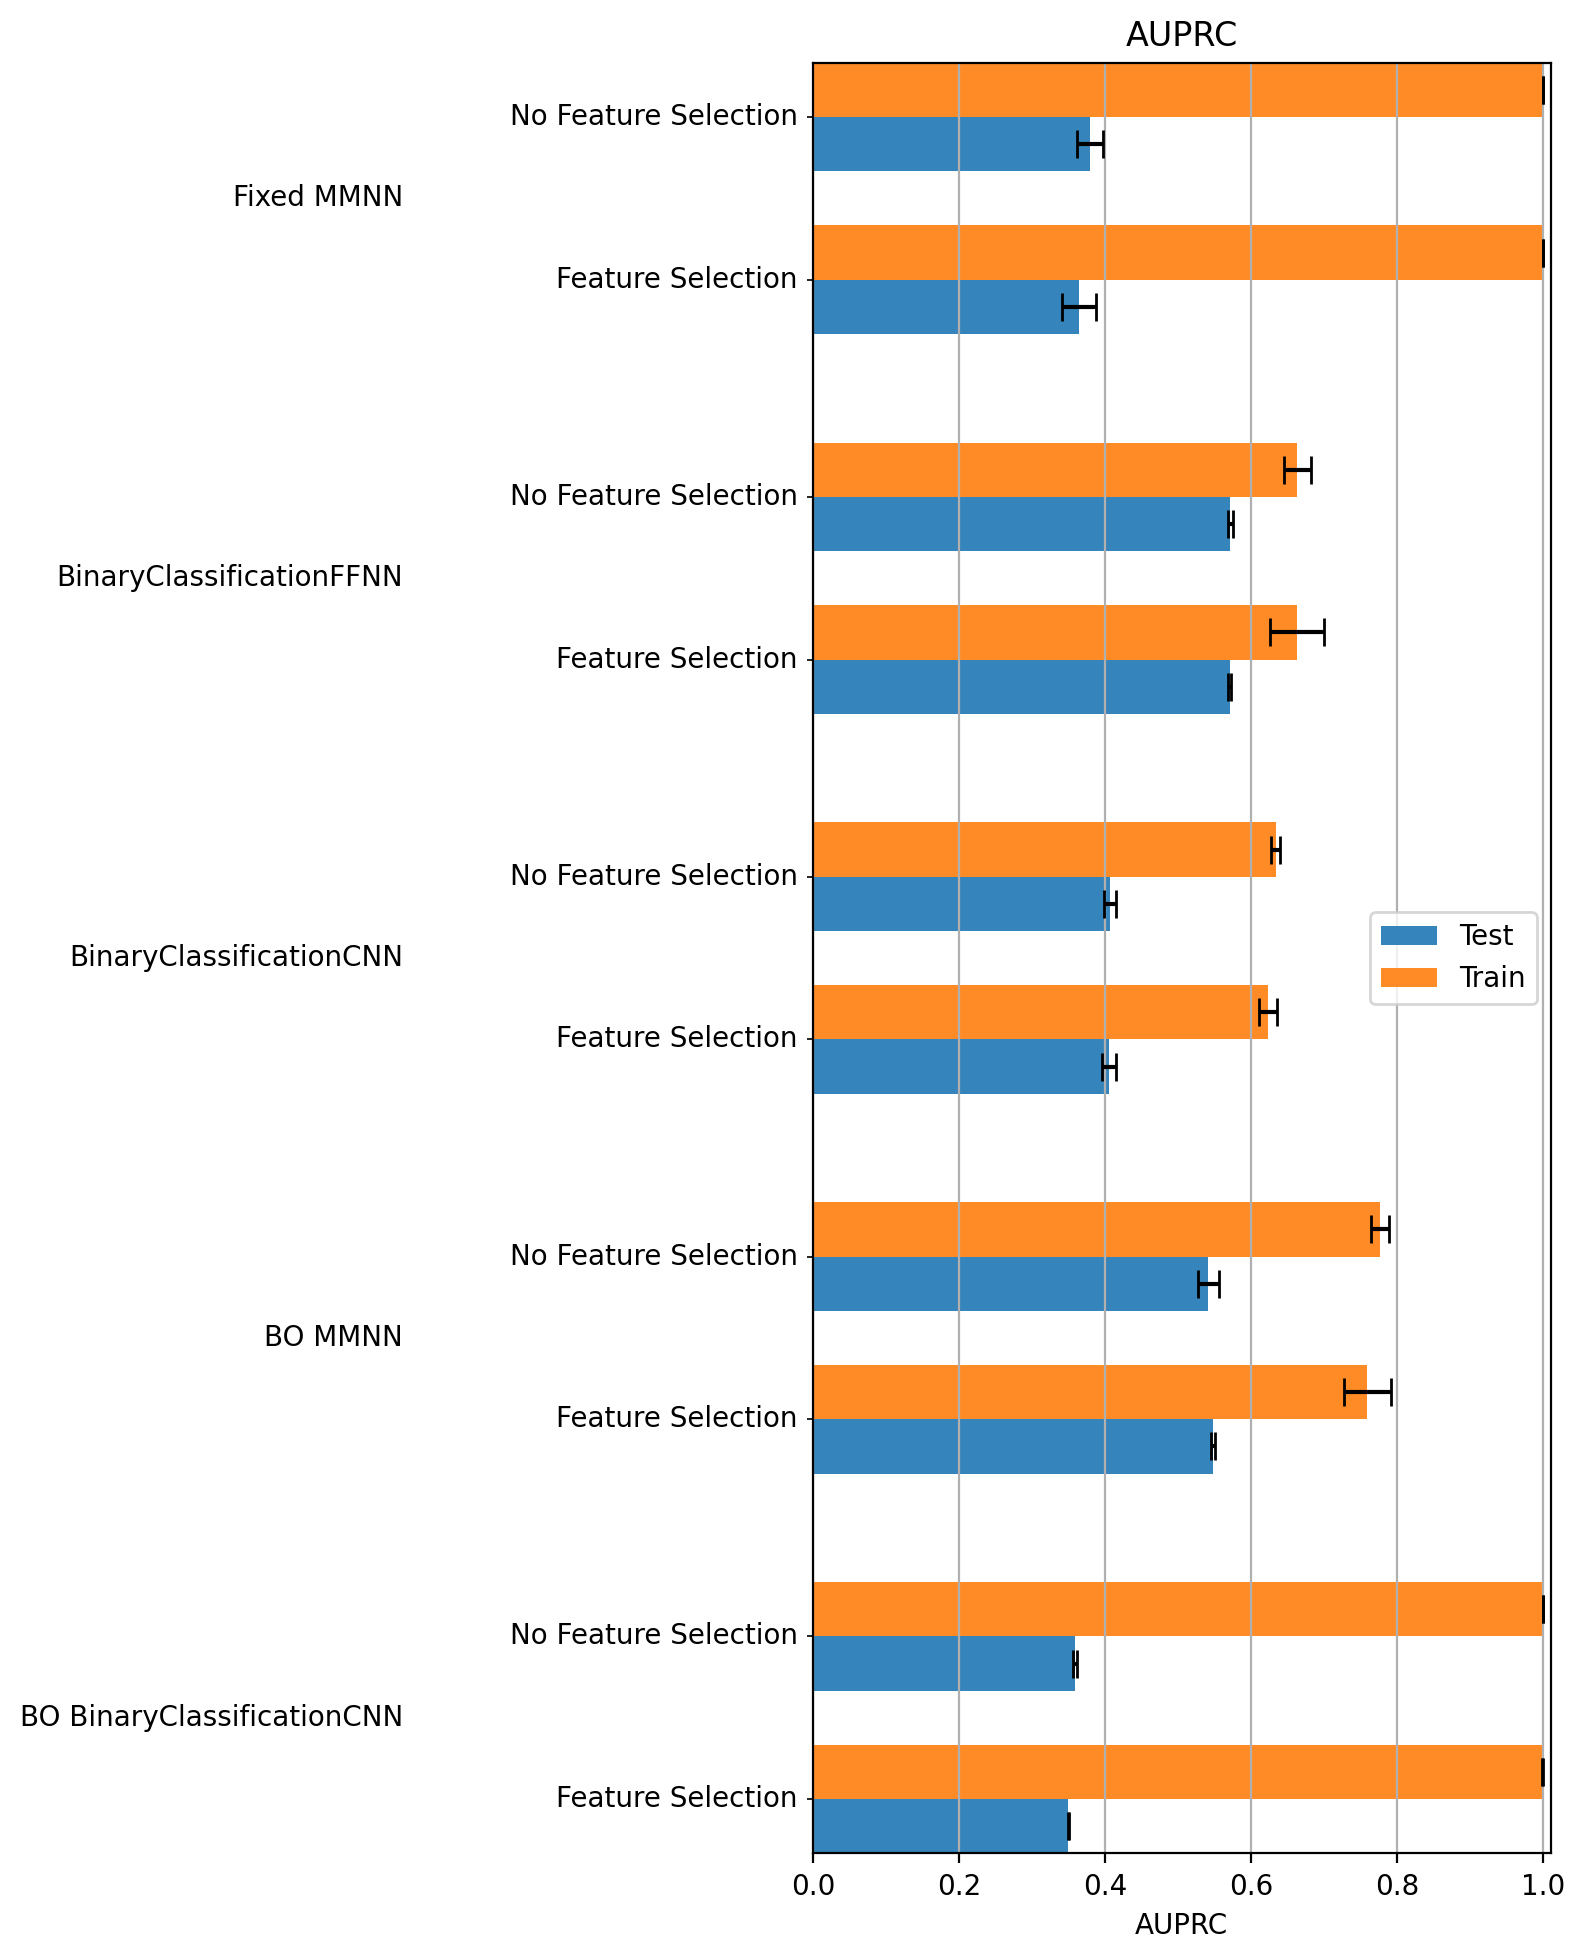

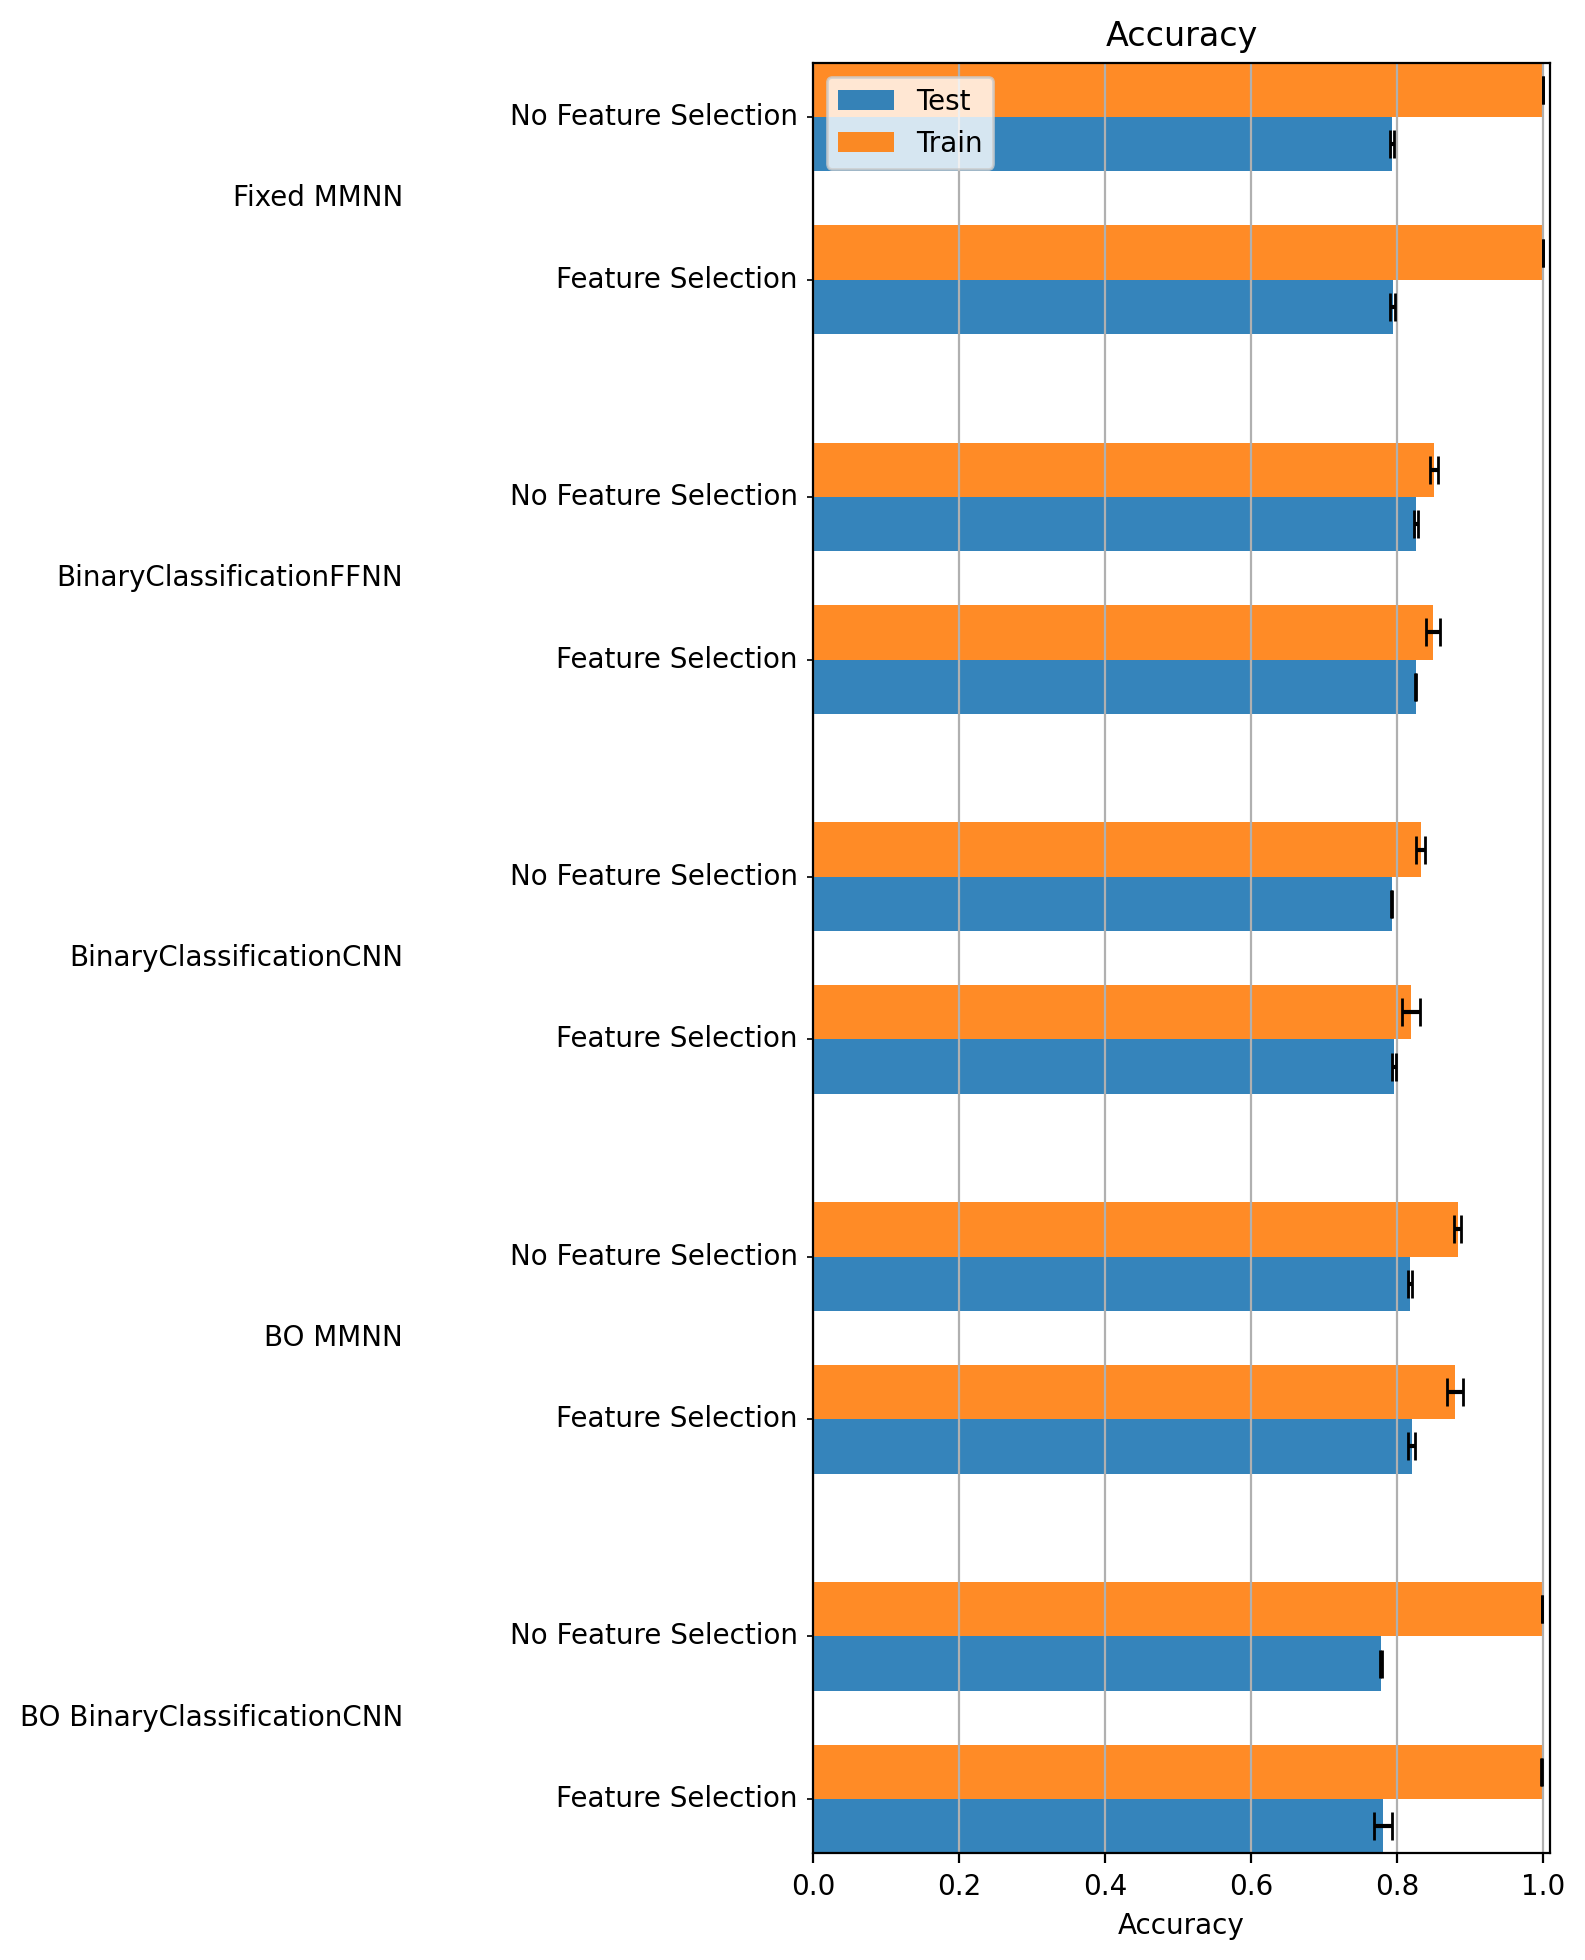

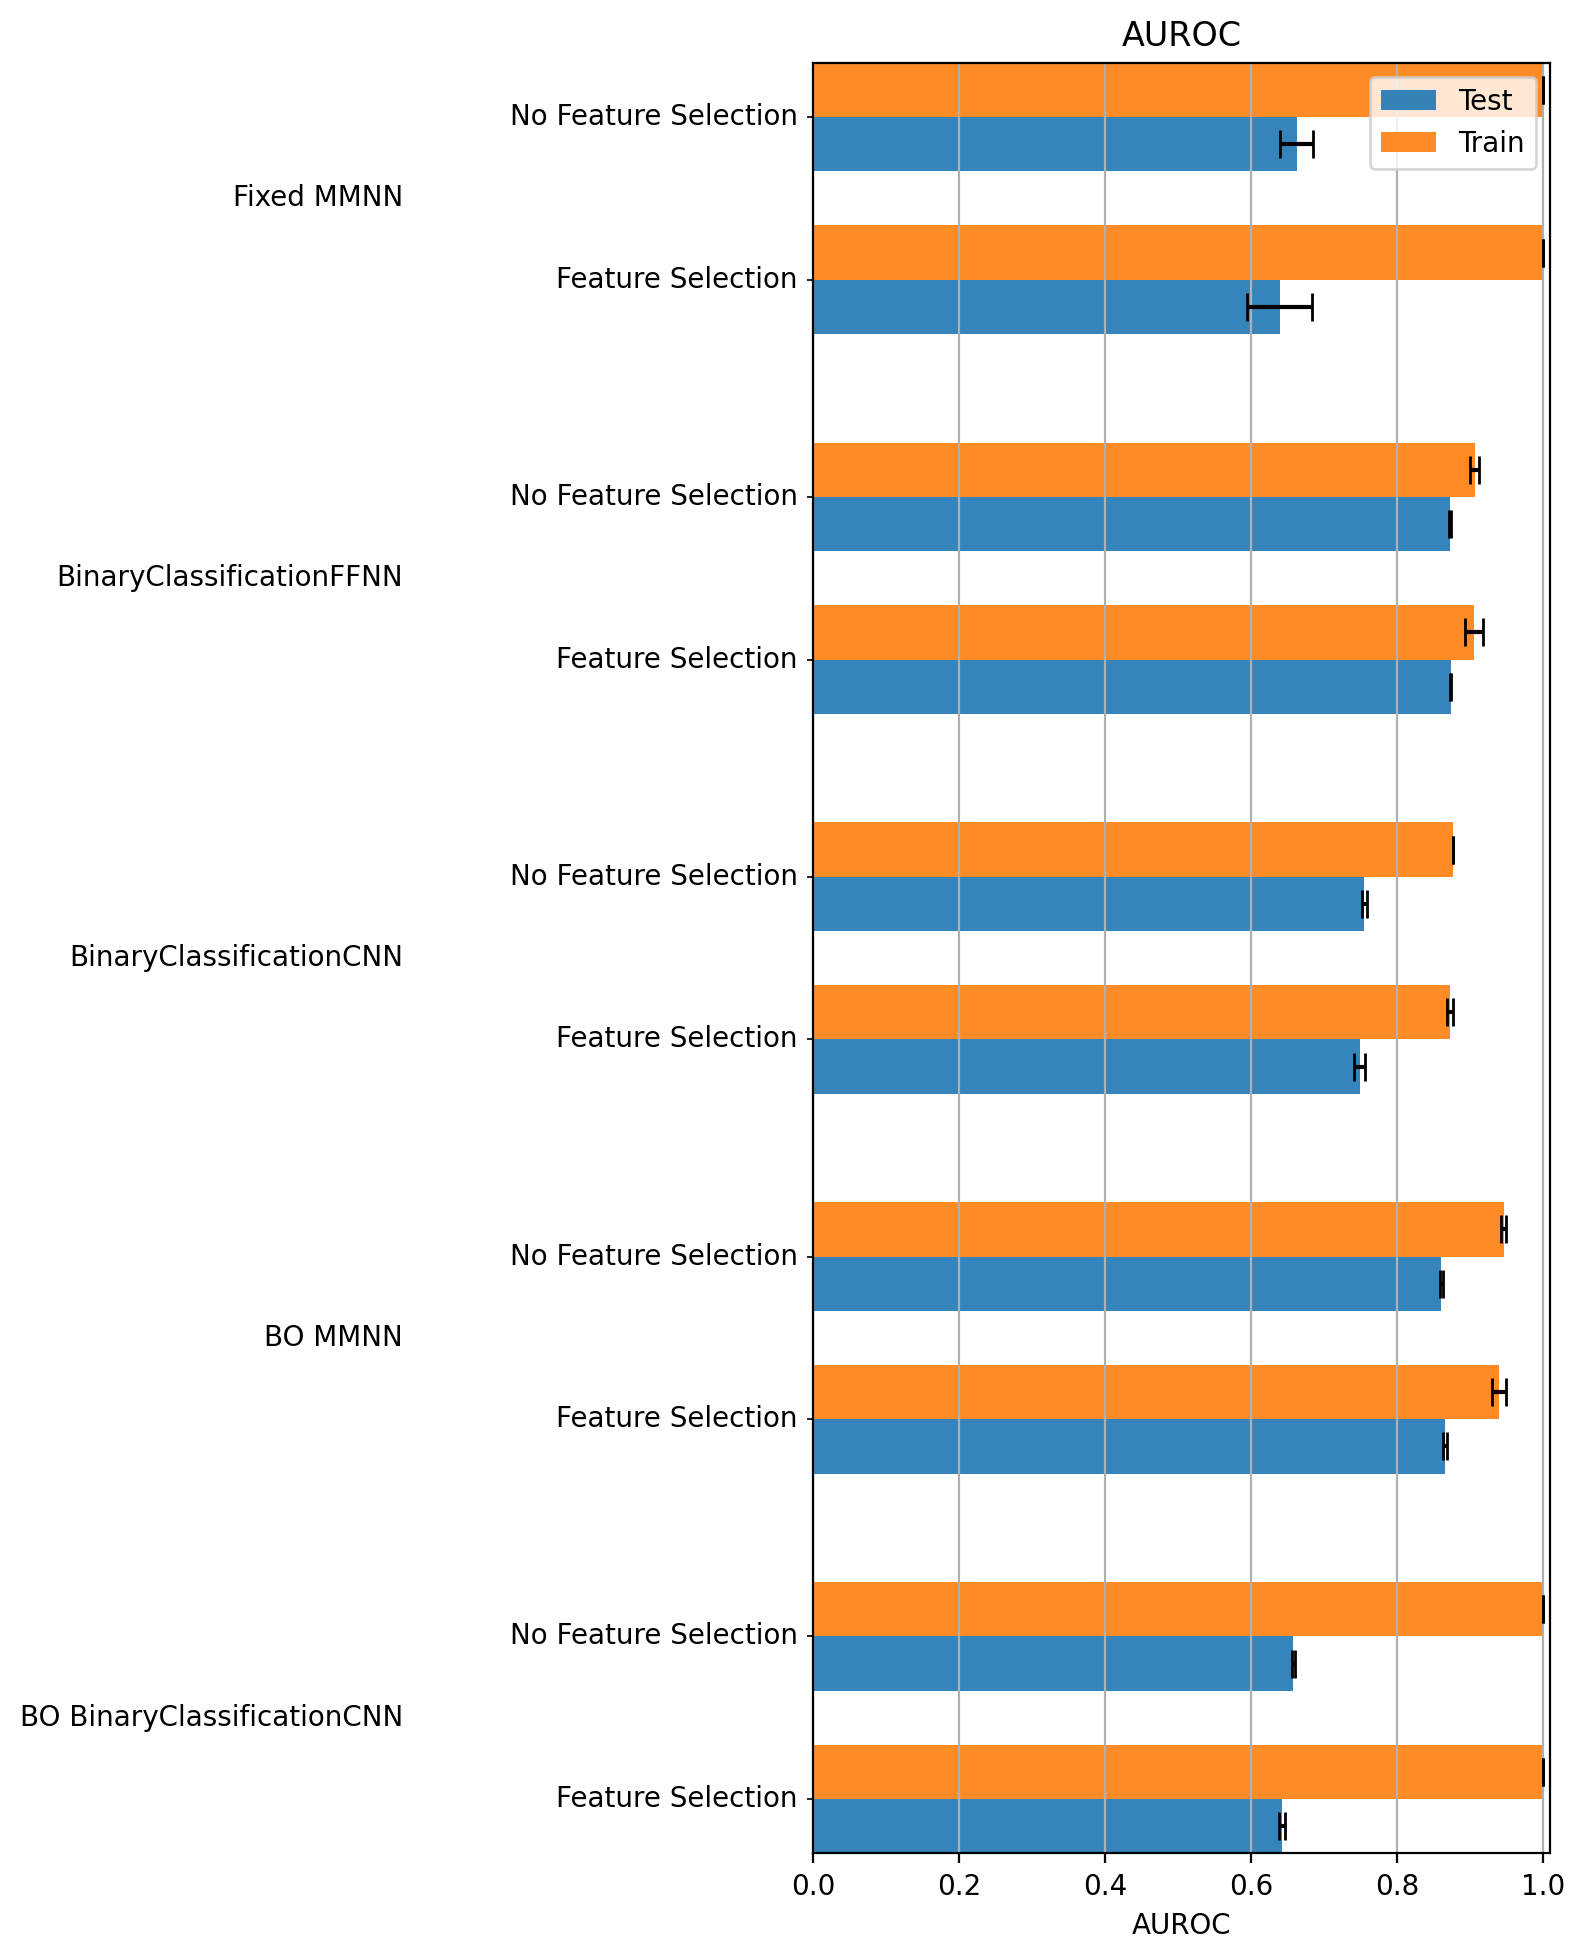

In [83]:
result(all_performance, "Promoter")

Rendering barplots:   0%|                                                                                     …

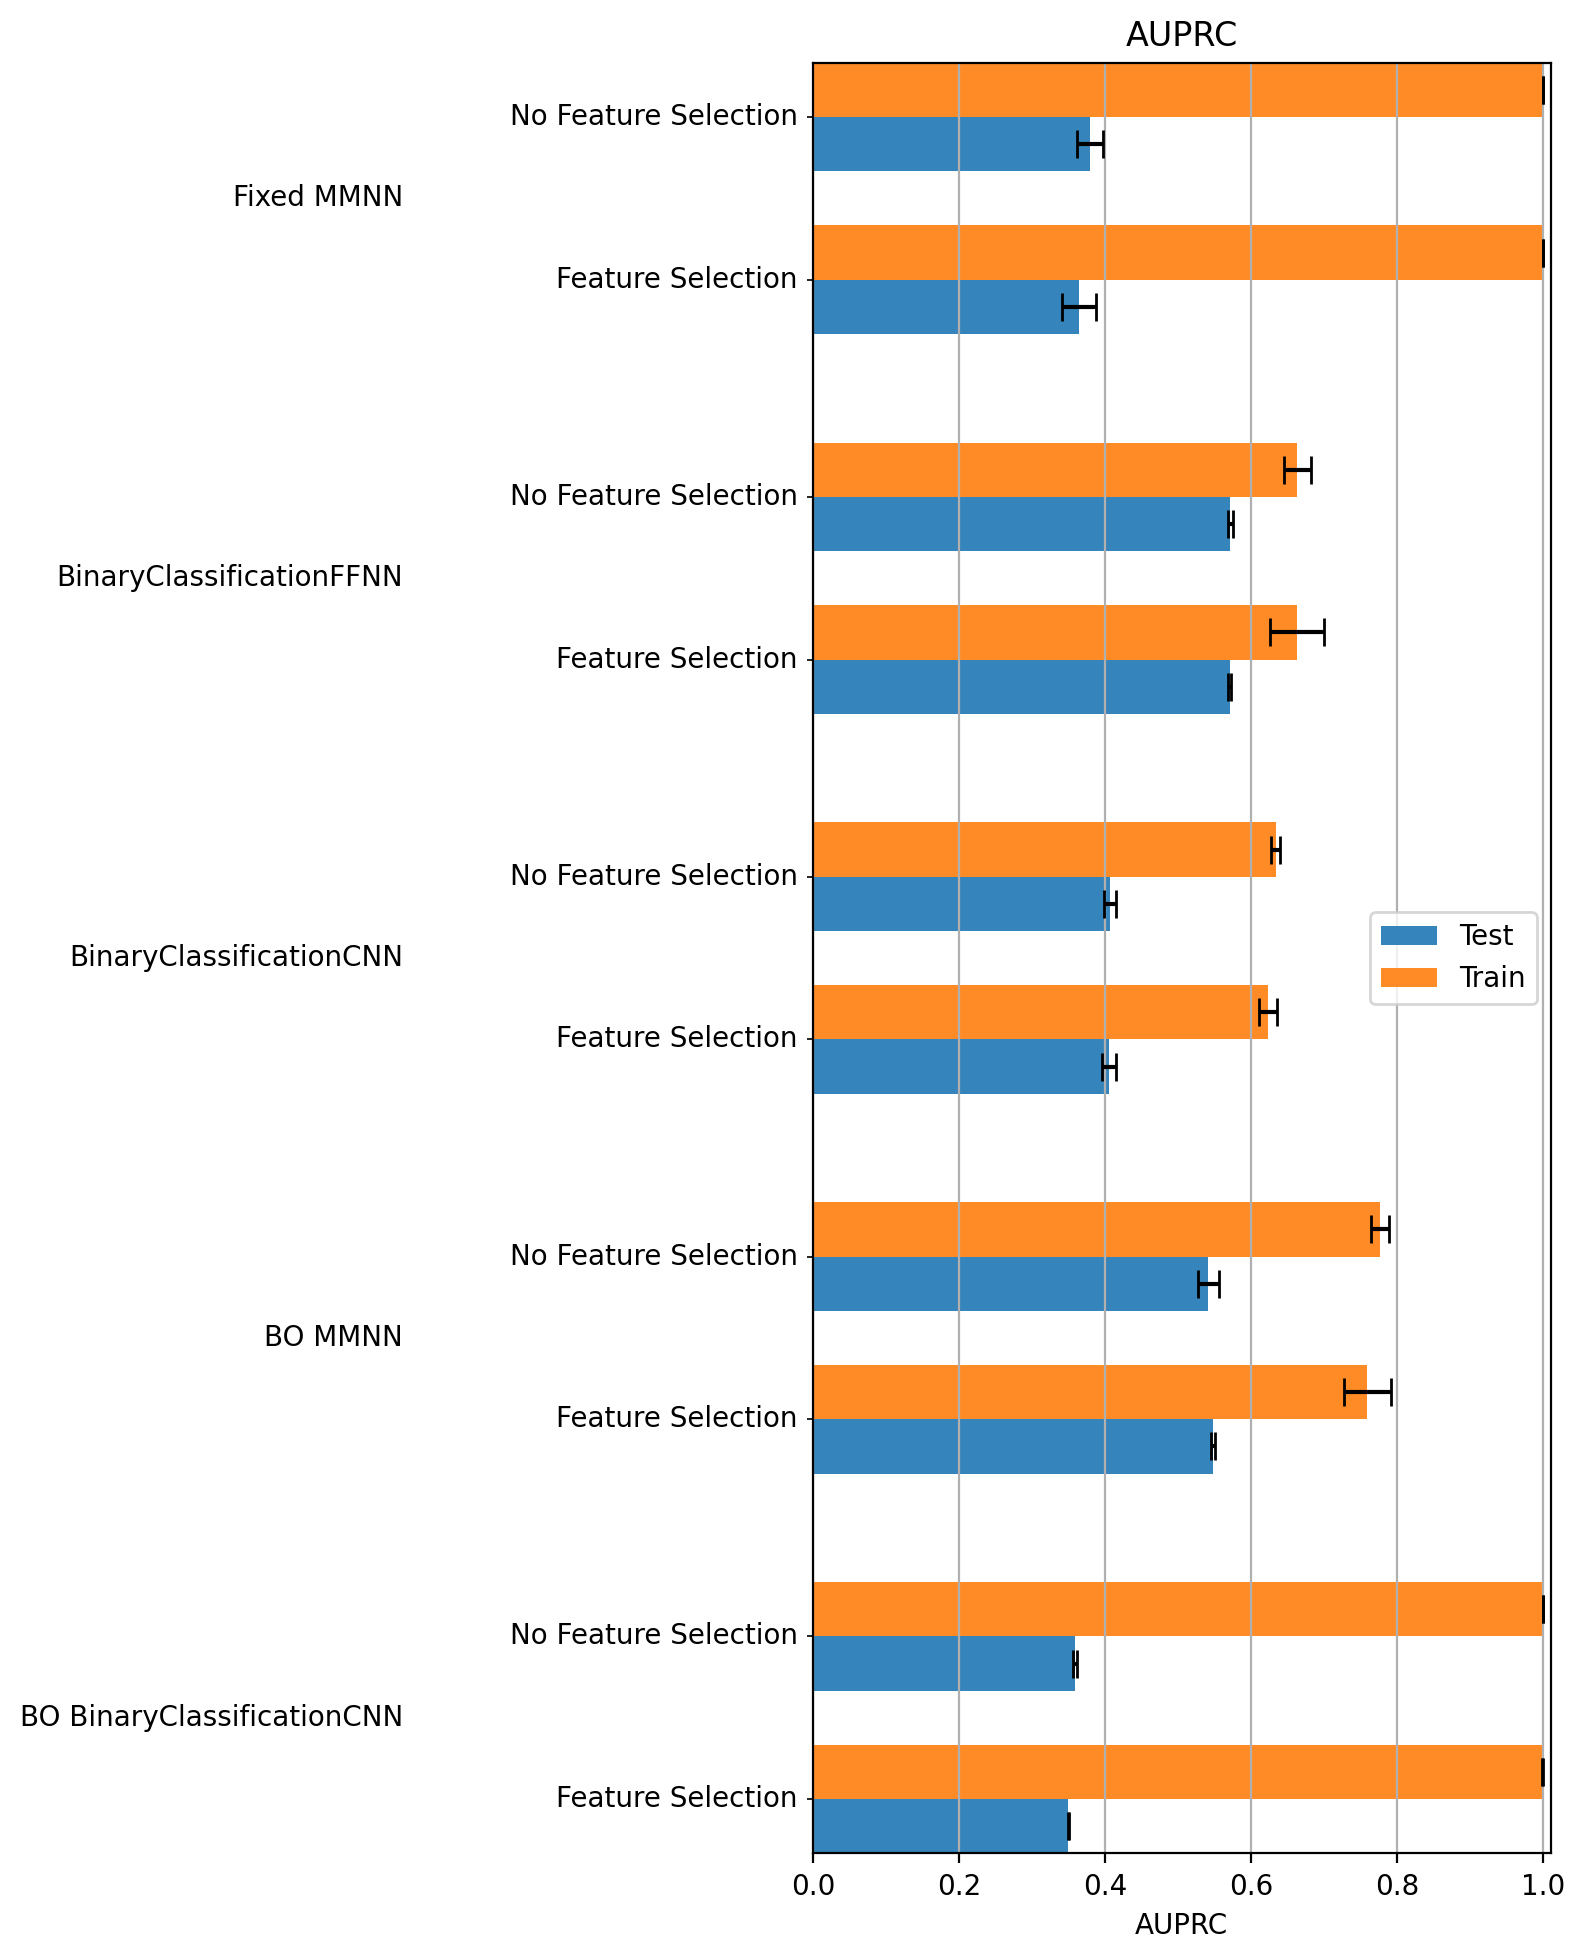

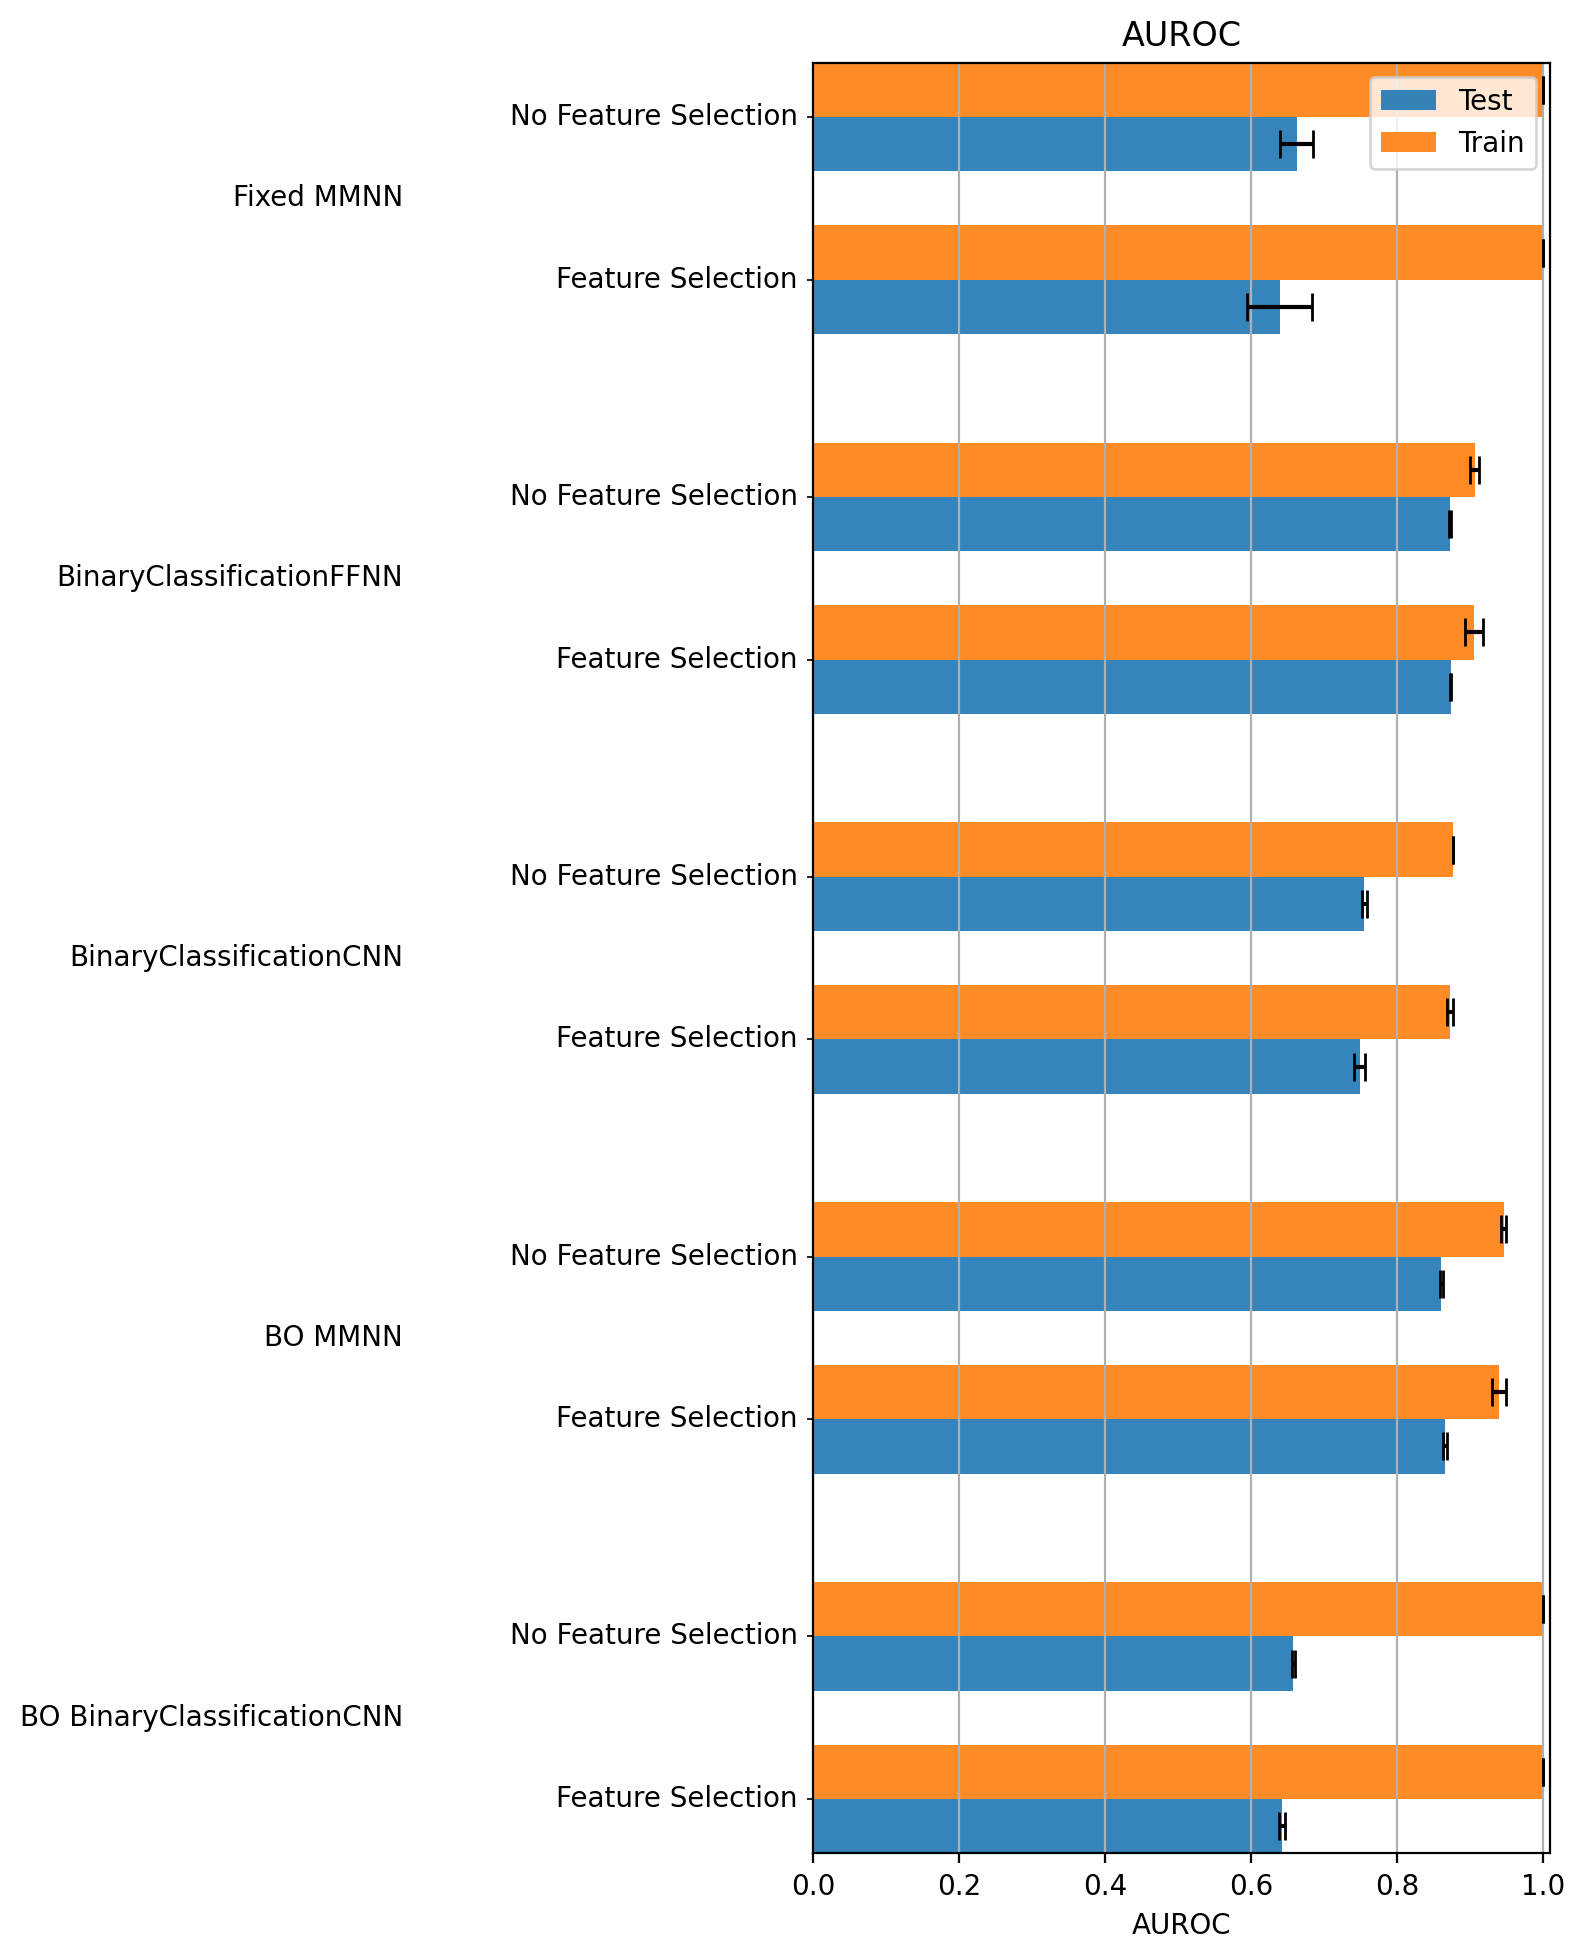

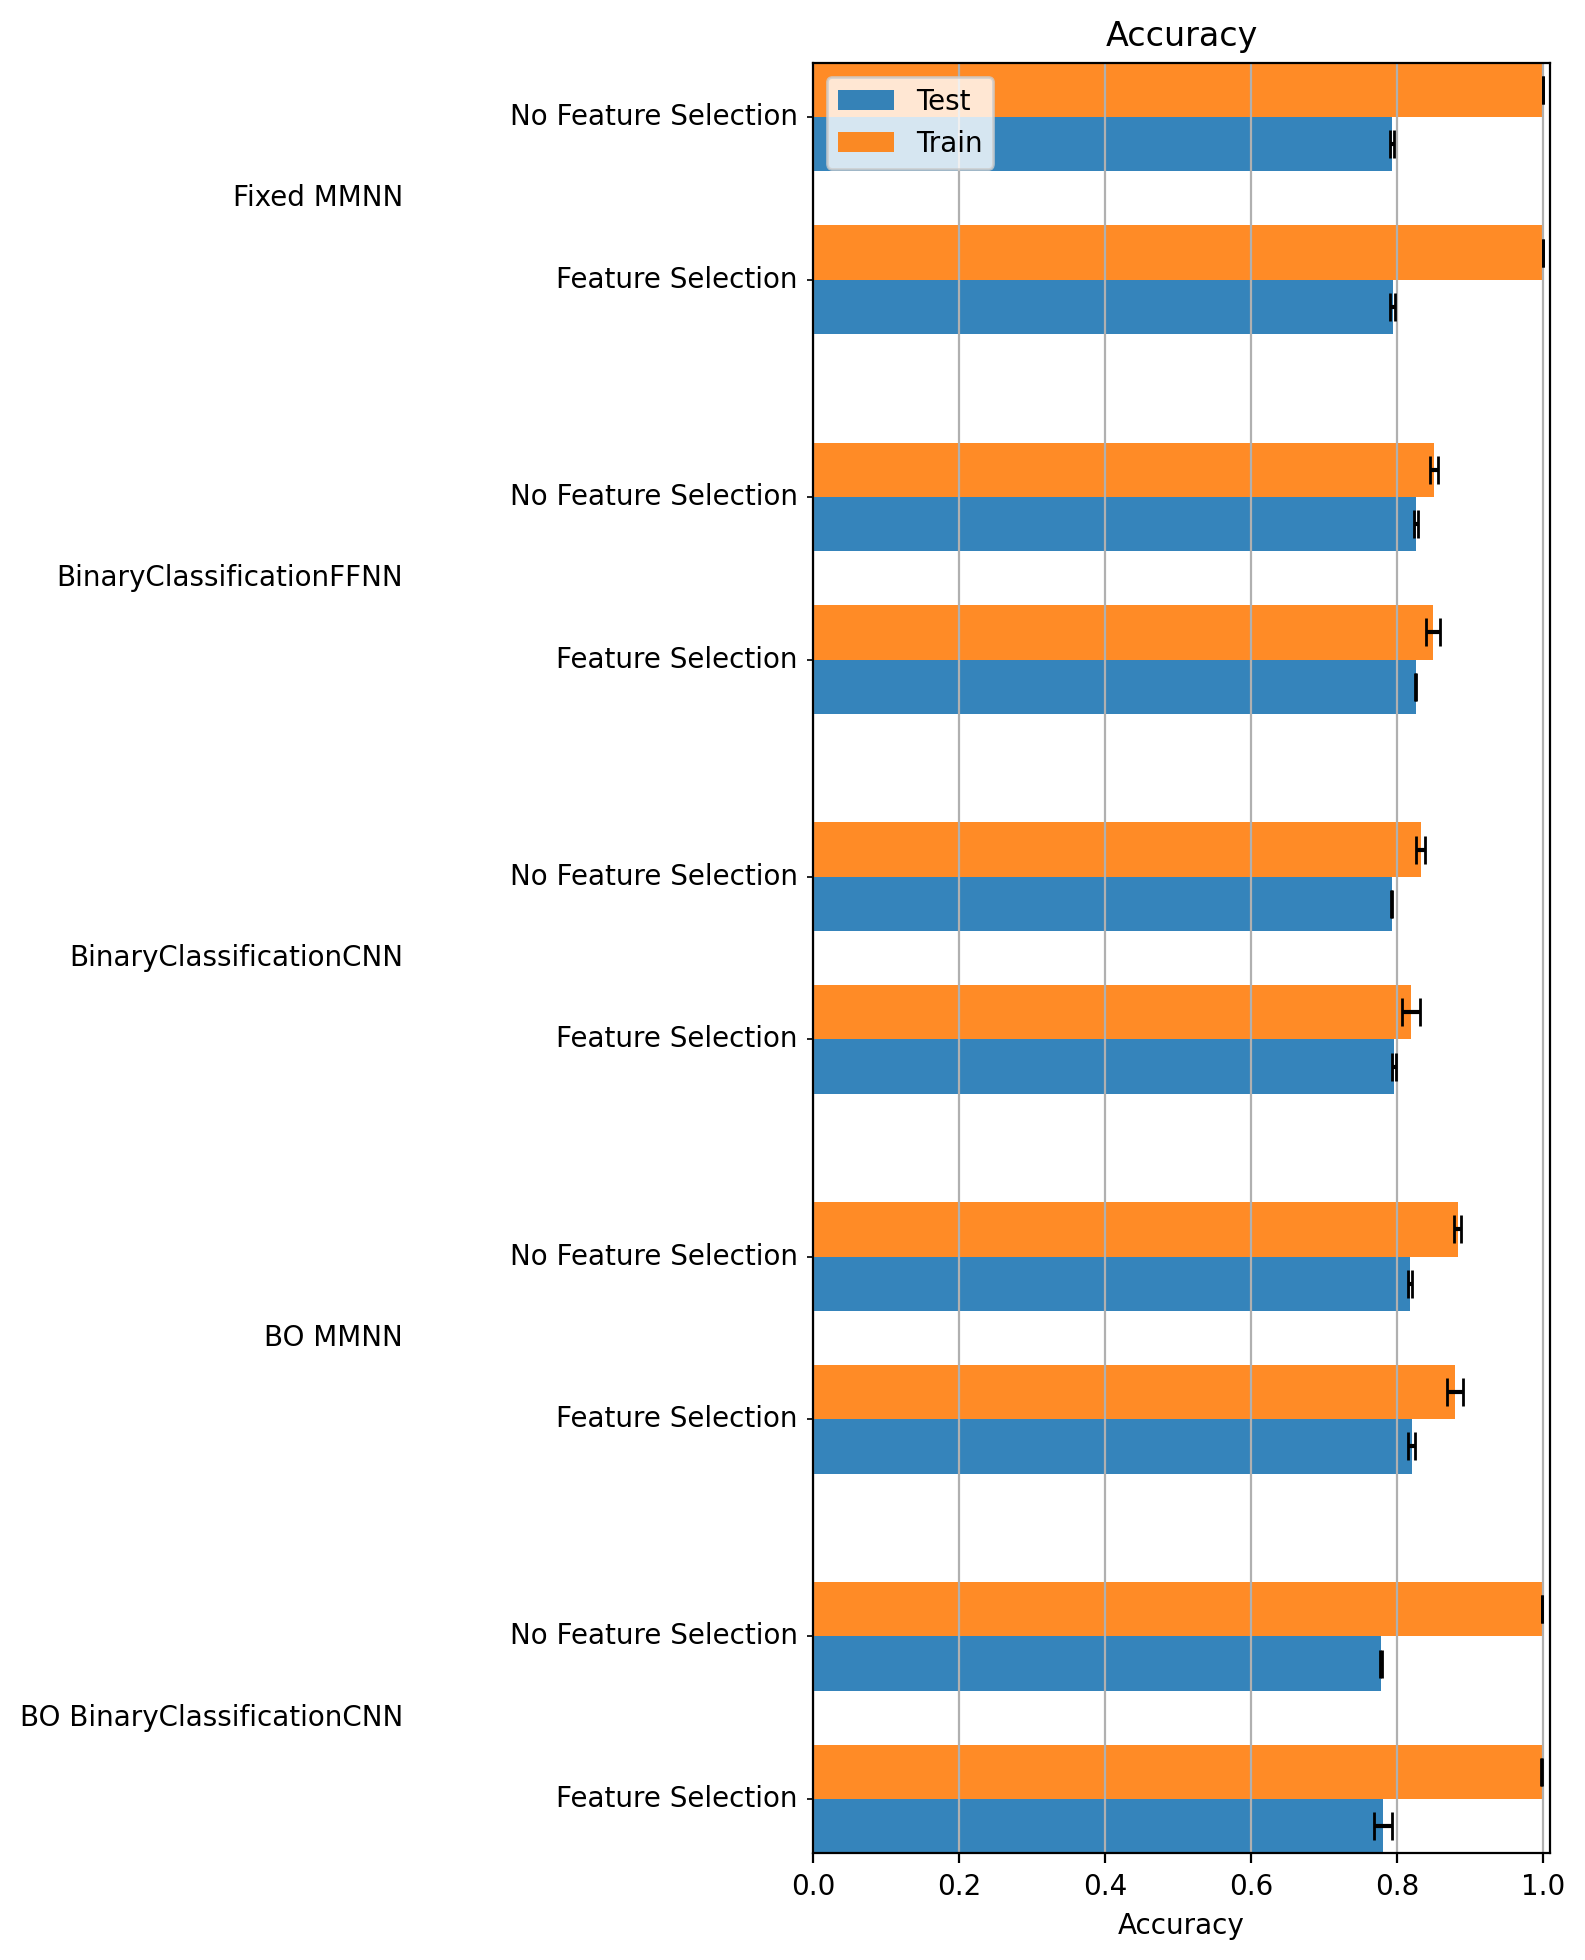

In [84]:
result(all_performance, "Enhancer")

In [85]:
from scipy.stats import wilcoxon

for model in all_performance.model_name.unique():
    model_performance = all_performance[
        (all_performance.model_name == model) &
        (all_performance.run_type == "test")]
    performance_with_feature_selection = model_performance[
        all_performance.use_feature_selection == "Feature Selection"
    ]
    performance_without_feature_selection = model_performance[
        all_performance.use_feature_selection == "No Feature Selection"
    ]

    for metric in ("AUPRC", "AUROC", "accuracy"):
        print(
            model,
            metric,
            wilcoxon(performance_with_feature_selection[metric], performance_without_feature_selection[metric])
        )

BinaryClassificationFFNN AUPRC WilcoxonResult(statistic=3.0, pvalue=0.625)
BinaryClassificationFFNN AUROC WilcoxonResult(statistic=2.0, pvalue=0.375)
BinaryClassificationFFNN accuracy WilcoxonResult(statistic=5.0, pvalue=1.0)
BO_BinaryClassificationCNN AUPRC WilcoxonResult(statistic=0.0, pvalue=0.5)
BO_BinaryClassificationCNN AUROC WilcoxonResult(statistic=0.0, pvalue=0.5)
BO_BinaryClassificationCNN accuracy WilcoxonResult(statistic=1.0, pvalue=1.0)
BinaryClassificationCNN AUPRC WilcoxonResult(statistic=0.0, pvalue=0.5)
BinaryClassificationCNN AUROC WilcoxonResult(statistic=0.0, pvalue=0.5)
BinaryClassificationCNN accuracy WilcoxonResult(statistic=0.0, pvalue=0.5)
Fixed_MMNN AUPRC WilcoxonResult(statistic=0.0, pvalue=0.5)
Fixed_MMNN AUROC WilcoxonResult(statistic=0.0, pvalue=0.5)
Fixed_MMNN accuracy WilcoxonResult(statistic=1.0, pvalue=1.0)
BO_MMNN AUPRC WilcoxonResult(statistic=1.0, pvalue=1.0)
BO_MMNN AUROC WilcoxonResult(statistic=0.0, pvalue=0.5)
BO_MMNN accuracy WilcoxonResult(sta